In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from functions import *
import timeit
from sklearn.model_selection import train_test_split

# preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

# modèlisations
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Visualisation yellowBrick
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import PredictionError
from yellowbrick.model_selection import ValidationCurve
from yellowbrick.model_selection import LearningCurve
from yellowbrick.model_selection import CVScores

# **FONCTIONS**

In [2]:
def Affichage_duree(start_time):
    '''
    Fonction pour afficher les durées de calcul de façon plus claire
    '''
    elapsed = timeit.default_timer() - start_time
    if elapsed < 60:
        print(f'Temps d\'exécution : {elapsed:.2f}s')
    elif elapsed < 3600:
        elapsed_m = elapsed/60
        print(f'Temps d\'exécution : {elapsed_m:.2f}min')
    else:
        elapsed_h = elapsed/3600
        print(f'Temps d\'exécution : {elapsed_h:.2f}h')
    return elapsed

In [3]:
def Test_modele_GSCV(nom_run, model, grid_params, cv, score, pipe_preprocessing, X_train, y_train, X_test, y_test, resultat):
    '''
    nom_run = nom de la réalisation qui va être testée
    model = modele à tester
    grid_params = paramètres à tester !!! il faut qu'ils soient rédigé de façon à être compris
                    par la pipeline (nommodele__nomparam)
    cv = nombre de cross validations à réaliser
    score = score sur lequel faire la selection des meilleurs paramètres
    pipe_preprocessing : pipeline de pretraitement des données
    X_train, y_train = données d'entrainement
    X_test, y_test = données de test
    resultat = dataframe qui stocke tous les résultats des modélisations
    '''
    result=pd.DataFrame()
    start_time = timeit.default_timer()
    
    # mise en place du modele et entrainement
    model_cv = make_pipeline(pipe_preprocessing, model)
    grid_cv = GridSearchCV(model_cv, 
                           param_grid=grid_params, 
                           cv=cv, 
                           scoring=score)
    grid_cv.fit(X_train, y_train)
    print('Durée du gridSearchCV : ', Affichage_duree(start_time))
    result.loc['Duree calcul (s)', nom_run] = grid_cv.refit_time_
    
    # stockage des résultat du gridSearchCV
    for param in grid_params.keys():
        result.loc[param, nom_run] = grid_cv.best_params_.get(param)
    
    # test sur le jeu de test
    y_pred = grid_cv.predict(X_test)

    # calcul metriques
    result.loc['MSE', nom_run] = metrics.mean_squared_error(y_test, y_pred)
    result.loc['RMSE', nom_run] = np.sqrt( metrics.mean_squared_error(y_test, y_pred) )
    if min(y_pred) > 0:
        result.loc['RMSLE', nom_run] = metrics.mean_squared_log_error(y_test, y_pred)
    else:
        result.loc['RMSLE', nom_run] = np.nan
    result.loc['RSE', nom_run] = 1-metrics.r2_score(y_test, y_pred)
    result.loc['R²', nom_run] = metrics.r2_score(y_test, y_pred)
    
    print("MSE : {:.2f}".format(result.loc['MSE', nom_run]))
    print("RMSE : {:.2f}".format(result.loc['MSE', nom_run]))
    print("RMSLE : {:.2f}".format(result.loc['RMSLE', nom_run]))
    print("RSE : {:.2f}".format(result.loc['RSE', nom_run]))
    print("R² : {:.2f}".format(result.loc['R²', nom_run]))
    
    # Affichage du crossplot
    sns.scatterplot(x=y_test, y=y_pred);
    plt.xlabel('données de référence (y_test)')
    plt.ylabel('données modélisées (y_pred)')
    plt.title('Modélisation de {}'.format(y_train.name))
    
    # Stockage données modélisées vs données test
    y_pred = pd.DataFrame(y_pred, index=y_test.index)
    y_pred.columns = [nom_run]
    result = pd.concat([result, y_pred])
    
    resultat = resultat.merge(result, left_index=True, right_index=True, sort=False, how='outer')
    
    return resultat

In [4]:
def nb_val_negatives(resultat, index_max):
    '''
    Objectif = compter les valeurs négatives calculées par chaque modèle
    ---------
    resultat = fichier dans lequel sont stockés les différents résultats de modélisation
    index_max = index au delà duquel sont stockés les metriques
    '''
    for model in resultat.columns:
        resultat.loc['nb valeurs negatives', model] = np.sum(resultat.loc[:index_max,model] < 0)
    return resultat

In [5]:
def initialisation_resultats(nom_baseline, y_test, y_pred):
    # initialisation du fichier résultat global avec les données de test
    resultat = y_test.copy()
    resultat = pd.DataFrame(resultat)
    resultat.columns = ['y_test']

    # compilation des données de la regression linéaire
    result = pd.DataFrame()
    # calcul metriques
    result.loc['MSE', nom_baseline] = metrics.mean_squared_error(y_test, y_pred)
    result.loc['RMSE', nom_baseline] = np.sqrt( metrics.mean_squared_error(y_test, y_pred) )
    if min(y_pred) > 0:
        result.loc['RMSLE', nom_baseline] = metrics.mean_squared_log_error(y_test, y_pred)
    else:
        result.loc['RMSLE', nom_baseline] = np.nan
    result.loc['RSE', nom_baseline] = 1-metrics.r2_score(y_test, y_pred)
    result.loc['R²', nom_baseline] = metrics.r2_score(y_test, y_pred)
    result.loc['Duree calcul (s)', nom_baseline] = elapsed

    
    # Stockage données modélisées vs données test
    y_pred = pd.DataFrame(y_pred, index=y_test.index)
    y_pred.columns = [nom_baseline]
    result = pd.concat([result, y_pred])

    # merge du fichier resultat avec le fichier result
    resultat = resultat.merge(result, left_index=True, right_index=True, sort=False, how='outer')
    
    return resultat

In [6]:
start_time_ALL = timeit.default_timer()

# import des données

In [7]:
data = pd.read_csv('../01_DATA/data_for_modeling.csv')

In [8]:
data.shape

(1263, 12)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1263 entries, 0 to 1262
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      1263 non-null   int64  
 1   PrimaryPropertyType             1263 non-null   object 
 2   YearBuilt                       1263 non-null   int64  
 3   NumberofFloors                  1263 non-null   float64
 4   PropertyGFATotal                1263 non-null   int64  
 5   PropertyGFAParking              1263 non-null   int64  
 6   LargestPropertyUseType          1259 non-null   object 
 7   ThirdLargestPropertyUseTypeGFA  196 non-null    float64
 8   ENERGYSTARScore                 871 non-null    float64
 9   SiteEnergyUse(kBtu)             1263 non-null   float64
 10  GHGEmissions(MetricTonsCO2e)    1263 non-null   float64
 11  UseType                         1263 non-null   object 
dtypes: float64(5), int64(4), object(3)

# Consommation d'énergie

## Préparation des données

In [10]:
X = data.drop(['Unnamed: 0', 'SiteEnergyUse(kBtu)', 
               'GHGEmissions(MetricTonsCO2e)'], axis=1)
y = data['SiteEnergyUse(kBtu)']

In [11]:
X.describe(include='all')

PrimaryPropertyType    YearBuilt  NumberofFloors  \
count                          1263  1263.000000     1263.000000   
unique                           18          NaN             NaN   
top     Small- and Mid-Sized Office          NaN             NaN   
freq                            249          NaN             NaN   
mean                            NaN  1960.056215        3.472684   
std                             NaN    32.828626        4.117221   
min                             NaN  1900.000000        0.000000   
25%                             NaN  1928.000000        1.000000   
50%                             NaN  1964.000000        2.000000   
75%                             NaN  1988.000000        4.000000   
max                             NaN  2014.000000       42.000000   

        PropertyGFATotal  PropertyGFAParking LargestPropertyUseType  \
count        1263.000000         1263.000000                   1259   
unique               NaN                 NaN                     20   
top                  NaN                 NaN                 Office   
freq                 NaN                 NaN                    390   
mean        84627.095804        10490.262074                    NaN   
std        104002.257576        33799.441488                    NaN   
min         20000.000000            0.000000                    NaN   
25%         28648.000000            0.000000                    NaN   
50%         46100.000000            0.000000                    NaN   
75%         92614.500000            0.000000                    NaN   
max        920598.000000       407795.000000                    NaN   

        ThirdLargestPropertyUseTypeGFA  ENERGYSTARScore UseType  
count                       196.000000       871.000000    1263  
unique                             NaN              NaN      23  
top                                NaN              NaN   Other  
freq                               NaN              NaN     348  
mean                       7045.979592        64.035591     NaN  
std                        7933.129095        28.450116     NaN  
min                           0.000000         1.000000     NaN  
25%                        2385.250000        47.000000     NaN  
50%                        4587.500000        72.000000     NaN  
75%                        9129.000000        87.000000     NaN  
max                       54106.000000       100.000000     NaN

In [12]:
X_quanti = X.select_dtypes(['float64', 'int64'])
X_categ = X.select_dtypes(['object'])

### Données quantitatives

In [13]:
X_quanti.describe()

YearBuilt  NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
count  1263.000000     1263.000000       1263.000000         1263.000000   
mean   1960.056215        3.472684      84627.095804        10490.262074   
std      32.828626        4.117221     104002.257576        33799.441488   
min    1900.000000        0.000000      20000.000000            0.000000   
25%    1928.000000        1.000000      28648.000000            0.000000   
50%    1964.000000        2.000000      46100.000000            0.000000   
75%    1988.000000        4.000000      92614.500000            0.000000   
max    2014.000000       42.000000     920598.000000       407795.000000   

       ThirdLargestPropertyUseTypeGFA  ENERGYSTARScore  
count                      196.000000       871.000000  
mean                      7045.979592        64.035591  
std                       7933.129095        28.450116  
min                          0.000000         1.000000  
25%                       2385.250000        47.000000  
50%                       4587.500000        72.000000  
75%                       9129.000000        87.000000  
max                      54106.000000       100.000000

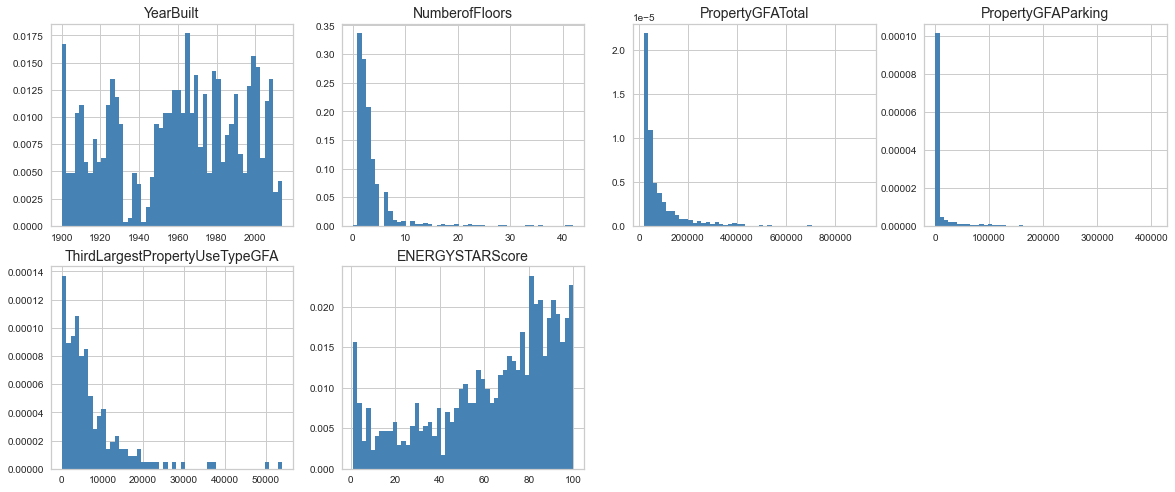

In [14]:
fig = plt.figure(figsize=(20, 35))
compteur = 1
for feat_idx in X.select_dtypes(['float64', 'int64']):
    ax = fig.add_subplot(8,4, (compteur))
    h = ax.hist(X[feat_idx], bins=50, color='steelblue', density=True, edgecolor='none')
    ax.set_title(feat_idx, fontsize=14)
    compteur += 1

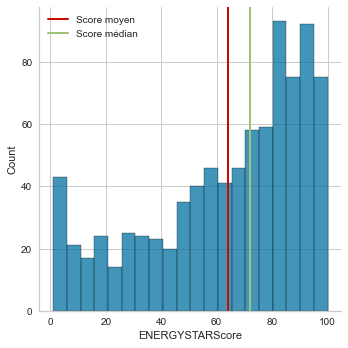

In [15]:
sns.displot(data=X, x='ENERGYSTARScore', bins=20);
plt.axvline(x=X['ENERGYSTARScore'].mean(), linewidth=2, color = 'r', label='Score moyen');
plt.axvline(x=X['ENERGYSTARScore'].median(), linewidth=2, color = 'g', label='Score médian');
plt.legend();

In [16]:
# selection des données en fonction des différents traitement à leur affecter
X_quanti_GFA = list(X_quanti.filter(regex='GFA').columns)
X_quanti_ESS = ['ENERGYSTARScore']
X_quanti_others = list(X_quanti.drop(X_quanti_GFA, axis=1).drop('ENERGYSTARScore', axis=1).columns)

# mise en place des pipelines pour les données quantitatives
GFA_pipeline = make_pipeline(SimpleImputer(strategy='constant', fill_value=0), StandardScaler())
ESS_pipeline = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())
Other_quanti_pipeline = make_pipeline(StandardScaler())

In [17]:
Other_quanti_pipeline

Pipeline(steps=[('standardscaler', StandardScaler())])

In [18]:
X_quanti_GFA

['PropertyGFATotal', 'PropertyGFAParking', 'ThirdLargestPropertyUseTypeGFA']

### Données catégorielles

In [19]:
categ_pipeline = make_pipeline(SimpleImputer(strategy='constant', fill_value='None'), OneHotEncoder())

In [20]:
categ_pipeline

Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='None', strategy='constant')),
                ('onehotencoder', OneHotEncoder())])

In [21]:
X_categ = list(X_categ.columns)

### Preprocessing

In [22]:
preprocessor = make_column_transformer((GFA_pipeline, X_quanti_GFA), 
                                       (ESS_pipeline, X_quanti_ESS),
                                       (Other_quanti_pipeline, X_quanti_others),
                                       (categ_pipeline, X_categ))

In [23]:
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['PropertyGFATotal', 'PropertyGFAParking',
                                  'ThirdLargestPropertyUseTypeGFA']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['ENERGYSTARScore']),
                                ('pipeline-

### Target

In [24]:
y_all = data[['SiteEnergyUse(kBtu)', 'GHGEmissions(MetricTonsCO2e)']]
y_all

SiteEnergyUse(kBtu)  GHGEmissions(MetricTonsCO2e)
0               6981428.0                        249.43
1               8354235.0                        263.51
2              12051984.0                        304.62
3               6252842.0                        208.46
4               6426022.0                        199.99
...                   ...                           ...
1258            3681105.0                         70.38
1259            6879291.0                         75.28
1260           16730779.0                        210.69
1261             850568.0                         12.40
1262             628609.0                          4.38

[1263 rows x 2 columns]

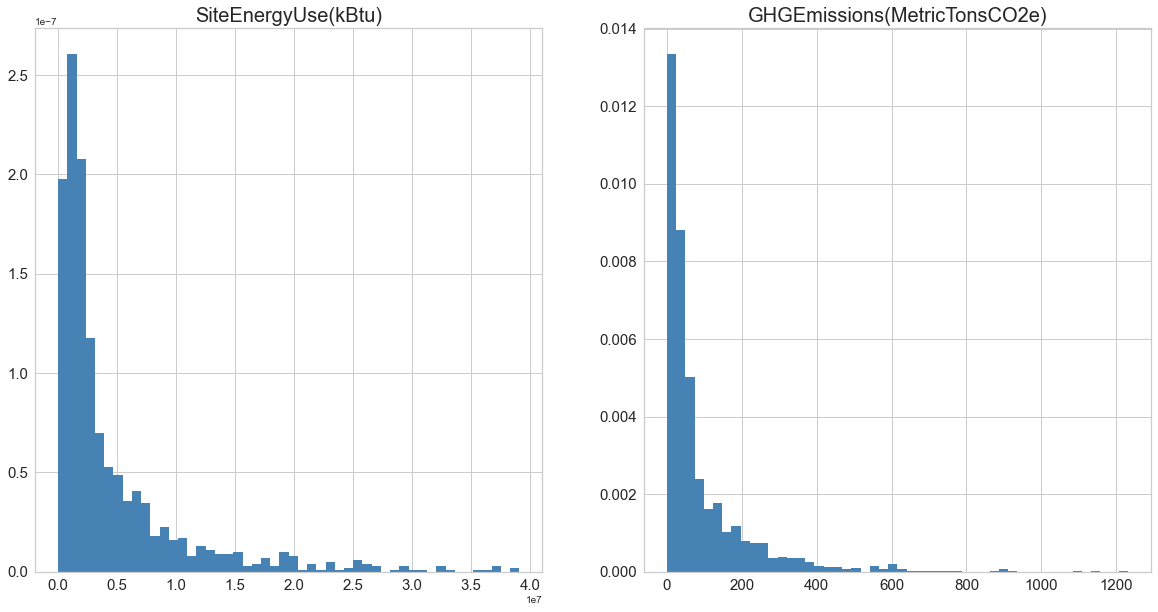

In [25]:
fig = plt.figure(figsize=(20, 10))
compteur = 1
for feat_idx in y_all.select_dtypes(['float64', 'int64']):
    ax = fig.add_subplot(1,2, (compteur))
    h = ax.hist(y_all[feat_idx], bins=50, color='steelblue', density=True, edgecolor='none')
    ax.set_title(feat_idx, fontsize=20)
    plt.tick_params(axis = 'both', labelsize = 15)
#     min_feat = y_all[feat_idx].min
#     max_feat = y_all[feat_idx].max
#     mean_feat = y_all[feat_idx].mean
#     med_feat = y_all[feat_idx].median
#     plt.text(5,1,
#              'Min = ',min_feat
#              )
    compteur += 1

## Modelisation avec toutes les variables disponibles

### Test impact randomState sur le trainTestSplit

Temps d'exécution : 10.80s


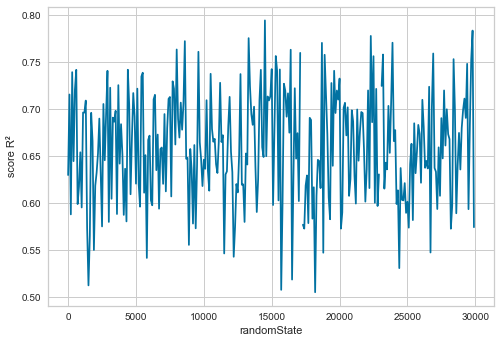

Le meilleur score est : 0.79 pour rs=14500.
---------------------------------------- 
 Stats 
 ---------------------------------------- 
Le score moyen est de 0.66 
min = 0.51 
max = 0.79 
mediane = 0.66


In [26]:
start_time = timeit.default_timer()

score = []
score_max = 0
compteur = 0
randomstate = range(0,30000,100)
for rs in randomstate:
    try:
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rs)
    
        model = make_pipeline(preprocessor, LinearRegression())
        model.fit(X_train, y_train)
    
        score.append(model.score(X_test, y_test))
        if score[compteur] > score_max:
            score_max = score[compteur]
            rs_opt = rs
    except:
        score.append(np.nan)
        pass
    
    compteur += 1
duree = Affichage_duree(start_time)

plt.plot(randomstate, score, '-')
plt.xlabel('randomState')
plt.ylabel('score R²')
plt.show()


print('Le meilleur score est : {:0.2f} pour rs={}.'.format(score_max,rs_opt))
print('-'*40, '\n Stats \n', '-'*40, '\nLe score moyen est de {:0.2f}'.format(np.nanmean(score)),
      '\nmin = {:0.2f} \nmax = {:0.2f} \nmediane = {:0.2f}'.format(np.nanmin(score), 
                                                                     np.nanmax(score), 
                                                                     np.nanmedian(score)
                                                                    )
     )

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rs_opt)

In [28]:
for i in data.index:
    if i in X_train.index:
        data.loc[i,'train/test'] = 'train'
    elif i in X_test.index:
        data.loc[i,'train/test'] = 'test'

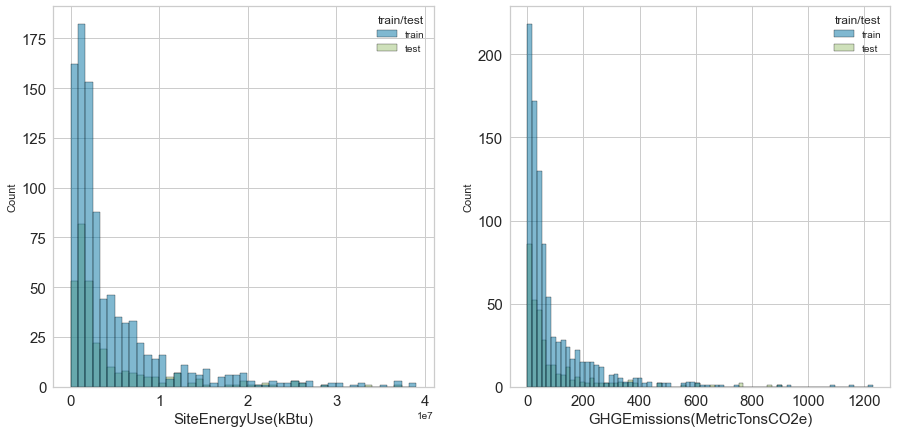

In [29]:
fig = plt.figure(figsize=(15,7))
compteur = 1
for target in ['SiteEnergyUse(kBtu)', 'GHGEmissions(MetricTonsCO2e)']:
    ax = fig.add_subplot(1,2, compteur)
    h = sns.histplot(x=target, data=data, hue='train/test')
    plt.tick_params(axis = 'both', labelsize = 15)
    myText = plt.xlabel(target)
    myText.set_fontsize(15)
    compteur += 1


### Baseline regression linéaire simple

In [30]:
start_time = timeit.default_timer()

model = make_pipeline(preprocessor, LinearRegression())

model.fit(X_train, y_train)
print(model.score(X_test, y_test))

elapsed = timeit.default_timer() - start_time

print(f'Temps d\'exécution : {elapsed:.2}s')

0.7941634514551189
Temps d'exécution : 0.034s


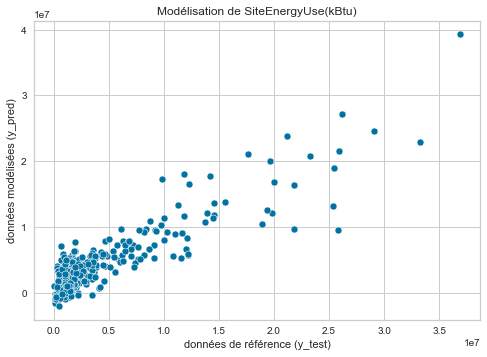

In [31]:
y_pred = model.predict(X_test)

sns.scatterplot(x=y_test, y=y_pred);
plt.xlabel('données de référence (y_test)')
plt.ylabel('données modélisées (y_pred)')
plt.title('Modélisation de SiteEnergyUse(kBtu)');

#### Visu

0.7941634514551189


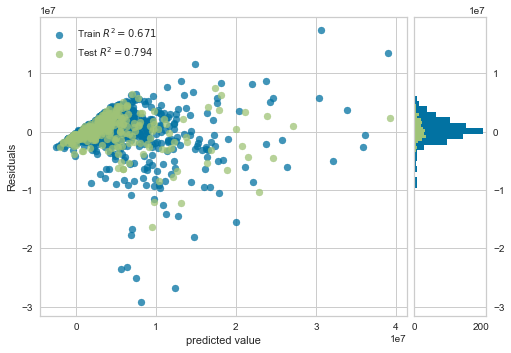

In [32]:
# visu des résidus du train_set et du test_set

model = make_pipeline(preprocessor, ResidualsPlot(LinearRegression()))

model.fit(X_train, y_train)
print(model.score(X_test, y_test))
plt.legend();
plt.xlabel('predicted value')
plt.ylabel('Residuals');

0.7941634514551189


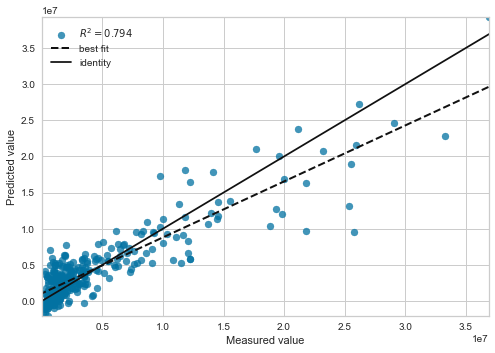

In [33]:
# visu des erreurs de prédiction
model = make_pipeline(preprocessor, PredictionError(LinearRegression()))

model.fit(X_train, y_train)
print(model.score(X_test, y_test))
plt.plot([0,4e7], [0,4e7], label='identity', c='k')
plt.legend();
plt.xlabel('Measured value')
plt.ylabel('Predicted value');

In [34]:
pd.DataFrame(np.column_stack([y_test, y_pred]), columns=['y_test', 'y_pred']).describe()

y_test        y_pred
count  3.160000e+02  3.160000e+02
mean   4.377049e+06  4.444800e+06
std    5.948314e+06  5.166886e+06
min    4.394300e+04 -2.034569e+06
25%    1.091298e+06  1.241306e+06
50%    1.957251e+06  3.234580e+06
75%    4.668552e+06  5.590245e+06
max    3.686335e+07  3.929135e+07

le modèle génère des valeurs négatives... => passage de la valeur cible en log pour être sur d'avoir une valeur positive à la fin ?

In [35]:
# calcul metriques
print("MSE : {:.2f}".format(metrics.mean_squared_error(y_test, y_pred)))
print("RMSE : {:.2f}".format(np.sqrt( metrics.mean_squared_error(y_test, y_pred) )))
# print("RMSLE : {:.2f}".format(metrics.mean_squared_log_error(y_test, y_pred)))
print("RSE : {:.2f}".format(1-metrics.r2_score(y_test, y_pred)))
print("R² : {:.2f}".format(metrics.r2_score(y_test, y_pred)))

MSE : 7259952687194.92
RMSE : 2694429.94
RSE : 0.21
R² : 0.79


In [36]:
baseline_error = metrics.mean_squared_error(y_test, y_pred)

In [37]:
resultat = initialisation_resultats(nom_baseline='linearregression', y_test=y_test, y_pred=y_pred)
resultat

y_test  linearregression
2      12051984.0      6.638562e+06
9      33270518.0      2.286747e+07
13      1388717.0      5.329196e+06
19       306721.0      4.120923e+06
31      6722886.0      7.774815e+06
...           ...               ...
MSE           NaN      7.259953e+12
RMSE          NaN      2.694430e+06
RMSLE         NaN               NaN
RSE           NaN      2.058365e-01
R²            NaN      7.941635e-01

[322 rows x 2 columns]

#### Investigation des valeurs négatives

In [38]:
resultat[resultat['linearregression'] < 0]

y_test  linearregression
335   1040593.0     -4.797147e+05
387   2210310.0     -2.754690e+05
478    451738.0     -1.671856e+05
528    474359.0     -2.463293e+05
543   1074937.0     -2.779458e+03
558    131810.0     -2.431100e+05
582    151376.0     -8.806070e+05
586    945063.0     -5.991045e+05
598    501194.0     -9.129777e+05
599    819378.0     -3.856687e+05
670    178243.0     -3.331085e+05
725    562617.0     -4.677828e+05
739    304248.0     -1.088278e+06
769    238255.0     -4.796502e+05
780    507947.0     -2.034569e+06
785    226375.0     -9.355506e+05
817    311939.0     -1.614928e+06
863    523133.0     -4.098101e+05
886   1004779.0     -9.607753e+05
906    610711.0     -7.218850e+05
913   1360340.0     -6.274004e+05
925    455153.0     -4.739162e+05
926    415975.0     -1.056098e+06
967   2254220.0     -1.066132e+04
977    207572.0     -6.942549e+05
991    744615.0     -2.249746e+05
1002   108795.0     -1.621263e+06
1051   429158.0     -6.605687e+05
1058  3456208.0     -2.798644e+05
1062   972608.0     -2.352137e+04
1077   349139.0     -4.726514e+03
1109   230365.0     -1.339050e+05
1115  1530744.0     -5.465235e+05
1162   463371.0     -2.377849e+05

In [39]:
data.loc[resultat[resultat['linearregression'] < 0].index].describe()

Unnamed: 0    YearBuilt  NumberofFloors  PropertyGFATotal  \
count    34.000000    34.000000       34.000000         34.000000   
mean   1716.176471  1945.558824        1.882353      30337.941176   
std     667.714758    26.202234        1.037617       9202.416741   
min     470.000000  1900.000000        1.000000      20520.000000   
25%    1106.250000  1925.500000        1.000000      23534.000000   
50%    1819.500000  1953.500000        2.000000      28850.500000   
75%    2195.500000  1965.000000        2.000000      33315.000000   
max    2865.000000  1989.000000        5.000000      56876.000000   

       PropertyGFAParking  ThirdLargestPropertyUseTypeGFA  ENERGYSTARScore  \
count           34.000000                         2.00000        20.000000   
mean           112.764706                      4158.00000        84.500000   
std            657.525575                        59.39697        11.843275   
min              0.000000                      4116.00000        55.000000   
25%              0.000000                      4137.00000        79.000000   
50%              0.000000                      4158.00000        88.000000   
75%              0.000000                      4179.00000        92.250000   
max           3834.000000                      4200.00000       100.000000   

       SiteEnergyUse(kBtu)  GHGEmissions(MetricTonsCO2e)  
count         3.400000e+01                     34.000000  
mean          7.425667e+05                     17.896765  
std           7.167161e+05                     19.547487  
min           1.087950e+05                      0.780000  
25%           3.061708e+05                      3.155000  
50%           4.877765e+05                      9.755000  
75%           9.657218e+05                     29.620000  
max           3.456208e+06                     67.620000

### Test pour améliorer le graphe des résidus
(frontière supérieure gauche qui semble influencée fortement par une variable)

----------------------------------------
**  PrimaryPropertyType  **
----------------------------------------
0.7914954385555754
Temps d'exécution : 0.032s
0.7914954385555754
----------------------------------------
**  YearBuilt  **
----------------------------------------
0.7981870080301783
Temps d'exécution : 0.031s
0.7981870080301783
----------------------------------------
**  NumberofFloors  **
----------------------------------------
0.7942418977935581
Temps d'exécution : 0.029s
0.7942418977935581
----------------------------------------
**  PropertyGFATotal  **
----------------------------------------
0.5388787177638157
Temps d'exécution : 0.045s
0.5388787177638157
----------------------------------------
**  PropertyGFAParking  **
----------------------------------------
0.7772393977543196
Temps d'exécution : 0.031s
0.7772393977543196
----------------------------------------
**  LargestPropertyUseType  **
----------------------------------------
0.7984105942975361
Temps d'exéc

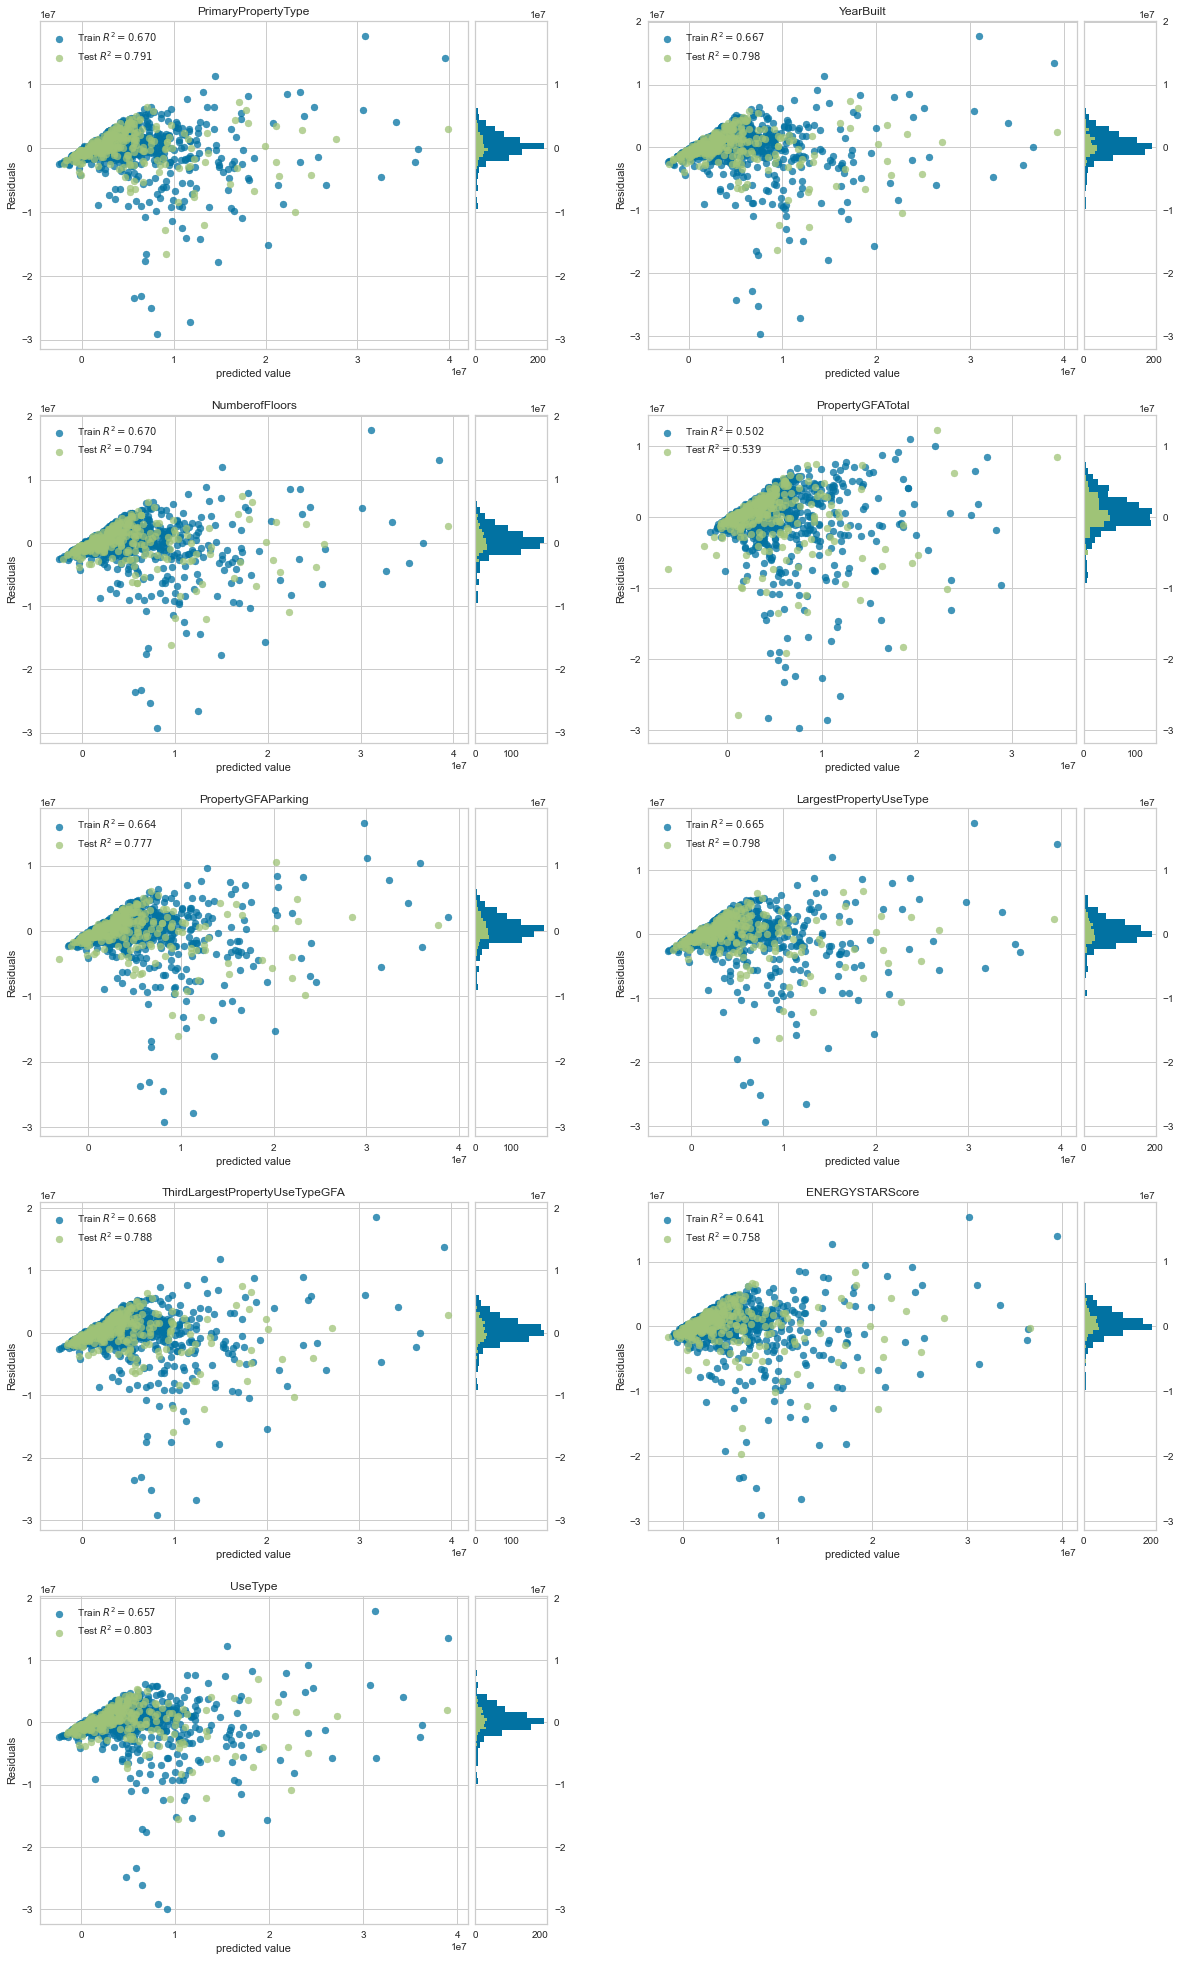

In [40]:
fig = plt.figure(figsize=(20, 35))
compteur = 1

for feature in data.columns:
    if feature in ['Unnamed: 0', 'SiteEnergyUse(kBtu)', 'GHGEmissions(MetricTonsCO2e)']:
        continue
    elif feature == 'ENERGYSTARScore':
        print("-"*40)
        print('** ', feature, ' **')
        print("-"*40)
        X = data.drop(['Unnamed: 0', 'SiteEnergyUse(kBtu)', 
               'GHGEmissions(MetricTonsCO2e)', 'train/test', feature], axis=1)
        y = data['SiteEnergyUse(kBtu)']

        X_quanti = X.select_dtypes(['float64', 'int64'])
        X_categ = X.select_dtypes(['object'])

        # selection des données en fonction des différents traitement à leur affecter
        X_quanti_GFA = list(X_quanti.filter(regex='GFA').columns)
        X_quanti_others = list(X_quanti.drop(X_quanti_GFA, axis=1).columns)

        X_categ = list(X_categ.columns)
        
        # mise en place des pipelines pour les données quantitatives
        GFA_pipeline = make_pipeline(SimpleImputer(strategy='constant', fill_value=0), StandardScaler())
        Other_quanti_pipeline = make_pipeline(StandardScaler())

        categ_pipeline = make_pipeline(SimpleImputer(strategy='constant', fill_value='None'), OneHotEncoder())

        preprocessor = make_column_transformer((GFA_pipeline, X_quanti_GFA), 
                                       (Other_quanti_pipeline, X_quanti_others),
                                       (categ_pipeline, X_categ))
        
    else:
        print("-"*40)
        print('** ', feature, ' **')
        print("-"*40)
        X = data.drop(['Unnamed: 0', 'SiteEnergyUse(kBtu)', 
               'GHGEmissions(MetricTonsCO2e)', 'train/test', feature], axis=1)
        y = data['SiteEnergyUse(kBtu)']

        X_quanti = X.select_dtypes(['float64', 'int64'])
        X_categ = X.select_dtypes(['object'])

        # selection des données en fonction des différents traitement à leur affecter
        X_quanti_GFA = list(X_quanti.filter(regex='GFA').columns)
        X_quanti_ESS = ['ENERGYSTARScore']
        X_quanti_others = list(X_quanti.drop(X_quanti_GFA, axis=1).drop('ENERGYSTARScore', axis=1).columns)

        X_categ = list(X_categ.columns)
        
        # mise en place des pipelines pour les données quantitatives
        GFA_pipeline = make_pipeline(SimpleImputer(strategy='constant', fill_value=0), StandardScaler())
        ESS_pipeline = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())
        Other_quanti_pipeline = make_pipeline(StandardScaler())

        categ_pipeline = make_pipeline(SimpleImputer(strategy='constant', fill_value='None'), OneHotEncoder())

        preprocessor = make_column_transformer((GFA_pipeline, X_quanti_GFA), 
                                       (ESS_pipeline, X_quanti_ESS),
                                       (Other_quanti_pipeline, X_quanti_others),
                                       (categ_pipeline, X_categ))
    
    if feature in ['Unnamed: 0', 'SiteEnergyUse(kBtu)', 'GHGEmissions(MetricTonsCO2e)', 'train/test']:
        continue
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rs_opt)
        # modelisation
        start_time = timeit.default_timer()

        model = make_pipeline(preprocessor, LinearRegression())

        model.fit(X_train, y_train)
        print(model.score(X_test, y_test))

        elapsed = timeit.default_timer() - start_time

        print(f'Temps d\'exécution : {elapsed:.2}s')
        
        # visu des résidus du train_set et du test_set
        plt.subplot(5,2,compteur)
        model = make_pipeline(preprocessor, ResidualsPlot(LinearRegression()))


        model.fit(X_train, y_train)
        print(model.score(X_test, y_test))
        plt.legend();
        plt.title(feature)
        plt.xlabel('predicted value')
        plt.ylabel('Residuals');
        compteur += 1
    
        

Pas d'amélioration en retirant une par une chaque feature. Ce comportement ne vient donc pas d'une variable qui aurait plus d'influence que les autres sur la regression.

In [41]:
# réinitialisation du preprocessing
X = data.drop(['Unnamed: 0', 'SiteEnergyUse(kBtu)', 
               'GHGEmissions(MetricTonsCO2e)', 'train/test'], axis=1)
y = data['SiteEnergyUse(kBtu)']

X_quanti = X.select_dtypes(['float64', 'int64'])
X_categ = X.select_dtypes(['object'])

# selection des données en fonction des différents traitement à leur affecter
X_quanti_GFA = list(X_quanti.filter(regex='GFA').columns)
X_quanti_ESS = ['ENERGYSTARScore']
X_quanti_others = list(X_quanti.drop(X_quanti_GFA, axis=1).drop('ENERGYSTARScore', axis=1).columns)
X_categ = list(X_categ.columns)

# mise en place des pipelines pour les données quantitatives
GFA_pipeline = make_pipeline(SimpleImputer(strategy='constant', fill_value=0), StandardScaler())
ESS_pipeline = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())
Other_quanti_pipeline = make_pipeline(StandardScaler())
# et categorielles
categ_pipeline = make_pipeline(SimpleImputer(strategy='constant', fill_value='None'), OneHotEncoder())

preprocessor = make_column_transformer((GFA_pipeline, X_quanti_GFA), 
                                       (ESS_pipeline, X_quanti_ESS),
                                       (Other_quanti_pipeline, X_quanti_others),
                                       (categ_pipeline, X_categ))

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rs_opt)

### Regression RIDGE

In [42]:
# on va tester plusieurs valeurs de l'hyperparamètre alpha  pour trouver le coeff de régularisation adapté
n_alpha = 100
alphas = np.logspace(-5, 5, n_alpha)

#### A la mano

In [43]:
# teste de toutes les regressions ridges avec les valeurs de lambda
# on recupere les poids des différents coeff de regression associés + erreur quadratique

coefs = []
errors = []
for a in alphas:
    ridge = make_pipeline(preprocessor, Ridge(alpha=a))
    ridge.fit(X_train, y_train)
    coefs.append(ridge.named_steps['ridge'].coef_)
    errors.append([baseline_error, np.mean((ridge.predict(X_test) - y_test) ** 2)])

In [44]:
coefs_df = pd.DataFrame(coefs)
coefs_df

0              1              2             3              4   \
0   4.978935e+06 -889890.794729  429704.571843 -1.145710e+06  394737.902297   
1   4.979063e+06 -889740.169819  428588.138273 -1.146114e+06  394537.605580   
2   4.979341e+06 -889542.961288  425700.424587 -1.144648e+06  394698.755053   
3   4.979838e+06 -889740.551857  424483.617834 -1.146670e+06  392998.348003   
4   4.979367e+06 -889937.607045  428122.694236 -1.147620e+06  393105.823873   
..           ...            ...            ...           ...            ...   
95  1.023125e+05   60603.368153   28663.859051 -1.296583e+04   33195.430404   
96  8.188020e+04   48696.482559   23001.986210 -1.022996e+04   26620.031008   
97  6.540074e+04   39020.592107   18412.348978 -8.077614e+03   21296.763343   
98  5.215575e+04   31197.521068   14708.776506 -6.382338e+03   17005.571950   
99  4.154039e+04   24898.182939   11731.120198 -5.045667e+03   13558.247103   

               5              6             7              8              9   \
0   172714.812080 -275809.507616 -1.520554e+06  304216.912171 -912771.488703   
1   173060.548370 -275858.344905 -1.520644e+06  304355.299756 -912666.128755   
2   173413.632753 -275831.219061 -1.520693e+06  304336.283570 -912540.978442   
3   174964.104890 -275678.098511 -1.520479e+06  304101.441269 -913043.791693   
4   174175.321789 -275773.628877 -1.520519e+06  304242.215677 -912991.576655   
..            ...            ...           ...            ...            ...   
95   72072.129321     506.316503 -1.938723e+03    2257.266713   -2102.003468   
96   57768.533350     401.039921 -1.545497e+03    1805.751979   -1679.771809   
97   46198.966093     317.671103 -1.230586e+03    1441.856834   -1340.132700   
98   36879.022186     251.648876 -9.789131e+02    1149.556135   -1067.734553   
99   29395.984845     199.360394 -7.781172e+02     915.397824    -849.786496   

    ...             58             59            60            61  \
0   ... -915066.200726  276716.210262  2.182056e+06  1.453864e+06   
1   ... -915193.226557  276968.019395  2.182118e+06  1.453827e+06   
2   ... -915820.974010  276975.406469  2.182112e+06  1.453855e+06   
3   ... -916379.268713  276201.948880  2.181912e+06  1.453936e+06   
4   ... -915453.885918  276517.621387  2.182000e+06  1.453861e+06   
..  ...            ...            ...           ...           ...   
95  ...     787.139690    1242.092484  6.001006e+02  9.611055e+02   
96  ...     640.398594     968.117234  4.722093e+02  7.587831e+02   
97  ...     518.176164     756.741372  3.720391e+02  5.994463e+02   
98  ...     417.472313     592.978136  2.934313e+02  4.738368e+02   
99  ...     335.190461     465.625270  2.316401e+02  3.747267e+02   

               62            63             64             65            66  \
0  -231772.970759 -1.370089e+06  244817.188571 -231344.206279  1.793049e+06   
1  -231887.126244 -1.369939e+06  244405.311219 -231238.142940  1.792979e+06   
2  -231857.939962 -1.369961e+06  244518.499739 -231270.426679  1.792990e+06   
3  -231502.137503 -1.370343e+06  245716.342708 -231558.384671  1.793194e+06   
4  -231685.288477 -1.370148e+06  245076.871340 -231399.701463  1.793086e+06   
..            ...           ...            ...            ...           ...   
95    -513.898530 -2.656908e+02   -1780.911805    1362.362098  1.185503e+03   
96    -410.544815 -2.200773e+02   -1416.671369    1076.857471  9.382753e+02   
97    -327.454583 -1.805318e+02   -1126.074473     851.559658  7.427545e+02   
98    -260.844129 -1.469886e+02    -894.541921     673.655935  5.880847e+02   
99    -207.567521 -1.189856e+02    -710.267923     533.092552  4.656978e+02   

               67  
0  -996117.868089  
1  -996120.100113  
2  -996094.714572  
3  -996061.003660  
4  -996101.901089  
..            ...  
95   -3625.892815  
96   -2894.162537  
97   -2306.814518  
98   -1836.547585  
99   -1460.792635  

[100 rows x 68 columns]

In [45]:
errors_df = pd.DataFrame(errors, columns=['baseline_MSE', 'Ridge_MSE'])
errors_df

baseline_MSE     Ridge_MSE
0   7.259953e+12  7.211445e+12
1   7.259953e+12  7.211281e+12
2   7.259953e+12  7.211667e+12
3   7.259953e+12  7.210287e+12
4   7.259953e+12  7.210160e+12
..           ...           ...
95  7.259953e+12  3.337702e+13
96  7.259953e+12  3.377416e+13
97  7.259953e+12  3.409778e+13
98  7.259953e+12  3.436005e+13
99  7.259953e+12  3.457164e+13

[100 rows x 2 columns]

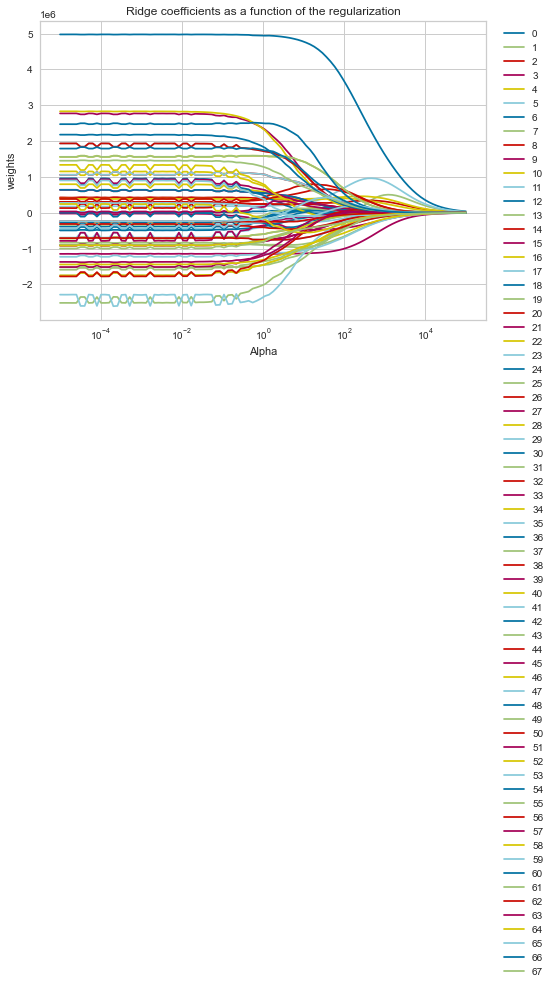

In [46]:
# affichage de l'évolution de la valeur des différents poids
# = chemin de regularisation

ax = plt.gca()

plot = ax.plot(alphas, coefs_df.values)
ax.set_xscale('log')
plt.xlabel('Alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.legend(plot, coefs_df.columns, bbox_to_anchor=(1.02, 1))
plt.show()

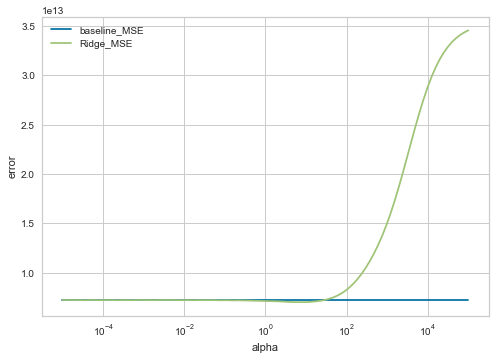

In [47]:
# erreur quadratique

ax = plt.gca()

plot = ax.plot(alphas, errors_df)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('error')
plt.axis('tight')
plt.legend(plot, errors_df.columns)
plt.show()

In [48]:
errors_df[errors_df['Ridge_MSE'] == min(errors_df['Ridge_MSE'])]

baseline_MSE     Ridge_MSE
58  7.259953e+12  7.000155e+12

In [49]:
alphas[58]

7.220809018385457

In [50]:
ridge = make_pipeline(preprocessor, Ridge(alpha=7))
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

# calcul metriques
print("MSE : {:.2f}".format(metrics.mean_squared_error(y_test, y_pred)))
print("RMSE : {:.2f}".format(np.sqrt( metrics.mean_squared_error(y_test, y_pred) )))
# print("RMSLE : {:.2f}".format(metrics.mean_squared_log_error(y_test, y_pred)))
print("RSE : {:.2f}".format(1-metrics.r2_score(y_test, y_pred)))
print("R² : {:.2f}".format(metrics.r2_score(y_test, y_pred)))

MSE : 6998407889860.76
RMSE : 2645450.41
RSE : 0.20
R² : 0.80


y_test        y_pred
count  3.160000e+02  3.160000e+02
mean   4.377049e+06  4.472871e+06
std    5.948314e+06  4.996464e+06
min    4.394300e+04 -1.485934e+06
25%    1.091298e+06  1.387942e+06
50%    1.957251e+06  3.260638e+06
75%    4.668552e+06  5.402242e+06
max    3.686335e+07  3.815071e+07

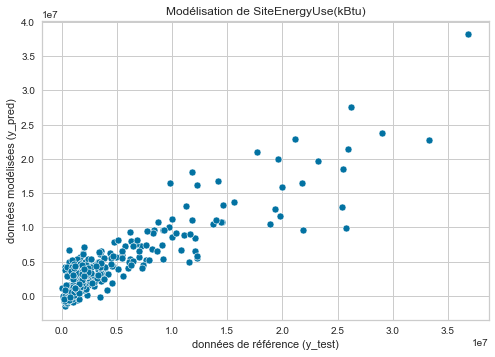

In [51]:
sns.scatterplot(x=y_test, y=y_pred);
plt.xlabel('données de référence (y_test)')
plt.ylabel('données modélisées (y_pred)')
plt.title('Modélisation de SiteEnergyUse(kBtu)');


pd.DataFrame(np.column_stack([y_test, y_pred]), columns=['y_test', 'y_pred']).describe()

#### Avec une crossvalidation

In [52]:
start_time = timeit.default_timer()

model = make_pipeline(preprocessor, Ridge())

score = 'neg_root_mean_squared_error'
alphas = range(0,100,5)

params = {'ridge__alpha':alphas}

grid_ridge = GridSearchCV(model, param_grid=params, cv=3, scoring=score)
grid_ridge.fit(X_train, y_train)

duree = Affichage_duree(start_time)

Temps d'exécution : 1.51s


In [53]:
best_RMSE = grid_ridge.best_score_
best_alpha = grid_ridge.best_params_.get('ridge__alpha')

print("alpha = {:.0f} permet d'obtenir la RMSE optimale de {:0.2f}".format(best_alpha, -best_RMSE))


alpha = 10 permet d'obtenir la RMSE optimale de 3688537.47


In [54]:
y_pred = grid_ridge.predict(X_test)

# calcul metriques
print("MSE : {:.2f}".format(metrics.mean_squared_error(y_test, y_pred)))
print("RMSE : {:.2f}".format(np.sqrt( metrics.mean_squared_error(y_test, y_pred) )))
# print("RMSLE : {:.2f}".format(metrics.mean_squared_log_error(y_test, y_pred)))
print("RSE : {:.2f}".format(1-metrics.r2_score(y_test, y_pred)))
print("R² : {:.2f}".format(metrics.r2_score(y_test, y_pred)))

MSE : 7005832511723.23
RMSE : 2646853.32
RSE : 0.20
R² : 0.80


y_test        y_pred
0     7613116.0  5.200124e+06
1      311939.0 -1.439435e+06
2     1781063.0  2.116043e+06
3    10020111.0  1.122953e+07
4     3542542.0  6.580281e+06
..          ...           ...
311    744615.0 -8.385808e+04
312  25764716.0  1.008496e+07
313   3087318.0  4.307661e+06
314   1176615.0  1.194329e+06
315    270004.0  9.200925e+05

[316 rows x 2 columns]

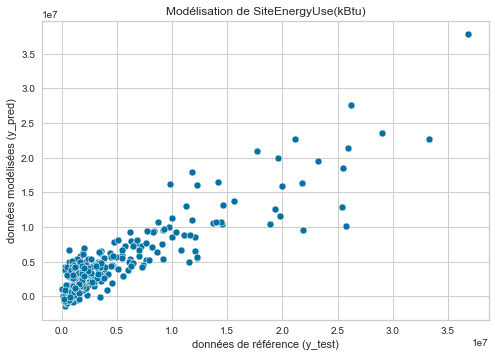

In [55]:
sns.scatterplot(x=y_test, y=y_pred);
plt.xlabel('données de référence (y_test)')
plt.ylabel('données modélisées (y_pred)')
plt.title('Modélisation de SiteEnergyUse(kBtu)');


pd.DataFrame(np.column_stack([y_test, y_pred]), columns=['y_test', 'y_pred'])

#### Visu

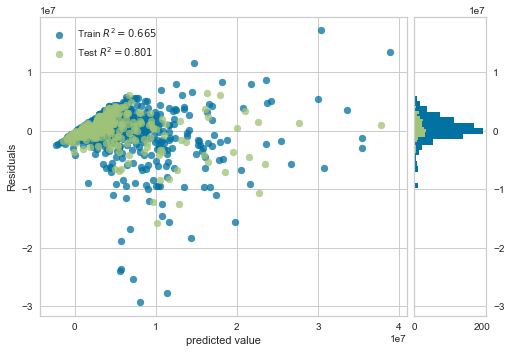

In [56]:
# visualisation des résidus
model = make_pipeline(preprocessor, ResidualsPlot(Ridge(alpha=best_alpha)))

model.fit(X_train, y_train)
ax = model.score(X_test, y_test)
plt.legend()
plt.xlabel('predicted value')
plt.ylabel('Residuals');

La distribution des résidus est centrée sur zero => un modèle linaire devrait être suffisant pout modéliser notre target. En moyenne on prédit des valeurs sans surestimer ou sous estimer la cible.

La prédiction des valeurs les plus faibles s'accompagne de résidus plus faibles. Plus la valeur prédite est grande, plus l'erreur grandie elle aussi. ==> modèle avec un bruit variable selon où l'on se situe.

La frontière supérieure gauche montre qu'il doit y avoir une variable avec un poid élevé dans cette région

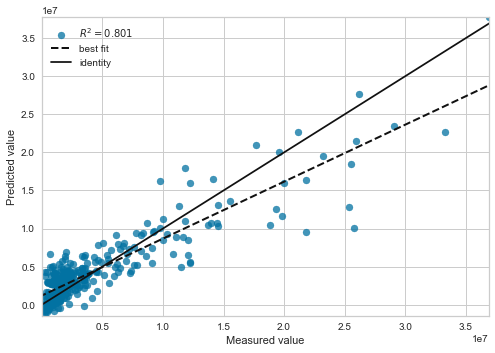

In [57]:
# visu des erreurs de prédiction
model = make_pipeline(preprocessor, PredictionError(Ridge(alpha=best_alpha)))

model.fit(X_train, y_train)
model.score(X_test, y_test)
plt.plot([0,4e7], [0,4e7], label='identity', c='k')
plt.legend();
plt.xlabel('Measured value')
plt.ylabel('Predicted value');

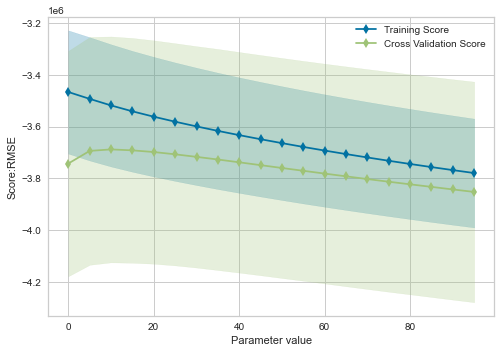

In [58]:
# validation curve

viz = make_pipeline(preprocessor, ValidationCurve(Ridge(),
                                                  param_name="alpha",
                                                  param_range=alphas,
                                                  cv=3,
                                                  scoring=score
                                                 )
                   )

# Fit and show the visualizer
viz.fit(X_train, y_train);
plt.legend();
plt.xlabel('Parameter value')
plt.ylabel('Score:RMSE');
# viz.show()

Il n'y a pas d'overfitting

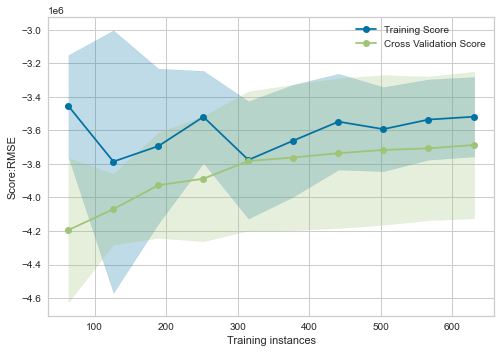

In [59]:
# Learning curve

sizes = np.linspace(0.1, 1.0, 10)

viz = make_pipeline(preprocessor, LearningCurve(Ridge(alpha=best_alpha),
                                                cv=3,
                                                train_sizes=sizes,
                                                scoring=score
                                                )
                   )

# Fit and show the visualizer
viz.fit(X_train, y_train);
plt.legend();
plt.xlabel('Training instances')
plt.ylabel('Score:RMSE');
# viz.show()

Il n'y a pas besoin de plus de données pour paramétrer la regression ridge

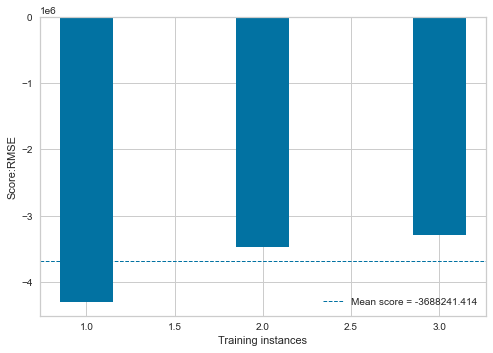

In [60]:
# visu impact de la crossvalidation

viz = make_pipeline(preprocessor, CVScores(Ridge(alpha=best_alpha),
                                            cv=3,
                                            scoring=score
                                            )
                   )

# Fit and show the visualizer
viz.fit(X_train, y_train);
plt.legend();
plt.xlabel('Training instances')
plt.ylabel('Score:RMSE');

In [61]:
# avec une autre métrique : r²
model = make_pipeline(preprocessor, Ridge())

params = {'ridge__alpha':alphas}

grid_ridge = GridSearchCV(model, param_grid=params, cv=5, scoring='r2')
grid_ridge.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(fill_value=0,
                                                                                                        strategy='constant')),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['PropertyGFATotal',
                                                                          'PropertyGFAParking',
                                                                        

In [62]:
best_r2 = grid_ridge.best_score_
best_alpha = grid_ridge.best_params_.get('ridge__alpha')

print("alpha = {:.0f} permet d'obtenir le r2 optimal de {:0.2f}".format(best_alpha, best_r2))


alpha = 15 permet d'obtenir le r2 optimal de 0.62


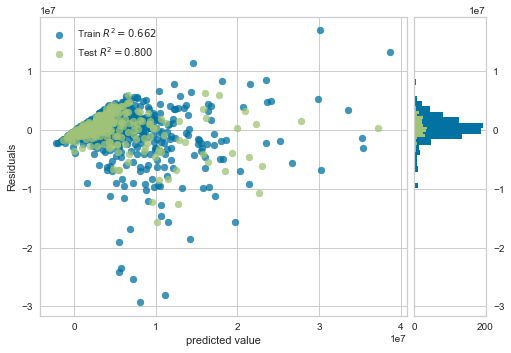

In [63]:
# visualisation des résidus
model = make_pipeline(preprocessor, ResidualsPlot(Ridge(alpha=best_alpha)))

model.fit(X_train, y_train)
model.score(X_test, y_test)
plt.legend();
plt.xlabel('predicted value')
plt.ylabel('Residuals');

La distribution des résidus est centrée sur zero => un modèle linaire devrait être suffisant pout modéliser notre target. En moyenne on prédit des valeurs sans surestimer ou sous estimer la cible.

La prédiction des valeurs les plus faibles s'accompagne de résidus plus faibles. Plus la valeur prédite est grande, plus l'erreur grandie elle aussi. ==> modèle avec un bruit variable selon où l'on se situe.

La frontière supérieure gauche montre qu'il doit y avoir une variable avec un poid élevé dans cette région


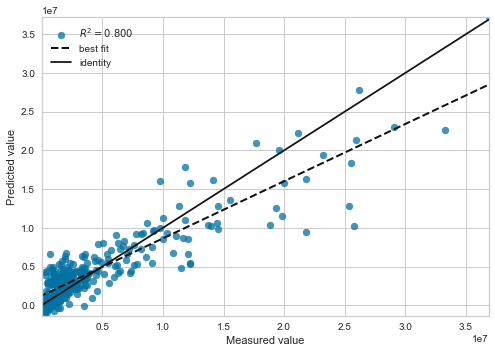

In [64]:
# visu des erreurs de prédiction
model = make_pipeline(preprocessor, PredictionError(Ridge(alpha=best_alpha)))

model.fit(X_train, y_train)
model.score(X_test, y_test)
plt.plot([0,4e7], [0,4e7], label='identity', c='k')
plt.legend();
plt.xlabel('Measured value')
plt.ylabel('Predicted value');

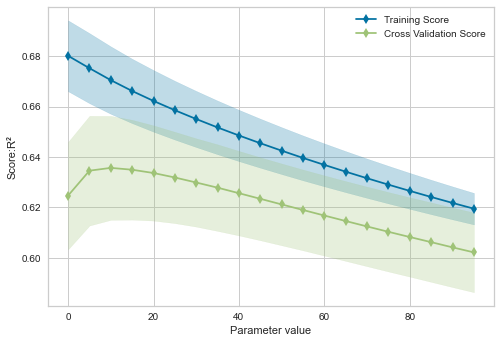

In [65]:
# validation curve
viz = make_pipeline(preprocessor, ValidationCurve(Ridge(),
                                                  param_name="alpha",
                                                  param_range=alphas,
                                                  cv=3,
                                                  scoring='r2'
                                                 )
                   )

# Fit and show the visualizer
viz.fit(X_train, y_train);
plt.legend();
plt.xlabel('Parameter value')
plt.ylabel('Score:R²');
# viz.show()

On visualise bien qu'il ne faut pas utiliser un alpha supérieur à 15 car sinon les modèles se mettent à underfiter.

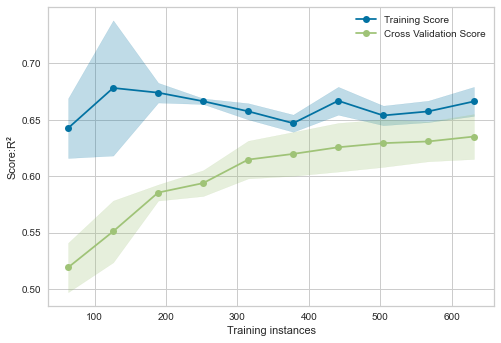

In [66]:
# Learning curve
sizes = np.linspace(0.1, 1.0, 10)

viz = make_pipeline(preprocessor, LearningCurve(Ridge(alpha=best_alpha),
                                                cv=3,
                                                train_sizes=sizes,
                                                scoring='r2'
                                                )
                   )

# Fit and show the visualizer
viz.fit(X_train, y_train);
plt.legend();
plt.xlabel('Training instances')
plt.ylabel('Score:R²');
# viz.show()

Il n'y a pas besoin de plus de données pour qualibrer le modèle

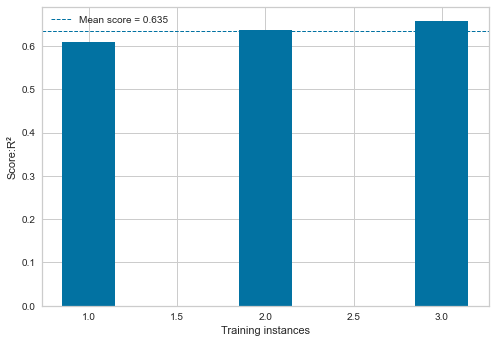

In [67]:
# visu impact de la crossvalidation
viz = make_pipeline(preprocessor, CVScores(Ridge(alpha=best_alpha),
                                            cv=3,
                                            scoring='r2'
                                            )
                   )

# Fit and show the visualizer
viz.fit(X_train, y_train);
plt.legend();
plt.xlabel('Training instances')
plt.ylabel('Score:R²');

#### En utilisant la fonction mise au point

Temps d'exécution : 2.81s
Durée du gridSearchCV :  2.8136824999999988
MSE : 7055902963292.62
RMSE : 7055902963292.62
RMSLE : nan
RSE : 0.20
R² : 0.80


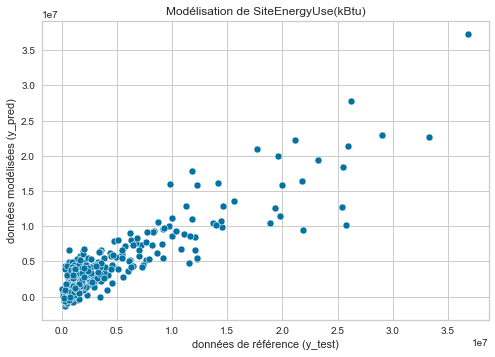

In [68]:
resultat = Test_modele_GSCV(nom_run='ridge',
                            model=Ridge(), 
                            grid_params=params, 
                            cv=5, 
                            score=score, 
                            pipe_preprocessing=preprocessor,
                            X_train=X_train,
                            y_train=y_train,
                            X_test=X_test,
                            y_test=y_test, 
                            resultat=resultat
                           )

In [69]:
resultat.tail(10)

y_test  linearregression         ridge
1249              2401148.0      4.067208e+06  4.060936e+06
1253               650313.0      7.050228e+06  6.595886e+06
1254              6125692.0      9.692813e+06  9.086883e+06
Duree calcul (s)        NaN      3.369910e-02  1.799965e-02
MSE                     NaN      7.259953e+12  7.055903e+12
RMSE                    NaN      2.694430e+06  2.656295e+06
RMSLE                   NaN               NaN           NaN
RSE                     NaN      2.058365e-01  2.000513e-01
R²                      NaN      7.941635e-01  7.999487e-01
ridge__alpha            NaN               NaN  1.500000e+01

#### Investigation des valeurs négatives

In [70]:
resultat[resultat['ridge'] < 0]

y_test  linearregression         ridge
582    151376.0     -8.806070e+05 -6.438975e+05
586    945063.0     -5.991045e+05 -1.451483e+05
598    501194.0     -9.129777e+05 -5.275766e+05
670    178243.0     -3.331085e+05 -1.438701e+05
725    562617.0     -4.677828e+05 -2.424435e+05
739    304248.0     -1.088278e+06 -8.733076e+05
769    238255.0     -4.796502e+05 -3.483585e+05
780    507947.0     -2.034569e+06 -1.113617e+05
785    226375.0     -9.355506e+05 -6.532888e+05
817    311939.0     -1.614928e+06 -1.352792e+06
863    523133.0     -4.098101e+05 -1.960666e+05
886   1004779.0     -9.607753e+05 -7.325021e+05
906    610711.0     -7.218850e+05 -4.945959e+05
913   1360340.0     -6.274004e+05 -4.068909e+05
925    455153.0     -4.739162e+05 -2.894907e+05
926    415975.0     -1.056098e+06 -8.615522e+05
977    207572.0     -6.942549e+05 -2.192960e+05
991    744615.0     -2.249746e+05 -1.987362e+04
1051   429158.0     -6.605687e+05 -1.920269e+05
1058  3456208.0     -2.798644e+05 -4.604405e+04
1115  1530744.0     -5.465235e+05 -3.020508e+05
1162   463371.0     -2.377849e+05 -1.114592e+05

In [71]:
data.loc[resultat[resultat['ridge'] < 0].index].describe()

Unnamed: 0    YearBuilt  NumberofFloors  PropertyGFATotal  \
count    22.000000    22.000000       22.000000         22.000000   
mean   1853.318182  1948.772727        1.636364      29219.954545   
std     511.901998    22.928319        0.789542       7372.681870   
min    1043.000000  1903.000000        1.000000      20520.000000   
25%    1504.250000  1927.250000        1.000000      22249.000000   
50%    1953.500000  1953.500000        1.500000      27074.500000   
75%    2140.750000  1964.500000        2.000000      35658.000000   
max    2865.000000  1989.000000        4.000000      42500.000000   

       PropertyGFAParking  ThirdLargestPropertyUseTypeGFA  ENERGYSTARScore  \
count                22.0                             0.0        14.000000   
mean                  0.0                             NaN        85.357143   
std                   0.0                             NaN        12.351313   
min                   0.0                             NaN        55.000000   
25%                   0.0                             NaN        80.750000   
50%                   0.0                             NaN        88.000000   
75%                   0.0                             NaN        93.500000   
max                   0.0                             NaN       100.000000   

       SiteEnergyUse(kBtu)  GHGEmissions(MetricTonsCO2e)  
count         2.200000e+01                     22.000000  
mean          6.876825e+05                     17.552273  
std           7.184446e+05                     18.371930  
min           1.513760e+05                      1.060000  
25%           3.061708e+05                      3.250000  
50%           4.822825e+05                     12.475000  
75%           7.111390e+05                     23.415000  
max           3.456208e+06                     67.620000

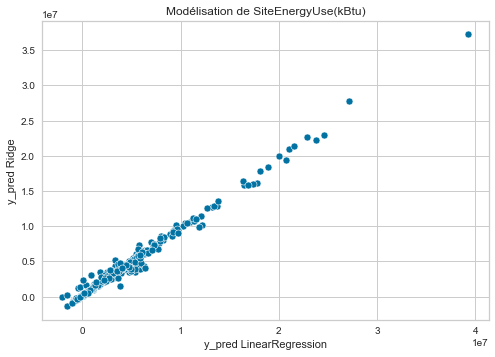

In [72]:
# graphe y_pred LinearRegression vs y_pred ridge
sns.scatterplot(x='linearregression', y='ridge', data=resultat.iloc[:316,:]);
plt.xlabel('y_pred LinearRegression')
plt.ylabel('y_pred Ridge')
plt.title('Modélisation de SiteEnergyUse(kBtu)');

In [73]:
for model in resultat.columns:
    resultat.loc['nb valeurs negatives', model] = np.sum(resultat.loc[:1254,model] < 0)
resultat.loc['nb valeurs negatives']

y_test               0.0
linearregression    34.0
ridge               22.0
Name: nb valeurs negatives, dtype: float64

### Regression LASSO

#### A la mano

In [74]:
start = timeit.default_timer()

# on va tester plusieurs valeurs de l'hyperparamètre alpha  pour trouver le coeff de régularisation adapté
n_alphas = 50
alphas = np.logspace(-1, 7, n_alphas)

coefs = []
errors = []
for a in alphas:
    lasso = make_pipeline(preprocessor, Lasso(alpha=a, tol=1e-3, max_iter=1e4, fit_intercept=False))
    lasso.fit(X_train, y_train)
    coefs.append(lasso.named_steps['lasso'].coef_)
    errors.append([baseline_error, np.mean((lasso.predict(X_test) - y_test) ** 2)])

duree = Affichage_duree(start)

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 615415819578165.0, tolerance: 57030464878566.69
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 615419469827361.0, tolerance: 57030464878566.69
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 615424778632157.0, tolerance: 57030464878566.69
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.

Temps d'exécution : 14.50s


In [75]:
coefs_df = pd.DataFrame(coefs)
coefs_df

0              1              2             3              4   \
0   4.979948e+06 -895967.956738  422413.849714 -1.145548e+06  394049.610572   
1   4.979948e+06 -895967.738239  422412.713310 -1.145548e+06  394049.132079   
2   4.979947e+06 -895967.420028  422411.058309 -1.145547e+06  394048.435227   
3   4.979946e+06 -895966.956602  422408.648050 -1.145547e+06  394047.420367   
4   4.979945e+06 -895966.281692  422405.137874 -1.145547e+06  394045.942378   
5   4.979944e+06 -895965.298789  422400.025835 -1.145547e+06  394043.789910   
6   4.979941e+06 -895963.867339  422392.580924 -1.145546e+06  394040.655167   
7   4.979938e+06 -895963.073980  422383.113435 -1.145546e+06  394034.649397   
8   4.979933e+06 -895961.898919  422367.007720 -1.145547e+06  394029.201096   
9   4.979926e+06 -895958.915943  422344.495042 -1.145546e+06  394019.408769   
10  4.979915e+06 -895954.571691  422311.708739 -1.145546e+06  394005.147729   
11  4.979894e+06 -895957.428252  422226.390367 -1.145523e+06  394005.819915   
12  4.979870e+06 -895959.124790  422173.796670 -1.145510e+06  393976.250686   
13  4.979834e+06 -895954.875853  422063.112397 -1.145492e+06  393942.294517   
14  4.979782e+06 -895948.687913  421901.917552 -1.145467e+06  393892.842505   
15  4.979750e+06 -896107.912064  421699.058784 -1.145441e+06  393825.008069   
16  4.979659e+06 -896171.713077  421371.754424 -1.145392e+06  393722.035742   
17  4.979528e+06 -896267.428882  420895.563005 -1.145322e+06  393572.131012   
18  4.979337e+06 -896409.274225  420202.480030 -1.145219e+06  393353.869101   
19  4.979060e+06 -896617.424650  419193.377640 -1.145069e+06  393036.036964   
20  4.978612e+06 -896817.629747  417689.136249 -1.144867e+06  392568.261917   
21  4.977952e+06 -896974.352940  415516.971906 -1.144513e+06  391890.999539   
22  4.976798e+06 -896962.079716  412344.049506 -1.144109e+06  390961.426220   
23  4.975420e+06 -897576.622467  408206.994065 -1.143757e+06  389649.949362   
24  4.972414e+06 -895652.588521  401422.171141 -1.142893e+06  387636.309544   
25  4.971519e+06 -900989.876794  393968.201815 -1.143332e+06  385130.366777   
26  4.968252e+06 -904328.548676  382912.621847 -1.143354e+06  381595.621388   
27  4.965712e+06 -910481.113215  368898.834559 -1.144483e+06  376791.865729   
28  4.961523e+06 -916454.824502  349977.690029 -1.145064e+06  371525.412874   
29  4.958919e+06 -928997.397221  322520.321300 -1.146322e+06  365852.897574   
30  4.954638e+06 -947549.180424  284374.159037 -1.148298e+06  357936.492618   
31  4.952585e+06 -971855.904375  240783.215457 -1.153106e+06  349334.989780   
32  4.940784e+06 -964452.429518  188568.063812 -1.158271e+06  346976.376165   
33  4.930924e+06 -964104.186699  111852.191224 -1.162775e+06  340635.986183   
34  4.921096e+06 -940917.930421   19088.639157 -1.170427e+06  327577.814584   
35  4.902057e+06 -899041.762926      -0.000000 -1.189948e+06  330316.319334   
36  4.854778e+06 -826244.052425      -0.000000 -1.220481e+06  346695.672679   
37  4.748087e+06 -695036.546199   -4272.697261 -1.230070e+06  347262.005135   
38  4.566828e+06 -566045.446800      -0.000000 -1.202575e+06  336887.728899   
39  4.334202e+06 -391253.238206      -0.000000 -1.140948e+06  322885.797506   
40  3.978690e+06      -0.000000      -0.000000 -9.624316e+05  191314.372710   
41  3.837073e+06      -0.000000      -0.000000 -7.483086e+05   64353.152509   
42  3.609856e+06       0.000000       0.000000 -4.283569e+05       0.000000   
43  3.287242e+06       0.000000       0.000000 -0.000000e+00       0.000000   
44  2.946270e+06       0.000000       0.000000 -0.000000e+00       0.000000   
45  2.249691e+06       0.000000       0.000000 -0.000000e+00       0.000000   
46  1.235230e+06       0.000000       0.000000 -0.000000e+00       0.000000   
47  0.000000e+00       0.000000       0.000000 -0.000000e+00       0.000000   
48  0.000000e+00       0.000000       0.000000 -0.000000e+00       0.000000   
49  0.000000e+00       0.000000       0.000000 -0.000000e+00    

In [76]:
errors_df = pd.DataFrame(errors, columns=['baseline_MSE', 'lasso_MSE'])
errors_df

baseline_MSE     lasso_MSE
0   7.259953e+12  7.223553e+12
1   7.259953e+12  7.224171e+12
2   7.259953e+12  7.225074e+12
3   7.259953e+12  7.226397e+12
4   7.259953e+12  7.228342e+12
5   7.259953e+12  7.231210e+12
6   7.259953e+12  7.235464e+12
7   7.259953e+12  7.241637e+12
8   7.259953e+12  7.247320e+12
9   7.259953e+12  7.246128e+12
10  7.259953e+12  7.244401e+12
11  7.259953e+12  7.239960e+12
12  7.259953e+12  7.233191e+12
13  7.259953e+12  7.228145e+12
14  7.259953e+12  7.220987e+12
15  7.259953e+12  7.213926e+12
16  7.259953e+12  7.212323e+12
17  7.259953e+12  7.210009e+12
18  7.259953e+12  7.206688e+12
19  7.259953e+12  7.201962e+12
20  7.259953e+12  7.195553e+12
21  7.259953e+12  7.186873e+12
22  7.259953e+12  7.179042e+12
23  7.259953e+12  7.169575e+12
24  7.259953e+12  7.161500e+12
25  7.259953e+12  7.139775e+12
26  7.259953e+12  7.120747e+12
27  7.259953e+12  7.108786e+12
28  7.259953e+12  7.107530e+12
29  7.259953e+12  7.105031e+12
30  7.259953e+12  7.122930e+12
31  7.259953e+12  7.199098e+12
32  7.259953e+12  7.394776e+12
33  7.259953e+12  7.773706e+12
34  7.259953e+12  8.402034e+12
35  7.259953e+12  9.097329e+12
36  7.259953e+12  9.831610e+12
37  7.259953e+12  1.097906e+13
38  7.259953e+12  1.268868e+13
39  7.259953e+12  1.563925e+13
40  7.259953e+12  1.703988e+13
41  7.259953e+12  1.867876e+13
42  7.259953e+12  2.201567e+13
43  7.259953e+12  2.818191e+13
44  7.259953e+12  3.476811e+13
45  7.259953e+12  3.803093e+13
46  7.259953e+12  4.431744e+13
47  7.259953e+12  5.442903e+13
48  7.259953e+12  5.442903e+13
49  7.259953e+12  5.442903e+13

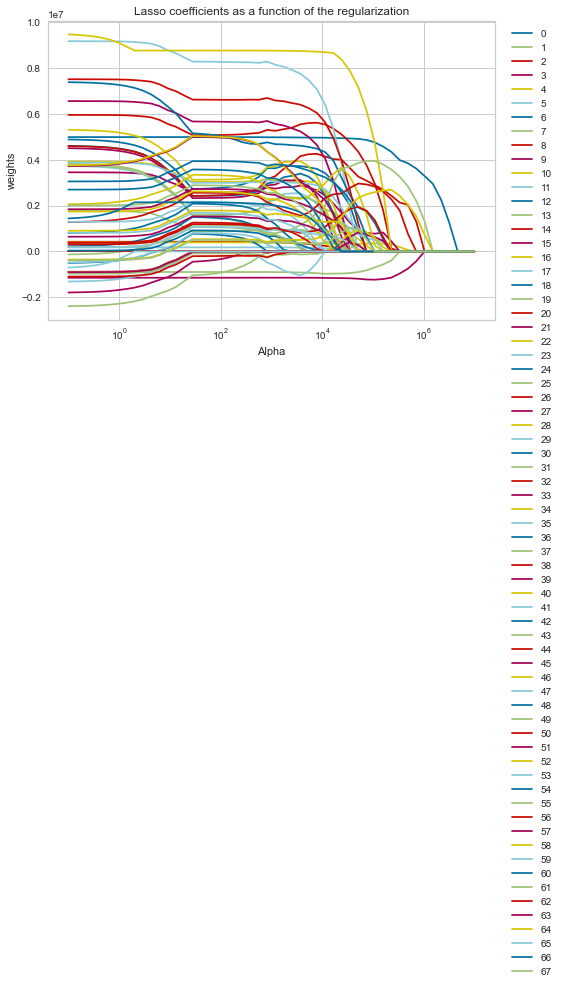

In [77]:
# affichage de l'évolution de la valeur des différents poids
# = chemin de regularisation

ax = plt.gca()

plot = ax.plot(alphas, coefs_df.values)
ax.set_xscale('log')
plt.xlabel('Alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization')
plt.axis('tight')
plt.legend(plot, coefs_df.columns, bbox_to_anchor=(1.02, 1))
plt.show()

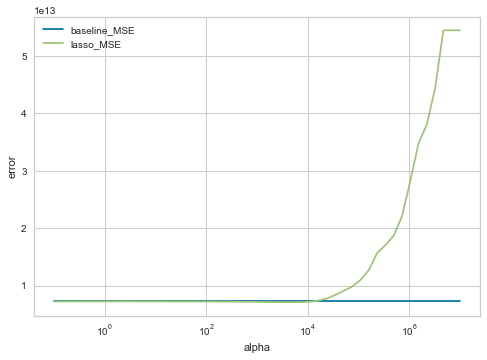

In [78]:
# erreur quadratique

ax = plt.gca()

plot = ax.plot(alphas, errors_df)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('error')
plt.axis('tight')
plt.legend(plot, errors_df.columns)
plt.show()

In [79]:
errors_df[errors_df['lasso_MSE'] == min(errors_df['lasso_MSE'])]

baseline_MSE     lasso_MSE
29  7.259953e+12  7.105031e+12

In [80]:
alphas[29]

5428.67543932386

In [81]:
lasso = make_pipeline(preprocessor, Lasso(alpha=5429))
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)

# calcul metriques
print("MSE : {:.2f}".format(metrics.mean_squared_error(y_test, y_pred)))
print("RMSE : {:.2f}".format(np.sqrt( metrics.mean_squared_error(y_test, y_pred) )))
# print("RMSLE : {:.2f}".format(metrics.mean_squared_log_error(y_test, y_pred)))
print("RSE : {:.2f}".format(1-metrics.r2_score(y_test, y_pred)))
print("R² : {:.2f}".format(metrics.r2_score(y_test, y_pred)))

MSE : 7082140256754.57
RMSE : 2661229.09
RSE : 0.20
R² : 0.80


y_test        y_pred
count  3.160000e+02  3.160000e+02
mean   4.377049e+06  4.462982e+06
std    5.948314e+06  5.052054e+06
min    4.394300e+04 -1.540910e+06
25%    1.091298e+06  1.326978e+06
50%    1.957251e+06  3.244400e+06
75%    4.668552e+06  5.519898e+06
max    3.686335e+07  3.887728e+07

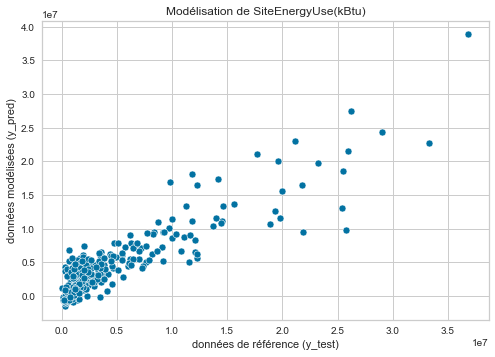

In [82]:
sns.scatterplot(x=y_test, y=y_pred);
plt.xlabel('données de référence (y_test)')
plt.ylabel('données modélisées (y_pred)')
plt.title('Modélisation de SiteEnergyUse(kBtu)');

pd.DataFrame(np.column_stack([y_test, y_pred]), columns=['y_test', 'y_pred']).describe()

#### Avec une crossvalidation

In [83]:
start_time = timeit.default_timer()
score = 'neg_root_mean_squared_error'
n_alphas = 50
alphas = np.logspace(0, 5, n_alphas)

model = make_pipeline(preprocessor, Lasso())

params = {'lasso__alpha':alphas}

grid_lasso = GridSearchCV(model, param_grid=params, cv=2, scoring=score)
grid_lasso.fit(X_train, y_train)

duree = Affichage_duree(start_time)

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 636058868323035.0, tolerance: 1584377907784.6055
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1257654108109082.5, tolerance: 1977353760351.3958
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 229009574916838.5, tolerance: 1584377907784.6055
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_desc

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 128947645878640.0, tolerance: 1977353760351.3958
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 121689979602593.0, tolerance: 1584377907784.6055
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 115377017845118.0, tolerance: 1977353760351.3958
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_desce

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3324167210675.0, tolerance: 1977353760351.3958
  model = cd_fast.sparse_enet_coordinate_descent(


Temps d'exécution : 8.85s


In [84]:
best_RMSE = grid_lasso.best_score_
best_alpha = grid_lasso.best_params_.get('lasso__alpha')

print("alpha = {:.0f} permet d'obtenir la RMSE optimale de {:0.2f}".format(best_alpha, -best_RMSE))

alpha = 49417 permet d'obtenir la RMSE optimale de 3796105.25


In [85]:
y_pred = grid_lasso.predict(X_test)

# calcul metriques
print("MSE : {:.2f}".format(metrics.mean_squared_error(y_test, y_pred)))
print("RMSE : {:.2f}".format(np.sqrt( metrics.mean_squared_error(y_test, y_pred) )))
# print("RMSLE : {:.2f}".format(metrics.mean_squared_log_error(y_test, y_pred)))
print("RSE : {:.2f}".format(1-metrics.r2_score(y_test, y_pred)))
print("R² : {:.2f}".format(metrics.r2_score(y_test, y_pred)))

MSE : 7609199160200.88
RMSE : 2758477.69
RSE : 0.22
R² : 0.78


y_test        y_pred
0     7613116.0  5.100463e+06
1      311939.0 -1.069512e+06
2     1781063.0  2.058938e+06
3    10020111.0  1.135999e+07
4     3542542.0  5.487943e+06
..          ...           ...
311    744615.0  3.473515e+05
312  25764716.0  9.886448e+06
313   3087318.0  4.548493e+06
314   1176615.0  1.854705e+06
315    270004.0  1.074593e+06

[316 rows x 2 columns]

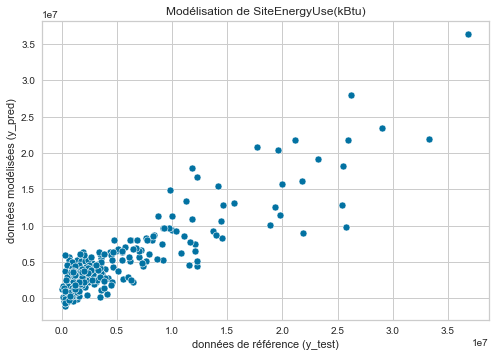

In [86]:
sns.scatterplot(x=y_test, y=y_pred);
plt.xlabel('données de référence (y_test)')
plt.ylabel('données modélisées (y_pred)')
plt.title('Modélisation de SiteEnergyUse(kBtu)');


pd.DataFrame(np.column_stack([y_test, y_pred]), columns=['y_test', 'y_pred'])

#### Visu

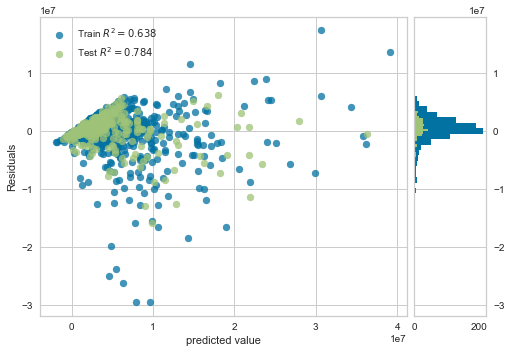

In [87]:
# visualisation des résidus
model = make_pipeline(preprocessor, ResidualsPlot(Lasso(alpha=best_alpha)))

model.fit(X_train, y_train)
ax = model.score(X_test, y_test)
plt.legend()
plt.xlabel('predicted value')
plt.ylabel('Residuals');

La distribution des résidus est centrée sur zero => un modèle linaire devrait être suffisant pout modéliser notre target. En moyenne on prédit des valeurs sans surestimer ou sous estimer la cible.

La prédiction des valeurs les plus faibles s'accompagne de résidus plus faibles puis avec des résidus fortements négatifs. Plus la valeur prédite est grande, plus l'erreur grandie elle aussi et les résidus deviennent positifs.

La frontière supérieure gauche montre qu'il doit y avoir une variable avec un poid élevé dans cette région

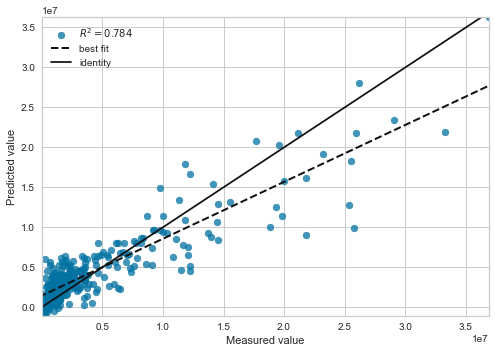

In [88]:
# visu des erreurs de prédiction

model = make_pipeline(preprocessor, PredictionError(Lasso(alpha=best_alpha)))

model.fit(X_train, y_train)
model.score(X_test, y_test)
plt.plot([0,4e7], [0,4e7], label='identity', c='k')
plt.legend();
plt.xlabel('Measured value')
plt.ylabel('Predicted value');

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 643726891286937.0, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 436586032934647.0, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 436621003758142.5, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_desce

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 940788407152191.5, tolerance: 2510126897112.0713
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 938231297831131.5, tolerance: 2510126897112.0713
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 938258966684467.5, tolerance: 2510126897112.0713
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_desce

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 262185580131040.0, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 280602665047887.0, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 280682465959445.0, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_desce

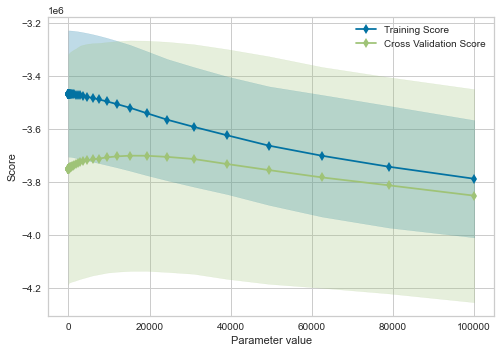

In [89]:
# validation curve
viz = make_pipeline(preprocessor, ValidationCurve(Lasso(),
                                                  param_name="alpha",
                                                  param_range=alphas,
                                                  cv=3,
                                                  scoring=score
                                                 )
                   )

# Fit and show the visualizer
viz.fit(X_train, y_train);
plt.legend();
plt.xlabel('Parameter value')
plt.ylabel('Score');
# viz.show()

On visualise bien la valeur de alpha a partir de laquel il n'y a pas d'amélioration du modèle.

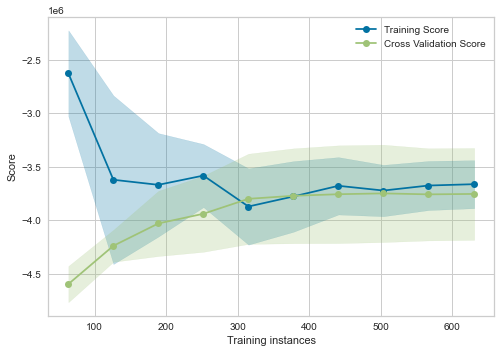

In [90]:
# Learning curve
sizes = np.linspace(0.1, 1.0, 10)

viz = make_pipeline(preprocessor, LearningCurve(Lasso(alpha=best_alpha),
                                                cv=3,
                                                train_sizes=sizes,
                                                scoring=score
                                                )
                   )

# Fit and show the visualizer
viz.fit(X_train, y_train);
plt.legend();
plt.xlabel('Training instances')
plt.ylabel('Score');
# viz.show()

Il n'y a pas besoin de données supplémentaires pour caler le modèle

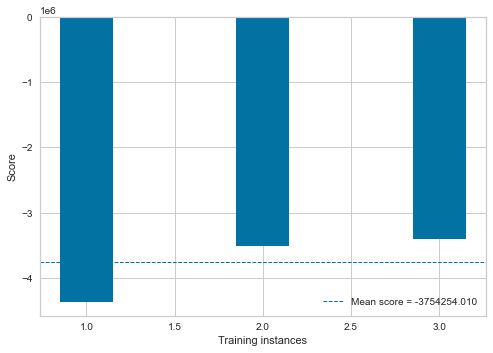

In [91]:
# visu impact de la crossvalidation
viz = make_pipeline(preprocessor, CVScores(Lasso(alpha=best_alpha),
                                            cv=3,
                                            scoring=score
                                            )
                   )

# Fit and show the visualizer
viz.fit(X_train, y_train);
plt.legend();
plt.xlabel('Training instances')
plt.ylabel('Score');

#### Avec la fonction mise au point

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 636058868323035.0, tolerance: 1584377907784.6055
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1257654108109082.5, tolerance: 1977353760351.3958
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 229009574916838.5, tolerance: 1584377907784.6055
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_desc

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 121689979602593.0, tolerance: 1584377907784.6055
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 115377017845118.0, tolerance: 1977353760351.3958
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 114327030401775.5, tolerance: 1584377907784.6055
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_desce

Temps d'exécution : 9.27s
Durée du gridSearchCV :  9.268850900000004
MSE : 7609199160200.88
RMSE : 7609199160200.88
RMSLE : nan
RSE : 0.22
R² : 0.78


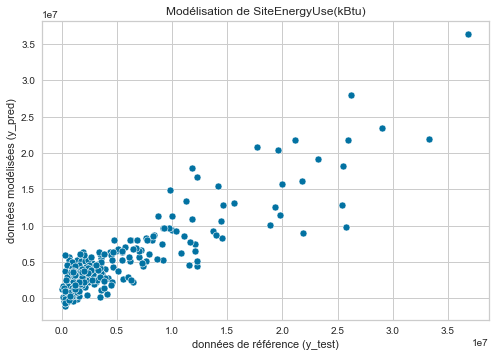

In [92]:
resultat = Test_modele_GSCV(nom_run='lasso',
                            model=Lasso(), 
                            grid_params=params, 
                            cv=2, 
                            score=score, 
                            pipe_preprocessing=preprocessor,
                            X_train=X_train,
                            y_train=y_train,
                            X_test=X_test,
                            y_test=y_test, 
                            resultat=resultat
                           )

In [93]:
resultat

y_test  linearregression         ridge         lasso
2                     12051984.0      6.638562e+06  6.604160e+06  6.489547e+06
9                     33270518.0      2.286747e+07  2.260517e+07  2.191556e+07
13                     1388717.0      5.329196e+06  5.318136e+06  5.269499e+06
19                      306721.0      4.120923e+06  4.325095e+06  6.031394e+06
31                     6722886.0      7.774815e+06  7.666863e+06  6.942385e+06
...                          ...               ...           ...           ...
RSE                          NaN      2.058365e-01  2.000513e-01  2.157385e-01
R²                           NaN      7.941635e-01  7.999487e-01  7.842615e-01
lasso__alpha                 NaN               NaN           NaN  4.941713e+04
nb valeurs negatives         0.0      3.400000e+01  2.200000e+01           NaN
ridge__alpha                 NaN               NaN  1.500000e+01           NaN

[325 rows x 4 columns]

#### Investigation des valeurs négatives

In [94]:
resultat[resultat['lasso'] < 0]

y_test  linearregression         ridge         lasso
582    151376.0     -8.806070e+05 -6.438975e+05 -3.427884e+05
725    562617.0     -4.677828e+05 -2.424435e+05 -2.929644e+03
739    304248.0     -1.088278e+06 -8.733076e+05 -6.222612e+05
769    238255.0     -4.796502e+05 -3.483585e+05 -1.442768e+05
785    226375.0     -9.355506e+05 -6.532888e+05 -6.351745e+05
817    311939.0     -1.614928e+06 -1.352792e+06 -1.069512e+06
886   1004779.0     -9.607753e+05 -7.325021e+05 -4.267214e+05
906    610711.0     -7.218850e+05 -4.945959e+05 -2.165164e+05
913   1360340.0     -6.274004e+05 -4.068909e+05 -1.281524e+05
926    415975.0     -1.056098e+06 -8.615522e+05 -5.583800e+05
1056   497556.0      1.041244e+06  1.095231e+06 -1.964861e+04

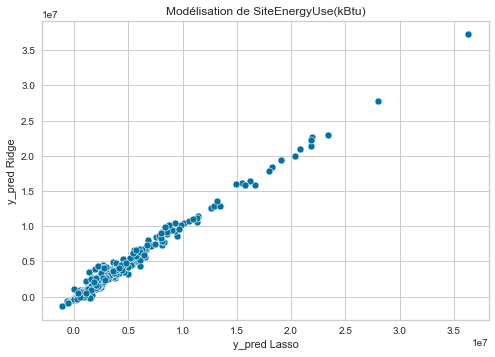

In [95]:
# graphe y_pred lasso vs y_pred ridge
sns.scatterplot(x='lasso', y='ridge', data=resultat.iloc[:316,:]);
plt.xlabel('y_pred Lasso')
plt.ylabel('y_pred Ridge')
plt.title('Modélisation de SiteEnergyUse(kBtu)');

In [96]:
for model in resultat.columns:
    resultat.loc['nb valeurs negatives', model] = np.sum(resultat.loc[:1254,model] < 0)
resultat.loc['nb valeurs negatives']

y_test               0.0
linearregression    34.0
ridge               22.0
lasso               11.0
Name: nb valeurs negatives, dtype: float64

### Regression ELASTICNET

In [97]:
start = timeit.default_timer()
score = 'neg_root_mean_squared_error'
model = make_pipeline(preprocessor, ElasticNet())

n_alphas = 100
alphas = np.logspace(-3, 8, n_alphas)
l1ratios = np.arange(0,1.1,0.1)

params = {'elasticnet__alpha':alphas,
          'elasticnet__l1_ratio':l1ratios
         }

grid_elasticnet = GridSearchCV(model, param_grid=params, cv=3, scoring=score)
grid_elasticnet.fit(X_train, y_train)

duree = Affichage_duree(start)

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3137588763052564.0, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4089671916160659.5, tolerance: 2510126897112.0713
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4329268514995017.5, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_de

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3248593420198.0, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 274612029879571.0, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 848204042718889.0, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4047884446696431.5, tolerance: 2510126897112.0713
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4290133207561128.0, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 607290238019420.0, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_des

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 607290096388937.5, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2262495427047765.0, tolerance: 2510126897112.0713
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 876159034396493.0, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_desc

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3315669230196100.5, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4281745021471978.0, tolerance: 2510126897112.0713
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4513619220090319.0, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_de

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 607290399732369.5, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2262496292328449.0, tolerance: 2510126897112.0713
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 876159848765055.0, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_desc

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5159444310815672.0, tolerance: 2510126897112.0713
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5343660226470846.0, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 607291923112410.0, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_des

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2262505195788027.0, tolerance: 2510126897112.0713
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 876166024793901.0, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5070151391033152.0, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_des

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7634800627620310.0, tolerance: 2510126897112.0713
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7735010757991754.0, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 644257307202188.0, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_des

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 837209825449047.0, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7915031796514538.0, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9707338790106556.0, tolerance: 2510126897112.0713
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_des

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 202956638723933.0, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 935188071530827.0, tolerance: 2510126897112.0713
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 539995002277725.0, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_desce

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2076828706108478e+16, tolerance: 2510126897112.0713
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2281294831485416e+16, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 212947128092028.0, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordi

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24338366506732.0, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0168376378210114e+16, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2411119476233886e+16, tolerance: 2510126897112.0713
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordin

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12452219788278.0, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0258909354066574e+16, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2520036237514024e+16, tolerance: 2510126897112.0713
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordin

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2769175935085672e+16, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0281784334843978e+16, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2547560984138102e+16, tolerance: 2510126897112.0713
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_c

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2772887097081778e+16, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0284082996339656e+16, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2550326997949272e+16, tolerance: 2510126897112.0713
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_c

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.028431297469625e+16, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.255060373542386e+16, tolerance: 2510126897112.0713
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2773267765500236e+16, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coo

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0284335973654548e+16, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2550631410532954e+16, tolerance: 2510126897112.0713
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.277329651994978e+16, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_co

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0284338273561608e+16, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2550634178057468e+16, tolerance: 2510126897112.0713
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2773299395408962e+16, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_c

Temps d'exécution : 2.80min


In [98]:
best_RMSE = grid_elasticnet.best_score_
best_alpha = grid_elasticnet.best_params_.get('elasticnet__alpha')
best_l1ratio = grid_elasticnet.best_params_.get('elasticnet__l1_ratio')

print("alpha = {:.0f} et l1_ratio = {:.1f} permet d'obtenir la RMSE optimale de {:0.2f}".format(best_alpha, best_l1ratio, -best_RMSE))

alpha = 0 et l1_ratio = 0.8 permet d'obtenir la RMSE optimale de 3688279.34


In [99]:
y_pred = grid_elasticnet.predict(X_test)

# calcul metriques
print("MSE : {:.2f}".format(metrics.mean_squared_error(y_test, y_pred)))
print("RMSE : {:.2f}".format(np.sqrt( metrics.mean_squared_error(y_test, y_pred) )))
# print("RMSLE : {:.2f}".format(metrics.mean_squared_log_error(y_test, y_pred)))
print("RSE : {:.2f}".format(1-metrics.r2_score(y_test, y_pred)))
print("R² : {:.2f}".format(metrics.r2_score(y_test, y_pred)))

MSE : 7041834704685.29
RMSE : 2653645.55
RSE : 0.20
R² : 0.80


y_test        y_pred
count  3.160000e+02  3.160000e+02
mean   4.377049e+06  4.486635e+06
std    5.948314e+06  4.896049e+06
min    4.394300e+04 -1.367285e+06
25%    1.091298e+06  1.539615e+06
50%    1.957251e+06  3.350684e+06
75%    4.668552e+06  5.386182e+06
max    3.686335e+07  3.724574e+07

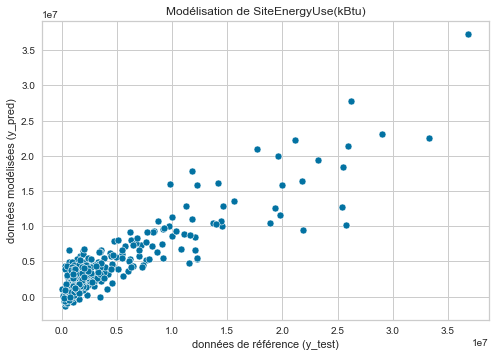

In [100]:
sns.scatterplot(x=y_test, y=y_pred);
plt.xlabel('données de référence (y_test)')
plt.ylabel('données modélisées (y_pred)')
plt.title('Modélisation de SiteEnergyUse(kBtu)');


pd.DataFrame(np.column_stack([y_test, y_pred]), columns=['y_test', 'y_pred']).describe()

#### Visu

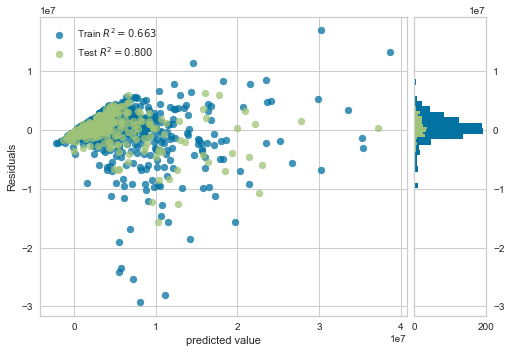

In [101]:
# visualisation des résidus
model = make_pipeline(preprocessor, ResidualsPlot(ElasticNet(alpha=best_alpha, l1_ratio=best_l1ratio)))

model.fit(X_train, y_train)
ax = model.score(X_test, y_test)
plt.legend()
plt.xlabel('predicted value')
plt.ylabel('Residuals');

La distribution des résidus est centrée sur zero => un modèle linaire devrait être suffisant pout modéliser notre target. En moyenne on prédit des valeurs sans surestimer ou sous estimer la cible.

La prédiction des valeurs les plus faibles s'accompagne de résidus plus faibles puis avec des résidus fortements négatifs. Plus la valeur prédite est grande, plus l'erreur grandie elle aussi et les résidus deviennent positifs.

La frontière supérieure gauche montre qu'il doit y avoir une variable avec un poid élevé dans cette région


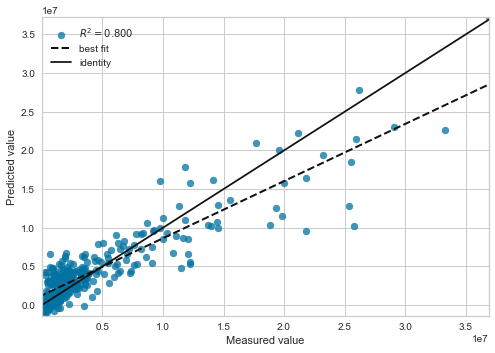

In [102]:
# visu des erreurs de prédiction

model = make_pipeline(preprocessor, PredictionError(ElasticNet(alpha=best_alpha, l1_ratio=best_l1ratio)))

model.fit(X_train, y_train)
model.score(X_test, y_test)
plt.plot([0,4e7], [0,4e7], label='identity', c='k')
plt.legend();
plt.xlabel('Measured value')
plt.ylabel('Predicted value');

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3104513461837231.0, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3087360146882837.0, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2961110230069180.5, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_de

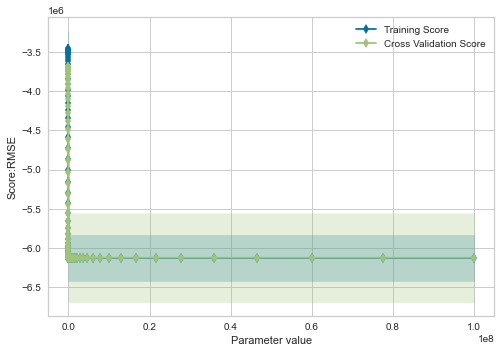

In [103]:
# validation curve
viz = make_pipeline(preprocessor, ValidationCurve(ElasticNet(l1_ratio=best_l1ratio),
                                                  param_name="alpha",
                                                  param_range=alphas,
                                                  cv=3,
                                                  scoring=score
                                                 )
                   )

# Fit and show the visualizer
viz.fit(X_train, y_train);
plt.legend();
plt.xlabel('Parameter value')
plt.ylabel('Score:RMSE');
# viz.show()

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4158323357088444.5, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 607291932347394.0, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5160420607104837.0, tolerance: 2510126897112.0713
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_des

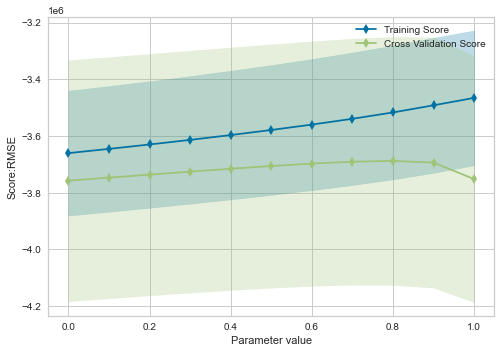

In [104]:
# validation curve
viz = make_pipeline(preprocessor, ValidationCurve(ElasticNet(alpha=best_alpha),
                                                  param_name="l1_ratio",
                                                  param_range=l1ratios,
                                                  cv=3,
                                                  scoring=score
                                                 )
                   )

# Fit and show the visualizer
viz.fit(X_train, y_train);
plt.legend();
plt.xlabel('Parameter value')
plt.ylabel('Score:RMSE');
# viz.show()

on visualise bien les valeurs des paramètres à partir desquel le modèle ne fit plus bien.

Pour alpha on passe directement en underfit.

Pour l1_ratio, quand il augmente trop on a le training score qui continue d'augmenter alors que le cv score dimine

Text(0, 0.5, 'Score:RMSE')

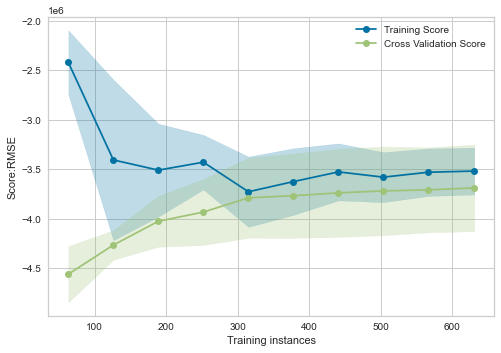

In [105]:
# Learning curve
sizes = np.linspace(0.1, 1.0, 10)

viz = make_pipeline(preprocessor, LearningCurve(ElasticNet(alpha=best_alpha, l1_ratio=best_l1ratio),
                                                cv=3,
                                                train_sizes=sizes,
                                                scoring=score
                                                )
                   )

# Fit and show the visualizer
viz.fit(X_train, y_train);
plt.legend();
plt.xlabel('Training instances')
plt.ylabel('Score:RMSE')

Il n'y a pas besoin de plus de données pour l'apprentissage

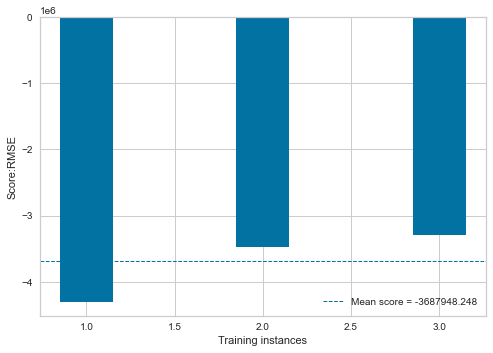

In [106]:
# visu impact de la crossvalidation
viz = make_pipeline(preprocessor, CVScores(ElasticNet(alpha=best_alpha, l1_ratio=best_l1ratio),
                                            cv=3,
                                            scoring=score
                                            )
                   )

# Fit and show the visualizer
viz.fit(X_train, y_train);
plt.legend();
plt.xlabel('Training instances')
plt.ylabel('Score:RMSE');

#### Avec la fonction

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3137588763052564.0, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4089671916160659.5, tolerance: 2510126897112.0713
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4329268514995017.5, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_de

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4340094929285235.5, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3248593420198.0, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 274612029879571.0, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descen

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4237295972097437.5, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3103372124752471.5, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4047884446696431.5, tolerance: 2510126897112.0713
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_de

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3892339529781189.0, tolerance: 2510126897112.0713
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4253073200388337.5, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 607290096388937.5, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_des

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2262495576735503.0, tolerance: 2510126897112.0713
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 876159272218193.0, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3315669230196100.5, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_des

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4534171433843678.0, tolerance: 2510126897112.0713
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4755554020455502.0, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 607290399732369.5, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_des

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2262498064564605.0, tolerance: 2510126897112.0713
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 876161091209925.0, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4108878208851061.0, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_des

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6021342004596758.0, tolerance: 2510126897112.0713
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6158025937994745.0, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 760397926277321.5, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_des

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 894900552226540.0, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6186916859312329.0, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7634800627620310.0, tolerance: 2510126897112.0713
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_des

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 554124602350057.0, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 938998751610149.5, tolerance: 2510126897112.0713
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 837209825449047.0, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_desce

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9098809606421286.0, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1126374626607072e+16, tolerance: 2510126897112.0713
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1296483840036798e+16, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coord

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 203138376921889.0, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 549876098394121.0, tolerance: 2510126897112.0713
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 280608802155618.0, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_desce

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.237161808951463e+16, tolerance: 2510126897112.0713
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2587339488012224e+16, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 69899121798985.0, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordina

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31543349976157.0, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.025154238056437e+16, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2511172198635612e+16, tolerance: 2510126897112.0713
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordina

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.276797465113078e+16, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0281040134279474e+16, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.254666548062834e+16, tolerance: 2510126897112.0713
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coo

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2772766808534322e+16, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0284008500591132e+16, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2550237355793408e+16, tolerance: 2510126897112.0713
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_c

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2773246420264216e+16, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.028430552436382e+16, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2550594770289408e+16, tolerance: 2510126897112.0713
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_co

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2773294385400518e+16, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0284335228613734e+16, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.255063051401031e+16, tolerance: 2510126897112.0713
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_co

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2773299181953792e+16, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0284338199057452e+16, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2550634088405126e+16, tolerance: 2510126897112.0713
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_c

Temps d'exécution : 3.11min
Durée du gridSearchCV :  186.6946092
MSE : 7041834704685.29
RMSE : 7041834704685.29
RMSLE : nan
RSE : 0.20
R² : 0.80


y_test  linearregression         ridge  \
2                     12051984.0      6.638562e+06  6.604160e+06   
9                     33270518.0      2.286747e+07  2.260517e+07   
13                     1388717.0      5.329196e+06  5.318136e+06   
19                      306721.0      4.120923e+06  4.325095e+06   
31                     6722886.0      7.774815e+06  7.666863e+06   
...                          ...               ...           ...   
elasticnet__alpha            NaN               NaN           NaN   
elasticnet__l1_ratio         NaN               NaN           NaN   
lasso__alpha                 NaN               NaN           NaN   
nb valeurs negatives         0.0      3.400000e+01  2.200000e+01   
ridge__alpha                 NaN               NaN  1.500000e+01   

                             lasso    elasticnet  
2                     6.489547e+06  6.595790e+06  
9                     2.191556e+07  2.259085e+07  
13                    5.269499e+06  5.308181e+06  
19                    6.031394e+06  4.310463e+06  
31                    6.942385e+06  7.666569e+06  
...                            ...           ...  
elasticnet__alpha              NaN  7.742637e-02  
elasticnet__l1_ratio           NaN  8.000000e-01  
lasso__alpha          4.941713e+04           NaN  
nb valeurs negatives  1.100000e+01           NaN  
ridge__alpha                   NaN           NaN  

[327 rows x 5 columns]

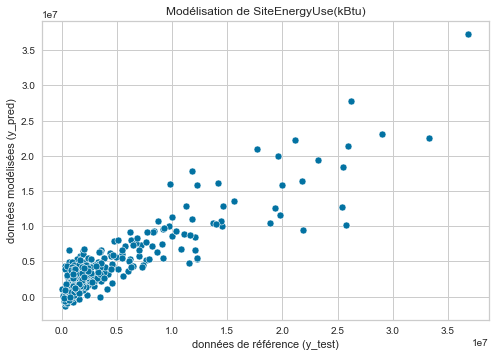

In [107]:
params = {'elasticnet__alpha':alphas,
          'elasticnet__l1_ratio':l1ratios
         }

score = 'neg_root_mean_squared_error'

resultat = Test_modele_GSCV(nom_run='elasticnet',
                            model=ElasticNet(), 
                            grid_params=params, 
                            cv=3, 
                            score=score, 
                            pipe_preprocessing=preprocessor,
                            X_train=X_train,
                            y_train=y_train,
                            X_test=X_test,
                            y_test=y_test, 
                            resultat=resultat
                           )
resultat

#### Investigation des valeurs négatives

In [108]:
resultat.tail(15)

y_test  linearregression         ridge         lasso  \
1242                  7205135.0      7.306716e+06  7.269010e+06  6.675961e+06   
1249                  2401148.0      4.067208e+06  4.060936e+06  4.154723e+06   
1253                   650313.0      7.050228e+06  6.595886e+06  5.662934e+06   
1254                  6125692.0      9.692813e+06  9.086883e+06  7.992498e+06   
Duree calcul (s)            NaN      3.369910e-02  1.799965e-02  3.499961e-02   
MSE                         NaN      7.259953e+12  7.055903e+12  7.609199e+12   
RMSE                        NaN      2.694430e+06  2.656295e+06  2.758478e+06   
RMSLE                       NaN               NaN           NaN           NaN   
RSE                         NaN      2.058365e-01  2.000513e-01  2.157385e-01   
R²                          NaN      7.941635e-01  7.999487e-01  7.842615e-01   
elasticnet__alpha           NaN               NaN           NaN           NaN   
elasticnet__l1_ratio        NaN               NaN           NaN           NaN   
lasso__alpha                NaN               NaN           NaN  4.941713e+04   
nb valeurs negatives        0.0      3.400000e+01  2.200000e+01  1.100000e+01   
ridge__alpha                NaN               NaN  1.500000e+01           NaN   

                        elasticnet  
1242                  7.265616e+06  
1249                  4.050546e+06  
1253                  6.587865e+06  
1254                  9.098701e+06  
Duree calcul (s)      2.197671e-02  
MSE                   7.041835e+12  
RMSE                  2.653646e+06  
RMSLE                          NaN  
RSE                   1.996524e-01  
R²                    8.003476e-01  
elasticnet__alpha     7.742637e-02  
elasticnet__l1_ratio  8.000000e-01  
lasso__alpha                   NaN  
nb valeurs negatives           NaN  
ridge__alpha                   NaN

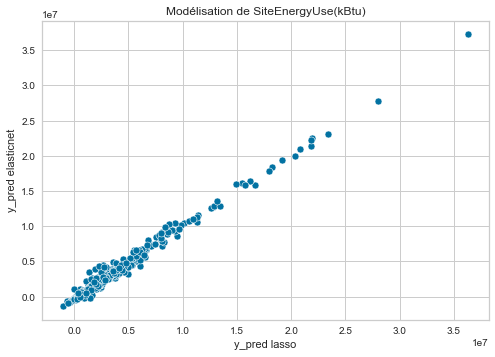

In [109]:
# graphe y_pred lasso vs y_pred elasticnet
sns.scatterplot(x='lasso', y='elasticnet', data=resultat.iloc[:316,:]);
plt.xlabel('y_pred lasso')
plt.ylabel('y_pred elasticnet')
plt.title('Modélisation de SiteEnergyUse(kBtu)');

In [110]:
for model in resultat.columns:
    resultat.loc['nb valeurs negatives', model] = np.sum(resultat.loc[:1254,model] < 0)
resultat.loc['nb valeurs negatives']

y_test               0.0
linearregression    34.0
ridge               22.0
lasso               11.0
elasticnet          22.0
Name: nb valeurs negatives, dtype: float64

### kRR

In [111]:
start = timeit.default_timer()

# valeurs du paramètre de régularisation
alpha_range = np.logspace(-3, -1, 30)
# valeurs du paramètre gamma
gamma_range = np.logspace(-3, -1, 20)

# grille de paramètres
params = {'kernelridge__alpha': alpha_range, 
          'kernelridge__gamma': gamma_range}

# score pour sélectionner le modèle optimal
score = 'neg_root_mean_squared_error'

# modèle
model = make_pipeline(preprocessor, KernelRidge(kernel='rbf'))

# crossvalidation
grid_kRR = GridSearchCV(model, param_grid=params, cv=3, scoring=score)
grid_kRR.fit(X_train, y_train)

duree = Affichage_duree(start)

Temps d'exécution : 1.66min


In [112]:
best_RMSE = grid_kRR.best_score_
best_alpha = grid_kRR.best_params_.get('kernelridge__alpha')
best_gamma = grid_kRR.best_params_.get('kernelridge__gamma')

print("alpha = {:.3f} et gamma = {:.4f} permet d'obtenir la RMSE optimale de {:0.2f}".format(best_alpha, best_gamma, -best_RMSE))

alpha = 0.003 et gamma = 0.0089 permet d'obtenir la RMSE optimale de 3433002.29


MSE : 8451686992302.91
RMSE : 2907178.53
RSE : 0.24
R² : 0.76


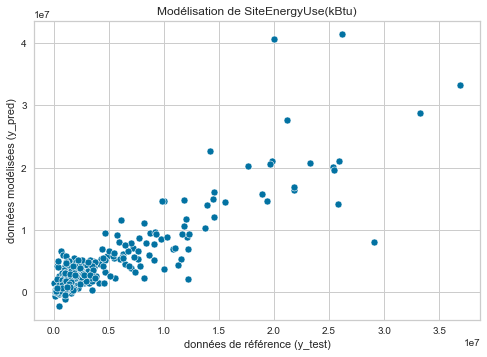

In [113]:
y_pred = grid_kRR.predict(X_test)

# calcul metriques
print("MSE : {:.2f}".format(metrics.mean_squared_error(y_test, y_pred)))
print("RMSE : {:.2f}".format(np.sqrt( metrics.mean_squared_error(y_test, y_pred) )))
# print("RMSLE : {:.2f}".format(metrics.mean_squared_log_error(y_test, y_pred)))
print("RSE : {:.2f}".format(1-metrics.r2_score(y_test, y_pred)))
print("R² : {:.2f}".format(metrics.r2_score(y_test, y_pred)))

sns.scatterplot(x=y_test, y=y_pred);
plt.xlabel('données de référence (y_test)')
plt.ylabel('données modélisées (y_pred)')
plt.title('Modélisation de SiteEnergyUse(kBtu)');

#### visu

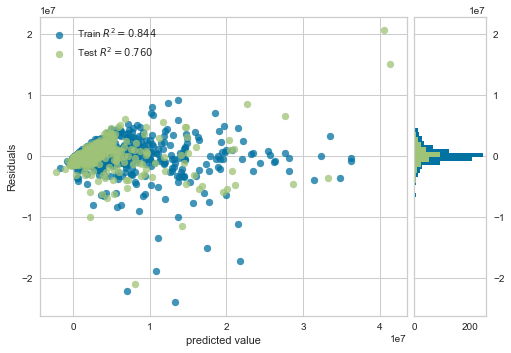

In [114]:
# visualisation des résidus
model = make_pipeline(preprocessor, ResidualsPlot(KernelRidge(kernel='rbf', alpha=best_alpha, gamma=best_gamma)))

model.fit(X_train, y_train)
ax = model.score(X_test, y_test)
plt.legend()
plt.xlabel('predicted value')
plt.ylabel('Residuals');

La distribution des résidus est centrée sur zero + courbe gaussienne => ce modèle semble mieux représenter les données que les modèles linéaires. En moyenne on prédit des valeurs sans surestimer ou sous estimer la cible.

Hormis quelques valeurs sous estimées pendant le train et deux valeurs surestimées pendant le test les résidus sont globalement homogènement distribués et concentrés entre -1e7 et 1e7.

La frontière supérieure gauche montre qu'il doit y avoir une variable avec un poid élevé dans cette région


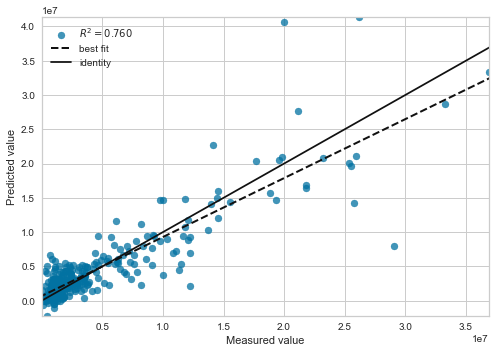

In [115]:
# visu des erreurs de prédiction

model = make_pipeline(preprocessor, PredictionError(KernelRidge(kernel='rbf', alpha=best_alpha, gamma=best_gamma)))

model.fit(X_train, y_train)
model.score(X_test, y_test)
plt.plot([0,4e7], [0,4e7], label='identity', c='k')
plt.legend();
plt.xlabel('Measured value')
plt.ylabel('Predicted value');

La courbe de best fit est plus proche de la courbe y=x que pour les modèles précédents

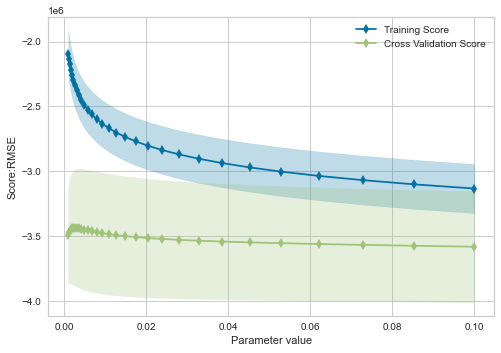

In [116]:
# validation curve
# Alpha
viz = make_pipeline(preprocessor, ValidationCurve(KernelRidge(kernel='rbf',
                                                              gamma=best_gamma),
                                                  param_name="alpha",
                                                  param_range=alpha_range,
                                                  cv=3,
                                                  scoring=score
                                                 )
                   )

# Fit and show the visualizer
viz.fit(X_train, y_train);
plt.legend();
plt.xlabel('Parameter value')
plt.ylabel('Score:RMSE');

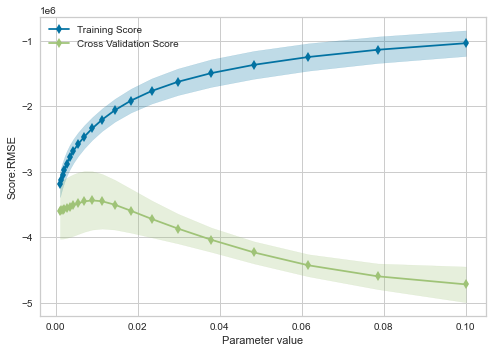

In [117]:
# validation curve
# gamma
viz = make_pipeline(preprocessor, ValidationCurve(KernelRidge(kernel='rbf',
                                                              alpha=best_alpha),
                                                  param_name="gamma",
                                                  param_range=gamma_range,
                                                  cv=3,
                                                  scoring=score
                                                 )
                   )

# Fit and show the visualizer
viz.fit(X_train, y_train);
plt.legend();
plt.xlabel('Parameter value')
plt.ylabel('Score:RMSE');

on visualise bien les valeurs des paramètres à partir desquel le modèle ne fit plus bien.

Pour alpha on passe très rapidement en underfit.

Pour gamma, quand il augmente trop on a le training score qui continue d'augmenter alors que le cv score diminue ==> il faut une valeur basse de gamma pour obtenir un modèle opérationnel.


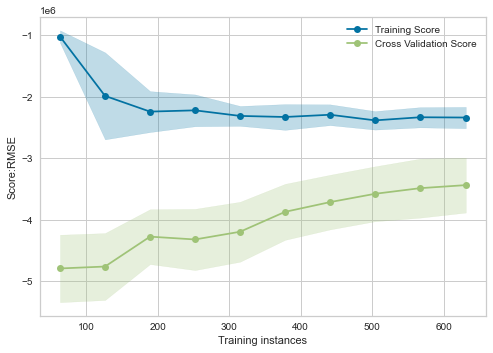

In [118]:
# Learning curve
sizes = np.linspace(0.1, 1.0, 10)

viz = make_pipeline(preprocessor, LearningCurve(KernelRidge(kernel='rbf', alpha=best_alpha, gamma=best_gamma),
                                                cv=3,
                                                train_sizes=sizes,
                                                scoring=score
                                                )
                   )

# Fit and show the visualizer
viz.fit(X_train, y_train);
plt.legend();
plt.xlabel('Training instances')
plt.ylabel('Score:RMSE');

Avoir plus de données permettrait d'améliorer probablement le modèle kRR

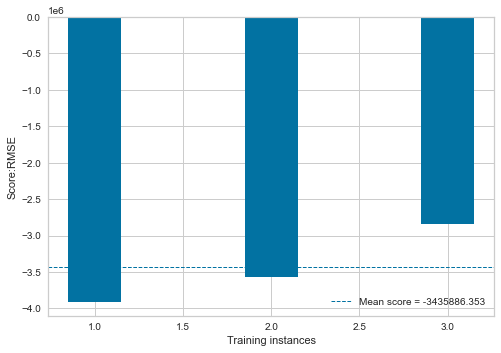

In [119]:
# visu impact de la crossvalidation
viz = make_pipeline(preprocessor, CVScores(KernelRidge(kernel='rbf', alpha=best_alpha, gamma=best_gamma),
                                            cv=3,
                                            scoring=score
                                            )
                   )

# Fit and show the visualizer
viz.fit(X_train, y_train);
plt.legend();
plt.xlabel('Training instances')
plt.ylabel('Score:RMSE');

#### Avec la fonction

Temps d'exécution : 1.64min
Durée du gridSearchCV :  98.29028970000002
MSE : 8451686992302.91
RMSE : 8451686992302.91
RMSLE : nan
RSE : 0.24
R² : 0.76


y_test  linearregression         ridge  \
2                     12051984.0      6.638562e+06  6.604160e+06   
9                     33270518.0      2.286747e+07  2.260517e+07   
13                     1388717.0      5.329196e+06  5.318136e+06   
19                      306721.0      4.120923e+06  4.325095e+06   
31                     6722886.0      7.774815e+06  7.666863e+06   
...                          ...               ...           ...   
kernelridge__alpha           NaN               NaN           NaN   
kernelridge__gamma           NaN               NaN           NaN   
lasso__alpha                 NaN               NaN           NaN   
nb valeurs negatives         0.0      3.400000e+01  2.200000e+01   
ridge__alpha                 NaN               NaN  1.500000e+01   

                             lasso    elasticnet       kRR_rbf  
2                     6.489547e+06  6.595790e+06  1.183301e+07  
9                     2.191556e+07  2.259085e+07  2.871947e+07  
13                    5.269499e+06  5.308181e+06  5.092034e+06  
19                    6.031394e+06  4.310463e+06  4.282118e+06  
31                    6.942385e+06  7.666569e+06  6.671484e+06  
...                            ...           ...           ...  
kernelridge__alpha             NaN           NaN  2.592944e-03  
kernelridge__gamma             NaN           NaN  8.858668e-03  
lasso__alpha          4.941713e+04           NaN           NaN  
nb valeurs negatives  1.100000e+01  2.200000e+01           NaN  
ridge__alpha                   NaN           NaN           NaN  

[329 rows x 6 columns]

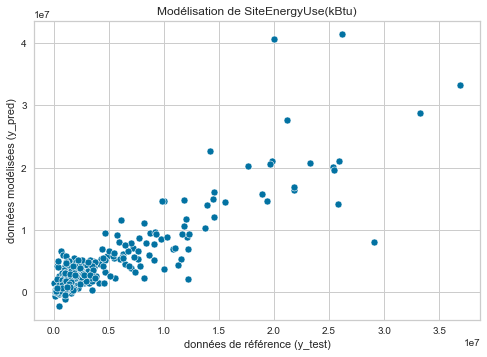

In [120]:
resultat = Test_modele_GSCV(nom_run='kRR_rbf',
                            model=KernelRidge(kernel='rbf'), 
                            grid_params=params, 
                            cv=3, 
                            score=score, 
                            pipe_preprocessing=preprocessor,
                            X_train=X_train,
                            y_train=y_train,
                            X_test=X_test,
                            y_test=y_test, 
                            resultat=resultat
                           )
resultat

#### Investigation des valeurs négatives

In [121]:
resultat.tail(20)

y_test  linearregression         ridge         lasso  \
1229                  3467070.0      6.015073e+06  6.276953e+06  6.102736e+06   
1232                  3528230.0      3.807667e+06  4.749112e+06  4.803948e+06   
1234                  4665069.0      5.904498e+06  5.851259e+06  6.415651e+06   
1242                  7205135.0      7.306716e+06  7.269010e+06  6.675961e+06   
1249                  2401148.0      4.067208e+06  4.060936e+06  4.154723e+06   
1253                   650313.0      7.050228e+06  6.595886e+06  5.662934e+06   
1254                  6125692.0      9.692813e+06  9.086883e+06  7.992498e+06   
Duree calcul (s)            NaN      3.369910e-02  1.799965e-02  3.499961e-02   
MSE                         NaN      7.259953e+12  7.055903e+12  7.609199e+12   
RMSE                        NaN      2.694430e+06  2.656295e+06  2.758478e+06   
RMSLE                       NaN               NaN           NaN           NaN   
RSE                         NaN      2.058365e-01  2.000513e-01  2.157385e-01   
R²                          NaN      7.941635e-01  7.999487e-01  7.842615e-01   
elasticnet__alpha           NaN               NaN           NaN           NaN   
elasticnet__l1_ratio        NaN               NaN           NaN           NaN   
kernelridge__alpha          NaN               NaN           NaN           NaN   
kernelridge__gamma          NaN               NaN           NaN           NaN   
lasso__alpha                NaN               NaN           NaN  4.941713e+04   
nb valeurs negatives        0.0      3.400000e+01  2.200000e+01  1.100000e+01   
ridge__alpha                NaN               NaN  1.500000e+01           NaN   

                        elasticnet       kRR_rbf  
1229                  6.290453e+06  3.594176e+06  
1232                  4.727202e+06  3.246708e+06  
1234                  5.860896e+06  5.132026e+06  
1242                  7.265616e+06  7.182110e+06  
1249                  4.050546e+06  3.857855e+06  
1253                  6.587865e+06  6.702717e+06  
1254                  9.098701e+06  1.168951e+07  
Duree calcul (s)      2.197671e-02  6.100106e-02  
MSE                   7.041835e+12  8.451687e+12  
RMSE                  2.653646e+06  2.907179e+06  
RMSLE                          NaN           NaN  
RSE                   1.996524e-01  2.396250e-01  
R²                    8.003476e-01  7.603750e-01  
elasticnet__alpha     7.742637e-02           NaN  
elasticnet__l1_ratio  8.000000e-01           NaN  
kernelridge__alpha             NaN  2.592944e-03  
kernelridge__gamma             NaN  8.858668e-03  
lasso__alpha                   NaN           NaN  
nb valeurs negatives  2.200000e+01           NaN  
ridge__alpha                   NaN           NaN

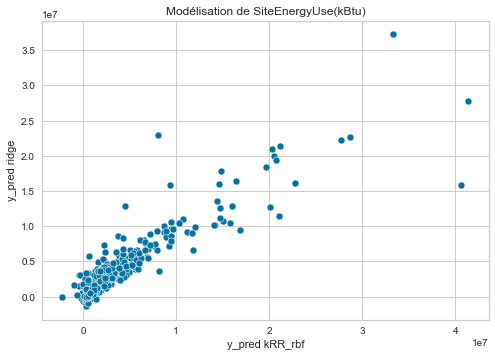

In [122]:
# graphe y_pred kRR vs y_pred ridge
sns.scatterplot(x='kRR_rbf', y='ridge', data=resultat.iloc[:316,:]);
plt.xlabel('y_pred kRR_rbf')
plt.ylabel('y_pred ridge')
plt.title('Modélisation de SiteEnergyUse(kBtu)');

In [123]:
for model in resultat.columns:
    resultat.loc['nb valeurs negatives', model] = np.sum(resultat.loc[:1254,model] < 0)
resultat.loc['nb valeurs negatives']

y_test               0.0
linearregression    34.0
ridge               22.0
lasso               11.0
elasticnet          22.0
kRR_rbf             10.0
Name: nb valeurs negatives, dtype: float64

### Bagging : RandomForest

In [124]:
start = timeit.default_timer()

# grille de paramètres
n_estimator_range = [10, 50, 100, 250, 500, 750]
max_depth_range = [1, 2, 3, 4, 5, 10]
max_features_range = ['auto', 'sqrt', 'log2']
params = {"randomforestregressor__n_estimators":n_estimator_range,
          "randomforestregressor__max_depth":max_depth_range, 
          "randomforestregressor__max_features":max_features_range}

# score pour sélectionner le modèle optimal
score = 'neg_root_mean_squared_error'

# modèle
model = make_pipeline(preprocessor, RandomForestRegressor())

# crossvalidation
grid_randomforest = GridSearchCV(model, param_grid=params, cv=3, scoring=score)
grid_randomforest.fit(X_train, y_train)

duree = Affichage_duree(start)

Temps d'exécution : 1.86min


In [125]:
best_RMSE = grid_randomforest.best_score_
best_n_estimators = grid_randomforest.best_params_.get('randomforestregressor__n_estimators')
best_max_depth = grid_randomforest.best_params_.get('randomforestregressor__max_depth')
best_max_features = grid_randomforest.best_params_.get('randomforestregressor__max_features')

print("n_estimators = {:.0f}, max_depth = {:.0f} et max_features = {} permet d'obtenir la RMSE optimale de {:0.2f}".format(best_n_estimators, best_max_depth, best_max_features, -best_RMSE))

n_estimators = 250, max_depth = 10 et max_features = auto permet d'obtenir la RMSE optimale de 3691906.75


MSE : 7083088410122.36
RMSE : 2661407.22
RSE : 0.20
R² : 0.80


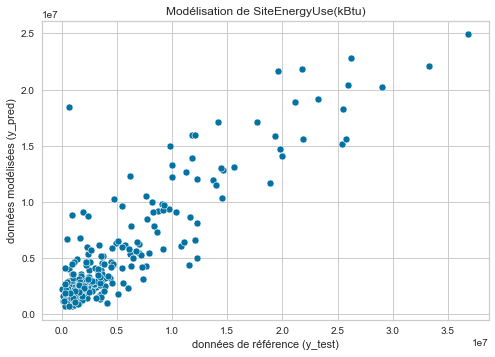

In [126]:
y_pred = grid_randomforest.predict(X_test)

# calcul metriques
print("MSE : {:.2f}".format(metrics.mean_squared_error(y_test, y_pred)))
print("RMSE : {:.2f}".format(np.sqrt( metrics.mean_squared_error(y_test, y_pred) )))
# print("RMSLE : {:.2f}".format(metrics.mean_squared_log_error(y_test, y_pred)))
print("RSE : {:.2f}".format(1-metrics.r2_score(y_test, y_pred)))
print("R² : {:.2f}".format(metrics.r2_score(y_test, y_pred)))

sns.scatterplot(x=y_test, y=y_pred);
plt.xlabel('données de référence (y_test)')
plt.ylabel('données modélisées (y_pred)')
plt.title('Modélisation de SiteEnergyUse(kBtu)');

#### Visu

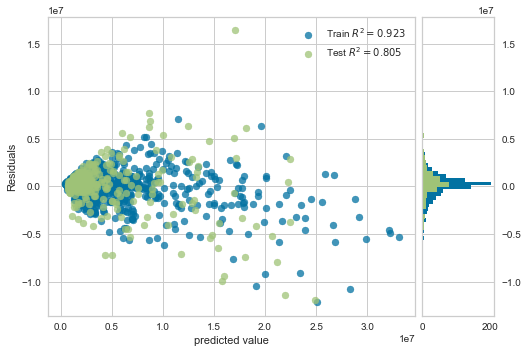

In [127]:
# visualisation des résidus
model = make_pipeline(preprocessor, ResidualsPlot(RandomForestRegressor(n_estimators=best_n_estimators, 
                                                                        max_depth=best_max_depth, 
                                                                        max_features=best_max_features)))

model.fit(X_train, y_train)
ax = model.score(X_test, y_test)
plt.legend()
plt.xlabel('predicted value')
plt.ylabel('Residuals');

Les résidus sont moins dispersés que pour le kRR. Leur distribution est centrée sur zero + courbe gaussienne => ce modèle semble mieux représenter les données que les modèles linéaires. 

Les résidus sont globalement homogènement distribués et concentrés entre -0.5e7 et 0.5e7.

La frontière supérieure gauche montre qu'il doit y avoir une variable avec un poid élevé dans cette région


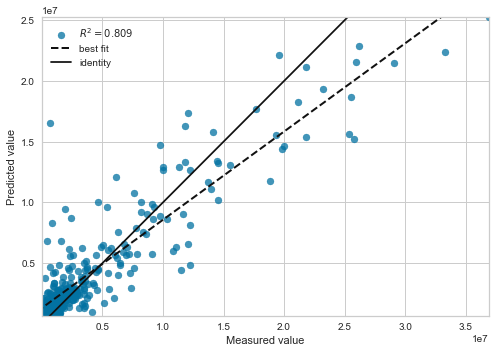

In [128]:
# visu des erreurs de prédiction

model = make_pipeline(preprocessor, PredictionError(RandomForestRegressor(n_estimators=best_n_estimators, 
                                                                        max_depth=best_max_depth, 
                                                                        max_features=best_max_features)))

model.fit(X_train, y_train)
model.score(X_test, y_test)
plt.plot([0,4e7], [0,4e7], label='identity', c='k')
plt.legend();
plt.xlabel('Measured value')
plt.ylabel('Predicted value');

La ligne de best fit est moins bonne que celle du kRR

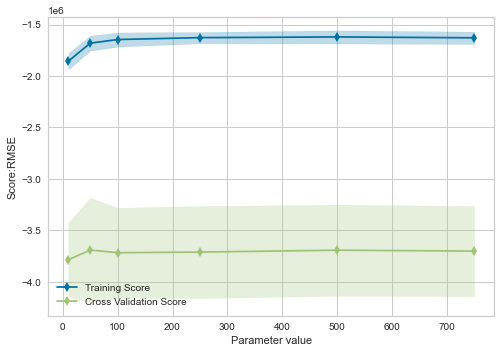

In [129]:
# validation curve
# n_estimators
viz = make_pipeline(preprocessor, ValidationCurve(RandomForestRegressor( 
                                                                        max_depth=best_max_depth, 
                                                                        max_features=best_max_features),
                                                  param_name="n_estimators",
                                                  param_range=n_estimator_range,
                                                  cv=3,
                                                  scoring=score
                                                 )
                   )

# Fit and show the visualizer
viz.fit(X_train, y_train);
plt.legend();
plt.xlabel('Parameter value')
plt.ylabel('Score:RMSE');

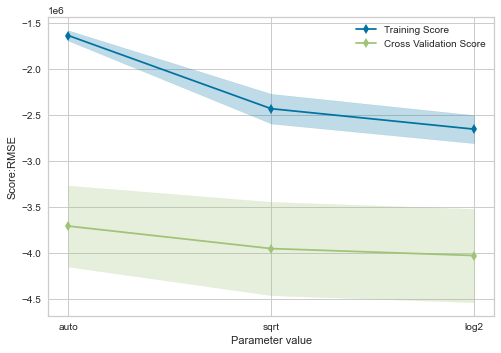

In [130]:
# validation curve
# max_features
viz = make_pipeline(preprocessor, ValidationCurve(RandomForestRegressor(n_estimators=best_n_estimators,
                                                                        max_depth=best_max_depth
                                                                        ),
                                                  param_name="max_features",
                                                  param_range=max_features_range,
                                                  cv=3,
                                                  scoring=score
                                                 )
                   )

# Fit and show the visualizer
viz.fit(X_train, y_train);
plt.legend();
plt.xlabel('Parameter value')
plt.ylabel('Score:RMSE');

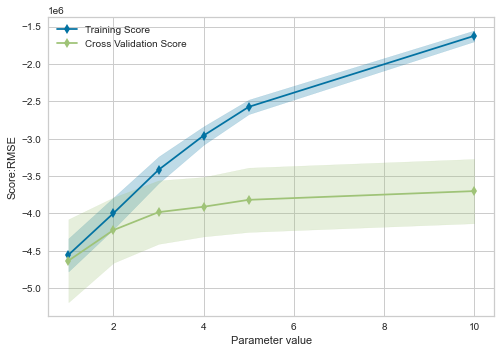

In [131]:
# validation curve
# max_depth
viz = make_pipeline(preprocessor, ValidationCurve(RandomForestRegressor(n_estimators=best_n_estimators, 
                                                                        max_features=best_max_features),
                                                  param_name="max_depth",
                                                  param_range=max_depth_range,
                                                  cv=3,
                                                  scoring=score
                                                 )
                   )

# Fit and show the visualizer
viz.fit(X_train, y_train);
plt.legend();
plt.xlabel('Parameter value')
plt.ylabel('Score:RMSE');

comme attendu, le modèle de random forest a une nette tendance à l'overfitt durant l'entrainement.

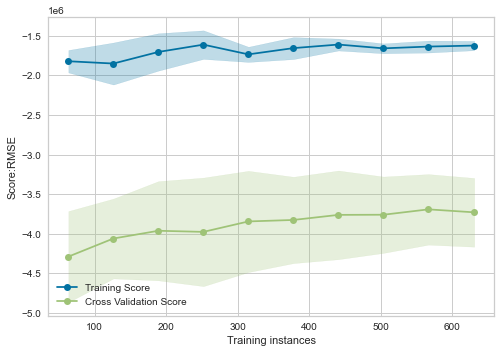

In [132]:
# Learning curve
sizes = np.linspace(0.1, 1.0, 10)

viz = make_pipeline(preprocessor, LearningCurve(RandomForestRegressor(n_estimators=best_n_estimators, 
                                                                        max_depth=best_max_depth, 
                                                                        max_features=best_max_features),
                                                cv=3,
                                                train_sizes=sizes,
                                                scoring=score
                                                )
                   )

# Fit and show the visualizer
viz.fit(X_train, y_train);
plt.legend();
plt.xlabel('Training instances')
plt.ylabel('Score:RMSE');

Il faudrait plus de données pour obtenir un modèle robuste

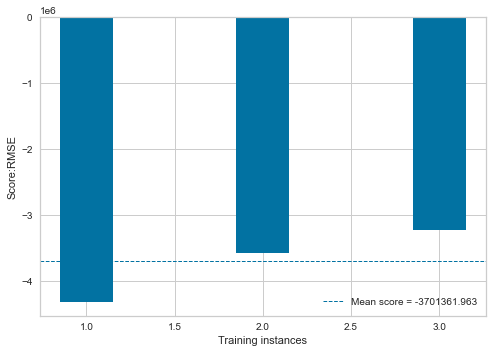

In [133]:
# visu impact de la crossvalidation
viz = make_pipeline(preprocessor, CVScores(RandomForestRegressor(n_estimators=best_n_estimators, 
                                                                        max_depth=best_max_depth, 
                                                                        max_features=best_max_features),
                                            cv=3,
                                            scoring=score
                                            )
                   )

# Fit and show the visualizer
viz.fit(X_train, y_train);
plt.legend();
plt.xlabel('Training instances')
plt.ylabel('Score:RMSE');

#### Avec la fonction

Temps d'exécution : 1.85min
Durée du gridSearchCV :  110.72720529999992
MSE : 7180963061854.87
RMSE : 7180963061854.87
RMSLE : 0.58
RSE : 0.20
R² : 0.80


y_test  linearregression  \
2                                    12051984.0      6.638562e+06   
9                                    33270518.0      2.286747e+07   
13                                    1388717.0      5.329196e+06   
19                                     306721.0      4.120923e+06   
31                                    6722886.0      7.774815e+06   
...                                         ...               ...   
nb valeurs negatives                        0.0      3.400000e+01   
randomforestregressor__max_depth            NaN               NaN   
randomforestregressor__max_features         NaN               NaN   
randomforestregressor__n_estimators         NaN               NaN   
ridge__alpha                                NaN               NaN   

                                            ridge         lasso    elasticnet  \
2                                    6.604160e+06  6.489547e+06  6.595790e+06   
9                                    2.260517e+07  2.191556e+07  2.259085e+07   
13                                   5.318136e+06  5.269499e+06  5.308181e+06   
19                                   4.325095e+06  6.031394e+06  4.310463e+06   
31                                   7.666863e+06  6.942385e+06  7.666569e+06   
...                                           ...           ...           ...   
nb valeurs negatives                 2.200000e+01  1.100000e+01  2.200000e+01   
randomforestregressor__max_depth              NaN           NaN           NaN   
randomforestregressor__max_features           NaN           NaN           NaN   
randomforestregressor__n_estimators           NaN           NaN           NaN   
ridge__alpha                         1.500000e+01           NaN           NaN   

                                          kRR_rbf     randomforest  
2                                    1.183301e+07   16778714.54203  
9                                    2.871947e+07  21620594.384935  
13                                   5.092034e+06   5300747.005414  
19                                   4.282118e+06   4088608.306991  
31                                   6.671484e+06   5578120.616075  
...                                           ...              ...  
nb valeurs negatives                 1.000000e+01              NaN  
randomforestregressor__max_depth              NaN             10.0  
randomforestregressor__max_features           NaN             auto  
randomforestregressor__n_estimators           NaN            100.0  
ridge__alpha                                  NaN              NaN  

[332 rows x 7 columns]

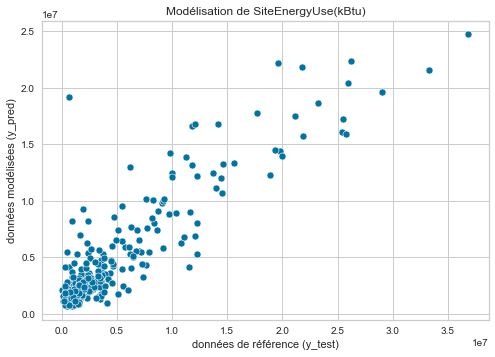

In [134]:
resultat = Test_modele_GSCV(nom_run='randomforest',
                            model=RandomForestRegressor(), 
                            grid_params=params, 
                            cv=3, 
                            score=score, 
                            pipe_preprocessing=preprocessor,
                            X_train=X_train,
                            y_train=y_train,
                            X_test=X_test,
                            y_test=y_test, 
                            resultat=resultat
                           )
resultat

In [135]:
resultat.loc['Duree calcul (s)',:]

y_test                   NaN
linearregression    0.033699
ridge                  0.018
lasso                  0.035
elasticnet          0.021977
kRR_rbf             0.061001
randomforest        0.413853
Name: Duree calcul (s), dtype: object

#### Investigation des valeurs négatives

In [136]:
resultat.tail(20)

y_test  linearregression  \
1242                                 7205135.0      7.306716e+06   
1249                                 2401148.0      4.067208e+06   
1253                                  650313.0      7.050228e+06   
1254                                 6125692.0      9.692813e+06   
Duree calcul (s)                           NaN      3.369910e-02   
MSE                                        NaN      7.259953e+12   
RMSE                                       NaN      2.694430e+06   
RMSLE                                      NaN               NaN   
RSE                                        NaN      2.058365e-01   
R²                                         NaN      7.941635e-01   
elasticnet__alpha                          NaN               NaN   
elasticnet__l1_ratio                       NaN               NaN   
kernelridge__alpha                         NaN               NaN   
kernelridge__gamma                         NaN               NaN   
lasso__alpha                               NaN               NaN   
nb valeurs negatives                       0.0      3.400000e+01   
randomforestregressor__max_depth           NaN               NaN   
randomforestregressor__max_features        NaN               NaN   
randomforestregressor__n_estimators        NaN               NaN   
ridge__alpha                               NaN               NaN   

                                            ridge         lasso    elasticnet  \
1242                                 7.269010e+06  6.675961e+06  7.265616e+06   
1249                                 4.060936e+06  4.154723e+06  4.050546e+06   
1253                                 6.595886e+06  5.662934e+06  6.587865e+06   
1254                                 9.086883e+06  7.992498e+06  9.098701e+06   
Duree calcul (s)                     1.799965e-02  3.499961e-02  2.197671e-02   
MSE                                  7.055903e+12  7.609199e+12  7.041835e+12   
RMSE                                 2.656295e+06  2.758478e+06  2.653646e+06   
RMSLE                                         NaN           NaN           NaN   
RSE                                  2.000513e-01  2.157385e-01  1.996524e-01   
R²                                   7.999487e-01  7.842615e-01  8.003476e-01   
elasticnet__alpha                             NaN           NaN  7.742637e-02   
elasticnet__l1_ratio                          NaN           NaN  8.000000e-01   
kernelridge__alpha                            NaN           NaN           NaN   
kernelridge__gamma                            NaN           NaN           NaN   
lasso__alpha                                  NaN  4.941713e+04           NaN   
nb valeurs negatives                 2.200000e+01  1.100000e+01  2.200000e+01   
randomforestregressor__max_depth              NaN           NaN           NaN   
randomforestregressor__max_features           NaN           NaN           NaN   
randomforestregressor__n_estimators           NaN           NaN           NaN   
ridge__alpha                         1.500000e+01           NaN           NaN   

                                          kRR_rbf          randomforest  
1242                                 7.182110e+06        5478462.381457  
1249                                 3.857855e+06        8175754.739178  
1253                                 6.702717e+06       19170784.011576  
1254                                 1.168951e+07       13000836.960633  
Duree calcul (s)                     6.100106e-02              0.413853  
MSE                                  8.451687e+12  7180963061854.873047  
RMSE                                 2.907179e+06        2679731.901115  
RMSLE                                         NaN              0.584255  
RSE                                  2.396250e-01              0.203597  
R²                                   7.603750e-01              0.796403  
elasticnet__alpha                             NaN                   NaN  
elasticnet__l1_ratio 

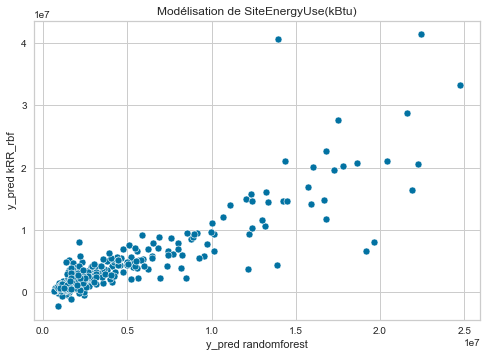

In [137]:
# graphe y_pred Random Forest vs y_pred kRR
sns.scatterplot(x='randomforest', y='kRR_rbf', data=resultat.iloc[:316,:]);
plt.xlabel('y_pred randomforest')
plt.ylabel('y_pred kRR_rbf')
plt.title('Modélisation de SiteEnergyUse(kBtu)');

In [138]:
for model in resultat.columns:
    resultat.loc['nb valeurs negatives', model] = np.sum(resultat.loc[:1254,model] < 0)
resultat.loc['nb valeurs negatives']

y_test               0.0
linearregression    34.0
ridge               22.0
lasso               11.0
elasticnet          22.0
kRR_rbf             10.0
randomforest           0
Name: nb valeurs negatives, dtype: object

### Boosting : GBoost

In [139]:
start = timeit.default_timer()

# grille de paramètres
n_estimators_range = [10, 100, 500]
max_depth_range = [1, 3, 5, 10]
max_features_range = ['auto', 'sqrt', 'log2']
learning_rate_range = [0.01, 0.1, 0.5 , 1]
loss_range = ['squared_error', 'absolute_error']
params = {"gradientboostingregressor__n_estimators":n_estimators_range,
          "gradientboostingregressor__max_depth":max_depth_range, 
          "gradientboostingregressor__max_features":max_features_range, 
          'gradientboostingregressor__learning_rate':learning_rate_range,
          'gradientboostingregressor__loss':loss_range
         }

# score pour sélectionner le modèle optimal
score = 'neg_root_mean_squared_error'

# modèle
model = make_pipeline(preprocessor, GradientBoostingRegressor())

# crossvalidation
grid_gboost = GridSearchCV(model, param_grid=params, cv=3, scoring=score)
grid_gboost.fit(X_train, y_train)

duree = Affichage_duree(start)

Temps d'exécution : 6.22min


In [140]:
best_RMSE = grid_gboost.best_score_
best_n_estimators = grid_gboost.best_params_.get('gradientboostingregressor__n_estimators')
best_max_depth = grid_gboost.best_params_.get('gradientboostingregressor__max_depth')
best_max_features = grid_gboost.best_params_.get('gradientboostingregressor__max_features')
best_learningRate = grid_gboost.best_params_.get('gradientboostingregressor__learning_rate')
best_loss = grid_gboost.best_params_.get('gradientboostingregressor__loss')

print("n_estimators = {:.0f}, max_depth = {:.0f}, "\
      "max_features = {}, learning_rate = {:.2f} et loss = {} permet d'obtenir " \
      "la RMSE optimale de {:0.2f}".format(best_n_estimators, 
                                          best_max_depth, 
                                          best_max_features, 
                                          best_learningRate, 
                                          best_loss,
                                          -best_RMSE))

n_estimators = 500, max_depth = 3, max_features = auto, learning_rate = 0.01 et loss = squared_error permet d'obtenir la RMSE optimale de 3702148.68


#### Visu

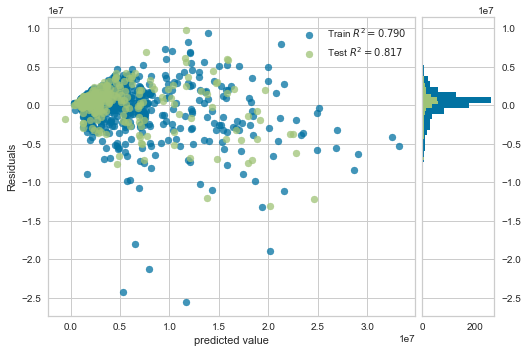

In [141]:
# visualisation des résidus
model = make_pipeline(preprocessor, ResidualsPlot(GradientBoostingRegressor(n_estimators=best_n_estimators, 
                                                                            max_depth=best_max_depth,
                                                                            max_features=best_max_features,
                                                                            learning_rate=best_learningRate,
                                                                            loss=best_loss
                                                                           )))

model.fit(X_train, y_train)
ax = model.score(X_test, y_test)
plt.legend()
plt.xlabel('predicted value')
plt.ylabel('Residuals');

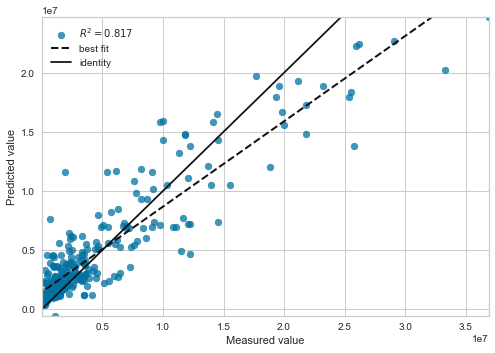

In [142]:
# visu des erreurs de prédiction

model = make_pipeline(preprocessor, PredictionError(GradientBoostingRegressor(n_estimators=best_n_estimators, 
                                                                            max_depth=best_max_depth,
                                                                            max_features=best_max_features,
                                                                            learning_rate=best_learningRate,
                                                                            loss=best_loss)))

model.fit(X_train, y_train)
model.score(X_test, y_test)
plt.plot([0,4e7], [0,4e7], label='identity', c='k')
plt.legend();
plt.xlabel('Measured value')
plt.ylabel('Predicted value');

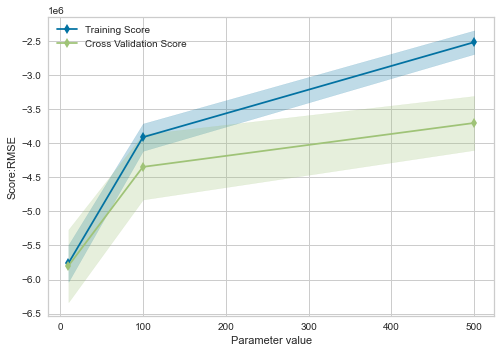

In [143]:
# validation curve
# n_estimators
viz = make_pipeline(preprocessor, ValidationCurve(GradientBoostingRegressor( 
                                                                            max_depth=best_max_depth,
                                                                            max_features=best_max_features,
                                                                            learning_rate=best_learningRate,
                                                                            loss=best_loss),
                                                  param_name="n_estimators",
                                                  param_range=n_estimators_range,
                                                  cv=3,
                                                  scoring=score
                                                 )
                   )

# Fit and show the visualizer
viz.fit(X_train, y_train);
plt.legend();
plt.xlabel('Parameter value')
plt.ylabel('Score:RMSE');

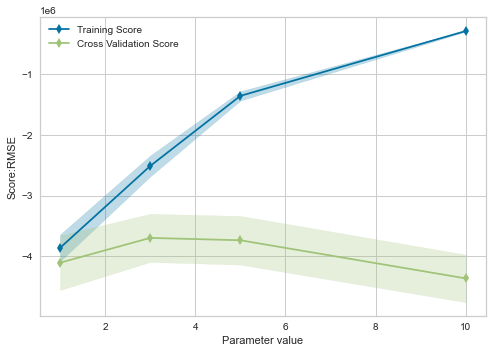

In [144]:
# validation curve
# max_depth
viz = make_pipeline(preprocessor, ValidationCurve(GradientBoostingRegressor(n_estimators=best_n_estimators, 
                                                                            max_features=best_max_features,
                                                                            learning_rate=best_learningRate,
                                                                            loss=best_loss),
                                                  param_name="max_depth",
                                                  param_range=max_depth_range,
                                                  cv=3,
                                                  scoring=score
                                                 )
                   )

# Fit and show the visualizer
viz.fit(X_train, y_train);
plt.legend();
plt.xlabel('Parameter value')
plt.ylabel('Score:RMSE');

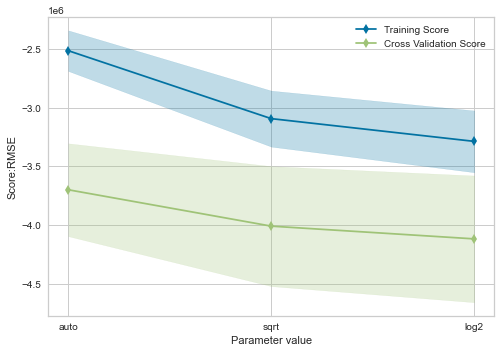

In [145]:
# validation curve
# max_features
viz = make_pipeline(preprocessor, ValidationCurve(GradientBoostingRegressor(n_estimators=best_n_estimators,
                                                                            max_depth=best_max_depth,
                                                                            learning_rate=best_learningRate,
                                                                            loss=best_loss),
                                                  param_name="max_features",
                                                  param_range=max_features_range,
                                                  cv=3,
                                                  scoring=score
                                                 )
                   )

# Fit and show the visualizer
viz.fit(X_train, y_train);
plt.legend();
plt.xlabel('Parameter value')
plt.ylabel('Score:RMSE');

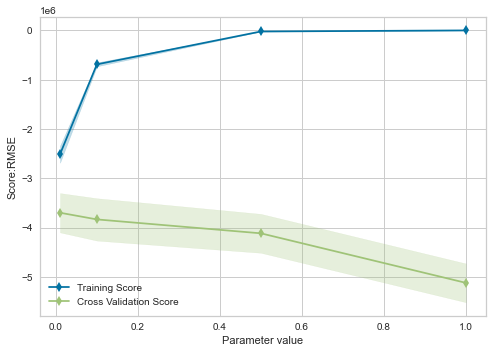

In [146]:
# validation curve
# learningRate
viz = make_pipeline(preprocessor, ValidationCurve(GradientBoostingRegressor(n_estimators=best_n_estimators,
                                                                            max_depth=best_max_depth,
                                                                            max_features=best_max_features,
                                                                            loss=best_loss),
                                                  param_name="learning_rate",
                                                  param_range=learning_rate_range,
                                                  cv=3,
                                                  scoring=score
                                                 )
                   )

# Fit and show the visualizer
viz.fit(X_train, y_train);
plt.legend();
plt.xlabel('Parameter value')
plt.ylabel('Score:RMSE');

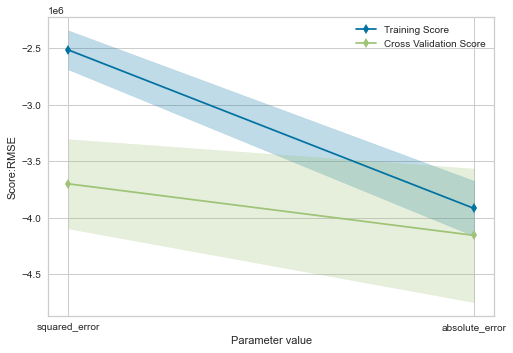

In [147]:
# validation curve
# learningRate
viz = make_pipeline(preprocessor, ValidationCurve(GradientBoostingRegressor(n_estimators=best_n_estimators,
                                                                            max_depth=best_max_depth,
                                                                            max_features=best_max_features,
                                                                            learning_rate=best_learningRate
                                                                            ),
                                                  param_name="loss",
                                                  param_range=loss_range,
                                                  cv=3,
                                                  scoring=score
                                                 )
                   )

# Fit and show the visualizer
viz.fit(X_train, y_train);
plt.legend();
plt.xlabel('Parameter value')
plt.ylabel('Score:RMSE');

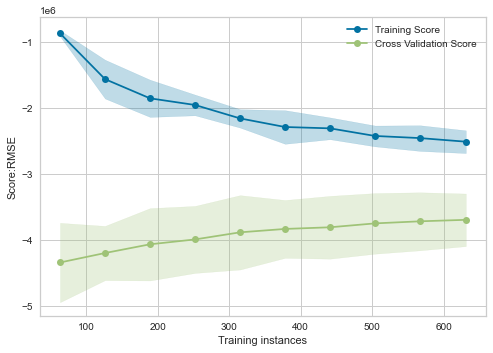

In [148]:
# Learning curve
sizes = np.linspace(0.1, 1.0, 10)

viz = make_pipeline(preprocessor, LearningCurve(GradientBoostingRegressor(n_estimators=best_n_estimators, 
                                                                            max_depth=best_max_depth,
                                                                            max_features=best_max_features,
                                                                            learning_rate=best_learningRate,
                                                                            loss=best_loss),
                                                cv=3,
                                                train_sizes=sizes,
                                                scoring=score
                                                )
                   )

# Fit and show the visualizer
viz.fit(X_train, y_train);
plt.legend();
plt.xlabel('Training instances')
plt.ylabel('Score:RMSE');

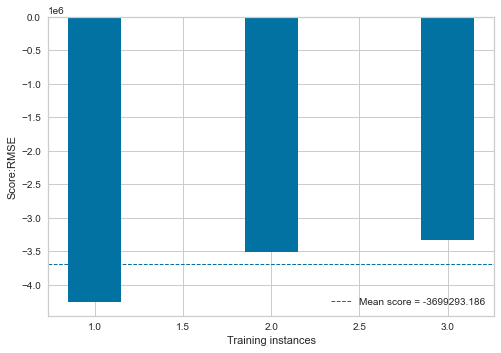

In [149]:
# visu impact de la crossvalidation
viz = make_pipeline(preprocessor, CVScores(GradientBoostingRegressor(n_estimators=best_n_estimators, 
                                                                            max_depth=best_max_depth,
                                                                            max_features=best_max_features,
                                                                            learning_rate=best_learningRate,
                                                                            loss=best_loss),
                                            cv=3,
                                            scoring=score
                                            )
                   )

# Fit and show the visualizer
viz.fit(X_train, y_train);
plt.legend();
plt.xlabel('Training instances')
plt.ylabel('Score:RMSE');

#### Avec la fonction

Temps d'exécution : 6.16min
Durée du gridSearchCV :  369.44364599999994
MSE : 6456059667422.84
RMSE : 6456059667422.84
RMSLE : nan
RSE : 0.18
R² : 0.82


y_test  linearregression  \
2                                    12051984.0      6.638562e+06   
9                                    33270518.0      2.286747e+07   
13                                    1388717.0      5.329196e+06   
19                                     306721.0      4.120923e+06   
31                                    6722886.0      7.774815e+06   
...                                         ...               ...   
nb valeurs negatives                        0.0      3.400000e+01   
randomforestregressor__max_depth            NaN               NaN   
randomforestregressor__max_features         NaN               NaN   
randomforestregressor__n_estimators         NaN               NaN   
ridge__alpha                                NaN               NaN   

                                            ridge         lasso    elasticnet  \
2                                    6.604160e+06  6.489547e+06  6.595790e+06   
9                                    2.260517e+07  2.191556e+07  2.259085e+07   
13                                   5.318136e+06  5.269499e+06  5.308181e+06   
19                                   4.325095e+06  6.031394e+06  4.310463e+06   
31                                   7.666863e+06  6.942385e+06  7.666569e+06   
...                                           ...           ...           ...   
nb valeurs negatives                 2.200000e+01  1.100000e+01  2.200000e+01   
randomforestregressor__max_depth              NaN           NaN           NaN   
randomforestregressor__max_features           NaN           NaN           NaN   
randomforestregressor__n_estimators           NaN           NaN           NaN   
ridge__alpha                         1.500000e+01           NaN           NaN   

                                          kRR_rbf     randomforest  \
2                                    1.183301e+07   16778714.54203   
9                                    2.871947e+07  21620594.384935   
13                                   5.092034e+06   5300747.005414   
19                                   4.282118e+06   4088608.306991   
31                                   6.671484e+06   5578120.616075   
...                                           ...              ...   
nb valeurs negatives                 1.000000e+01                0   
randomforestregressor__max_depth              NaN             10.0   
randomforestregressor__max_features           NaN             auto   
randomforestregressor__n_estimators           NaN            100.0   
ridge__alpha                                  NaN              NaN   

                                    gradientboosting  
2                                    10766371.406605  
9                                    20186691.262398  
13                                    5599928.271088  
19                                    3316689.259453  
31                                     7067235.85539  
...                                              ...  
nb valeurs negatives                             NaN  
randomforestregressor__max_depth                 NaN  
randomforestregressor__max_features              NaN  
randomforestregressor__n_estimators              NaN  
ridge__alpha                                     NaN  

[337 rows x 8 columns]

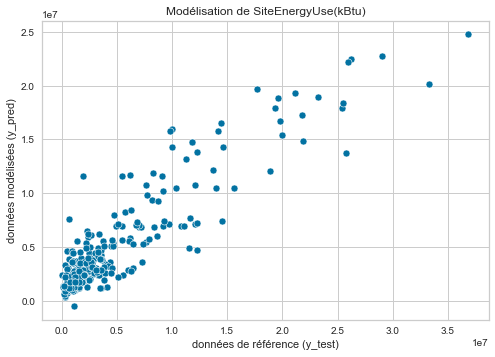

In [150]:
resultat = Test_modele_GSCV(nom_run='gradientboosting',
                            model=GradientBoostingRegressor(), 
                            grid_params=params, 
                            cv=3, 
                            score=score, 
                            pipe_preprocessing=preprocessor,
                            X_train=X_train,
                            y_train=y_train,
                            X_test=X_test,
                            y_test=y_test, 
                            resultat=resultat
                           )
resultat

#### investigation des valeurs négatives

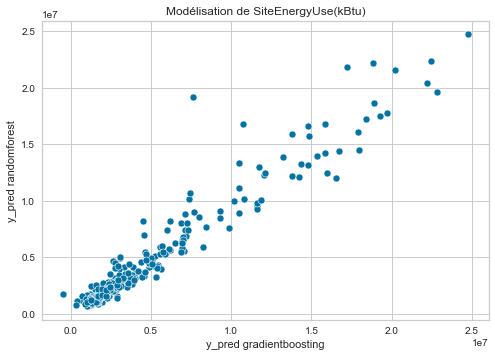

In [151]:
# graphe y_pred Gboosting vs y_pred Random Forest
sns.scatterplot(x='gradientboosting', y='randomforest', data=resultat.iloc[:316,:]);
plt.xlabel('y_pred gradientboosting')
plt.ylabel('y_pred randomforest')
plt.title('Modélisation de SiteEnergyUse(kBtu)');

In [152]:
resultat = nb_val_negatives(resultat, index_max=1254)
resultat.loc['nb valeurs negatives']

y_test               0.0
linearregression    34.0
ridge               22.0
lasso               11.0
elasticnet          22.0
kRR_rbf             10.0
randomforest           0
gradientboosting       1
Name: nb valeurs negatives, dtype: object

In [153]:
for model in resultat.columns:
    resultat.loc['nb valeurs negatives', model] = np.sum(resultat.loc[:1254,model] < 0)
resultat.loc['nb valeurs negatives']

y_test               0.0
linearregression    34.0
ridge               22.0
lasso               11.0
elasticnet          22.0
kRR_rbf             10.0
randomforest           0
gradientboosting       1
Name: nb valeurs negatives, dtype: object

### Comparaison des modèles

In [154]:
lignes = ['Duree calcul (s)', 'MSE', 'RMSE', 'RMSLE', 'RSE', 'R²', 'nb valeurs negatives']
comparaison = resultat.loc[lignes, :].T
comparaison = comparaison.drop('y_test', axis=0).reset_index()
comparaison

index Duree calcul (s)                   MSE            RMSE  \
0  linearregression         0.033699  7259952687194.916016  2694429.937333   
1             ridge            0.018  7055902963292.619141   2656294.96918   
2             lasso            0.035  7609199160200.882812  2758477.688908   
3        elasticnet         0.021977  7041834704685.294922  2653645.549934   
4           kRR_rbf         0.061001  8451686992302.908203  2907178.527766   
5      randomforest         0.413853  7180963061854.873047  2679731.901115   
6  gradientboosting         0.525611  6456059667422.838867  2540877.735631   

      RMSLE       RSE        R² nb valeurs negatives  
0       NaN  0.205837  0.794163                 34.0  
1       NaN  0.200051  0.799949                 22.0  
2       NaN  0.215738  0.784262                 11.0  
3       NaN  0.199652  0.800348                 22.0  
4       NaN  0.239625  0.760375                 10.0  
5  0.584255  0.203597  0.796403                    0  
6       NaN  0.183044  0.816956                    1

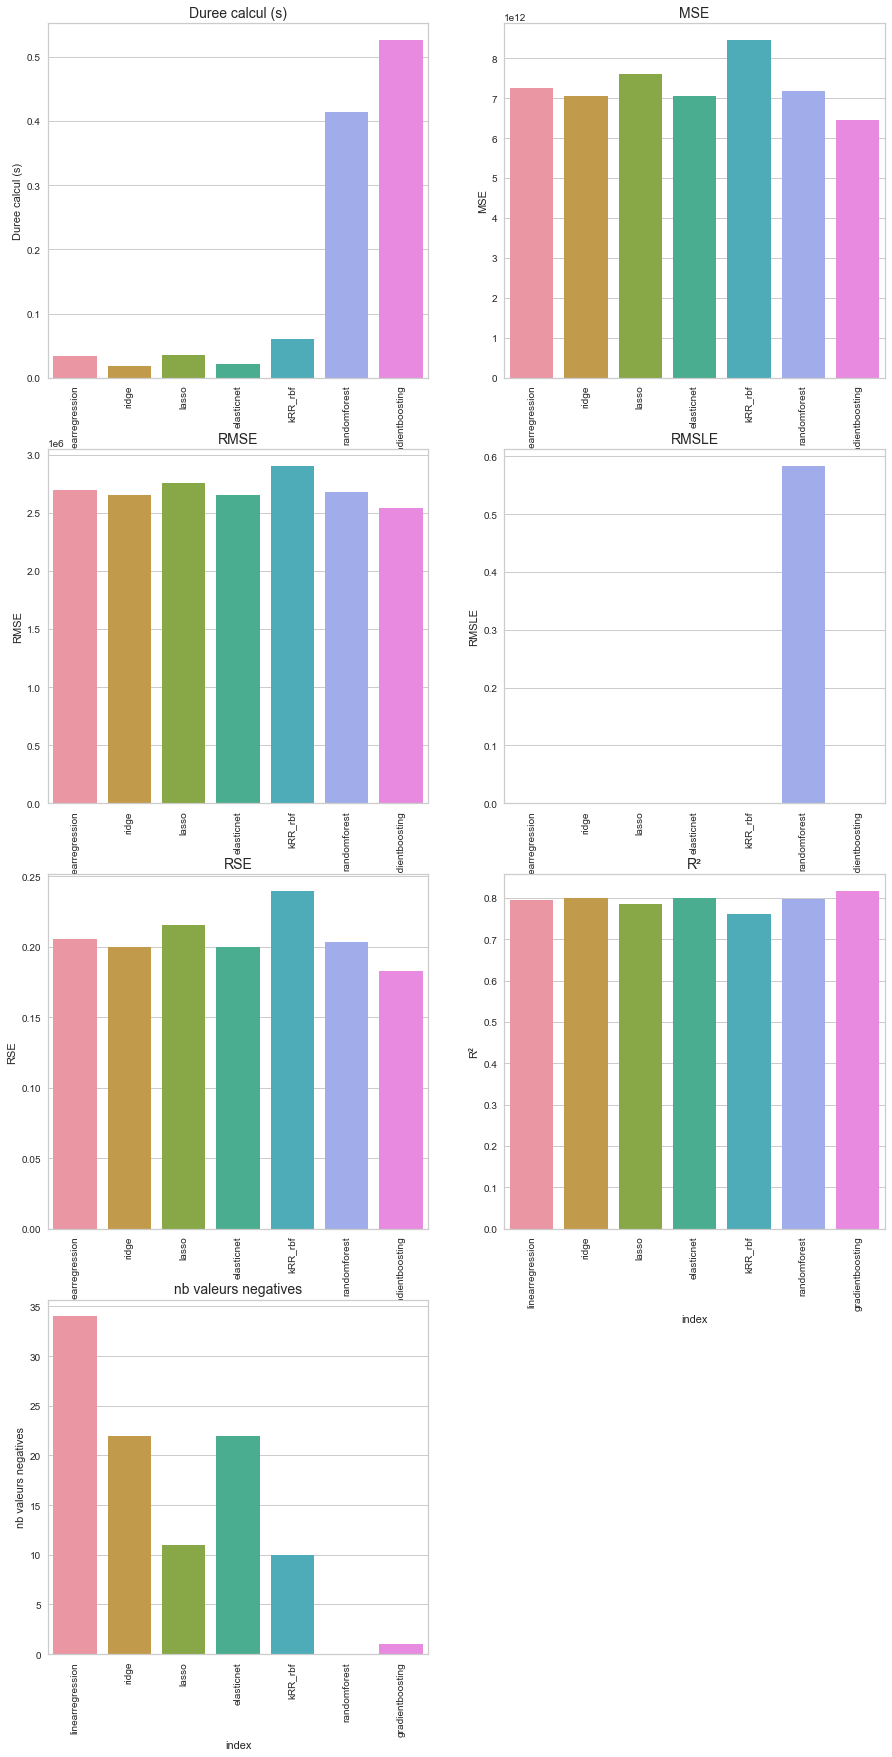

In [155]:
plt.figure(figsize=(15,30))
compteur = 1
for metrique in lignes:
    plt.subplot(4,2, compteur)
    sns.barplot(data=comparaison, x='index', y=metrique, label=False)
    plt.title(metrique, fontsize=14)
    plt.xticks(rotation = 90)
    compteur += 1
# sns.barplot(data=comparaison, x='index', y='R²')

In [156]:
resultat['gradientboosting'].tail(25)

1242                                              6845289.293311
1249                                              6193123.577345
1253                                              7603430.304247
1254                                             11708152.082676
Duree calcul (s)                                        0.525611
MSE                                         6456059667422.838867
RMSE                                              2540877.735631
RMSLE                                                        NaN
RSE                                                     0.183044
R²                                                      0.816956
elasticnet__alpha                                            NaN
elasticnet__l1_ratio                                         NaN
gradientboostingregressor__learning_rate                    0.01
gradientboostingregressor__loss                    squared_error
gradientboostingregressor__max_depth                         3.0
gradientboostingregressor

### CONCLUSION

La modélisation Ridge semble la plus pertinente :
- temps de modélisation le plus faible
- métriques parmis les meilleurs de tous les modèles testés

Par contre, il s'agit d'un modèle qui peut générer des valeurs négatives (22, soit 7% du jeu de test).

Si l'on souhaite un modèle qui ne prédit pas / très peu de valeur négative, alors il faut se tourner vers les modèles ensemblistes. Le GradientBoosting est un bon candidat car malgrès le nombre d'hyperparamètres à prendre en compte :
- il tourne relativement vite (<1 s),
- possède des métriques légèrement meilleures (R²=0.81) à la modélisation Ridge
- génère 0.3% de valeurs négatives.

## Utilisation du log pour la target

### Préparation des données

#### Target

In [157]:
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

### Baseline : régression linaire simple

In [158]:
start_time = timeit.default_timer()

model = make_pipeline(preprocessor, LinearRegression())

model.fit(X_train, y_train_log)
print(model.score(X_test, y_test_log))

elapsed = timeit.default_timer() - start_time

print(f'Temps d\'exécution : {elapsed:.2}s')

0.6305491560445992
Temps d'exécution : 0.039s


MSE : 0.50
RMSE : 0.70
RMSLE : 0.00
RSE : 0.37
R² : 0.63


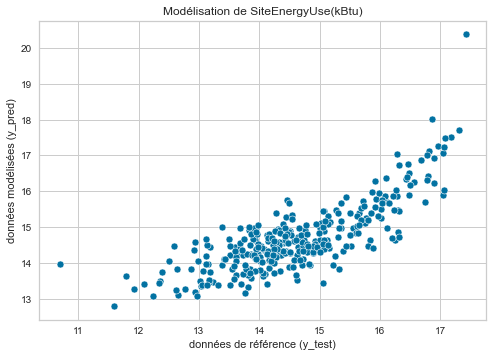

In [159]:
y_pred_log = model.predict(X_test)

# calcul metriques
print("MSE : {:.2f}".format(metrics.mean_squared_error(y_test_log, y_pred_log)))
print("RMSE : {:.2f}".format(np.sqrt( metrics.mean_squared_error(y_test_log, y_pred_log) )))
print("RMSLE : {:.2f}".format(metrics.mean_squared_log_error(y_test_log, y_pred_log)))
print("RSE : {:.2f}".format(1-metrics.r2_score(y_test_log, y_pred_log)))
print("R² : {:.2f}".format(metrics.r2_score(y_test_log, y_pred_log)))

sns.scatterplot(x=y_test_log, y=y_pred_log);
plt.xlabel('données de référence (y_test)')
plt.ylabel('données modélisées (y_pred)')
plt.title('Modélisation de SiteEnergyUse(kBtu)');

MSE : 1462730205369467.00
RMSE : 38245656.03
RMSLE : 0.50
RSE : 41.47
R² : -40.47


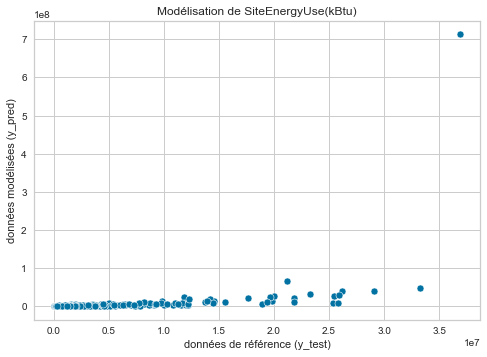

In [160]:
# rétablissement de la variable y
y_pred = np.expm1(y_pred_log)
y_test = np.expm1(y_test_log)

# calcul metriques
print("MSE : {:.2f}".format(metrics.mean_squared_error(y_test, y_pred)))
print("RMSE : {:.2f}".format(np.sqrt( metrics.mean_squared_error(y_test, y_pred) )))
print("RMSLE : {:.2f}".format(metrics.mean_squared_log_error(y_test, y_pred)))
print("RSE : {:.2f}".format(1-metrics.r2_score(y_test, y_pred)))
print("R² : {:.2f}".format(metrics.r2_score(y_test, y_pred)))

sns.scatterplot(x=y_test, y=y_pred);
plt.xlabel('données de référence (y_test)')
plt.ylabel('données modélisées (y_pred)')
plt.title('Modélisation de SiteEnergyUse(kBtu)');

La valeur la plus extrême est très mal représentée par le modèle => investigation sur cette valeur

In [161]:
y_pred[y_pred == y_pred.max()]

array([7.12781774e+08])

In [162]:
# la valeur maximale se trouve à l'index :
y_test[y_pred == y_pred.max()].index

Int64Index([722], dtype='int64')

In [163]:
data.loc[722,:]

Unnamed: 0                                         1431
PrimaryPropertyType               Senior Care Community
YearBuilt                                          2006
NumberofFloors                                     14.0
PropertyGFATotal                                 724148
PropertyGFAParking                                71790
LargestPropertyUseType            Senior Care Community
ThirdLargestPropertyUseTypeGFA                      NaN
ENERGYSTARScore                                    12.0
SiteEnergyUse(kBtu)                          36863348.0
GHGEmissions(MetricTonsCO2e)                     900.39
UseType                                           Other
train/test                                         test
Name: 722, dtype: object

In [164]:
# données dans le jeu d'entrainement qui sont supérieur à la valeur que le modèle n'arrive pas à prédire:
y_train[y_train > y_test.loc[722]]

397     37276920.0
145     38400928.0
88      37117212.0
1239    39061360.0
Name: SiteEnergyUse(kBtu), dtype: float64

In [165]:
data.loc[y_train[y_train > y_test.loc[722]].index,:]

Unnamed: 0 PrimaryPropertyType  YearBuilt  NumberofFloors  \
397          553               Other       1999             4.0   
145          215        Large Office       2009            36.0   
88           127  College/University       1970             2.0   
1239        3199        Large Office       2005             4.0   

      PropertyGFATotal  PropertyGFAParking LargestPropertyUseType  \
397             115748               18382                  Other   
145             824887              154972                 Office   
88              694072              111625     College/University   
1239            162157                   0                 Office   

      ThirdLargestPropertyUseTypeGFA  ENERGYSTARScore  SiteEnergyUse(kBtu)  \
397                              NaN              NaN           37276920.0   
145                              NaN             97.0           38400928.0   
88                               NaN              NaN           37117212.0   
1239                             NaN              NaN           39061360.0   

      GHGEmissions(MetricTonsCO2e)                     UseType train/test  
397                        1155.90               Other,NaN,NaN      train  
145                         267.71          Office,Parking,NaN      train  
88                          440.31  College/University,NaN,NaN      train  
1239                        466.95            Office,Other,NaN      train

==> ce sont des données très différentes de celle qu'on essaie de modéliser (type de building, surface totale assez variable)

==> décision de supprimer les valeurs target > 3.5e7 kBtu

In [166]:
data[data['SiteEnergyUse(kBtu)'] > 3.5e7]

Unnamed: 0    PrimaryPropertyType  YearBuilt  NumberofFloors  \
46            77           Large Office       2010             6.0   
88           127     College/University       1970             2.0   
145          215           Large Office       2009            36.0   
190          281                  Hotel       1973            19.0   
397          553                  Other       1999             4.0   
722         1431  Senior Care Community       2006            14.0   
1239        3199           Large Office       2005             4.0   

      PropertyGFATotal  PropertyGFAParking LargestPropertyUseType  \
46              920598              303707                 Office   
88              694072              111625     College/University   
145             824887              154972                 Office   
190             332067               59280                  Hotel   
397             115748               18382                  Other   
722             724148               71790  Senior Care Community   
1239            162157                   0                 Office   

      ThirdLargestPropertyUseTypeGFA  ENERGYSTARScore  SiteEnergyUse(kBtu)  \
46                            6000.0             93.0           36681188.0   
88                               NaN              NaN           37117212.0   
145                              NaN             97.0           38400928.0   
190                              NaN              8.0           35383012.0   
397                              NaN              NaN           37276920.0   
722                              NaN             12.0           36863348.0   
1239                             NaN              NaN           39061360.0   

      GHGEmissions(MetricTonsCO2e)                     UseType train/test  
46                          634.03        Office,Parking,Other      train  
88                          440.31  College/University,NaN,NaN      train  
145                         267.71          Office,Parking,NaN      train  
190                        1231.19               Hotel,NaN,NaN      train  
397                        1155.90               Other,NaN,NaN      train  
722                         900.39                       Other       test  
1239                        466.95            Office,Other,NaN      train

In [167]:
print('suppression de ',
     len(data[data['SiteEnergyUse(kBtu)'] > 3.5e7]), 'lignes')
data_log = data.drop(data[data['SiteEnergyUse(kBtu)'] > 3.5e7].index)
data_log.shape

suppression de  7 lignes


(1256, 13)

#### Preparation des données suite à la suppression de valeurs extrêmes

In [168]:
X = data_log.drop(['Unnamed: 0', 'SiteEnergyUse(kBtu)', 
               'GHGEmissions(MetricTonsCO2e)', 'train/test'], axis=1)
y = data_log['SiteEnergyUse(kBtu)']

X_quanti = X.select_dtypes(['float64', 'int64'])
X_categ = X.select_dtypes(['object'])

# selection des données en fonction des différents traitement à leur affecter
X_quanti_GFA = list(X_quanti.filter(regex='GFA').columns)
X_quanti_ESS = ['ENERGYSTARScore']
X_quanti_others = list(X_quanti.drop(X_quanti_GFA, axis=1).drop('ENERGYSTARScore', axis=1).columns)
X_categ = list(X_categ.columns)

# mise en place des pipelines pour les données quantitatives
GFA_pipeline = make_pipeline(SimpleImputer(strategy='constant', fill_value=0), StandardScaler())
ESS_pipeline = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())
Other_quanti_pipeline = make_pipeline(StandardScaler())
# et categorielles
categ_pipeline = make_pipeline(SimpleImputer(strategy='constant', fill_value='None'), OneHotEncoder())

preprocessor = make_column_transformer((GFA_pipeline, X_quanti_GFA), 
                                       (ESS_pipeline, X_quanti_ESS),
                                       (Other_quanti_pipeline, X_quanti_others),
                                       (categ_pipeline, X_categ))

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rs_opt)


y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

#### Nouvelle baseline

In [169]:
start_time = timeit.default_timer()

model = make_pipeline(preprocessor, LinearRegression())

model.fit(X_train, y_train_log)
print(model.score(X_test, y_test_log))

elapsed = timeit.default_timer() - start_time

print(f'Temps d\'exécution : {elapsed:.2}s')

0.6107367106415885
Temps d'exécution : 0.047s


MSE : 0.55
RMSE : 0.74
RMSLE : 0.00
RSE : 0.39
R² : 0.61


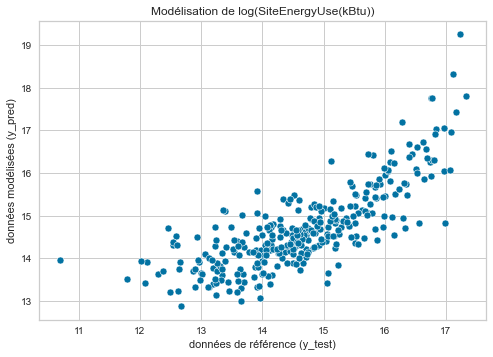

In [170]:
y_pred_log = model.predict(X_test)

# calcul metriques
print("MSE : {:.2f}".format(metrics.mean_squared_error(y_test_log, y_pred_log)))
print("RMSE : {:.2f}".format(np.sqrt( metrics.mean_squared_error(y_test_log, y_pred_log) )))
print("RMSLE : {:.2f}".format(metrics.mean_squared_log_error(y_test_log, y_pred_log)))
print("RSE : {:.2f}".format(1-metrics.r2_score(y_test_log, y_pred_log)))
print("R² : {:.2f}".format(metrics.r2_score(y_test_log, y_pred_log)))

sns.scatterplot(x=y_test_log, y=y_pred_log);
plt.xlabel('données de référence (y_test)')
plt.ylabel('données modélisées (y_pred)')
plt.title('Modélisation de log(SiteEnergyUse(kBtu))');

MSE : 157189060384154.69
RMSE : 12537506.15
RMSLE : 0.55
RSE : 4.62
R² : -3.62


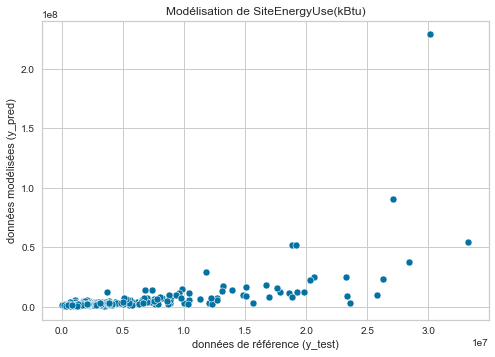

In [171]:
# rétablissement de la variable y
y_pred = np.expm1(y_pred_log)
y_test = np.expm1(y_test_log)

# calcul metriques
print("MSE : {:.2f}".format(metrics.mean_squared_error(y_test, y_pred)))
print("RMSE : {:.2f}".format(np.sqrt( metrics.mean_squared_error(y_test, y_pred) )))
print("RMSLE : {:.2f}".format(metrics.mean_squared_log_error(y_test, y_pred)))
print("RSE : {:.2f}".format(1-metrics.r2_score(y_test, y_pred)))
print("R² : {:.2f}".format(metrics.r2_score(y_test, y_pred)))

sns.scatterplot(x=y_test, y=y_pred);
plt.xlabel('données de référence (y_test)')
plt.ylabel('données modélisées (y_pred)')
plt.title('Modélisation de SiteEnergyUse(kBtu)');

Engendre encore une erreur sur les forte valeurs non négligeable

#### Visu

0.6107367106415885


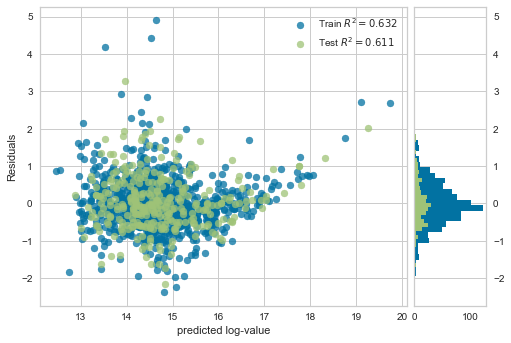

In [172]:
# visu des résidus du train_set et du test_set

model = make_pipeline(preprocessor, ResidualsPlot(LinearRegression()))

model.fit(X_train, y_train_log)
print(model.score(X_test, y_test_log))
plt.legend();
plt.xlabel('predicted log-value')
plt.ylabel('Residuals');

0.6107367106415885


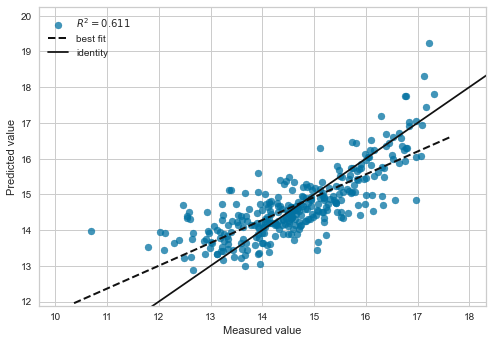

In [173]:
# visu des erreurs de prédiction
model = make_pipeline(preprocessor, PredictionError(LinearRegression()))

model.fit(X_train, y_train_log)
print(model.score(X_test, y_test_log))
plt.plot([0,4e7], [0,4e7], label='identity', c='k')
plt.legend();
plt.xlabel('Measured value')
plt.ylabel('Predicted value');

**CONCLUSION**

L'utilisation du log(target) ne permet pas d'améliorer la prédiction du modèle voir même **engendre plus d'erreur** sur les fortes valeurs

In [174]:
# initialisation du fichier résultat global avec les données de test
resultat_log = y_test_log.copy()
resultat_log = pd.DataFrame(resultat_log)
resultat_log.columns = ['y_test_log']

# compilation des données de la regression linéaire
result_log = pd.DataFrame()
# calcul metriques
result_log.loc['MSE', 'LinearRegression'] = metrics.mean_squared_error(y_test_log, y_pred_log)
result_log.loc['RMSE', 'LinearRegression'] = np.sqrt( metrics.mean_squared_error(y_test_log, y_pred_log) )
if min(y_pred_log) > 0:
    result_log.loc['RMSLE', 'LinearRegression'] = metrics.mean_squared_log_error(y_test_log, y_pred_log)
else:
    result_log.loc['RMSLE', 'LinearRegression'] = np.nan
result_log.loc['RSE', 'LinearRegression'] = 1-metrics.r2_score(y_test_log, y_pred_log)
result_log.loc['R²', 'LinearRegression'] = metrics.r2_score(y_test_log, y_pred_log)
result_log.loc['Duree calcul (s)', 'LinearRegression'] = elapsed

    
# Stockage données modélisées vs données test
y_pred_log = pd.DataFrame(y_pred_log, index=y_test_log.index)
y_pred_log.columns = ['LinearRegression']
result_log = pd.concat([result_log, y_pred_log])

# merge du fichier resultat avec le fichier result
resultat_log = resultat_log.merge(result_log, left_index=True, right_index=True, sort=False, how='outer')
resultat_log

y_test_log  LinearRegression
2       16.304740         14.955704
9       17.320182         17.803598
13      14.143892         14.735572
19      12.633697         13.749319
31      15.721028         15.741139
...           ...               ...
MSE           NaN          0.545650
RMSE          NaN          0.738681
RMSLE         NaN          0.002351
RSE           NaN          0.389263
R²            NaN          0.610737

[320 rows x 2 columns]

### Regression RIDGE

Temps d'exécution : 8.13s
Durée du gridSearchCV :  8.130236100000047
MSE : 0.53
RMSE : 0.53
RMSLE : 0.00
RSE : 0.38
R² : 0.62


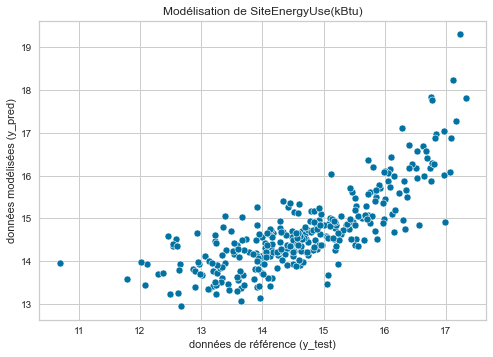

In [175]:
# hyperparamètres à tester
n_alpha = 100
alphas = np.logspace(-5, 5, n_alpha)
score = 'neg_root_mean_squared_error'
params = {'ridge__alpha':alphas}

# modelisation
resultat_log = Test_modele_GSCV(nom_run='ridge',
                            model=Ridge(), 
                            grid_params=params, 
                            cv=3, 
                            score=score, 
                            pipe_preprocessing=preprocessor,
                            X_train=X_train,
                            y_train=y_train_log,
                            X_test=X_test,
                            y_test=y_test_log, 
                            resultat=resultat_log
                           )

In [176]:
resultat_log.tail(10)

y_test_log  LinearRegression      ridge
1253               13.385211         15.119867  15.048530
1258               15.118724         16.292005  16.027758
1260               16.632761         16.722054  16.682570
Duree calcul (s)         NaN          0.047228   0.013153
MSE                      NaN          0.545650   0.529328
RMSE                     NaN          0.738681   0.727550
RMSLE                    NaN          0.002351   0.002289
RSE                      NaN          0.389263   0.377620
R²                       NaN          0.610737   0.622380
ridge__alpha             NaN               NaN   9.111628

### Regression LASSO

Temps d'exécution : 8.99s
Durée du gridSearchCV :  8.989169100000026
MSE : 0.53
RMSE : 0.53
RMSLE : 0.00
RSE : 0.38
R² : 0.62


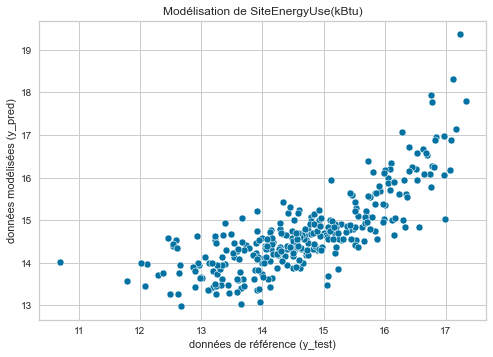

In [177]:
# hyperparamètres à tester
n_alphas = 200
alphas = np.logspace(-3, 8, n_alphas)
score = 'neg_root_mean_squared_error'
params = {'lasso__alpha':alphas}

# modelisation
resultat_log = Test_modele_GSCV(nom_run='lasso',
                            model=Lasso(), 
                            grid_params=params, 
                            cv=2, 
                            score=score, 
                            pipe_preprocessing=preprocessor,
                            X_train=X_train,
                            y_train=y_train_log,
                            X_test=X_test,
                            y_test=y_test_log, 
                            resultat=resultat_log
                           )

In [178]:
resultat_log.tail(10)

y_test_log  LinearRegression      ridge      lasso
1258               15.118724         16.292005  16.027758  15.932467
1260               16.632761         16.722054  16.682570  16.674297
Duree calcul (s)         NaN          0.047228   0.013153   0.056658
MSE                      NaN          0.545650   0.529328   0.532573
RMSE                     NaN          0.738681   0.727550   0.729776
RMSLE                    NaN          0.002351   0.002289   0.002303
RSE                      NaN          0.389263   0.377620   0.379935
R²                       NaN          0.610737   0.622380   0.620065
lasso__alpha             NaN               NaN        NaN   0.003571
ridge__alpha             NaN               NaN   9.111628        NaN

### Regression ELASTICNET

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 162.9167112944554, tolerance: 0.09091794372429376
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 154.44674880679074, tolerance: 0.0850816789190545
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 142.87996200653672, tolerance: 0.07838502211030939
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_d

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 166.73054883115645, tolerance: 0.09091794372429376
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 159.17780197834134, tolerance: 0.0850816789190545
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 146.50338694644586, tolerance: 0.07838502211030939
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 175.29875090427876, tolerance: 0.09091794372429376
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 168.80580512841087, tolerance: 0.0850816789190545
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 154.1151042728788, tolerance: 0.07838502211030939
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_d

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 193.12964800023107, tolerance: 0.09091794372429376
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 186.8777293825079, tolerance: 0.0850816789190545
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 169.01163681865202, tolerance: 0.07838502211030939
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_d

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 224.00059967592622, tolerance: 0.09091794372429376
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 215.84859724164804, tolerance: 0.0850816789190545
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 194.90394420407534, tolerance: 0.07838502211030939
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 267.315203292064, tolerance: 0.09091794372429376
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 255.28780921665006, tolerance: 0.0850816789190545
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 232.31562445162, tolerance: 0.07838502211030939
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_desce

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 320.32592410682764, tolerance: 0.09091794372429376
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 304.0429246202626, tolerance: 0.0850816789190545
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 278.6601784679644, tolerance: 0.07838502211030939
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_de

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 377.01551299391474, tolerance: 0.09091794372429376
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 356.154118169207, tolerance: 0.0850816789190545
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 327.4221709259301, tolerance: 0.07838502211030939
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_des

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 420.28479139626745, tolerance: 0.09091794372429376
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 395.16499736852484, tolerance: 0.0850816789190545
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 363.7211615393629, tolerance: 0.07838502211030939
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_d

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 442.0665794857493, tolerance: 0.09091794372429376
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 414.4442419811341, tolerance: 0.0850816789190545
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 381.68665921694736, tolerance: 0.07838502211030939
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_de

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 450.4073771603402, tolerance: 0.09091794372429376
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 421.75671078380424, tolerance: 0.0850816789190545
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 388.51303846925464, tolerance: 0.07838502211030939
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_d

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 453.23787127127, tolerance: 0.09091794372429376
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 424.22917603876783, tolerance: 0.0850816789190545
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 390.82302696561953, tolerance: 0.07838502211030939
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_des

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 454.15751101189625, tolerance: 0.09091794372429376
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 425.03149435086556, tolerance: 0.0850816789190545
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 391.5728385695177, tolerance: 0.07838502211030939
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_d

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 454.4520217401849, tolerance: 0.09091794372429376
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 425.28832982444203, tolerance: 0.0850816789190545
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 391.8128887059282, tolerance: 0.07838502211030939
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_de

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 454.54589929679895, tolerance: 0.09091794372429376
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 425.3701875357143, tolerance: 0.0850816789190545
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 391.88939900491573, tolerance: 0.07838502211030939
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_d

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 454.575778995776, tolerance: 0.09091794372429376
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 425.3962404413465, tolerance: 0.0850816789190545
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 391.9137502252401, tolerance: 0.07838502211030939
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_desc

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 454.585284711658, tolerance: 0.09091794372429376
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 425.4045286197317, tolerance: 0.0850816789190545
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 391.9214970728106, tolerance: 0.07838502211030939
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_desc

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 454.5883083367804, tolerance: 0.09091794372429376
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 425.40716495352046, tolerance: 0.0850816789190545
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 391.9239612205842, tolerance: 0.07838502211030939
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_de

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 454.5892700602753, tolerance: 0.09091794372429376
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 425.4080034902708, tolerance: 0.0850816789190545
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 391.92474499050303, tolerance: 0.07838502211030939
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_de

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 454.5895759506981, tolerance: 0.09091794372429376
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 425.40827019920977, tolerance: 0.0850816789190545
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 391.9249942800714, tolerance: 0.07838502211030939
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_de

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 454.5896732432122, tolerance: 0.09091794372429376
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 425.4083550295208, tolerance: 0.0850816789190545
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 391.9250735699234, tolerance: 0.07838502211030939
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_des

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 454.58970418834144, tolerance: 0.09091794372429376
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 425.40838201088576, tolerance: 0.0850816789190545
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 391.9250987890748, tolerance: 0.07838502211030939
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_d

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 454.589714030831, tolerance: 0.09091794372429376
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 425.40839059264994, tolerance: 0.0850816789190545
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 391.92510681034463, tolerance: 0.07838502211030939
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_de

Temps d'exécution : 4.57min
Durée du gridSearchCV :  274.1643767999999
MSE : 0.53
RMSE : 0.53
RMSLE : 0.00
RSE : 0.38
R² : 0.62


y_test_log  LinearRegression      ridge      lasso  \
2                      16.304740         14.955704  14.975140  15.006631   
9                      17.320182         17.803598  17.810496  17.794936   
13                     14.143892         14.735572  14.738598  14.771124   
19                     12.633697         13.749319  13.798667  13.759458   
31                     15.721028         15.741139  15.564994  15.575336   
...                          ...               ...        ...        ...   
R²                           NaN          0.610737   0.622380   0.620065   
elasticnet__alpha            NaN               NaN        NaN        NaN   
elasticnet__l1_ratio         NaN               NaN        NaN        NaN   
lasso__alpha                 NaN               NaN        NaN   0.003571   
ridge__alpha                 NaN               NaN   9.111628        NaN   

                      elasticnet  
2                      15.007143  
9                      17.797659  
13                     14.765449  
19                     13.824953  
31                     15.571251  
...                          ...  
R²                      0.621844  
elasticnet__alpha       0.006748  
elasticnet__l1_ratio    0.400000  
lasso__alpha                 NaN  
ridge__alpha                 NaN  

[324 rows x 5 columns]

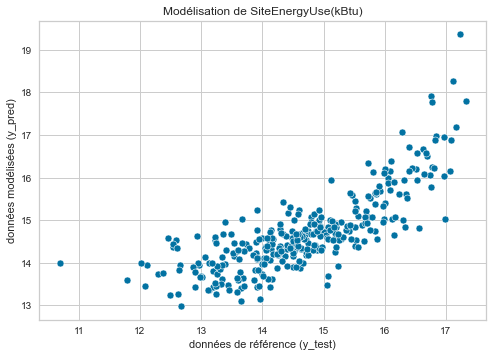

In [179]:
# hyperparamètres à tester
n_alphas = 200
alphas = np.logspace(-3, 8, n_alphas)
l1ratios = np.arange(0,1.1,0.1)

params = {'elasticnet__alpha':alphas,
          'elasticnet__l1_ratio':l1ratios
         }

score = 'neg_root_mean_squared_error'

# modelisation
resultat_log = Test_modele_GSCV(nom_run='elasticnet',
                            model=ElasticNet(), 
                            grid_params=params, 
                            cv=3, 
                            score=score, 
                            pipe_preprocessing=preprocessor,
                            X_train=X_train,
                            y_train=y_train_log,
                            X_test=X_test,
                            y_test=y_test_log, 
                            resultat=resultat_log
                           )
resultat_log

### kRR

Temps d'exécution : 1.66min
Durée du gridSearchCV :  99.6602461
MSE : 0.42
RMSE : 0.42
RMSLE : 0.00
RSE : 0.30
R² : 0.70


y_test_log  LinearRegression      ridge      lasso  \
2                      16.304740         14.955704  14.975140  15.006631   
9                      17.320182         17.803598  17.810496  17.794936   
13                     14.143892         14.735572  14.738598  14.771124   
19                     12.633697         13.749319  13.798667  13.759458   
31                     15.721028         15.741139  15.564994  15.575336   
...                          ...               ...        ...        ...   
elasticnet__l1_ratio         NaN               NaN        NaN        NaN   
kernelridge__alpha           NaN               NaN        NaN        NaN   
kernelridge__gamma           NaN               NaN        NaN        NaN   
lasso__alpha                 NaN               NaN        NaN   0.003571   
ridge__alpha                 NaN               NaN   9.111628        NaN   

                      elasticnet    kRR_rbf  
2                      15.007143  15.587816  
9                      17.797659  16.889773  
13                     14.765449  14.721259  
19                     13.824953  14.170659  
31                     15.571251  15.813502  
...                          ...        ...  
elasticnet__l1_ratio    0.400000        NaN  
kernelridge__alpha           NaN   0.006723  
kernelridge__gamma           NaN   0.003360  
lasso__alpha                 NaN        NaN  
ridge__alpha                 NaN        NaN  

[326 rows x 6 columns]

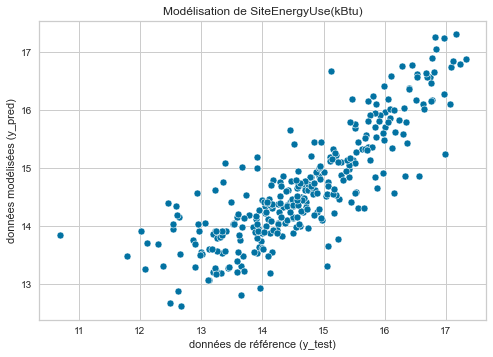

In [180]:
# valeurs du paramètre de régularisation
alpha_range = np.logspace(-3, -1, 30)
# valeurs du paramètre gamma
gamma_range = np.logspace(-3, -1, 20)

# grille de paramètres
params = {'kernelridge__alpha': alpha_range, 
          'kernelridge__gamma': gamma_range}

# score pour sélectionner le modèle optimal
score = 'neg_root_mean_squared_error'

# modelisation
resultat_log = Test_modele_GSCV(nom_run='kRR_rbf',
                            model=KernelRidge(kernel='rbf'), 
                            grid_params=params, 
                            cv=3, 
                            score=score, 
                            pipe_preprocessing=preprocessor,
                            X_train=X_train,
                            y_train=y_train_log,
                            X_test=X_test,
                            y_test=y_test_log, 
                            resultat=resultat_log
                           )
resultat_log

### Bagging : RandomForest

Temps d'exécution : 1.85min
Durée du gridSearchCV :  111.06845980000026
MSE : 0.41
RMSE : 0.41
RMSLE : 0.00
RSE : 0.29
R² : 0.71


y_test_log  LinearRegression      ridge  \
2                                     16.304740         14.955704  14.975140   
9                                     17.320182         17.803598  17.810496   
13                                    14.143892         14.735572  14.738598   
19                                    12.633697         13.749319  13.798667   
31                                    15.721028         15.741139  15.564994   
...                                         ...               ...        ...   
lasso__alpha                                NaN               NaN        NaN   
randomforestregressor__max_depth            NaN               NaN        NaN   
randomforestregressor__max_features         NaN               NaN        NaN   
randomforestregressor__n_estimators         NaN               NaN        NaN   
ridge__alpha                                NaN               NaN   9.111628   

                                         lasso  elasticnet    kRR_rbf  \
2                                    15.006631   15.007143  15.587816   
9                                    17.794936   17.797659  16.889773   
13                                   14.771124   14.765449  14.721259   
19                                   13.759458   13.824953  14.170659   
31                                   15.575336   15.571251  15.813502   
...                                        ...         ...        ...   
lasso__alpha                          0.003571         NaN        NaN   
randomforestregressor__max_depth           NaN         NaN        NaN   
randomforestregressor__max_features        NaN         NaN        NaN   
randomforestregressor__n_estimators        NaN         NaN        NaN   
ridge__alpha                               NaN         NaN        NaN   

                                    randomforest  
2                                      15.516313  
9                                      16.917777  
13                                     15.065041  
19                                     14.102245  
31                                     15.643152  
...                                          ...  
lasso__alpha                                 NaN  
randomforestregressor__max_depth            10.0  
randomforestregressor__max_features         auto  
randomforestregressor__n_estimators        100.0  
ridge__alpha                                 NaN  

[329 rows x 7 columns]

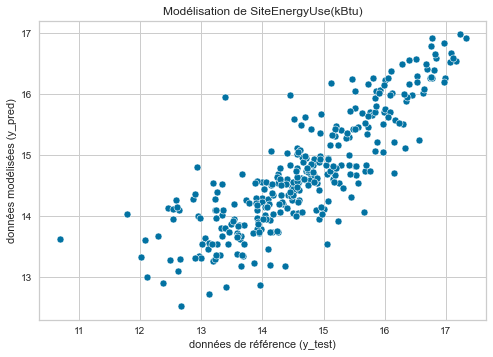

In [181]:
# grille de paramètres
n_estimator_range = [10, 50, 100, 250, 500, 750]
max_depth_range = [1, 2, 3, 4, 5, 10]
max_features_range = ['auto', 'sqrt', 'log2']
params = {"randomforestregressor__n_estimators":n_estimator_range,
          "randomforestregressor__max_depth":max_depth_range, 
          "randomforestregressor__max_features":max_features_range}

# score pour sélectionner le modèle optimal
score = 'neg_root_mean_squared_error'

# modelisation
resultat_log = Test_modele_GSCV(nom_run='randomforest',
                            model=RandomForestRegressor(), 
                            grid_params=params, 
                            cv=3, 
                            score=score, 
                            pipe_preprocessing=preprocessor,
                            X_train=X_train,
                            y_train=y_train_log,
                            X_test=X_test,
                            y_test=y_test_log, 
                            resultat=resultat_log
                           )
resultat_log

### Boosting : GBoost

Temps d'exécution : 6.00min
Durée du gridSearchCV :  360.1561511
MSE : 0.40
RMSE : 0.40
RMSLE : 0.00
RSE : 0.28
R² : 0.72


y_test_log  LinearRegression      ridge  \
2                                     16.304740         14.955704  14.975140   
9                                     17.320182         17.803598  17.810496   
13                                    14.143892         14.735572  14.738598   
19                                    12.633697         13.749319  13.798667   
31                                    15.721028         15.741139  15.564994   
...                                         ...               ...        ...   
lasso__alpha                                NaN               NaN        NaN   
randomforestregressor__max_depth            NaN               NaN        NaN   
randomforestregressor__max_features         NaN               NaN        NaN   
randomforestregressor__n_estimators         NaN               NaN        NaN   
ridge__alpha                                NaN               NaN   9.111628   

                                         lasso  elasticnet    kRR_rbf  \
2                                    15.006631   15.007143  15.587816   
9                                    17.794936   17.797659  16.889773   
13                                   14.771124   14.765449  14.721259   
19                                   13.759458   13.824953  14.170659   
31                                   15.575336   15.571251  15.813502   
...                                        ...         ...        ...   
lasso__alpha                          0.003571         NaN        NaN   
randomforestregressor__max_depth           NaN         NaN        NaN   
randomforestregressor__max_features        NaN         NaN        NaN   
randomforestregressor__n_estimators        NaN         NaN        NaN   
ridge__alpha                               NaN         NaN        NaN   

                                    randomforest gradientboosting  
2                                      15.516313        16.066342  
9                                      16.917777        16.941823  
13                                     15.065041        15.219026  
19                                     14.102245        13.696582  
31                                     15.643152        16.026023  
...                                          ...              ...  
lasso__alpha                                 NaN              NaN  
randomforestregressor__max_depth            10.0              NaN  
randomforestregressor__max_features         auto              NaN  
randomforestregressor__n_estimators        100.0              NaN  
ridge__alpha                                 NaN              NaN  

[334 rows x 8 columns]

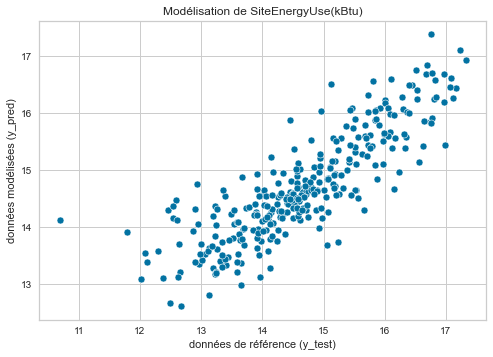

In [182]:
# grille de paramètres
n_estimators_range = [10, 100, 500]
max_depth_range = [1, 3, 5, 10]
max_features_range = ['auto', 'sqrt', 'log2']
learning_rate_range = [0.01, 0.1, 0.5 , 1]
loss_range = ['squared_error', 'absolute_error']
params = {"gradientboostingregressor__n_estimators":n_estimators_range,
          "gradientboostingregressor__max_depth":max_depth_range, 
          "gradientboostingregressor__max_features":max_features_range, 
          'gradientboostingregressor__learning_rate':learning_rate_range,
          'gradientboostingregressor__loss':loss_range
         }

# score pour sélectionner le modèle optimal
score = 'neg_root_mean_squared_error'

# Modélisation
resultat_log = Test_modele_GSCV(nom_run='gradientboosting',
                            model=GradientBoostingRegressor(), 
                            grid_params=params, 
                            cv=3, 
                            score=score, 
                            pipe_preprocessing=preprocessor,
                            X_train=X_train,
                            y_train=y_train_log,
                            X_test=X_test,
                            y_test=y_test_log, 
                            resultat=resultat_log
                           )
resultat_log

In [183]:
resultat_log['kRR_rbf'].tail(25)

1246                                        14.359115
1249                                        14.620495
1253                                        15.102193
1258                                        16.672702
1260                                        16.105588
Duree calcul (s)                             0.060772
MSE                                          0.417030
RMSE                                         0.645779
RMSLE                                        0.001845
RSE                                          0.297507
R²                                           0.702493
elasticnet__alpha                                 NaN
elasticnet__l1_ratio                              NaN
gradientboostingregressor__learning_rate          NaN
gradientboostingregressor__loss                   NaN
gradientboostingregressor__max_depth              NaN
gradientboostingregressor__max_features           NaN
gradientboostingregressor__n_estimators           NaN
kernelridge__alpha          

### Comparaison des modélisations

In [184]:
lignes = ['Duree calcul (s)', 'MSE', 'RMSE', 'RMSLE', 'RSE', 'R²']
comparaison_log = resultat_log.loc[lignes, :].T
comparaison_log = comparaison_log.drop('y_test_log', axis=0).reset_index()
comparaison_log

index Duree calcul (s)       MSE      RMSE     RMSLE       RSE  \
0  LinearRegression         0.047228   0.54565  0.738681  0.002351  0.389263   
1             ridge         0.013153  0.529328   0.72755  0.002289   0.37762   
2             lasso         0.056658  0.532573  0.729776  0.002303  0.379935   
3        elasticnet         0.025151   0.53008  0.728066  0.002292  0.378156   
4           kRR_rbf         0.060772   0.41703  0.645779  0.001845  0.297507   
5      randomforest           0.4726  0.409809  0.640163  0.001816  0.292355   
6  gradientboosting         0.741455  0.399014  0.631675  0.001755  0.284654   

         R²  
0  0.610737  
1   0.62238  
2  0.620065  
3  0.621844  
4  0.702493  
5  0.707645  
6  0.715346

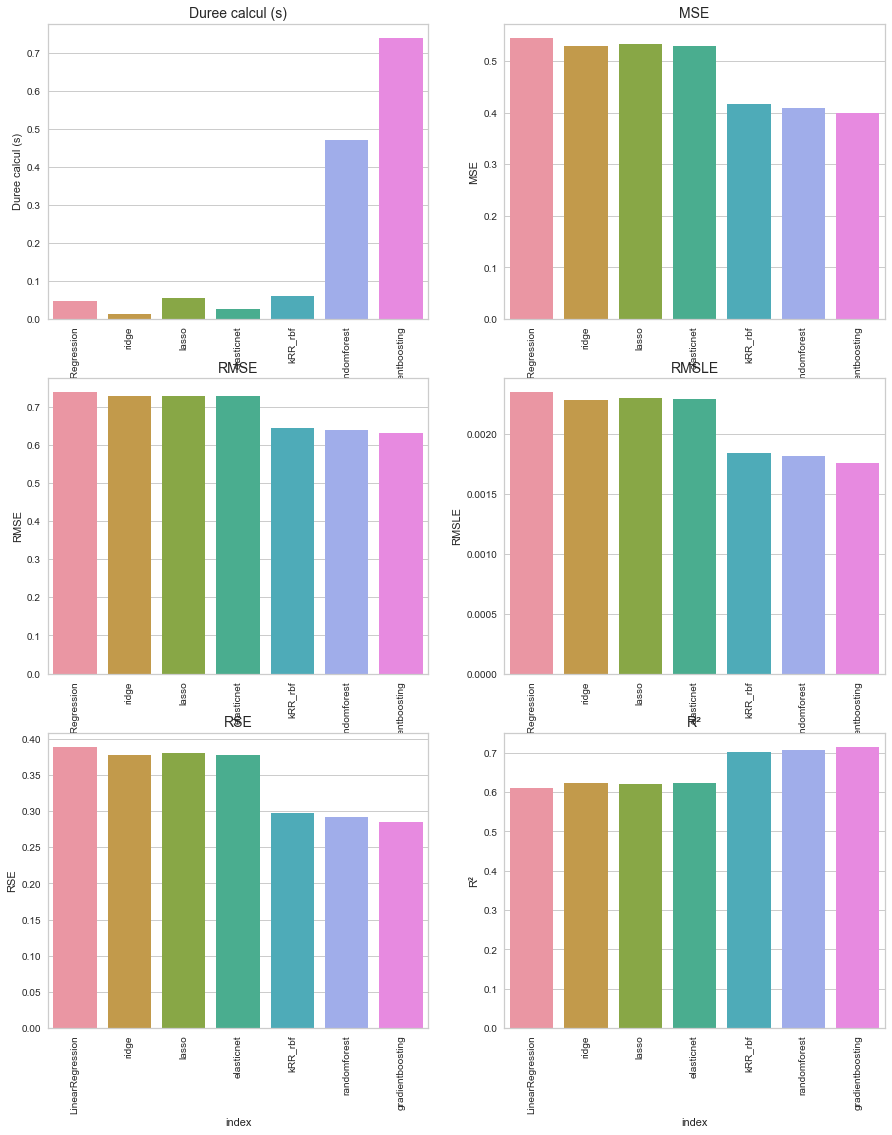

In [185]:
plt.figure(figsize=(15,25))
compteur = 1
for metrique in lignes:
    plt.subplot(4,2, compteur)
    sns.barplot(data=comparaison_log, x='index', y=metrique, label=False)
    plt.title(metrique, fontsize=14)
    plt.xticks(rotation = 90)
    compteur += 1

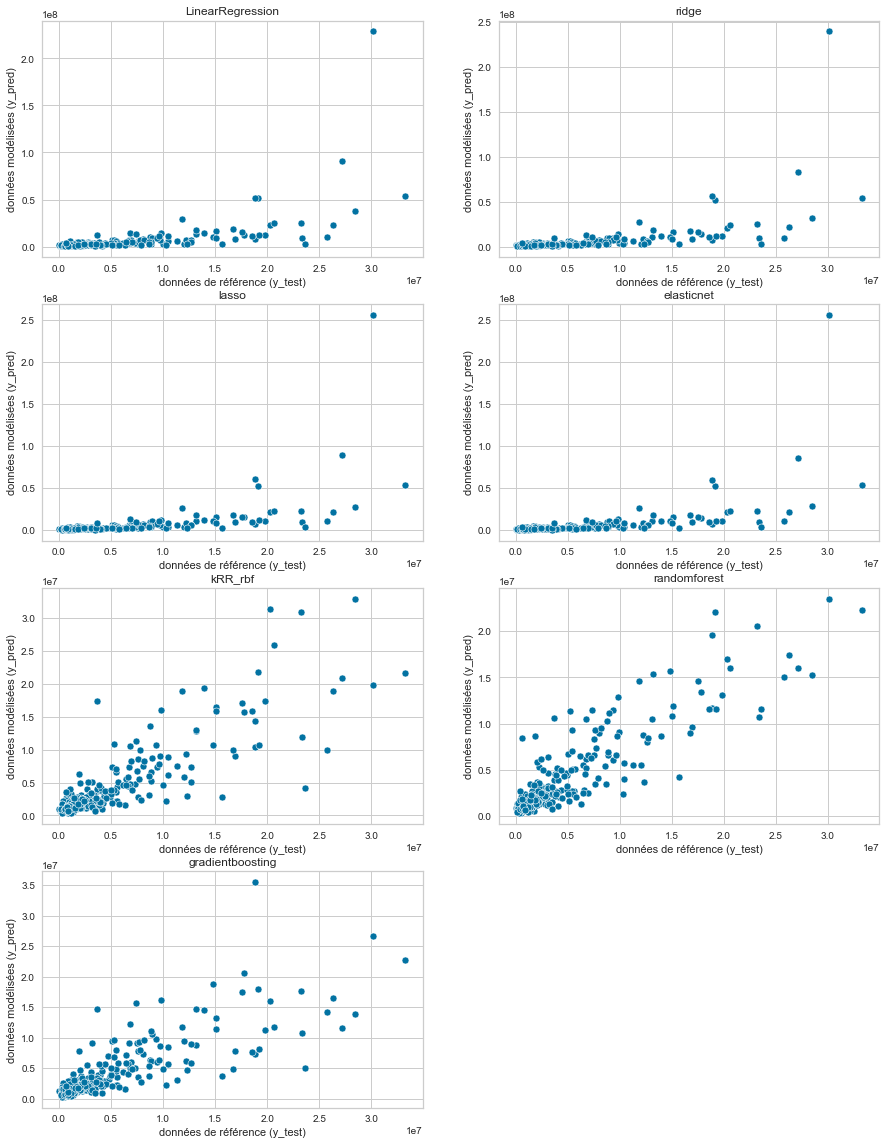

In [186]:
# transformation log(y) -> y
comparaison_y = resultat_log.loc[:1260,:]
comparaison_y = comparaison_y.astype({'randomforest':'float',
                                      'gradientboosting':'float'
                                     })
comparaison_y_noLog = np.expm1(comparaison_y)
compteur = 1

plt.figure(figsize=(15,20))

for model in comparaison_y_noLog.drop('y_test_log', axis=1).columns:
    plt.subplot(4,2, compteur)
    sns.scatterplot(x='y_test_log', y=model, data=comparaison_y_noLog);
    plt.xlabel('données de référence (y_test)')
    plt.ylabel('données modélisées (y_pred)')
    plt.title(model)
    compteur += 1

Les modèles non linéaires permettent de mieux représenter la valeur cible quand un log est appliqué

In [187]:
# calcul des metriques pour comparer avec le premier jeu de modélisations
comparaison_metriques=pd.DataFrame()
for model in comparaison_y_noLog.columns:
    # calcul metriques
    comparaison_metriques.loc['MSE', model] = metrics.mean_squared_error(comparaison_y_noLog['y_test_log'], 
                                                          comparaison_y_noLog[model])
    comparaison_metriques.loc['RMSE', model] = np.sqrt( metrics.mean_squared_error(comparaison_y_noLog['y_test_log'],
                                                                      comparaison_y_noLog[model]) )
    if min(comparaison_y_noLog[model]) > 0:
        comparaison_metriques.loc['RMSLE', model] = metrics.mean_squared_log_error(comparaison_y_noLog['y_test_log'],
                                                                      comparaison_y_noLog[model])
    else:
        comparaison_metriques.loc['RMSLE', model] = np.nan
    comparaison_metriques.loc['RSE', model] = 1-metrics.r2_score(comparaison_y_noLog['y_test_log'],
                                                    comparaison_y_noLog[model])
    comparaison_metriques.loc['R²', model] = metrics.r2_score(comparaison_y_noLog['y_test_log'],
                                                 comparaison_y_noLog[model])

In [188]:
comparaison_metriques = comparaison_metriques.T
comparaison_metriques = comparaison_metriques.drop('y_test_log', axis=0).reset_index()
comparaison_metriques

index           MSE          RMSE     RMSLE       RSE        R²
0  LinearRegression  1.571891e+14  1.253751e+07  0.545650  4.618634 -3.618634
1             ridge  1.689478e+14  1.299799e+07  0.529328  4.964137 -3.964137
2             lasso  1.943795e+14  1.394200e+07  0.532573  5.711388 -4.711388
3        elasticnet  1.928328e+14  1.388643e+07  0.530080  5.665943 -4.665943
4           kRR_rbf  9.634842e+12  3.104004e+06  0.417030  0.283097  0.716903
5      randomforest  8.317279e+12  2.883969e+06  0.409809  0.244384  0.755616
6  gradientboosting  1.184299e+13  3.441365e+06  0.399014  0.347979  0.652021

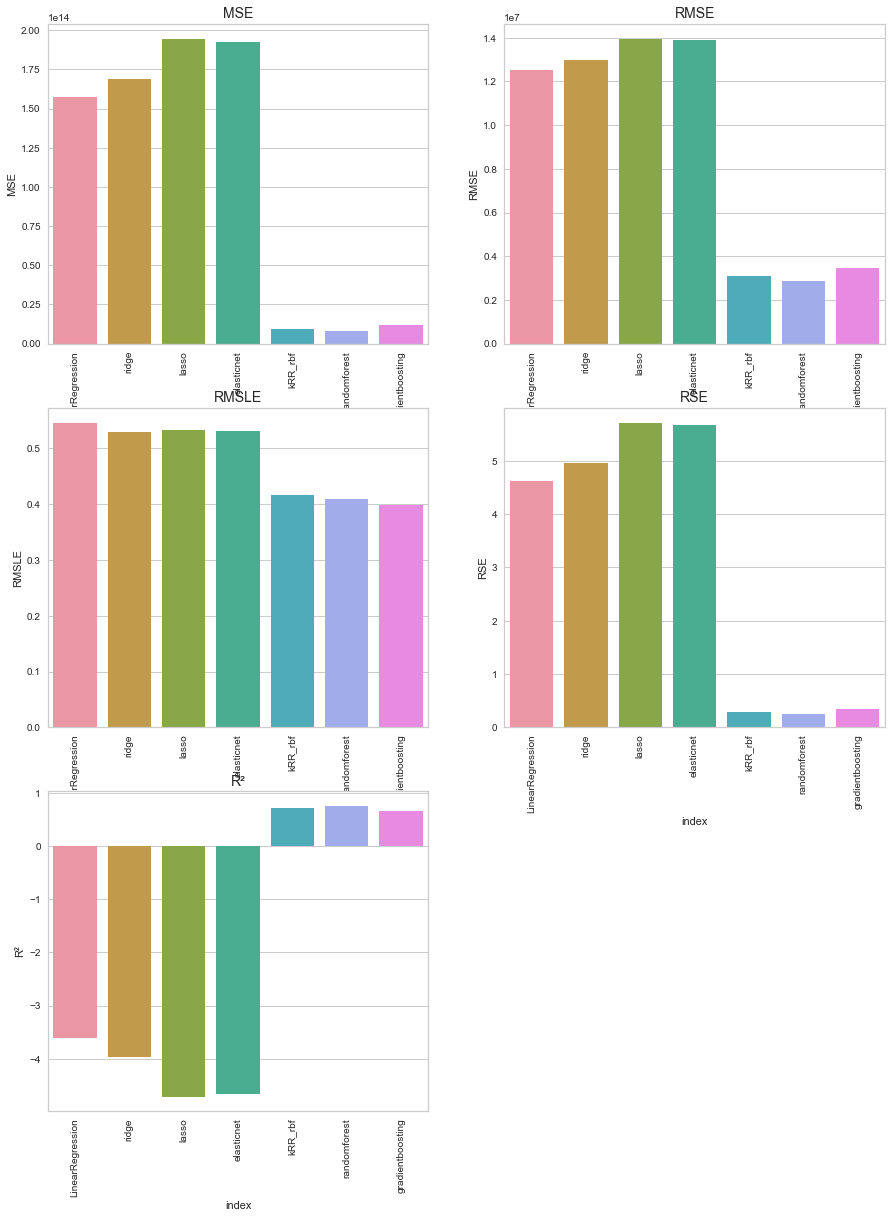

In [189]:
plt.figure(figsize=(15,20))
compteur = 1
for metrique in comparaison_metriques.loc[:,'MSE':].columns:
    plt.subplot(3,2, compteur)
    sns.barplot(data=comparaison_metriques, x='index', y=metrique, label=False)
    plt.title(metrique, fontsize=14)
    plt.xticks(rotation = 90)
    compteur += 1

### CONCLUSION
Le passage en log de la target ne permet pas d'améliorer la capacité de prédiction des modèles, même en utilisant des modèles non-linéaires

## Sans la variable EnergyStarScore - sans log(target)

### Préparation des données

In [190]:
X = data.drop(['Unnamed: 0', 'SiteEnergyUse(kBtu)', 
               'GHGEmissions(MetricTonsCO2e)', 
               'ENERGYSTARScore', 'train/test'], axis=1)
y = data['SiteEnergyUse(kBtu)']

X_quanti = X.select_dtypes(['float64', 'int64'])
X_categ = X.select_dtypes(['object'])

# selection des données en fonction des différents traitement à leur affecter
X_quanti_GFA = list(X_quanti.filter(regex='GFA').columns)
X_quanti_others = list(X_quanti.drop(X_quanti_GFA, axis=1).columns)
X_categ = list(X_categ.columns)

# mise en place des pipelines pour les données quantitatives
GFA_pipeline = make_pipeline(SimpleImputer(strategy='constant', fill_value=0), StandardScaler())
Other_quanti_pipeline = make_pipeline(StandardScaler())
# et categorielles
categ_pipeline = make_pipeline(SimpleImputer(strategy='constant', fill_value='None'), OneHotEncoder())

preprocessor = make_column_transformer((GFA_pipeline, X_quanti_GFA), 
                                       (Other_quanti_pipeline, X_quanti_others),
                                       (categ_pipeline, X_categ))

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rs_opt)

### Baseline : regression linéaire simple

In [191]:
start_time = timeit.default_timer()

model = make_pipeline(preprocessor, LinearRegression())

model.fit(X_train, y_train)
print(model.score(X_test, y_test))

elapsed = timeit.default_timer() - start_time

print(f'Temps d\'exécution : {elapsed:.2}s')

0.7584024616418688
Temps d'exécution : 0.036s


MSE : 8521259757911.01
RMSE : 2919119.69
RSE : 0.24
R² : 0.76


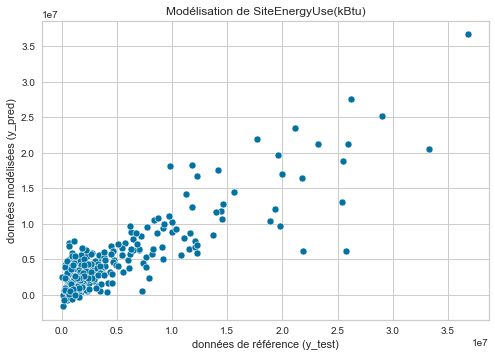

In [192]:
y_pred = model.predict(X_test)

# calcul metriques
print("MSE : {:.2f}".format(metrics.mean_squared_error(y_test, y_pred)))
print("RMSE : {:.2f}".format(np.sqrt( metrics.mean_squared_error(y_test, y_pred) )))
# print("RMSLE : {:.2f}".format(metrics.mean_squared_log_error(y_test, y_pred)))
print("RSE : {:.2f}".format(1-metrics.r2_score(y_test, y_pred)))
print("R² : {:.2f}".format(metrics.r2_score(y_test, y_pred)))

sns.scatterplot(x=y_test, y=y_pred);
plt.xlabel('données de référence (y_test)')
plt.ylabel('données modélisées (y_pred)')
plt.title('Modélisation de SiteEnergyUse(kBtu)');

In [193]:
# initialisation du fichier résultat global avec les données de test
resultat_noESS = y_test.copy()
resultat_noESS = pd.DataFrame(resultat_noESS)
resultat_noESS.columns = ['y_test']

# compilation des données de la regression linéaire
result_noESS = pd.DataFrame()
# calcul metriques
result_noESS.loc['MSE', 'LinearRegression'] = metrics.mean_squared_error(y_test, y_pred)
result_noESS.loc['RMSE', 'LinearRegression'] = np.sqrt( metrics.mean_squared_error(y_test, y_pred) )
if min(y_pred) > 0:
    result_noESS.loc['RMSLE', 'LinearRegression'] = metrics.mean_squared_log_error(y_test, y_pred)
else:
    result_noESS.loc['RMSLE', 'LinearRegression'] = np.nan
result_noESS.loc['RSE', 'LinearRegression'] = 1-metrics.r2_score(y_test, y_pred)
result_noESS.loc['R²', 'LinearRegression'] = metrics.r2_score(y_test, y_pred)
result_noESS.loc['Duree calcul (s)', 'LinearRegression'] = elapsed

    
# Stockage données modélisées vs données test
y_pred = pd.DataFrame(y_pred, index=y_test.index)
y_pred.columns = ['LinearRegression']
result_noESS = pd.concat([result_noESS, y_pred])

# merge du fichier resultat avec le fichier result
resultat_noESS = resultat_noESS.merge(result_noESS, left_index=True, right_index=True, sort=False, how='outer')
resultat_noESS

y_test  LinearRegression
2      12051984.0      6.819943e+06
9      33270518.0      2.053481e+07
13      1388717.0      5.363173e+06
19       306721.0      4.239244e+06
31      6722886.0      8.695852e+06
...           ...               ...
MSE           NaN      8.521260e+12
RMSE          NaN      2.919120e+06
RMSLE         NaN               NaN
RSE           NaN      2.415975e-01
R²            NaN      7.584025e-01

[322 rows x 2 columns]

### Regression Ridge

Temps d'exécution : 5.66s
Durée du gridSearchCV :  5.656520399999863
MSE : 8347031819584.86
RMSE : 8347031819584.86
RMSLE : nan
RSE : 0.24
R² : 0.76


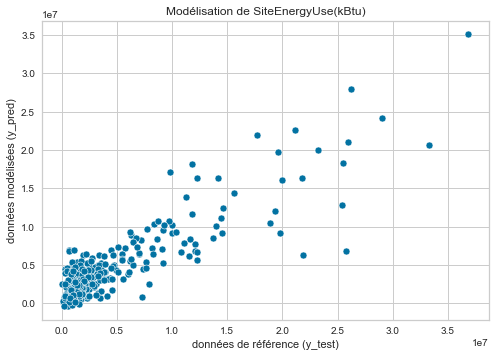

In [194]:
# hyperparamètres à tester
n_alpha = 100
alphas = np.logspace(-5, 5, n_alpha)

params = {'ridge__alpha':alphas}

score = 'neg_root_mean_squared_error'

# modelisation
resultat_noESS = Test_modele_GSCV(nom_run='ridge',
                            model=Ridge(), 
                            grid_params=params, 
                            cv=3, 
                            score=score, 
                            pipe_preprocessing=preprocessor,
                            X_train=X_train,
                            y_train=y_train,
                            X_test=X_test,
                            y_test=y_test, 
                            resultat=resultat_noESS
                           )

### Regression Lasso

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1560871986844218.0, tolerance: 1584377907784.6055
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1269572236190360.5, tolerance: 1977353760351.3958
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1560872006924168.2, tolerance: 1584377907784.6055
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_de

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1269572327492244.0, tolerance: 1977353760351.3958
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1560872199904865.8, tolerance: 1584377907784.6055
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1269572357815981.5, tolerance: 1977353760351.3958
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_de

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1560873153023004.2, tolerance: 1584377907784.6055
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1269573257306240.0, tolerance: 1977353760351.3958
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1560873312384809.8, tolerance: 1584377907784.6055
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_de

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1461655265735416.2, tolerance: 1977353760351.3958
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1356423116839467.0, tolerance: 1584377907784.6055
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1491528883462424.8, tolerance: 1977353760351.3958
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_de

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1090938764336110.5, tolerance: 1584377907784.6055
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1491758151462260.0, tolerance: 1977353760351.3958
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1090942708849211.2, tolerance: 1584377907784.6055
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_de

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 396305710853157.5, tolerance: 1584377907784.6055
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 721767596854730.5, tolerance: 1977353760351.3958
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 396160990344533.5, tolerance: 1584377907784.6055
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_desce

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24285714197539.0, tolerance: 1977353760351.3958
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 313362932855311.5, tolerance: 1584377907784.6055
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24303931381640.0, tolerance: 1977353760351.3958
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2246693948258.0, tolerance: 1584377907784.6055
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20387745025827.0, tolerance: 1977353760351.3958
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18646495360456.0, tolerance: 1977353760351.3958
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.p

Temps d'exécution : 36.86s
Durée du gridSearchCV :  36.86224610000045
MSE : 8942529611632.98
RMSE : 8942529611632.98
RMSLE : 0.78
RSE : 0.25
R² : 0.75


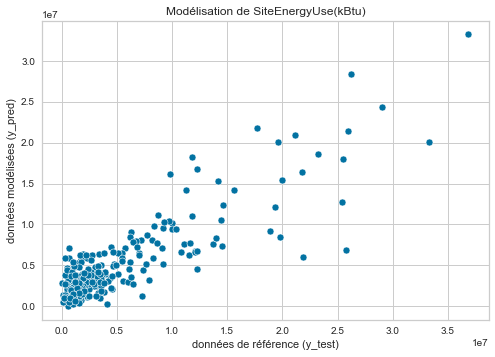

In [195]:
# hyperparamètres à tester
n_alphas = 200
alphas = np.logspace(-3, 8, n_alphas)

params = {'lasso__alpha':alphas}

score = 'neg_root_mean_squared_error'

# modelisation
resultat_noESS = Test_modele_GSCV(nom_run='lasso',
                            model=Lasso(), 
                            grid_params=params, 
                            cv=2, 
                            score=score, 
                            pipe_preprocessing=preprocessor,
                            X_train=X_train,
                            y_train=y_train,
                            X_test=X_test,
                            y_test=y_test, 
                            resultat=resultat_noESS
                           )

### Regression ElasticNet

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3460557281278853.0, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4501112399222248.0, tolerance: 2510126897112.0713
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4623907071496435.0, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_de

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3465562663563911.0, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4506436608303736.0, tolerance: 2510126897112.0713
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4629225558963744.0, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_de

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5780383538390.0, tolerance: 2510126897112.0713
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 573911947883296.0, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1102243189779714.5, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descen

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3383296626043817.0, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4371218539848005.5, tolerance: 2510126897112.0713
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4576707509497600.0, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_de

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4656563866402185.0, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 50658407448678.0, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46702033497378.0, tolerance: 2510126897112.0713
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descen

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4674683077249141.0, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4500936569448.0, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 961447272751143.0, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descen

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3252335587133727.0, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4094861943472539.0, tolerance: 2510126897112.0713
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4534498121060487.0, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_de

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4737456168496018.0, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 865265666647809.5, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 199697555235972.0, tolerance: 2510126897112.0713
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_desc

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2567712936859341.0, tolerance: 2510126897112.0713
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1553277481906699.5, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3644353282696648.5, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_de

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4801020951203331.0, tolerance: 2510126897112.0713
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4913259947438072.0, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1651326946533325.8, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_de

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1553278152901915.0, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3922042335019361.0, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4991261258519049.0, tolerance: 2510126897112.0713
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_de

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1651328050557665.5, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2493676190503174.0, tolerance: 2510126897112.0713
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1553278971833945.0, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_de

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5549049206101549.0, tolerance: 2510126897112.0713
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5610303075556005.0, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1651329493389234.5, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_de

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2493680075792108.0, tolerance: 2510126897112.0713
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1553282660683962.0, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4806748645564524.0, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_de

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6470557290797900.0, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1415003376649154.0, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2493685111267711.0, tolerance: 2510126897112.0713
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_de

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1227684923931366.0, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5754409407030290.0, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7129660180731902.0, tolerance: 2510126897112.0713
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_de

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7797001316790221.0, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 654894741563569.5, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1083898253019559.0, tolerance: 2510126897112.0713
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_des

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 846838033588863.0, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7076747658028108.0, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8707498288035092.0, tolerance: 2510126897112.0713
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_des

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 383449677203163.0, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 733804242366266.0, tolerance: 2510126897112.0713
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 826582611598062.0, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_desce

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0460409752554446e+16, tolerance: 2510126897112.0713
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.058729290302913e+16, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 368110019274682.0, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordin

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 495362804912491.0, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9188378562883604.0, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1233375825478444e+16, tolerance: 2510126897112.0713
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.18671887231602e+16, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 409709304231537.5, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 601961944878711.0, tolerance: 2510126897112.0713
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_de

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 257660336254592.0, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9875771018307604.0, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2058972429617032e+16, tolerance: 2510126897112.0713
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.24539822181672e+16, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 103856145229391.0, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 245790888337049.0, tolerance: 2510126897112.0713
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_de

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33486910169493.0, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0146814040079732e+16, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2385059141580676e+16, tolerance: 2510126897112.0713
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordin

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33989972642949.0, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0226995737694224e+16, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2481585415088816e+16, tolerance: 2510126897112.0713
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordin

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30302471668526.0, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0260653995267424e+16, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.252211310733868e+16, tolerance: 2510126897112.0713
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordina

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.253890034851744e+16, tolerance: 2510126897112.0713
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2761033137683128e+16, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0275757125273784e+16, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_co

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2546897326906734e+16, tolerance: 2510126897112.0713
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2769392995141394e+16, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.028160593512554e+16, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_co

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2772056608540292e+16, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0283469071986982e+16, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2549587424703768e+16, tolerance: 2510126897112.0713
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_c

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2772904276155238e+16, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0284061954825624e+16, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2550301415175568e+16, tolerance: 2510126897112.0713
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_c

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2773173935262622e+16, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.028425055789049e+16, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2550528544339526e+16, tolerance: 2510126897112.0713
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_co

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.277325970856448e+16, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.028431054842299e+16, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2550600789218948e+16, tolerance: 2510126897112.0713
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coo

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.277328699033023e+16, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0284329629465056e+16, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2550623767974514e+16, tolerance: 2510126897112.0713
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_co

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0284335698460588e+16, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.255063107669332e+16, tolerance: 2510126897112.0713
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2773296151377406e+16, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_co

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0284337628783962e+16, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.255063340132693e+16, tolerance: 2510126897112.0713
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2773298581479544e+16, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_co

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.028433824274789e+16, tolerance: 2056867705821.3928
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2550634140706256e+16, tolerance: 2510126897112.0713
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2773299354404462e+16, tolerance: 2554659942980.9185
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_co

Temps d'exécution : 5.93min
Durée du gridSearchCV :  355.789753
MSE : 8402867307581.89
RMSE : 8402867307581.89
RMSLE : nan
RSE : 0.24
R² : 0.76


y_test  LinearRegression         ridge  \
2                     12051984.0      6.819943e+06  6.750997e+06   
9                     33270518.0      2.053481e+07  2.062226e+07   
13                     1388717.0      5.363173e+06  5.352116e+06   
19                      306721.0      4.239244e+06  4.424546e+06   
31                     6722886.0      8.695852e+06  8.504129e+06   
...                          ...               ...           ...   
R²                           NaN      7.584025e-01  7.633422e-01   
elasticnet__alpha            NaN               NaN           NaN   
elasticnet__l1_ratio         NaN               NaN           NaN   
lasso__alpha                 NaN               NaN           NaN   
ridge__alpha                 NaN               NaN  9.111628e+00   

                             lasso    elasticnet  
2                     6.669361e+06  6.756792e+06  
9                     2.007173e+07  2.058952e+07  
13                    5.276488e+06  5.332729e+06  
19                    5.859834e+06  4.515977e+06  
31                    8.047690e+06  8.514924e+06  
...                            ...           ...  
R²                    7.464585e-01  7.617592e-01  
elasticnet__alpha              NaN  3.107866e-02  
elasticnet__l1_ratio           NaN  5.000000e-01  
lasso__alpha          4.247572e+04           NaN  
ridge__alpha                   NaN           NaN  

[326 rows x 5 columns]

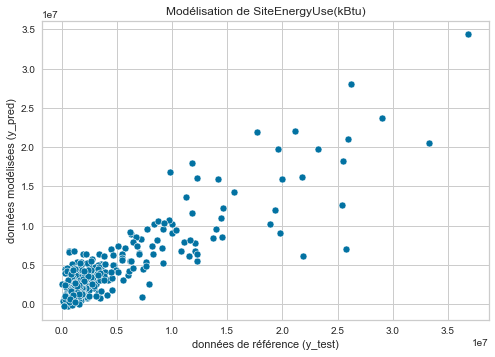

In [196]:
# hyperparamètres à tester
n_alphas = 200
alphas = np.logspace(-3, 8, n_alphas)
l1ratios = np.arange(0,1.1,0.1)

params = {'elasticnet__alpha':alphas,
          'elasticnet__l1_ratio':l1ratios
         }
score = 'neg_root_mean_squared_error'

# modelisation
resultat_noESS = Test_modele_GSCV(nom_run='elasticnet',
                            model=ElasticNet(), 
                            grid_params=params, 
                            cv=3, 
                            score=score, 
                            pipe_preprocessing=preprocessor,
                            X_train=X_train,
                            y_train=y_train,
                            X_test=X_test,
                            y_test=y_test, 
                            resultat=resultat_noESS
                           )
resultat_noESS

### kRR

Temps d'exécution : 1.46min
Durée du gridSearchCV :  87.69095909999987
MSE : 9793753242632.95
RMSE : 9793753242632.95
RMSLE : nan
RSE : 0.28
R² : 0.72


y_test  LinearRegression         ridge  \
2                     12051984.0      6.819943e+06  6.750997e+06   
9                     33270518.0      2.053481e+07  2.062226e+07   
13                     1388717.0      5.363173e+06  5.352116e+06   
19                      306721.0      4.239244e+06  4.424546e+06   
31                     6722886.0      8.695852e+06  8.504129e+06   
...                          ...               ...           ...   
elasticnet__l1_ratio         NaN               NaN           NaN   
kernelridge__alpha           NaN               NaN           NaN   
kernelridge__gamma           NaN               NaN           NaN   
lasso__alpha                 NaN               NaN           NaN   
ridge__alpha                 NaN               NaN  9.111628e+00   

                             lasso    elasticnet       kRR_rbf  
2                     6.669361e+06  6.756792e+06  1.229669e+07  
9                     2.007173e+07  2.058952e+07  2.840472e+07  
13                    5.276488e+06  5.332729e+06  5.107278e+06  
19                    5.859834e+06  4.515977e+06  4.900093e+06  
31                    8.047690e+06  8.514924e+06  9.156918e+06  
...                            ...           ...           ...  
elasticnet__l1_ratio           NaN  5.000000e-01           NaN  
kernelridge__alpha             NaN           NaN  1.743329e-02  
kernelridge__gamma             NaN           NaN  1.832981e-02  
lasso__alpha          4.247572e+04           NaN           NaN  
ridge__alpha                   NaN           NaN           NaN  

[328 rows x 6 columns]

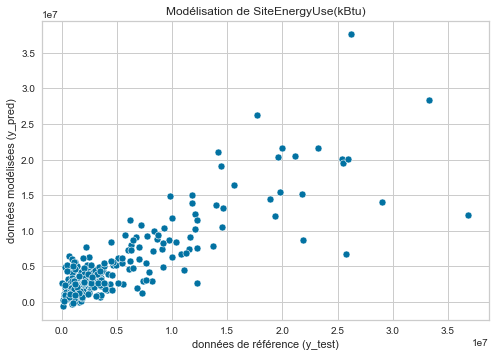

In [197]:
# valeurs du paramètre de régularisation
alpha_range = np.logspace(-3, -1, 30)
# valeurs du paramètre gamma
gamma_range = np.logspace(-3, -1, 20)

# grille de paramètres
params = {'kernelridge__alpha': alpha_range, 
          'kernelridge__gamma': gamma_range}

# score pour sélectionner le modèle optimal
score = 'neg_root_mean_squared_error'

# modelisation
resultat_noESS = Test_modele_GSCV(nom_run='kRR_rbf',
                            model=KernelRidge(kernel='rbf'), 
                            grid_params=params, 
                            cv=3, 
                            score=score, 
                            pipe_preprocessing=preprocessor,
                            X_train=X_train,
                            y_train=y_train,
                            X_test=X_test,
                            y_test=y_test, 
                            resultat=resultat_noESS
                           )
resultat_noESS

### Bagging : RandomForest

Temps d'exécution : 1.77min
Durée du gridSearchCV :  106.27367569999979
MSE : 9614355578423.59
RMSE : 9614355578423.59
RMSLE : 0.68
RSE : 0.27
R² : 0.73


y_test  LinearRegression  \
2                                    12051984.0      6.819943e+06   
9                                    33270518.0      2.053481e+07   
13                                    1388717.0      5.363173e+06   
19                                     306721.0      4.239244e+06   
31                                    6722886.0      8.695852e+06   
...                                         ...               ...   
lasso__alpha                                NaN               NaN   
randomforestregressor__max_depth            NaN               NaN   
randomforestregressor__max_features         NaN               NaN   
randomforestregressor__n_estimators         NaN               NaN   
ridge__alpha                                NaN               NaN   

                                            ridge         lasso    elasticnet  \
2                                    6.750997e+06  6.669361e+06  6.756792e+06   
9                                    2.062226e+07  2.007173e+07  2.058952e+07   
13                                   5.352116e+06  5.276488e+06  5.332729e+06   
19                                   4.424546e+06  5.859834e+06  4.515977e+06   
31                                   8.504129e+06  8.047690e+06  8.514924e+06   
...                                           ...           ...           ...   
lasso__alpha                                  NaN  4.247572e+04           NaN   
randomforestregressor__max_depth              NaN           NaN           NaN   
randomforestregressor__max_features           NaN           NaN           NaN   
randomforestregressor__n_estimators           NaN           NaN           NaN   
ridge__alpha                         9.111628e+00           NaN           NaN   

                                          kRR_rbf     randomforest  
2                                    1.229669e+07  17914765.453562  
9                                    2.840472e+07  20522305.419455  
13                                   5.107278e+06   4803180.224273  
19                                   4.900093e+06   4036288.796516  
31                                   9.156918e+06   7716540.899087  
...                                           ...              ...  
lasso__alpha                                  NaN              NaN  
randomforestregressor__max_depth              NaN             10.0  
randomforestregressor__max_features           NaN             auto  
randomforestregressor__n_estimators           NaN            750.0  
ridge__alpha                                  NaN              NaN  

[331 rows x 7 columns]

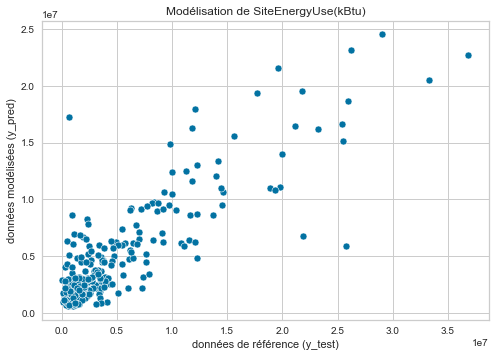

In [198]:
# grille de paramètres
n_estimator_range = [10, 50, 100, 250, 500, 750]
max_depth_range = [1, 2, 3, 4, 5, 10]
max_features_range = ['auto', 'sqrt', 'log2']
params = {"randomforestregressor__n_estimators":n_estimator_range,
          "randomforestregressor__max_depth":max_depth_range, 
          "randomforestregressor__max_features":max_features_range}

# score pour sélectionner le modèle optimal
score = 'neg_root_mean_squared_error'

# modelisation
resultat_noESS = Test_modele_GSCV(nom_run='randomforest',
                            model=RandomForestRegressor(), 
                            grid_params=params, 
                            cv=3, 
                            score=score, 
                            pipe_preprocessing=preprocessor,
                            X_train=X_train,
                            y_train=y_train,
                            X_test=X_test,
                            y_test=y_test, 
                            resultat=resultat_noESS
                           )
resultat_noESS

### Boosting : GBoost

Temps d'exécution : 5.62min
Durée du gridSearchCV :  337.37502369999993
MSE : 8869309091165.33
RMSE : 8869309091165.33
RMSLE : nan
RSE : 0.25
R² : 0.75


y_test  LinearRegression  \
2                                    12051984.0      6.819943e+06   
9                                    33270518.0      2.053481e+07   
13                                    1388717.0      5.363173e+06   
19                                     306721.0      4.239244e+06   
31                                    6722886.0      8.695852e+06   
...                                         ...               ...   
lasso__alpha                                NaN               NaN   
randomforestregressor__max_depth            NaN               NaN   
randomforestregressor__max_features         NaN               NaN   
randomforestregressor__n_estimators         NaN               NaN   
ridge__alpha                                NaN               NaN   

                                            ridge         lasso    elasticnet  \
2                                    6.750997e+06  6.669361e+06  6.756792e+06   
9                                    2.062226e+07  2.007173e+07  2.058952e+07   
13                                   5.352116e+06  5.276488e+06  5.332729e+06   
19                                   4.424546e+06  5.859834e+06  4.515977e+06   
31                                   8.504129e+06  8.047690e+06  8.514924e+06   
...                                           ...           ...           ...   
lasso__alpha                                  NaN  4.247572e+04           NaN   
randomforestregressor__max_depth              NaN           NaN           NaN   
randomforestregressor__max_features           NaN           NaN           NaN   
randomforestregressor__n_estimators           NaN           NaN           NaN   
ridge__alpha                         9.111628e+00           NaN           NaN   

                                          kRR_rbf     randomforest  \
2                                    1.229669e+07  17914765.453562   
9                                    2.840472e+07  20522305.419455   
13                                   5.107278e+06   4803180.224273   
19                                   4.900093e+06   4036288.796516   
31                                   9.156918e+06   7716540.899087   
...                                           ...              ...   
lasso__alpha                                  NaN              NaN   
randomforestregressor__max_depth              NaN             10.0   
randomforestregressor__max_features           NaN             auto   
randomforestregressor__n_estimators           NaN            750.0   
ridge__alpha                                  NaN              NaN   

                                    gradientboosting  
2                                     9588332.935178  
9                                     15921768.23476  
13                                     5762141.65464  
19                                    3153834.449671  
31                                   10356498.627741  
...                                              ...  
lasso__alpha                                     NaN  
randomforestregressor__max_depth                 NaN  
randomforestregressor__max_features              NaN  
randomforestregressor__n_estimators              NaN  
ridge__alpha                                     NaN  

[336 rows x 8 columns]

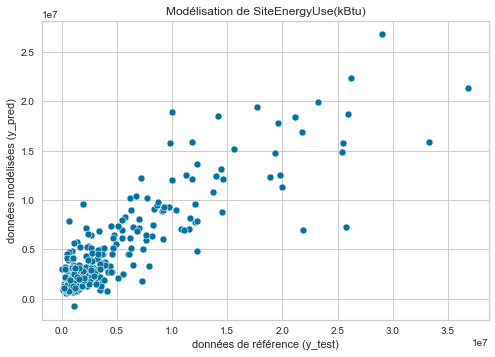

In [199]:
# grille de paramètres
n_estimators_range = [10, 100, 500]
max_depth_range = [1, 3, 5, 10]
max_features_range = ['auto', 'sqrt', 'log2']
learning_rate_range = [0.01, 0.1, 0.5 , 1]
loss_range = ['squared_error', 'absolute_error']
params = {"gradientboostingregressor__n_estimators":n_estimators_range,
          "gradientboostingregressor__max_depth":max_depth_range, 
          "gradientboostingregressor__max_features":max_features_range, 
          'gradientboostingregressor__learning_rate':learning_rate_range,
          'gradientboostingregressor__loss':loss_range
         }

# score pour sélectionner le modèle optimal
score = 'neg_root_mean_squared_error'

# Modélisation
resultat_noESS = Test_modele_GSCV(nom_run='gradientboosting',
                            model=GradientBoostingRegressor(), 
                            grid_params=params, 
                            cv=3, 
                            score=score, 
                            pipe_preprocessing=preprocessor,
                            X_train=X_train,
                            y_train=y_train,
                            X_test=X_test,
                            y_test=y_test, 
                            resultat=resultat_noESS
                           )
resultat_noESS

### Comparaison des modélisations

In [200]:
# Calcul du nombre de valeurs négatives
for model in resultat_noESS.columns:
    resultat_noESS.loc['nb valeurs negatives', model] = np.sum(resultat_noESS.loc[:1254,model] < 0)
resultat_noESS.loc['nb valeurs negatives']

y_test               0.0
LinearRegression    12.0
ridge                6.0
lasso                0.0
elasticnet           4.0
kRR_rbf              4.0
randomforest           0
gradientboosting       1
Name: nb valeurs negatives, dtype: object

In [201]:
lignes = ['Duree calcul (s)', 'MSE', 'RMSE', 'RMSLE', 'RSE', 'R²', 'nb valeurs negatives']
comparaison_noESS = resultat_noESS.loc[lignes, :].T
comparaison_noESS = comparaison_noESS.drop('y_test', axis=0).reset_index()
comparaison_noESS

index Duree calcul (s)                   MSE            RMSE  \
0  LinearRegression         0.035751  8521259757911.010742  2919119.688864   
1             ridge         0.010169  8347031819584.862305  2889123.019116   
2             lasso         0.018422  8942529611632.978516  2990406.261971   
3        elasticnet         0.038606  8402867307581.889648  2898769.964585   
4           kRR_rbf         0.053744  9793753242632.951172  3129497.282733   
5      randomforest         2.769398  9614355578423.587891  3100702.433066   
6  gradientboosting         0.110368  8869309091165.328125  2978138.527867   

      RMSLE       RSE        R² nb valeurs negatives  
0       NaN  0.241598  0.758402                 12.0  
1       NaN  0.236658  0.763342                  6.0  
2  0.776711  0.253542  0.746458                  0.0  
3       NaN  0.238241  0.761759                  4.0  
4       NaN  0.277676  0.722324                  4.0  
5  0.679686  0.272589  0.727411                    0  
6       NaN  0.251466  0.748534                    1

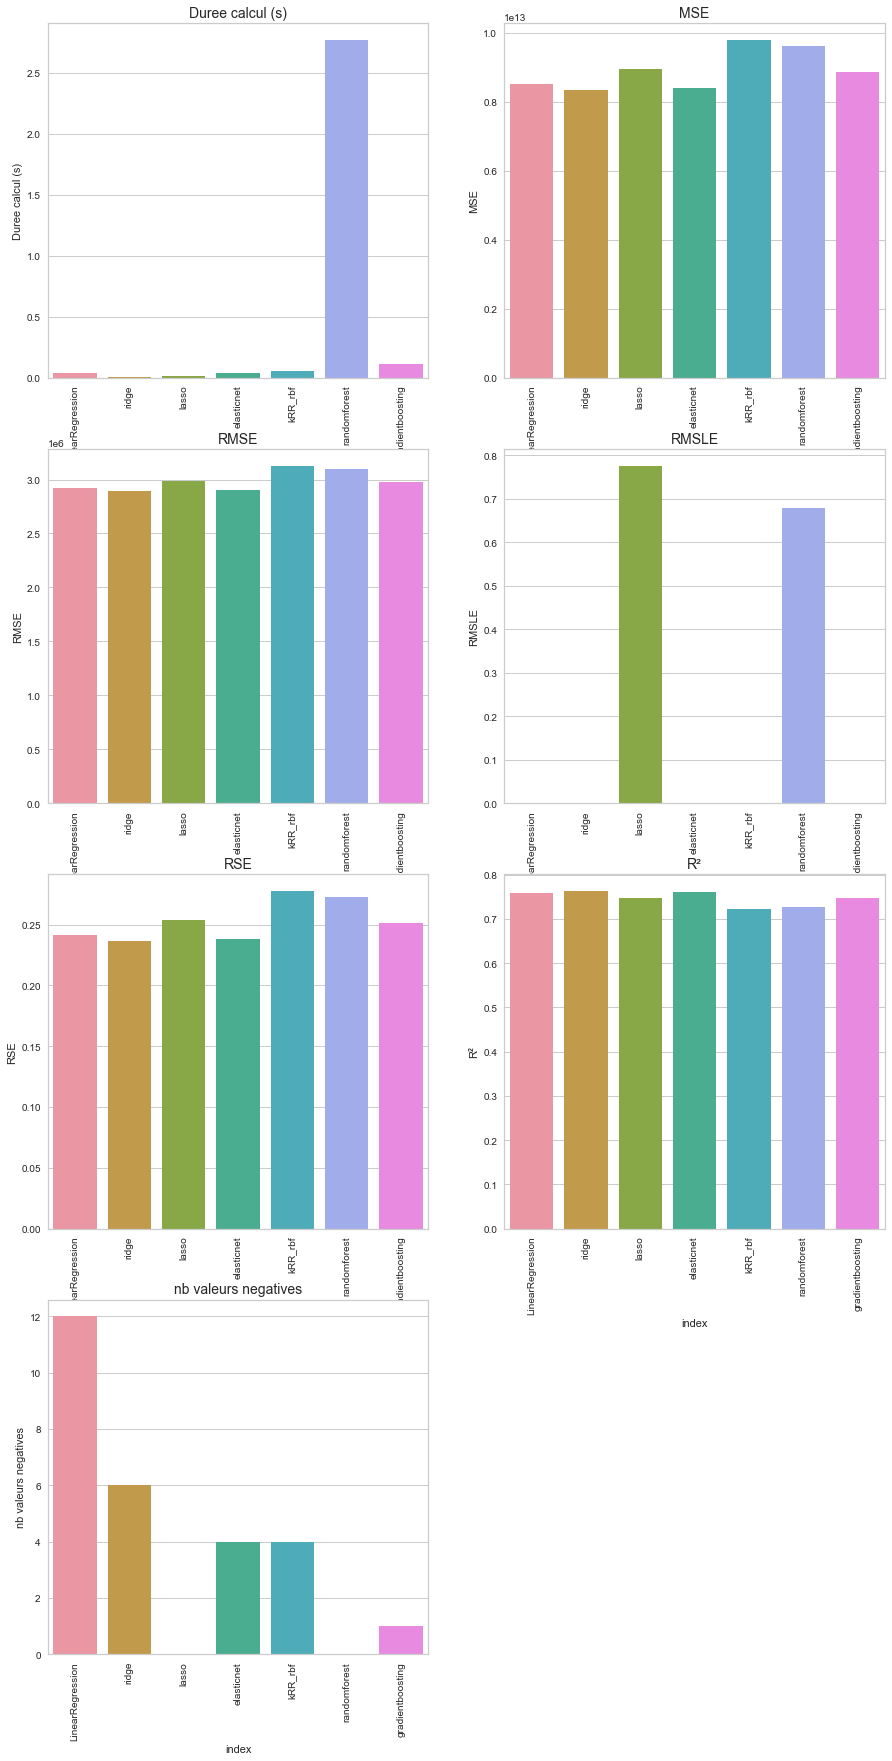

In [202]:
plt.figure(figsize=(15,30))
compteur = 1
for metrique in lignes:
    plt.subplot(4,2, compteur)
    sns.barplot(data=comparaison_noESS, x='index', y=metrique, label=False)
    plt.title(metrique, fontsize=14)
    plt.xticks(rotation = 90)
    compteur += 1

In [203]:
resultat_noESS['ridge'].tail(25)

1242                                        8.306447e+06
1249                                        4.350590e+06
1253                                        6.921552e+06
1254                                        9.328135e+06
Duree calcul (s)                            1.016903e-02
MSE                                         8.347032e+12
RMSE                                        2.889123e+06
RMSLE                                                NaN
RSE                                         2.366578e-01
R²                                          7.633422e-01
elasticnet__alpha                                    NaN
elasticnet__l1_ratio                                 NaN
gradientboostingregressor__learning_rate             NaN
gradientboostingregressor__loss                      NaN
gradientboostingregressor__max_depth                 NaN
gradientboostingregressor__max_features              NaN
gradientboostingregressor__n_estimators              NaN
kernelridge__alpha             

## CONCLUSION

La modélisation Ridge semble la plus pertinente :
- temps de modélisation réduit
- métriques parmis les meilleurs de tous les modèles testés
- nombre de valeurs négatives prédite faible (uniquement 6, soit 2% du jeu de test)

Par contre, le fait de ne pas prendre en compte EnergyStarScore dégrade légèrement la qualité du modèle :
- modèle Ridge sans EnergyStarScore : R² = 0.76 
- modèle Ridge avec EnergyStarScore : R² = 0.80
- modèle RandomForest avec EnergyStarScore : R² = 0.81

## COMPARAISON DES MODELES SELECTIONNES

In [204]:
resultat_SIU = pd.DataFrame()
resultat_SIU['y_test'] = resultat['y_test']
resultat_SIU['option 1 - Ridge'] = resultat['ridge']
resultat_SIU['option 1 - GB'] = resultat['gradientboosting']
resultat_SIU['option 2 - kRR'] = comparaison_y_noLog['kRR_rbf']
resultat_SIU.loc['RMSE', 'option 2 - kRR'] = comparaison_metriques.loc[4, 'RMSE']
resultat_SIU.loc['R²', 'option 2 - kRR'] = comparaison_metriques.loc[4, 'R²']
resultat_SIU.loc['Duree calcul (s)', 'option 2 - kRR'] = resultat_log.loc['Duree calcul (s)', 'kRR_rbf']
resultat_SIU['option 3 - Ridge'] = resultat_noESS['ridge']
resultat_SIU

y_test  option 1 - Ridge  \
2                                    12051984.0      6.604160e+06   
9                                    33270518.0      2.260517e+07   
13                                    1388717.0      5.318136e+06   
19                                     306721.0      4.325095e+06   
31                                    6722886.0      7.666863e+06   
...                                         ...               ...   
nb valeurs negatives                        0.0      2.200000e+01   
randomforestregressor__max_depth            NaN               NaN   
randomforestregressor__max_features         NaN               NaN   
randomforestregressor__n_estimators         NaN               NaN   
ridge__alpha                                NaN      1.500000e+01   

                                       option 1 - GB  option 2 - kRR  \
2                                    10766371.406605    5.884402e+06   
9                                    20186691.262398    2.163391e+07   
13                                    5599928.271088    2.473782e+06   
19                                    3316689.259453    1.426392e+06   
31                                     7067235.85539    7.374230e+06   
...                                              ...             ...   
nb valeurs negatives                               1             NaN   
randomforestregressor__max_depth                 NaN             NaN   
randomforestregressor__max_features              NaN             NaN   
randomforestregressor__n_estimators              NaN             NaN   
ridge__alpha                                     NaN             NaN   

                                     option 3 - Ridge  
2                                        6.750997e+06  
9                                        2.062226e+07  
13                                       5.352116e+06  
19                                       4.424546e+06  
31                                       8.504129e+06  
...                                               ...  
nb valeurs negatives                     6.000000e+00  
randomforestregressor__max_depth                  NaN  
randomforestregressor__max_features               NaN  
randomforestregressor__n_estimators               NaN  
ridge__alpha                             9.111628e+00  

[337 rows x 5 columns]

In [205]:
lignes = ['RMSE', 'R²', 'nb valeurs negatives', 'Duree calcul (s)']
comparaison_SIU = resultat_SIU.loc[lignes, :].T
comparaison_SIU = comparaison_SIU.drop('y_test', axis=0).reset_index()
comparaison_SIU

index            RMSE        R² nb valeurs negatives  \
0  option 1 - Ridge   2656294.96918  0.799949                 22.0   
1     option 1 - GB  2540877.735631  0.816956                    1   
2    option 2 - kRR  3104004.153637  0.716903                  NaN   
3  option 3 - Ridge  2889123.019116  0.763342                  6.0   

  Duree calcul (s)  
0            0.018  
1         0.525611  
2         0.060772  
3         0.010169

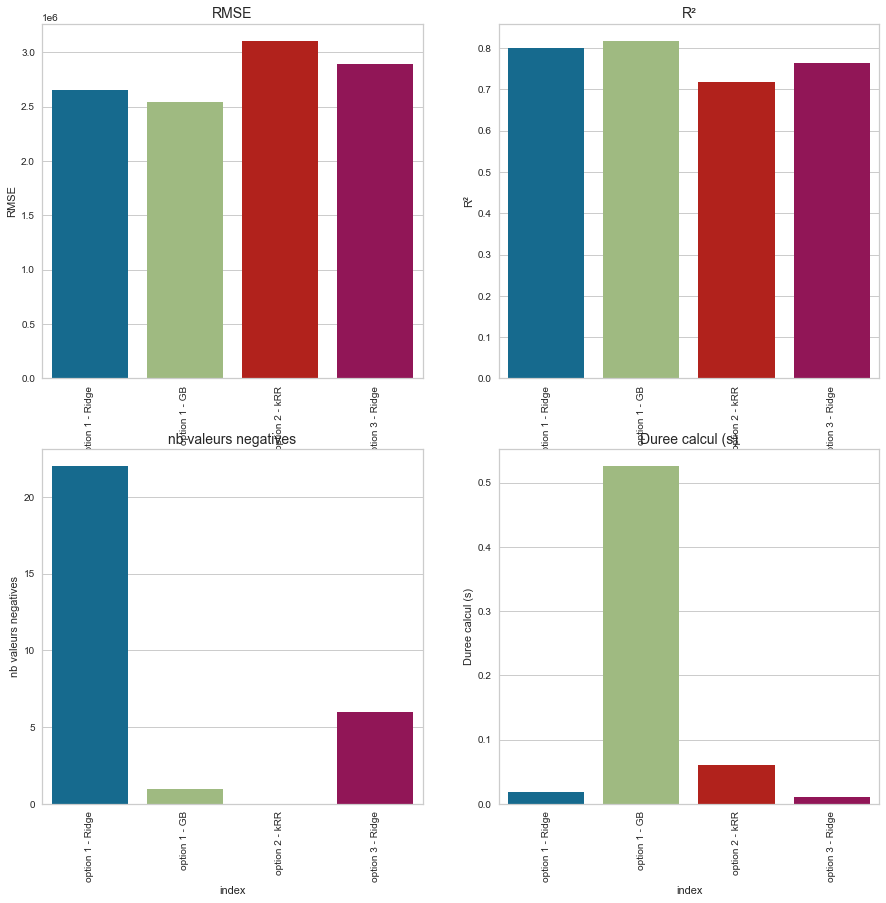

In [206]:
plt.figure(figsize=(15,30))
compteur = 1
for metrique in lignes:
    plt.subplot(4,2, compteur)
    sns.barplot(data=comparaison_SIU, x='index', y=metrique, label=False)
    plt.title(metrique, fontsize=14)
    plt.xticks(rotation = 90)
    compteur += 1

In [207]:
resultat_SIU_comp_y = resultat_SIU.loc[:1254,:]
resultat_SIU_comp_y = resultat_SIU_comp_y.astype({'option 1 - GB': float})

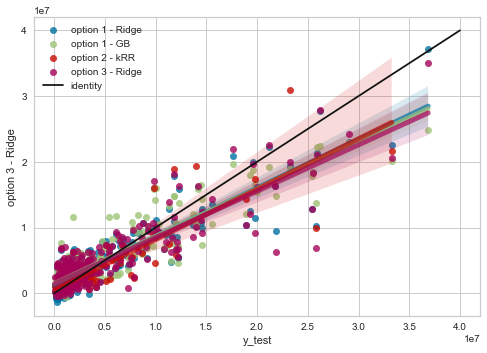

In [208]:
# plt.figure(figsize=(15,30))
# compteur = 1
for model in comparaison_SIU['index']:
#     plt.subplot(4,2, compteur)
    sns.regplot(y=resultat_SIU_comp_y[model], 
                x=resultat_SIU_comp_y["y_test"], 
                line_kws={"alpha":0.7,"lw":5},
                label=model
               )

plt.plot([0,4e7], [0,4e7], label='identity', c='k')
plt.legend()
#     plt.show()
#     compteur += 1

L’abandon de la variable ENERGYSTARScore permet de limiter le nombre de valeurs négatives prédites tout en maintenant une RMSE correcte et un temps de calcul faible 

=> Choix du modèle Ridge (alpha=9,1) en utilisant toutes les features sauf ENERGYSTARScore

# Production de gaz à effet de serre

## Préparation des données
### Création jeu de données

In [209]:
X = data.drop(['Unnamed: 0', 'SiteEnergyUse(kBtu)', 
               'GHGEmissions(MetricTonsCO2e)', 'train/test'], axis=1)
y = data['GHGEmissions(MetricTonsCO2e)']

X_quanti = X.select_dtypes(['float64', 'int64'])
X_categ = X.select_dtypes(['object'])

### Données quantitatives

In [210]:
# selection des données en fonction des différents traitement à leur affecter
X_quanti_GFA = list(X_quanti.filter(regex='GFA').columns)
X_quanti_ESS = ['ENERGYSTARScore']
X_quanti_others = list(X_quanti.drop(X_quanti_GFA, axis=1).drop('ENERGYSTARScore', axis=1).columns)

# mise en place des pipelines pour les données quantitatives
GFA_pipeline = make_pipeline(SimpleImputer(strategy='constant', fill_value=0), StandardScaler())
ESS_pipeline = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())
Other_quanti_pipeline = make_pipeline(StandardScaler())

### Données catégorielles

In [211]:
X_categ = list(X_categ.columns)

categ_pipeline = make_pipeline(SimpleImputer(strategy='constant', fill_value='None'), OneHotEncoder())

### Preprocessing

In [212]:
preprocessor = make_column_transformer((GFA_pipeline, X_quanti_GFA), 
                                       (ESS_pipeline, X_quanti_ESS),
                                       (Other_quanti_pipeline, X_quanti_others),
                                       (categ_pipeline, X_categ))

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rs_opt)

In [213]:
rs_opt

14500

## Baseline : régression linéaire

In [214]:
start_time = timeit.default_timer()

model = make_pipeline(preprocessor, LinearRegression())

model.fit(X_train, y_train)
print(model.score(X_test, y_test))

elapsed = timeit.default_timer() - start_time

print(f'Temps d\'exécution : {elapsed:.2}s')

0.5382867096272521
Temps d'exécution : 0.045s


MSE : 8638.17
RMSE : 92.94
RSE : 0.46
R² : 0.54


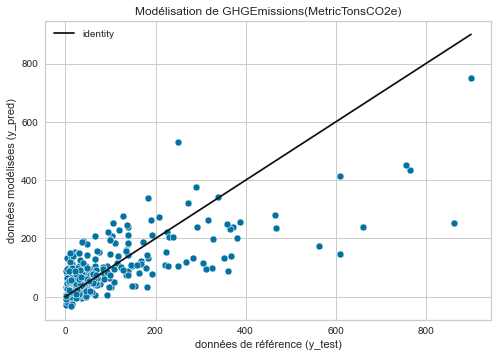

In [215]:
y_pred = model.predict(X_test)

# calcul metriques
print("MSE : {:.2f}".format(metrics.mean_squared_error(y_test, y_pred)))
print("RMSE : {:.2f}".format(np.sqrt( metrics.mean_squared_error(y_test, y_pred) )))
# print("RMSLE : {:.2f}".format(metrics.mean_squared_log_error(y_test, y_pred)))
print("RSE : {:.2f}".format(1-metrics.r2_score(y_test, y_pred)))
print("R² : {:.2f}".format(metrics.r2_score(y_test, y_pred)))

sns.scatterplot(x=y_test, y=y_pred);
plt.plot([0,900], [0,900], label='identity', c='k')
plt.legend();
plt.xlabel('données de référence (y_test)')
plt.ylabel('données modélisées (y_pred)')
plt.title('Modélisation de GHGEmissions(MetricTonsCO2e)');

### Visu

0.5382867096272521


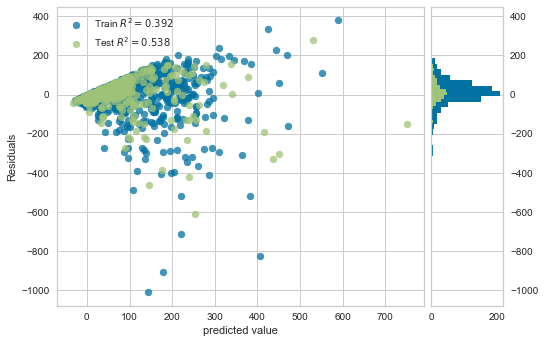

In [216]:
# visu des résidus du train_set et du test_set

model = make_pipeline(preprocessor, ResidualsPlot(LinearRegression()))

model.fit(X_train, y_train)
print(model.score(X_test, y_test))
plt.legend();
plt.xlabel('predicted value')
plt.ylabel('Residuals');

0.5382867096272521


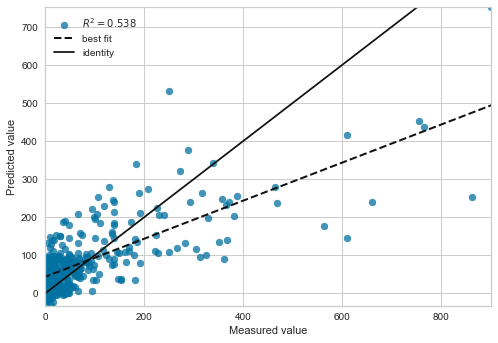

In [217]:
# visu des erreurs de prédiction
model = make_pipeline(preprocessor, PredictionError(LinearRegression()))

model.fit(X_train, y_train)
print(model.score(X_test, y_test))
plt.plot([0,900], [0,900], label='identity', c='k')
plt.legend();
plt.xlabel('Measured value')
plt.ylabel('Predicted value');

### Stockage des resultats

In [218]:
resultat_GHG = initialisation_resultats(nom_baseline='linearregression', y_test=y_test, y_pred=y_pred)
resultat_GHG.tail(25)

y_test  linearregression
1173               63.37         62.219493
1177               20.44         67.003529
1180               76.85         81.313380
1187               67.38         62.248894
1192               61.36         79.181775
1203                8.35         15.293308
1204               50.55         85.397199
1215                5.15         -8.701233
1216               46.70        104.066934
1220              110.24        183.994604
1226               38.30         64.716010
1228               69.67        158.468013
1229               24.17         91.849763
1232              139.50         90.126454
1234              117.65        138.388570
1242               56.48         62.090787
1249               19.40         64.054752
1253               21.18        153.034449
1254               99.95        193.868629
Duree calcul (s)     NaN          0.044517
MSE                  NaN       8638.167158
RMSE                 NaN         92.941741
RMSLE                NaN               NaN
RSE                  NaN          0.461713
R²                   NaN          0.538287

## Regression RIDGE

Temps d'exécution : 3.78s
Durée du gridSearchCV :  3.7830775000002177
MSE : 8558.75
RMSE : 8558.75
RMSLE : nan
RSE : 0.46
R² : 0.54


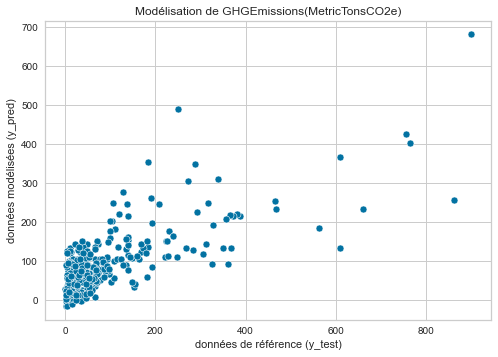

In [219]:
# hyperparamètres à tester
n_alpha = 50
alphas = np.logspace(0, 2, n_alpha)

params = {'ridge__alpha':alphas}

score = 'neg_root_mean_squared_error'

# modelisation
resultat_GHG = Test_modele_GSCV(nom_run='ridge',
                            model=Ridge(), 
                            grid_params=params, 
                            cv=3, 
                            score=score, 
                            pipe_preprocessing=preprocessor,
                            X_train=X_train,
                            y_train=y_train,
                            X_test=X_test,
                            y_test=y_test, 
                            resultat=resultat_GHG
                           )

In [220]:
resultat_GHG.tail(25)

y_test  linearregression        ridge
1177               20.44         67.003529    70.464805
1180               76.85         81.313380   105.224891
1187               67.38         62.248894    64.891056
1192               61.36         79.181775    83.446913
1203                8.35         15.293308    10.320947
1204               50.55         85.397199    89.838994
1215                5.15         -8.701233    -3.878542
1216               46.70        104.066934    96.010422
1220              110.24        183.994604   182.500930
1226               38.30         64.716010    70.100211
1228               69.67        158.468013   151.484185
1229               24.17         91.849763   101.327471
1232              139.50         90.126454   114.238447
1234              117.65        138.388570   136.931911
1242               56.48         62.090787    65.802010
1249               19.40         64.054752    62.097820
1253               21.18        153.034449   143.065319
1254               99.95        193.868629   177.502024
Duree calcul (s)     NaN          0.044517     0.012363
MSE                  NaN       8638.167158  8558.745056
RMSE                 NaN         92.941741    92.513486
RMSLE                NaN               NaN          NaN
RSE                  NaN          0.461713     0.457468
R²                   NaN          0.538287     0.542532
ridge__alpha         NaN               NaN    13.894955

### Visu

In [221]:
# récupération des paramètres de best fit
best_param = []
for param in resultat_GHG.filter(regex='ridge', axis=0).index:
    print(param)
    best_param.append(resultat_GHG.loc[param, 'ridge'])
print(best_param)

ridge__alpha
[13.894954943731374]


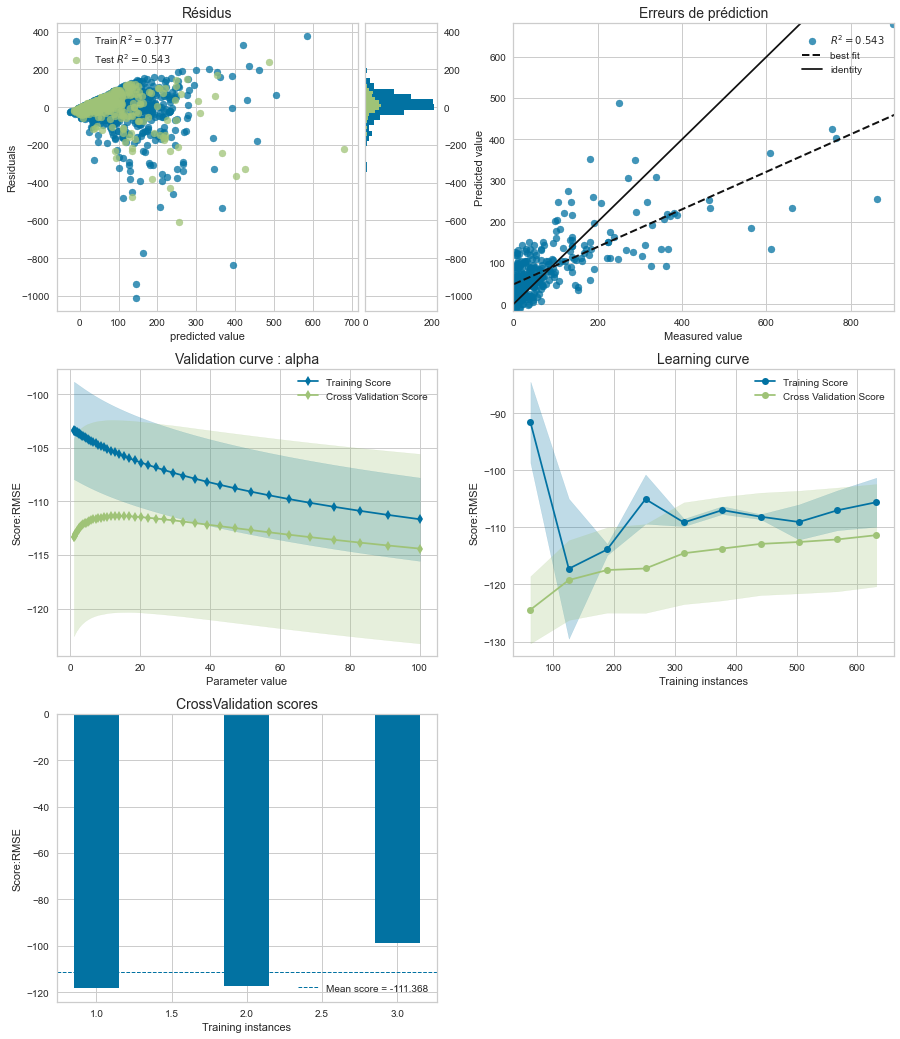

In [222]:
plt.figure(figsize=(15,18))

plt.subplot(3,2, 1)
# visualisation des résidus
model = make_pipeline(preprocessor, ResidualsPlot(Ridge(alpha=best_param[0])))

model.fit(X_train, y_train)
ax = model.score(X_test, y_test)
plt.legend()
plt.title('Résidus', fontsize=14)
plt.xlabel('predicted value')
plt.ylabel('Residuals');

plt.subplot(3,2, 2)
# visu des erreurs de prédiction
model = make_pipeline(preprocessor, PredictionError(Ridge(alpha=best_param[0])))

model.fit(X_train, y_train)
model.score(X_test, y_test)
plt.plot([0,900], [0,900], label='identity', c='k')
plt.legend();
plt.title('Erreurs de prédiction', fontsize=14)
plt.xlabel('Measured value')
plt.ylabel('Predicted value');

plt.subplot(3,2, 3)
# validation curve
viz = make_pipeline(preprocessor, ValidationCurve(Ridge(),
                                                  param_name="alpha",
                                                  param_range=alphas,
                                                  cv=3,
                                                  scoring=score
                                                 )
                   )

viz.fit(X_train, y_train);
plt.legend();
plt.title('Validation curve : alpha', fontsize=14)
plt.xlabel('Parameter value')
plt.ylabel('Score:RMSE');

plt.subplot(3,2, 4)
# Learning curve
sizes = np.linspace(0.1, 1.0, 10)

viz = make_pipeline(preprocessor, LearningCurve(Ridge(alpha=best_param[0]),
                                                cv=3,
                                                train_sizes=sizes,
                                                scoring=score
                                                )
                   )
viz.fit(X_train, y_train);
plt.legend();
plt.title('Learning curve', fontsize=14)
plt.xlabel('Training instances')
plt.ylabel('Score:RMSE');

plt.subplot(3,2, 5)
# visu impact de la crossvalidation
viz = make_pipeline(preprocessor, CVScores(Ridge(alpha=best_param[0]),
                                            cv=3,
                                            scoring=score
                                            )
                   )
viz.fit(X_train, y_train);
plt.legend();
plt.title('CrossValidation scores', fontsize=14)
plt.xlabel('Training instances')
plt.ylabel('Score:RMSE');

## Regression LASSO

Temps d'exécution : 5.10s
Durée du gridSearchCV :  5.1003192000002855
MSE : 8588.90
RMSE : 8588.90
RMSLE : nan
RSE : 0.46
R² : 0.54


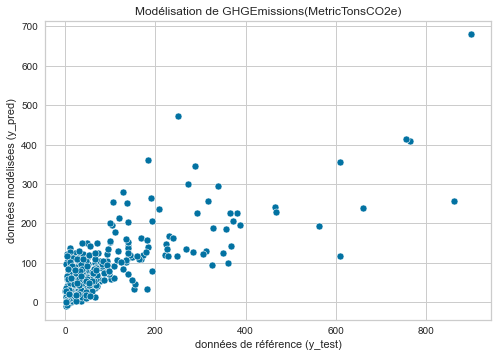

In [223]:
# hyperparamètres à tester
n_alphas = 50
alphas = np.logspace(-1, 1, n_alphas)

params = {'lasso__alpha':alphas}

score = 'neg_root_mean_squared_error'

# modelisation
resultat_GHG = Test_modele_GSCV(nom_run='lasso',
                            model=Lasso(), 
                            grid_params=params, 
                            cv=3, 
                            score=score, 
                            pipe_preprocessing=preprocessor,
                            X_train=X_train,
                            y_train=y_train,
                            X_test=X_test,
                            y_test=y_test, 
                            resultat=resultat_GHG
                           )

### Visu

In [224]:
# récupération des paramètres de best fit
best_param = []
for param in resultat_GHG.filter(regex='lasso', axis=0).index:
    print(param)
    best_param.append(resultat_GHG.loc[param, 'lasso'])
print(best_param)

lasso__alpha
[0.6551285568595507]


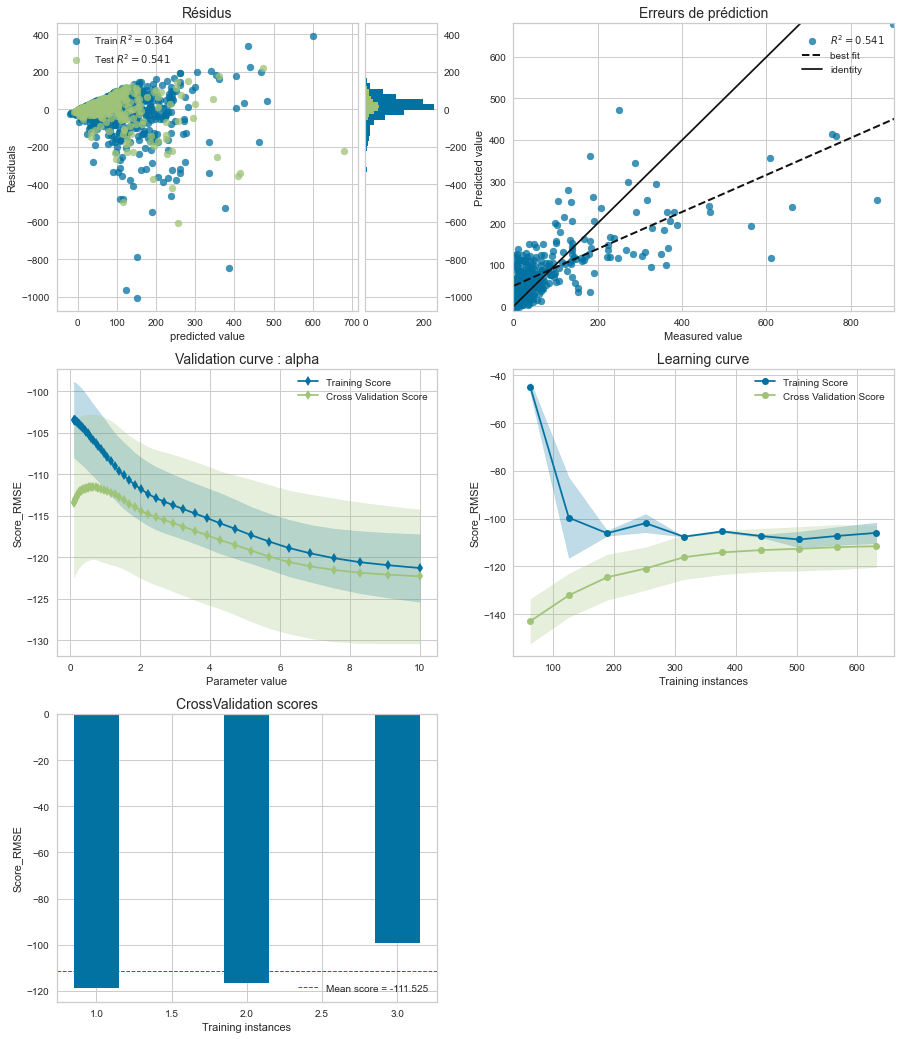

In [225]:
plt.figure(figsize=(15,18))

plt.subplot(3,2, 1)
# visualisation des résidus
model = make_pipeline(preprocessor, ResidualsPlot(Lasso(alpha=best_param[0])))

model.fit(X_train, y_train)
ax = model.score(X_test, y_test)
plt.legend()
plt.title('Résidus', fontsize=14)
plt.xlabel('predicted value')
plt.ylabel('Residuals');

plt.subplot(3,2, 2)
# visu des erreurs de prédiction
model = make_pipeline(preprocessor, PredictionError(Lasso(alpha=best_param[0])))

model.fit(X_train, y_train)
model.score(X_test, y_test)
plt.plot([0,900], [0,900], label='identity', c='k')
plt.legend();
plt.title('Erreurs de prédiction', fontsize=14)
plt.xlabel('Measured value')
plt.ylabel('Predicted value');

plt.subplot(3,2, 3)
# validation curve
viz = make_pipeline(preprocessor, ValidationCurve(Lasso(),
                                                  param_name="alpha",
                                                  param_range=alphas,
                                                  cv=3,
                                                  scoring=score
                                                 )
                   )

viz.fit(X_train, y_train);
plt.legend();
plt.title('Validation curve : alpha', fontsize=14)
plt.xlabel('Parameter value')
plt.ylabel('Score_RMSE');

plt.subplot(3,2, 4)
# Learning curve
sizes = np.linspace(0.1, 1.0, 10)

viz = make_pipeline(preprocessor, LearningCurve(Lasso(alpha=best_param[0]),
                                                cv=3,
                                                train_sizes=sizes,
                                                scoring=score
                                                )
                   )
viz.fit(X_train, y_train);
plt.legend();
plt.title('Learning curve', fontsize=14)
plt.xlabel('Training instances')
plt.ylabel('Score_RMSE');

plt.subplot(3,2, 5)
# visu impact de la crossvalidation
viz = make_pipeline(preprocessor, CVScores(Lasso(alpha=best_param[0]),
                                            cv=3,
                                            scoring=score
                                            )
                   )
viz.fit(X_train, y_train);
plt.legend();
plt.title('CrossValidation scores', fontsize=14)
plt.xlabel('Training instances')
plt.ylabel('Score_RMSE');

## Regression ELASTICNET

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3932066.2951274314, tolerance: 1099.4764391193346
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3905258.8657946624, tolerance: 1086.065622695024
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4552807.219382587, tolerance: 1257.4853333330223
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_desc

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4072307.0765625117, tolerance: 1099.4764391193346
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4035859.436758562, tolerance: 1086.065622695024
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4701172.035179959, tolerance: 1257.4853333330223
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_desce

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4217708.606039241, tolerance: 1099.4764391193346
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4174836.5312994956, tolerance: 1086.065622695024
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4859070.714935263, tolerance: 1257.4853333330223
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_desce

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4365498.820433204, tolerance: 1099.4764391193346
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4319251.0884753615, tolerance: 1086.065622695024
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5022646.678453942, tolerance: 1257.4853333330223
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_desce

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4513254.275117286, tolerance: 1099.4764391193346
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4466071.236233847, tolerance: 1086.065622695024
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5188057.046874102, tolerance: 1257.4853333330223
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descen

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4658955.315984072, tolerance: 1099.4764391193346
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4612210.206596881, tolerance: 1086.065622695024
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5351864.039179641, tolerance: 1257.4853333330223
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descen

Temps d'exécution : 1.19min
Durée du gridSearchCV :  71.6866187999999
MSE : 8679.44
RMSE : 8679.44
RMSLE : nan
RSE : 0.46
R² : 0.54


y_test  linearregression       ridge       lasso  \
2                     304.62        115.799250  117.872235  122.217432   
9                     755.12        451.563286  424.852005  413.688466   
13                      9.68        117.952710  119.370187  126.450006   
19                      3.71         79.866591   84.224678  101.302050   
31                    191.58        211.887115  198.033975  205.314125   
...                      ...               ...         ...         ...   
R²                       NaN          0.538287    0.542532    0.540920   
elasticnet__alpha        NaN               NaN         NaN         NaN   
elasticnet__l1_ratio     NaN               NaN         NaN         NaN   
lasso__alpha             NaN               NaN         NaN    0.655129   
ridge__alpha             NaN               NaN   13.894955         NaN   

                      elasticnet  
2                     119.228298  
9                     412.348549  
13                    120.510996  
19                     89.317835  
31                    196.355002  
...                          ...  
R²                      0.536080  
elasticnet__alpha       0.175751  
elasticnet__l1_ratio    0.900000  
lasso__alpha                 NaN  
ridge__alpha                 NaN  

[326 rows x 5 columns]

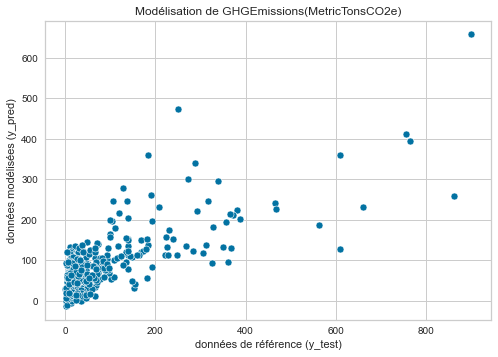

In [226]:
# hyperparamètres à tester
n_alphas = 50
alphas = np.logspace(-1, 0, n_alphas)
l1ratios = np.arange(0,1.1,0.1)

params = {'elasticnet__alpha':alphas,
          'elasticnet__l1_ratio':l1ratios
         }

score = 'neg_root_mean_squared_error'

# modelisation
resultat_GHG = Test_modele_GSCV(nom_run='elasticnet',
                            model=ElasticNet(), 
                            grid_params=params, 
                            cv=3, 
                            score=score, 
                            pipe_preprocessing=preprocessor,
                            X_train=X_train,
                            y_train=y_train,
                            X_test=X_test,
                            y_test=y_test, 
                            resultat=resultat_GHG
                           )
resultat_GHG

### Visu

In [227]:
# récupération des paramètres de best fit
best_param = []
for param in resultat_GHG.filter(regex='elasticnet', axis=0).index:
    print(param)
    best_param.append(resultat_GHG.loc[param, 'elasticnet'])
print(best_param)

elasticnet__alpha
elasticnet__l1_ratio
[0.1757510624854792, 0.9]


C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4141857.776477311, tolerance: 1099.4764391193346
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4080637.105783945, tolerance: 1086.065622695024
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4733519.867025835, tolerance: 1257.4853333330223
  model = cd_fast.sparse_enet_coordinate_descent(


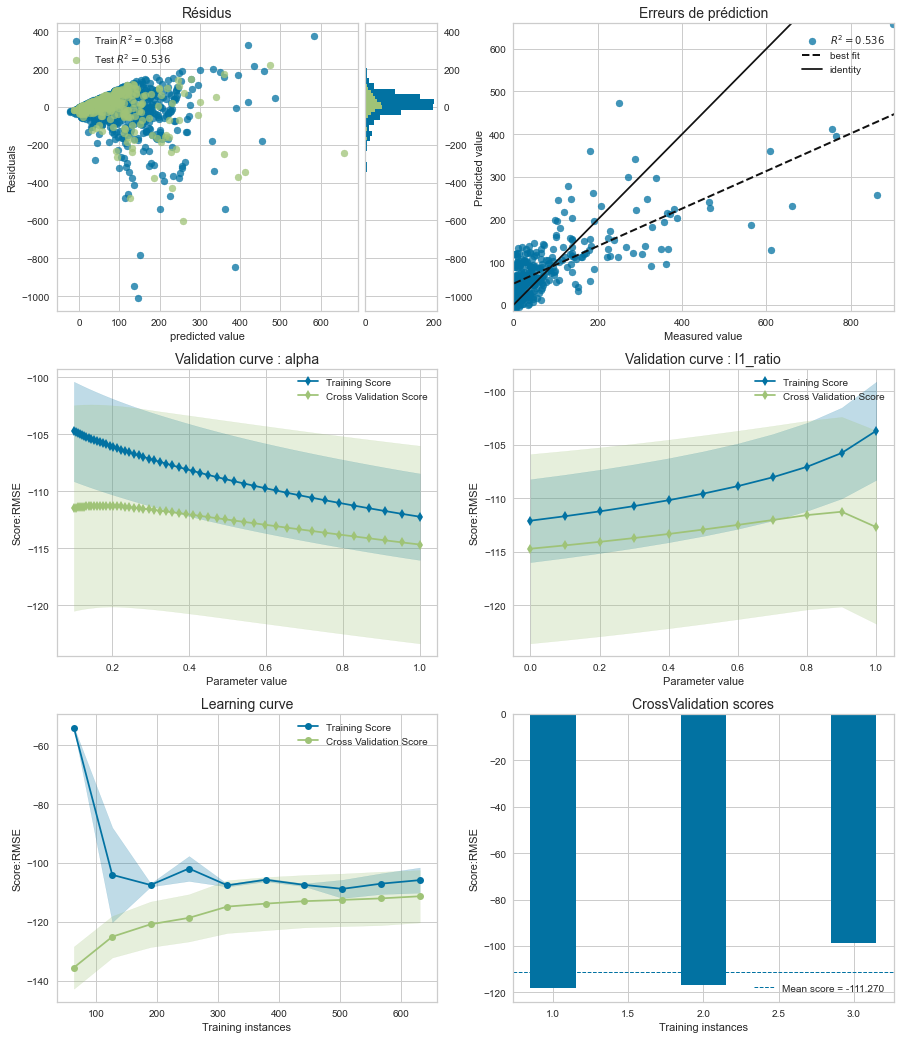

In [228]:
plt.figure(figsize=(15,18))

plt.subplot(3,2, 1)
# visualisation des résidus
model = make_pipeline(preprocessor, ResidualsPlot(ElasticNet(alpha=best_param[0],
                                                             l1_ratio=best_param[1]
                                                            )))

model.fit(X_train, y_train)
ax = model.score(X_test, y_test)
plt.legend()
plt.title('Résidus', fontsize=14)
plt.xlabel('predicted value')
plt.ylabel('Residuals');

plt.subplot(3,2, 2)
# visu des erreurs de prédiction
model = make_pipeline(preprocessor, PredictionError(ElasticNet(alpha=best_param[0],
                                                               l1_ratio=best_param[1])))

model.fit(X_train, y_train)
model.score(X_test, y_test)
plt.plot([0,900], [0,900], label='identity', c='k')
plt.legend();
plt.title('Erreurs de prédiction', fontsize=14)
plt.xlabel('Measured value')
plt.ylabel('Predicted value');

plt.subplot(3,2, 3)
# validation curve
viz = make_pipeline(preprocessor, ValidationCurve(ElasticNet(l1_ratio=best_param[1]),
                                                  param_name="alpha",
                                                  param_range=alphas,
                                                  cv=3,
                                                  scoring=score
                                                 )
                   )

viz.fit(X_train, y_train);
plt.legend();
plt.title('Validation curve : alpha', fontsize=14)
plt.xlabel('Parameter value')
plt.ylabel('Score:RMSE');

plt.subplot(3,2, 4)
# validation curve
viz = make_pipeline(preprocessor, ValidationCurve(ElasticNet(alpha=best_param[0]),
                                                  param_name="l1_ratio",
                                                  param_range=l1ratios,
                                                  cv=3,
                                                  scoring=score
                                                 )
                   )

viz.fit(X_train, y_train);
plt.legend();
plt.title('Validation curve : l1_ratio', fontsize=14)
plt.xlabel('Parameter value')
plt.ylabel('Score:RMSE');

plt.subplot(3,2, 5)
# Learning curve
sizes = np.linspace(0.1, 1.0, 10)

viz = make_pipeline(preprocessor, LearningCurve(ElasticNet(alpha=best_param[0],
                                                           l1_ratio=best_param[1]),
                                                cv=3,
                                                train_sizes=sizes,
                                                scoring=score
                                                )
                   )
viz.fit(X_train, y_train);
plt.legend();
plt.title('Learning curve', fontsize=14)
plt.xlabel('Training instances')
plt.ylabel('Score:RMSE');

plt.subplot(3,2, 6)
# visu impact de la crossvalidation
viz = make_pipeline(preprocessor, CVScores(ElasticNet(alpha=best_param[0],
                                                      l1_ratio=best_param[1]),
                                            cv=3,
                                            scoring=score
                                            )
                   )
viz.fit(X_train, y_train);
plt.legend();
plt.title('CrossValidation scores', fontsize=14)
plt.xlabel('Training instances')
plt.ylabel('Score:RMSE');

## Regression kRR

Temps d'exécution : 1.10min
Durée du gridSearchCV :  66.02827269999989
MSE : 7930.77
RMSE : 7930.77
RMSLE : nan
RSE : 0.42
R² : 0.58


y_test  linearregression       ridge       lasso  \
2                     304.62        115.799250  117.872235  122.217432   
9                     755.12        451.563286  424.852005  413.688466   
13                      9.68        117.952710  119.370187  126.450006   
19                      3.71         79.866591   84.224678  101.302050   
31                    191.58        211.887115  198.033975  205.314125   
...                      ...               ...         ...         ...   
elasticnet__l1_ratio     NaN               NaN         NaN         NaN   
kernelridge__alpha       NaN               NaN         NaN         NaN   
kernelridge__gamma       NaN               NaN         NaN         NaN   
lasso__alpha             NaN               NaN         NaN    0.655129   
ridge__alpha             NaN               NaN   13.894955         NaN   

                      elasticnet     kRR_rbf  
2                     119.228298  149.796659  
9                     412.348549  598.891687  
13                    120.510996  117.295023  
19                     89.317835  112.597857  
31                    196.355002  201.515990  
...                          ...         ...  
elasticnet__l1_ratio    0.900000         NaN  
kernelridge__alpha           NaN    0.233572  
kernelridge__gamma           NaN    0.014384  
lasso__alpha                 NaN         NaN  
ridge__alpha                 NaN         NaN  

[328 rows x 6 columns]

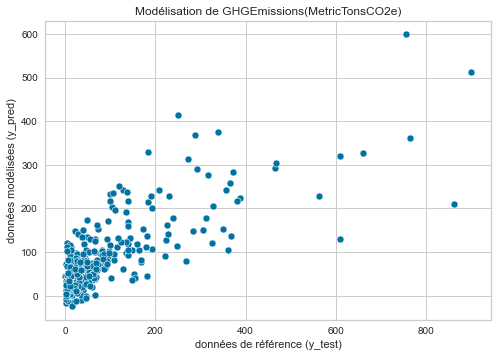

In [229]:
# valeurs du paramètre de régularisation
alpha_range = np.logspace(-2, 0, 20)
# valeurs du paramètre gamma
gamma_range = np.logspace(-3, -1, 20)

# grille de paramètres
params = {'kernelridge__alpha': alpha_range, 
          'kernelridge__gamma': gamma_range}

# score pour sélectionner le modèle optimal
score = 'neg_root_mean_squared_error'

# modelisation
resultat_GHG = Test_modele_GSCV(nom_run='kRR_rbf',
                            model=KernelRidge(kernel='rbf'), 
                            grid_params=params, 
                            cv=3, 
                            score=score, 
                            pipe_preprocessing=preprocessor,
                            X_train=X_train,
                            y_train=y_train,
                            X_test=X_test,
                            y_test=y_test, 
                            resultat=resultat_GHG
                           )
resultat_GHG

### Visu

In [230]:
# récupération des paramètres de best fit
best_param = []
for param in resultat_GHG.filter(regex='kernelridge', axis=0).index:
    print(param)
    best_param.append(resultat_GHG.loc[param, 'kRR_rbf'])
print(best_param)

kernelridge__alpha
kernelridge__gamma
[0.23357214690901212, 0.01438449888287663]


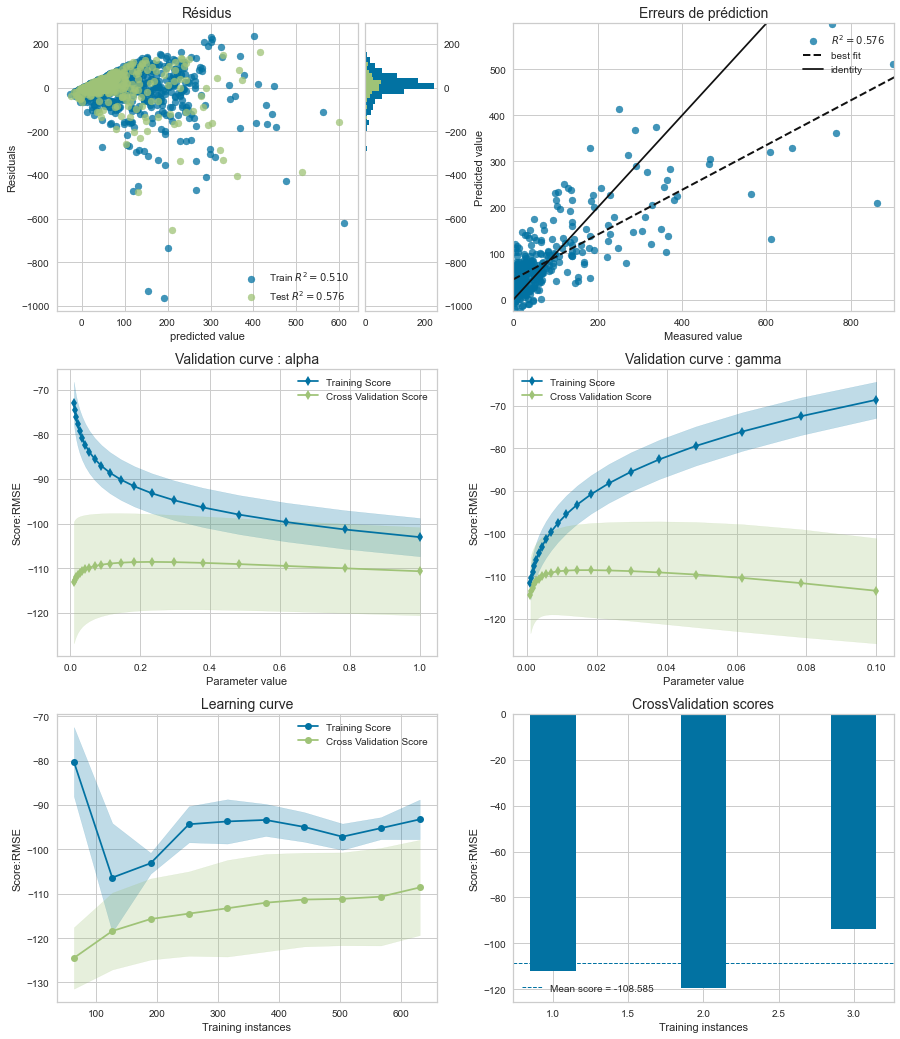

In [231]:
plt.figure(figsize=(15,18))

plt.subplot(3,2, 1)
# visualisation des résidus
model = make_pipeline(preprocessor, ResidualsPlot(KernelRidge(kernel='rbf',
                                                              alpha=best_param[0],
                                                              gamma=best_param[1]
                                                             )))

model.fit(X_train, y_train)
ax = model.score(X_test, y_test)
plt.legend()
plt.title('Résidus', fontsize=14)
plt.xlabel('predicted value')
plt.ylabel('Residuals');

plt.subplot(3,2, 2)
# visu des erreurs de prédiction
model = make_pipeline(preprocessor, PredictionError(KernelRidge(kernel='rbf',
                                                              alpha=best_param[0],
                                                              gamma=best_param[1])))

model.fit(X_train, y_train)
model.score(X_test, y_test)
plt.plot([0,900], [0,900], label='identity', c='k')
plt.legend();
plt.title('Erreurs de prédiction', fontsize=14)
plt.xlabel('Measured value')
plt.ylabel('Predicted value');

plt.subplot(3,2, 3)
# validation curve
viz = make_pipeline(preprocessor, ValidationCurve(KernelRidge(kernel='rbf',
                                                              gamma=best_param[1]),
                                                  param_name="alpha",
                                                  param_range=alpha_range,
                                                  cv=3,
                                                  scoring=score
                                                 )
                   )

viz.fit(X_train, y_train);
plt.legend();
plt.title('Validation curve : alpha', fontsize=14)
plt.xlabel('Parameter value')
plt.ylabel('Score:RMSE');

plt.subplot(3,2, 4)
# validation curve
viz = make_pipeline(preprocessor, ValidationCurve(KernelRidge(kernel='rbf',
                                                              alpha=best_param[0]),
                                                  param_name="gamma",
                                                  param_range=gamma_range,
                                                  cv=3,
                                                  scoring=score
                                                 )
                   )

viz.fit(X_train, y_train);
plt.legend();
plt.title('Validation curve : gamma', fontsize=14)
plt.xlabel('Parameter value')
plt.ylabel('Score:RMSE');

plt.subplot(3,2, 5)
# Learning curve
sizes = np.linspace(0.1, 1.0, 10)

viz = make_pipeline(preprocessor, LearningCurve(KernelRidge(kernel='rbf',
                                                              alpha=best_param[0],
                                                              gamma=best_param[1]),
                                                cv=3,
                                                train_sizes=sizes,
                                                scoring=score
                                                )
                   )
viz.fit(X_train, y_train);
plt.legend();
plt.title('Learning curve', fontsize=14)
plt.xlabel('Training instances')
plt.ylabel('Score:RMSE');

plt.subplot(3,2, 6)
# visu impact de la crossvalidation
viz = make_pipeline(preprocessor, CVScores(KernelRidge(kernel='rbf',
                                                              alpha=best_param[0],
                                                              gamma=best_param[1]),
                                            cv=3,
                                            scoring=score
                                            )
                   )
viz.fit(X_train, y_train);
plt.legend();
plt.title('CrossValidation scores', fontsize=14)
plt.xlabel('Training instances')
plt.ylabel('Score:RMSE');

## Regression bagging : RandomForest

Temps d'exécution : 1.77min
Durée du gridSearchCV :  106.3126385999999
MSE : 9858.47
RMSE : 9858.47
RMSLE : 1.40
RSE : 0.53
R² : 0.47


y_test  linearregression       ridge  \
2                                    304.62        115.799250  117.872235   
9                                    755.12        451.563286  424.852005   
13                                     9.68        117.952710  119.370187   
19                                     3.71         79.866591   84.224678   
31                                   191.58        211.887115  198.033975   
...                                     ...               ...         ...   
lasso__alpha                            NaN               NaN         NaN   
randomforestregressor__max_depth        NaN               NaN         NaN   
randomforestregressor__max_features     NaN               NaN         NaN   
randomforestregressor__n_estimators     NaN               NaN         NaN   
ridge__alpha                            NaN               NaN   13.894955   

                                          lasso  elasticnet     kRR_rbf  \
2                                    122.217432  119.228298  149.796659   
9                                    413.688466  412.348549  598.891687   
13                                   126.450006  120.510996  117.295023   
19                                   101.302050   89.317835  112.597857   
31                                   205.314125  196.355002  201.515990   
...                                         ...         ...         ...   
lasso__alpha                           0.655129         NaN         NaN   
randomforestregressor__max_depth            NaN         NaN         NaN   
randomforestregressor__max_features         NaN         NaN         NaN   
randomforestregressor__n_estimators         NaN         NaN         NaN   
ridge__alpha                                NaN         NaN         NaN   

                                    randomforest  
2                                     256.962531  
9                                     568.519539  
13                                     93.972549  
19                                     81.304581  
31                                     211.05814  
...                                          ...  
lasso__alpha                                 NaN  
randomforestregressor__max_depth            10.0  
randomforestregressor__max_features         sqrt  
randomforestregressor__n_estimators        750.0  
ridge__alpha                                 NaN  

[331 rows x 7 columns]

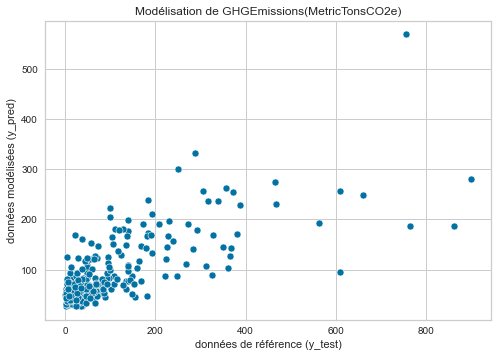

In [232]:
# grille de paramètres
n_estimator_range = [10, 50, 100, 250, 500, 750]
max_depth_range = [1, 2, 3, 4, 5, 10]
max_features_range = ['auto', 'sqrt', 'log2']
params = {"randomforestregressor__n_estimators":n_estimator_range,
          "randomforestregressor__max_depth":max_depth_range, 
          "randomforestregressor__max_features":max_features_range}

# score pour sélectionner le modèle optimal
score = 'neg_root_mean_squared_error'

# modelisation
resultat_GHG = Test_modele_GSCV(nom_run='randomforest',
                            model=RandomForestRegressor(), 
                            grid_params=params, 
                            cv=3, 
                            score=score, 
                            pipe_preprocessing=preprocessor,
                            X_train=X_train,
                            y_train=y_train,
                            X_test=X_test,
                            y_test=y_test, 
                            resultat=resultat_GHG
                           )
resultat_GHG

### Visu

In [233]:
# récupération des paramètres de best fit
best_param = []
for param in resultat_GHG.filter(regex='randomforestregressor', axis=0).index:
    print(param)
    best_param.append(resultat_GHG.loc[param, 'randomforest'])
print(best_param)

randomforestregressor__max_depth
randomforestregressor__max_features
randomforestregressor__n_estimators
[10.0, 'sqrt', 750.0]


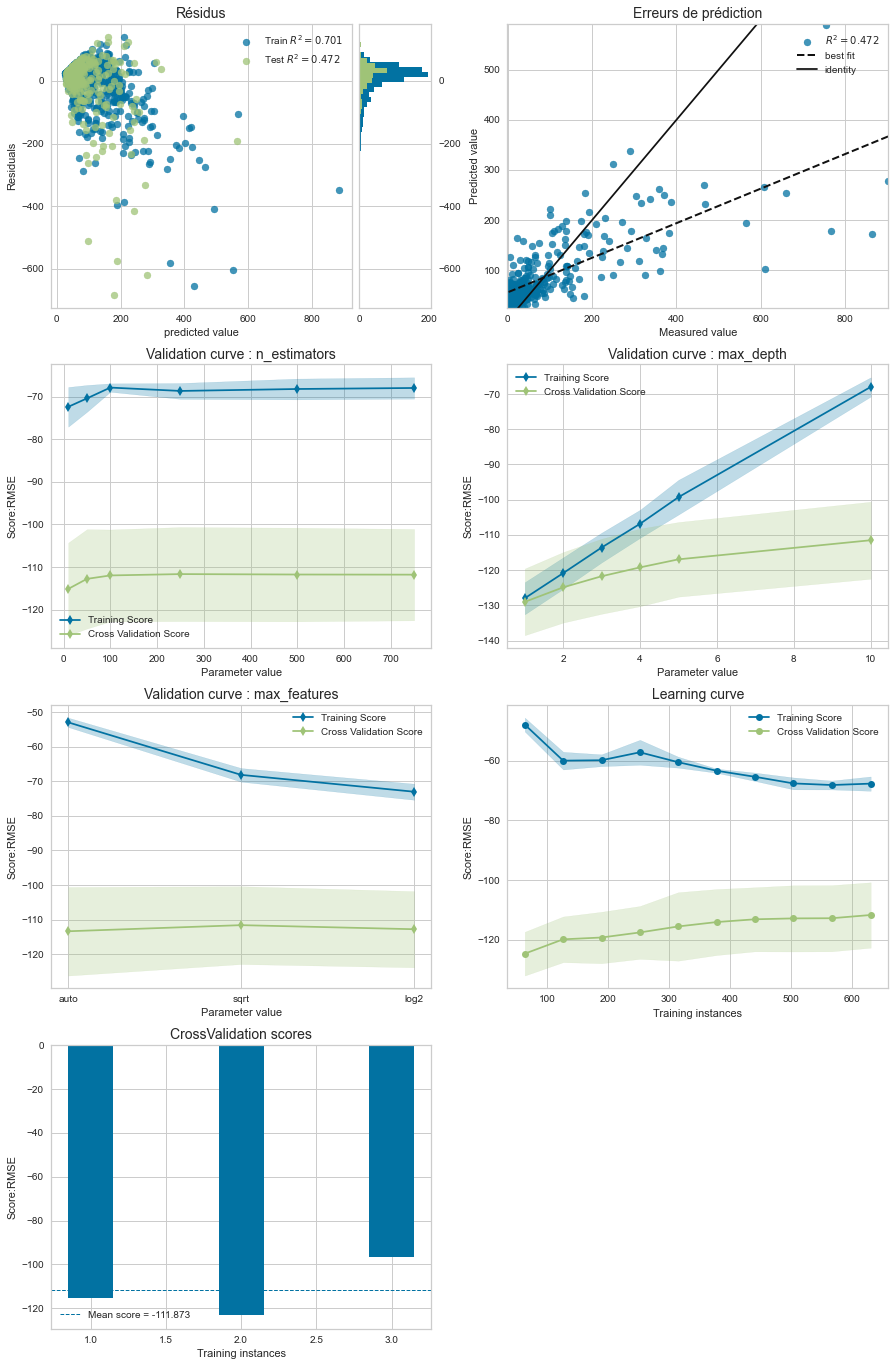

In [234]:
plt.figure(figsize=(15,24))

plt.subplot(4,2, 1)
# visualisation des résidus
model = make_pipeline(preprocessor, ResidualsPlot(RandomForestRegressor(n_estimators=int(best_param[2]), 
                                                                        max_depth=best_param[0], 
                                                                        max_features=best_param[1]
                                                             )))

model.fit(X_train, y_train)
ax = model.score(X_test, y_test)
plt.legend()
plt.title('Résidus', fontsize=14)
plt.xlabel('predicted value')
plt.ylabel('Residuals');

plt.subplot(4,2, 2)
# visu des erreurs de prédiction
model = make_pipeline(preprocessor, PredictionError(RandomForestRegressor(n_estimators=int(best_param[2]), 
                                                                        max_depth=best_param[0], 
                                                                        max_features=best_param[1])))

model.fit(X_train, y_train)
model.score(X_test, y_test)
plt.plot([0,900], [0,900], label='identity', c='k')
plt.legend();
plt.title('Erreurs de prédiction', fontsize=14)
plt.xlabel('Measured value')
plt.ylabel('Predicted value');

plt.subplot(4,2, 3)
# validation curve
viz = make_pipeline(preprocessor, ValidationCurve(RandomForestRegressor(max_depth=best_param[0], 
                                                                        max_features=best_param[1]),
                                                  param_name="n_estimators",
                                                  param_range=n_estimator_range,
                                                  cv=3,
                                                  scoring=score
                                                 )
                   )

viz.fit(X_train, y_train);
plt.legend();
plt.title('Validation curve : n_estimators', fontsize=14)
plt.xlabel('Parameter value')
plt.ylabel('Score:RMSE');

plt.subplot(4,2, 4)
# validation curve
viz = make_pipeline(preprocessor, ValidationCurve(RandomForestRegressor(n_estimators=int(best_param[2]), 
                                                                        max_features=best_param[1]),
                                                  param_name="max_depth",
                                                  param_range=max_depth_range,
                                                  cv=3,
                                                  scoring=score
                                                 )
                   )

viz.fit(X_train, y_train);
plt.legend();
plt.title('Validation curve : max_depth', fontsize=14)
plt.xlabel('Parameter value')
plt.ylabel('Score:RMSE');

plt.subplot(4,2, 5)
# validation curve
viz = make_pipeline(preprocessor, ValidationCurve(RandomForestRegressor(n_estimators=int(best_param[2]), 
                                                                        max_depth=best_param[0]),
                                                  param_name="max_features",
                                                  param_range=max_features_range,
                                                  cv=3,
                                                  scoring=score
                                                 )
                   )

viz.fit(X_train, y_train);
plt.legend();
plt.title('Validation curve : max_features', fontsize=14)
plt.xlabel('Parameter value')
plt.ylabel('Score:RMSE');

plt.subplot(4,2, 6)
# Learning curve
sizes = np.linspace(0.1, 1.0, 10)

viz = make_pipeline(preprocessor, LearningCurve(RandomForestRegressor(n_estimators=int(best_param[2]), 
                                                                        max_depth=best_param[0], 
                                                                        max_features=best_param[1]),
                                                cv=3,
                                                train_sizes=sizes,
                                                scoring=score
                                                )
                   )
viz.fit(X_train, y_train);
plt.legend();
plt.title('Learning curve', fontsize=14)
plt.xlabel('Training instances')
plt.ylabel('Score:RMSE');

plt.subplot(4,2, 7)
# visu impact de la crossvalidation
viz = make_pipeline(preprocessor, CVScores(RandomForestRegressor(n_estimators=int(best_param[2]), 
                                                                        max_depth=best_param[0], 
                                                                        max_features=best_param[1]),
                                            cv=3,
                                            scoring=score
                                            )
                   )
viz.fit(X_train, y_train);
plt.legend();
plt.title('CrossValidation scores', fontsize=14)
plt.xlabel('Training instances')
plt.ylabel('Score:RMSE');

## Regression Boosting : GBoost

Temps d'exécution : 6.19min
Durée du gridSearchCV :  371.3474160999999
MSE : 8471.19
RMSE : 8471.19
RMSLE : 1.01
RSE : 0.45
R² : 0.55


y_test  linearregression       ridge  \
2                                    304.62        115.799250  117.872235   
9                                    755.12        451.563286  424.852005   
13                                     9.68        117.952710  119.370187   
19                                     3.71         79.866591   84.224678   
31                                   191.58        211.887115  198.033975   
...                                     ...               ...         ...   
lasso__alpha                            NaN               NaN         NaN   
randomforestregressor__max_depth        NaN               NaN         NaN   
randomforestregressor__max_features     NaN               NaN         NaN   
randomforestregressor__n_estimators     NaN               NaN         NaN   
ridge__alpha                            NaN               NaN   13.894955   

                                          lasso  elasticnet     kRR_rbf  \
2                                    122.217432  119.228298  149.796659   
9                                    413.688466  412.348549  598.891687   
13                                   126.450006  120.510996  117.295023   
19                                   101.302050   89.317835  112.597857   
31                                   205.314125  196.355002  201.515990   
...                                         ...         ...         ...   
lasso__alpha                           0.655129         NaN         NaN   
randomforestregressor__max_depth            NaN         NaN         NaN   
randomforestregressor__max_features         NaN         NaN         NaN   
randomforestregressor__n_estimators         NaN         NaN         NaN   
ridge__alpha                                NaN         NaN         NaN   

                                    randomforest gradientboosting  
2                                     256.962531       165.090333  
9                                     568.519539       684.920941  
13                                     93.972549        68.649595  
19                                     81.304581        44.414736  
31                                     211.05814       190.674148  
...                                          ...              ...  
lasso__alpha                                 NaN              NaN  
randomforestregressor__max_depth            10.0              NaN  
randomforestregressor__max_features         sqrt              NaN  
randomforestregressor__n_estimators        750.0              NaN  
ridge__alpha                                 NaN              NaN  

[336 rows x 8 columns]

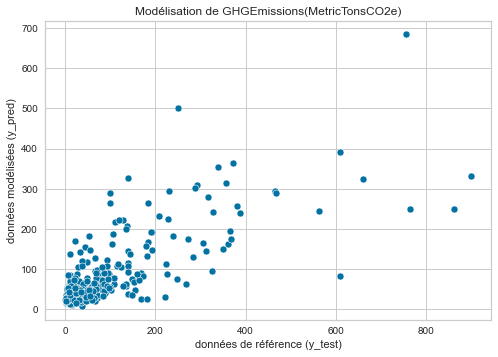

In [235]:
# grille de paramètres
n_estimators_range = [10, 100, 500]
max_depth_range = [1, 3, 5, 10]
max_features_range = ['auto', 'sqrt', 'log2']
learning_rate_range = [0.01, 0.1, 0.5 , 1]
loss_range = ['squared_error', 'absolute_error']
params = {"gradientboostingregressor__n_estimators":n_estimators_range,
          "gradientboostingregressor__max_depth":max_depth_range, 
          "gradientboostingregressor__max_features":max_features_range, 
          'gradientboostingregressor__learning_rate':learning_rate_range,
          'gradientboostingregressor__loss':loss_range
         }

# score pour sélectionner le modèle optimal
score = 'neg_root_mean_squared_error'

# Modélisation
resultat_GHG = Test_modele_GSCV(nom_run='gradientboosting',
                            model=GradientBoostingRegressor(), 
                            grid_params=params, 
                            cv=3, 
                            score=score, 
                            pipe_preprocessing=preprocessor,
                            X_train=X_train,
                            y_train=y_train,
                            X_test=X_test,
                            y_test=y_test, 
                            resultat=resultat_GHG
                           )
resultat_GHG

### Visu

In [236]:
# récupération des paramètres de best fit
best_param = []
for param in resultat_GHG.filter(regex='gradientboostingregressor', axis=0).index:
    print(param)
    best_param.append(resultat_GHG.loc[param, 'gradientboosting'])
print(best_param)

gradientboostingregressor__learning_rate
gradientboostingregressor__loss
gradientboostingregressor__max_depth
gradientboostingregressor__max_features
gradientboostingregressor__n_estimators
[0.1, 'absolute_error', 10.0, 'auto', 500.0]


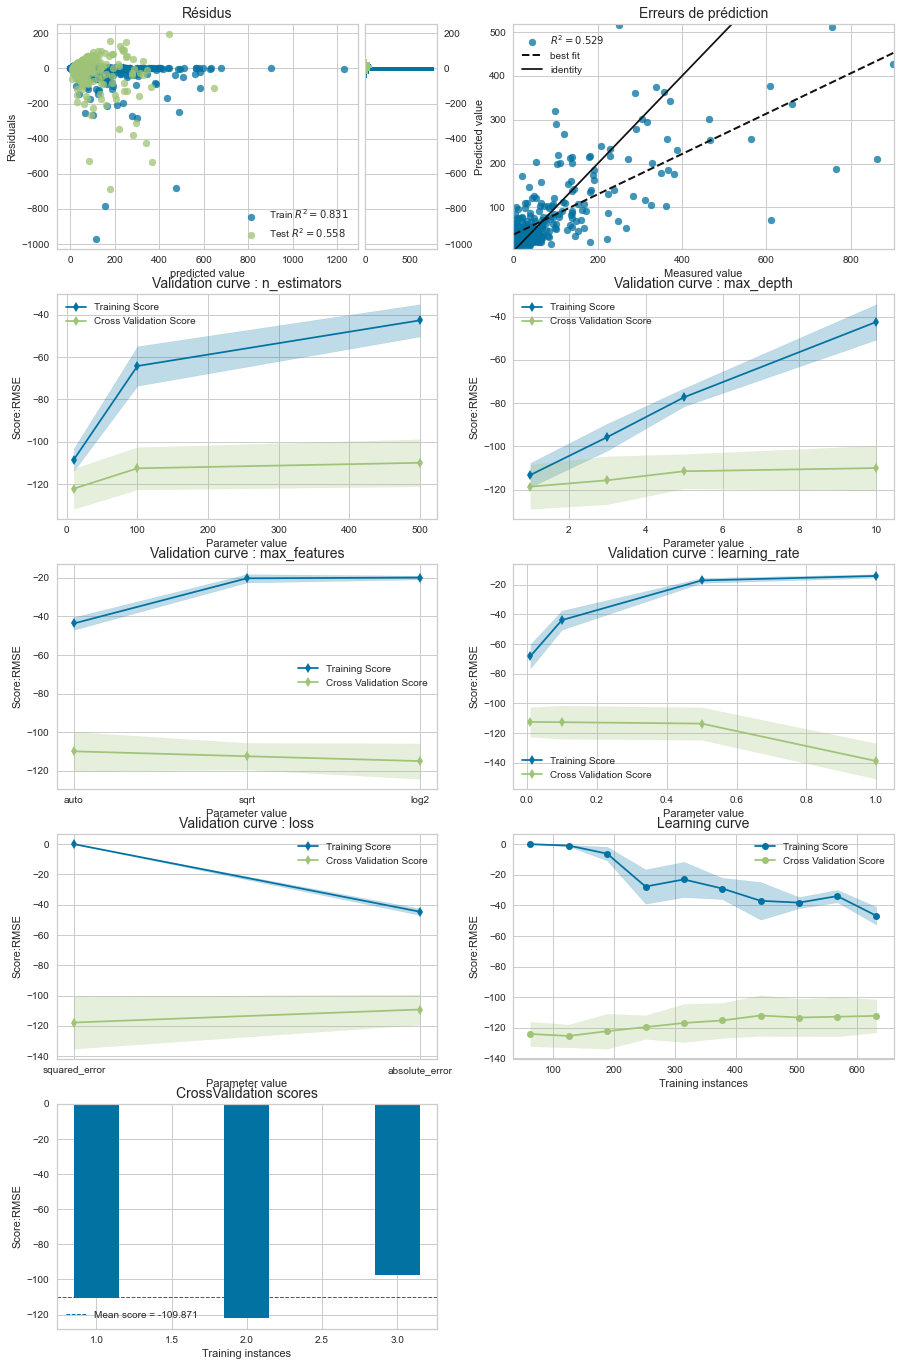

In [237]:
plt.figure(figsize=(15,24))

plt.subplot(5,2, 1)
# visualisation des résidus
model = make_pipeline(preprocessor, ResidualsPlot(GradientBoostingRegressor(n_estimators=int(best_param[4]), 
                                                                            max_depth=best_param[2],
                                                                            max_features=best_param[3],
                                                                            learning_rate=best_param[0],
                                                                            loss=best_param[1]
                                                             )))

model.fit(X_train, y_train)
ax = model.score(X_test, y_test)
plt.legend()
plt.title('Résidus', fontsize=14)
plt.xlabel('predicted value')
plt.ylabel('Residuals');

plt.subplot(5,2, 2)
# visu des erreurs de prédiction
model = make_pipeline(preprocessor, PredictionError(GradientBoostingRegressor(n_estimators=int(best_param[4]), 
                                                                            max_depth=best_param[2],
                                                                            max_features=best_param[3],
                                                                            learning_rate=best_param[0],
                                                                            loss=best_param[1])))

model.fit(X_train, y_train)
model.score(X_test, y_test)
plt.plot([0,900], [0,900], label='identity', c='k')
plt.legend();
plt.title('Erreurs de prédiction', fontsize=14)
plt.xlabel('Measured value')
plt.ylabel('Predicted value');

plt.subplot(5,2, 3)
# validation curve
viz = make_pipeline(preprocessor, ValidationCurve(GradientBoostingRegressor(max_depth=best_param[2],
                                                                            max_features=best_param[3],
                                                                            learning_rate=best_param[0],
                                                                            loss=best_param[1]),
                                                  param_name="n_estimators",
                                                  param_range=n_estimators_range,
                                                  cv=3,
                                                  scoring=score
                                                 )
                   )

viz.fit(X_train, y_train);
plt.legend();
plt.title('Validation curve : n_estimators', fontsize=14)
plt.xlabel('Parameter value')
plt.ylabel('Score:RMSE');

plt.subplot(5,2, 4)
# validation curve
viz = make_pipeline(preprocessor, ValidationCurve(GradientBoostingRegressor(n_estimators=int(best_param[4]), 
                                                                            max_features=best_param[3],
                                                                            learning_rate=best_param[0],
                                                                            loss=best_param[1]),
                                                  param_name="max_depth",
                                                  param_range=max_depth_range,
                                                  cv=3,
                                                  scoring=score
                                                 )
                   )

viz.fit(X_train, y_train);
plt.legend();
plt.title('Validation curve : max_depth', fontsize=14)
plt.xlabel('Parameter value')
plt.ylabel('Score:RMSE');

plt.subplot(5,2, 5)
# validation curve
viz = make_pipeline(preprocessor, ValidationCurve(GradientBoostingRegressor(n_estimators=int(best_param[4]), 
                                                                            max_depth=best_param[2],
                                                                            learning_rate=best_param[0],
                                                                            loss=best_param[1]),
                                                  param_name="max_features",
                                                  param_range=max_features_range,
                                                  cv=3,
                                                  scoring=score
                                                 )
                   )

viz.fit(X_train, y_train);
plt.legend();
plt.title('Validation curve : max_features', fontsize=14)
plt.xlabel('Parameter value')
plt.ylabel('Score:RMSE');

plt.subplot(5,2, 6)
# validation curve
viz = make_pipeline(preprocessor, ValidationCurve(GradientBoostingRegressor(n_estimators=int(best_param[4]), 
                                                                            max_depth=best_param[2],
                                                                            max_features=best_param[3],
                                                                            loss=best_param[1]),
                                                  param_name="learning_rate",
                                                  param_range=learning_rate_range,
                                                  cv=3,
                                                  scoring=score
                                                 )
                   )

viz.fit(X_train, y_train);
plt.legend();
plt.title('Validation curve : learning_rate', fontsize=14)
plt.xlabel('Parameter value')
plt.ylabel('Score:RMSE');

plt.subplot(5,2, 7)
# validation curve
viz = make_pipeline(preprocessor, ValidationCurve(GradientBoostingRegressor(n_estimators=int(best_param[4]), 
                                                                            max_depth=best_param[2],
                                                                            max_features=best_param[3],
                                                                            learning_rate=best_param[0]),
                                                  param_name="loss",
                                                  param_range=loss_range,
                                                  cv=3,
                                                  scoring=score
                                                 )
                   )

viz.fit(X_train, y_train);
plt.legend();
plt.title('Validation curve : loss', fontsize=14)
plt.xlabel('Parameter value')
plt.ylabel('Score:RMSE');

plt.subplot(5,2, 8)
# Learning curve
sizes = np.linspace(0.1, 1.0, 10)

viz = make_pipeline(preprocessor, LearningCurve(GradientBoostingRegressor(n_estimators=int(best_param[4]), 
                                                                            max_depth=best_param[2],
                                                                            max_features=best_param[3],
                                                                            learning_rate=best_param[0],
                                                                            loss=best_param[1]),
                                                cv=3,
                                                train_sizes=sizes,
                                                scoring=score
                                                )
                   )
viz.fit(X_train, y_train);
plt.legend();
plt.title('Learning curve', fontsize=14)
plt.xlabel('Training instances')
plt.ylabel('Score:RMSE');

plt.subplot(5,2, 9)
# visu impact de la crossvalidation
viz = make_pipeline(preprocessor, CVScores(GradientBoostingRegressor(n_estimators=int(best_param[4]), 
                                                                            max_depth=best_param[2],
                                                                            max_features=best_param[3],
                                                                            learning_rate=best_param[0],
                                                                            loss=best_param[1]),
                                            cv=3,
                                            scoring=score
                                            )
                   )
viz.fit(X_train, y_train);
plt.legend();
plt.title('CrossValidation scores', fontsize=14)
plt.xlabel('Training instances')
plt.ylabel('Score:RMSE');

In [238]:
resultat_GHG.tail(25)

y_test  linearregression  \
1234                                      117.65        138.388570   
1242                                       56.48         62.090787   
1249                                       19.40         64.054752   
1253                                       21.18        153.034449   
1254                                       99.95        193.868629   
Duree calcul (s)                             NaN          0.044517   
MSE                                          NaN       8638.167158   
RMSE                                         NaN         92.941741   
RMSLE                                        NaN               NaN   
RSE                                          NaN          0.461713   
R²                                           NaN          0.538287   
elasticnet__alpha                            NaN               NaN   
elasticnet__l1_ratio                         NaN               NaN   
gradientboostingregressor__learning_rate     NaN               NaN   
gradientboostingregressor__loss              NaN               NaN   
gradientboostingregressor__max_depth         NaN               NaN   
gradientboostingregressor__max_features      NaN               NaN   
gradientboostingregressor__n_estimators      NaN               NaN   
kernelridge__alpha                           NaN               NaN   
kernelridge__gamma                           NaN               NaN   
lasso__alpha                                 NaN               NaN   
randomforestregressor__max_depth             NaN               NaN   
randomforestregressor__max_features          NaN               NaN   
randomforestregressor__n_estimators          NaN               NaN   
ridge__alpha                                 NaN               NaN   

                                                ridge        lasso  \
1234                                       136.931911   129.675505   
1242                                        65.802010    58.348712   
1249                                        62.097820    58.164064   
1253                                       143.065319   124.076382   
1254                                       177.502024   152.117135   
Duree calcul (s)                             0.012363     0.032875   
MSE                                       8558.745056  8588.902717   
RMSE                                        92.513486    92.676333   
RMSLE                                             NaN          NaN   
RSE                                          0.457468     0.459080   
R²                                           0.542532     0.540920   
elasticnet__alpha                                 NaN          NaN   
elasticnet__l1_ratio                              NaN          NaN   
gradientboostingregressor__learning_rate          NaN          NaN   
gradientboostingregressor__loss                   NaN          NaN   
gradientboostingregressor__max_depth              NaN          NaN   
gradientboostingregressor__max_features           NaN          NaN   
gradientboostingregressor__n_estimators           NaN          NaN   
kernelridge__alpha                                NaN          NaN   
kernelridge__gamma                                NaN          NaN   
lasso__alpha                                      NaN     0.655129   
randomforestregressor__max_depth                  NaN          NaN   
randomforestregressor__max_features               NaN          NaN   
randomforestregressor__n_estimators               NaN          NaN   
ridge__alpha                                13.894955          NaN   

                                           elasticnet      kRR_rbf  \
1234                                       136.616976   132.735583   
1242                                        64.860355    64.619361   
1249                                        60.488510    61.121471   
1253                                       136.527666   147.500084   
1254                                       164.653

## Comparaison des modélisations

In [239]:
resultat_GHG = nb_val_negatives(resultat_GHG, index_max=1254)

# # Calcul du nombre de valeurs négatives
# for model in resultat_GHG.columns:
#     resultat_GHG.loc['nb valeurs negatives', model] = np.sum(resultat_GHG.loc[:1254,model] < 0)
resultat_GHG.loc['nb valeurs negatives']

y_test               0.0
linearregression    20.0
ridge               12.0
lasso                5.0
elasticnet           8.0
kRR_rbf             15.0
randomforest           0
gradientboosting       0
Name: nb valeurs negatives, dtype: object

In [240]:
lignes = ['Duree calcul (s)', 'MSE', 'RMSE', 'RMSLE', 'RSE', 'R²', 'nb valeurs negatives']
comparaison_GHG = resultat_GHG.loc[lignes, :].T
comparaison_GHG = comparaison_GHG.drop('y_test', axis=0).reset_index()
comparaison_GHG

index Duree calcul (s)          MSE       RMSE     RMSLE  \
0  linearregression         0.044517  8638.167158  92.941741       NaN   
1             ridge         0.012363  8558.745056  92.513486       NaN   
2             lasso         0.032875  8588.902717  92.676333       NaN   
3        elasticnet         0.025042  8679.443915  93.163533       NaN   
4           kRR_rbf         0.053793  7930.769786   89.05487       NaN   
5      randomforest         1.079351  9858.471793  99.289837  1.398203   
6  gradientboosting         5.178364  8471.185058  92.039041  1.006755   

        RSE        R² nb valeurs negatives  
0  0.461713  0.538287                 20.0  
1  0.457468  0.542532                 12.0  
2   0.45908   0.54092                  5.0  
3   0.46392   0.53608                  8.0  
4  0.423903  0.576097                 15.0  
5  0.526939  0.473061                    0  
6  0.452788  0.547212                    0

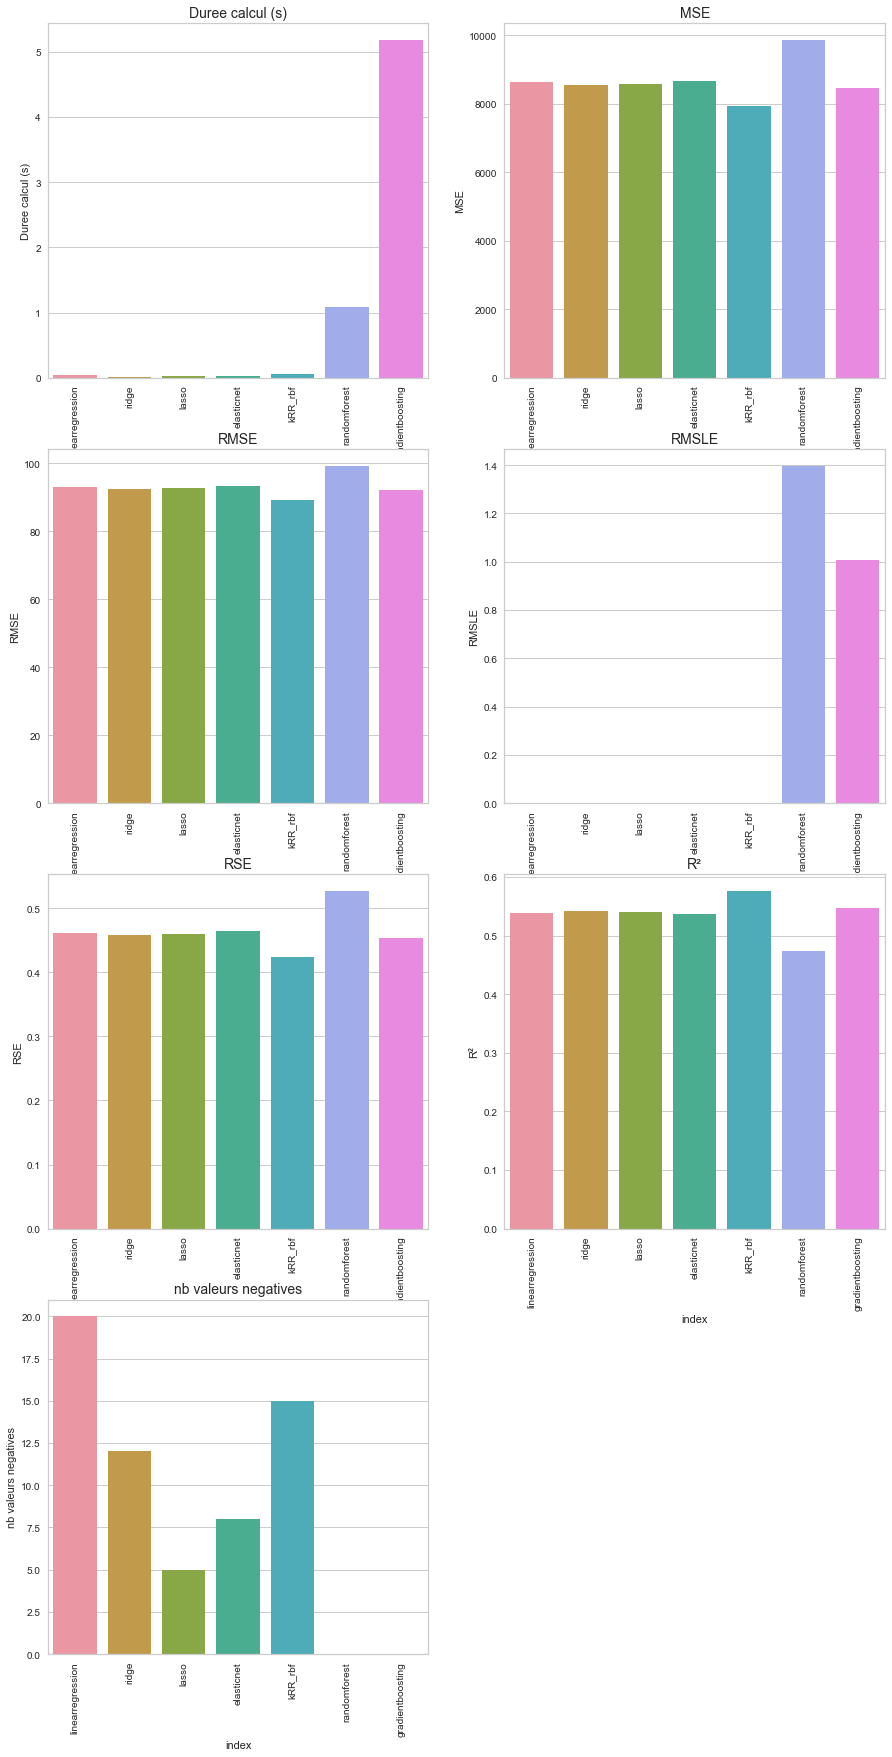

In [241]:
plt.figure(figsize=(15,30))
compteur = 1
for metrique in lignes:
    plt.subplot(4,2, compteur)
    sns.barplot(data=comparaison_GHG, x='index', y=metrique, label=False)
    plt.title(metrique, fontsize=14)
    plt.xticks(rotation = 90)
    compteur += 1

In [242]:
# visu
lignes = ['RMSE', 'R²', 'nb valeurs negatives', 'Duree calcul (s)']
visu_GHG = resultat_GHG.loc[lignes, :].T
visu_GHG = visu_GHG.drop('y_test', axis=0).reset_index()
visu_GHG

index       RMSE        R² nb valeurs negatives Duree calcul (s)
0  linearregression  92.941741  0.538287                 20.0         0.044517
1             ridge  92.513486  0.542532                 12.0         0.012363
2             lasso  92.676333   0.54092                  5.0         0.032875
3        elasticnet  93.163533   0.53608                  8.0         0.025042
4           kRR_rbf   89.05487  0.576097                 15.0         0.053793
5      randomforest  99.289837  0.473061                    0         1.079351
6  gradientboosting  92.039041  0.547212                    0         5.178364

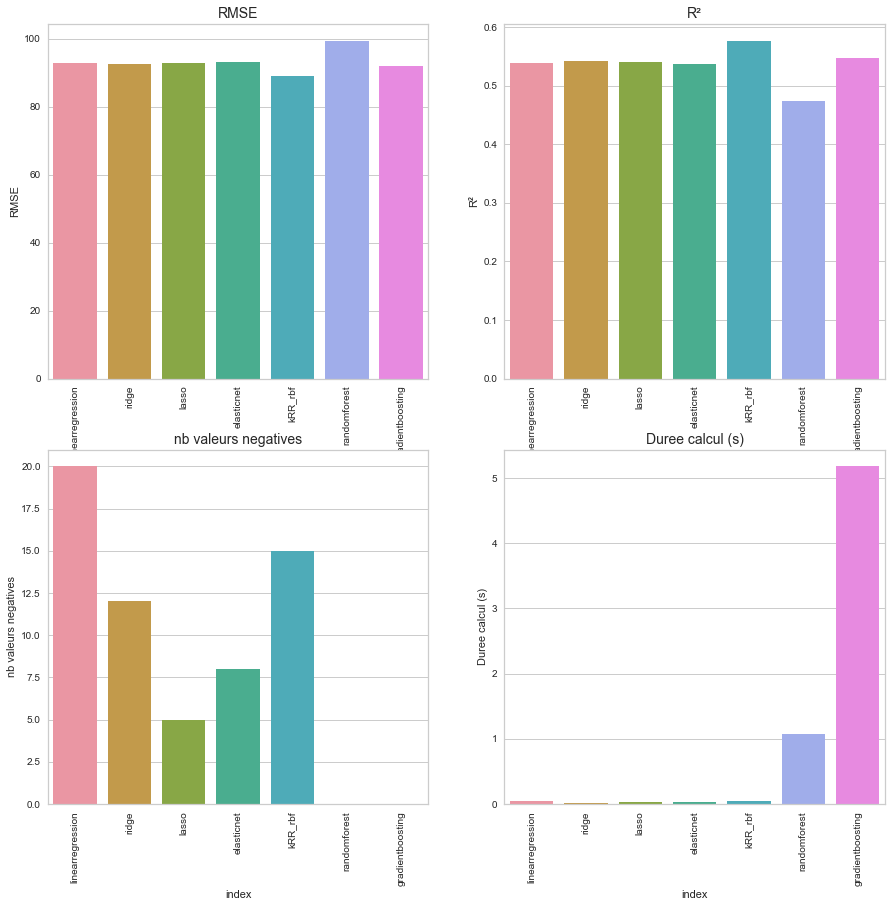

In [243]:
plt.figure(figsize=(15,30))
compteur = 1
for metrique in lignes:
    plt.subplot(4,2, compteur)
    sns.barplot(data=comparaison_GHG, x='index', y=metrique, label=False)
    plt.title(metrique, fontsize=14)
    plt.xticks(rotation = 90)
    compteur += 1

In [244]:
resultat_GHG['kRR_rbf'].tail(25)

1242                                          64.619361
1249                                          61.121471
1253                                         147.500084
1254                                         217.236589
Duree calcul (s)                               0.053793
MSE                                         7930.769786
RMSE                                          89.054870
RMSLE                                               NaN
RSE                                            0.423903
R²                                             0.576097
elasticnet__alpha                                   NaN
elasticnet__l1_ratio                                NaN
gradientboostingregressor__learning_rate            NaN
gradientboostingregressor__loss                     NaN
gradientboostingregressor__max_depth                NaN
gradientboostingregressor__max_features             NaN
gradientboostingregressor__n_estimators             NaN
kernelridge__alpha                             0

## CONCLUSION

Le modèle optimal est la régression kernelRidge avec un kernel gaussien :
- temps de calcul minim
- meilleures metriques (R² = 0.58)

Par contre il s'agit d'un modèle qui génère plus de valeurs négatives que la plupart (15 soit 5% du test_set)

Si l'on souhaite minimiser le nombre de valeurs négatives générées tout en gardant un temps de calcul raisonnable, alors la regression Lasso est un bon modèle :
- temps de calcul équivalent au kRR
- nombre de valeurs négatives = 5, soit 2% du test_set

par contre les métriques sont un peu moins bonnes (R² = 0.54)

# GHGEmissions sans EnergyStarScore

## Préparation des données

In [245]:
X = data.drop(['Unnamed: 0', 'SiteEnergyUse(kBtu)', 
               'GHGEmissions(MetricTonsCO2e)', 'ENERGYSTARScore', 'train/test'], axis=1)
y = data['GHGEmissions(MetricTonsCO2e)']

X_quanti = X.select_dtypes(['float64', 'int64'])
X_categ = X.select_dtypes(['object'])

# selection des données en fonction des différents traitement à leur affecter
X_quanti_GFA = list(X_quanti.filter(regex='GFA').columns)
X_quanti_others = list(X_quanti.drop(X_quanti_GFA, axis=1).columns)
X_categ = list(X_categ.columns)

# mise en place des pipelines pour les données quantitatives
GFA_pipeline = make_pipeline(SimpleImputer(strategy='constant', fill_value=0), StandardScaler())
Other_quanti_pipeline = make_pipeline(StandardScaler())
# et categorielles
categ_pipeline = make_pipeline(SimpleImputer(strategy='constant', fill_value='None'), OneHotEncoder())

preprocessor = make_column_transformer((GFA_pipeline, X_quanti_GFA), 
                                       (Other_quanti_pipeline, X_quanti_others),
                                       (categ_pipeline, X_categ))

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rs_opt)

## Baseline : régression linéaire simple

In [246]:
start_time = timeit.default_timer()

model = make_pipeline(preprocessor, LinearRegression())

model.fit(X_train, y_train)
print(model.score(X_test, y_test))

elapsed = timeit.default_timer() - start_time

print(f'Temps d\'exécution : {elapsed:.2}s')

0.5176814915453736
Temps d'exécution : 0.037s


MSE : 9023.67
RMSE : 94.99
RSE : 0.48
R² : 0.52


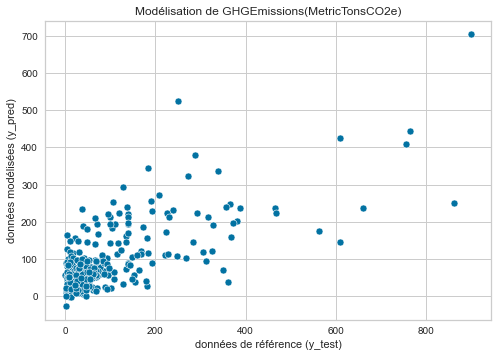

In [247]:
y_pred = model.predict(X_test)

# calcul metriques
print("MSE : {:.2f}".format(metrics.mean_squared_error(y_test, y_pred)))
print("RMSE : {:.2f}".format(np.sqrt( metrics.mean_squared_error(y_test, y_pred) )))
# print("RMSLE : {:.2f}".format(metrics.mean_squared_log_error(y_test, y_pred)))
print("RSE : {:.2f}".format(1-metrics.r2_score(y_test, y_pred)))
print("R² : {:.2f}".format(metrics.r2_score(y_test, y_pred)))

sns.scatterplot(x=y_test, y=y_pred);
plt.xlabel('données de référence (y_test)')
plt.ylabel('données modélisées (y_pred)')
plt.title('Modélisation de GHGEmissions(MetricTonsCO2e)');

### Visu

0.5176814915453736


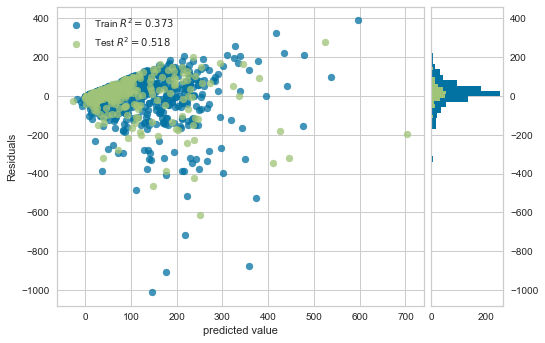

In [248]:
# visu des résidus du train_set et du test_set

model = make_pipeline(preprocessor, ResidualsPlot(LinearRegression()))

model.fit(X_train, y_train)
print(model.score(X_test, y_test))
plt.legend();
plt.xlabel('predicted value')
plt.ylabel('Residuals');

0.5176814915453736


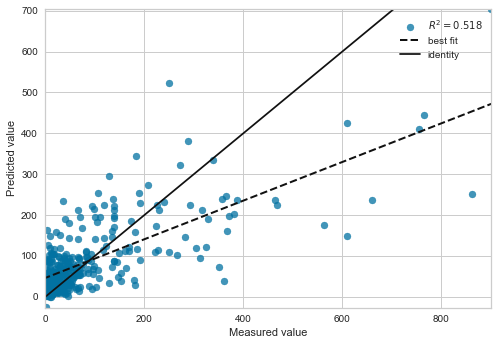

In [249]:
# visu des erreurs de prédiction
model = make_pipeline(preprocessor, PredictionError(LinearRegression()))

model.fit(X_train, y_train)
print(model.score(X_test, y_test))
plt.plot([0,900], [0,900], label='identity', c='k')
plt.legend();
plt.xlabel('Measured value')
plt.ylabel('Predicted value');

### Stockage des résultats

In [250]:
resultat_GHG_noESS = initialisation_resultats(nom_baseline='linearregression', y_test=y_test, y_pred=y_pred)
resultat_GHG_noESS

y_test  linearregression
2      304.62        119.052591
9      755.12        409.723510
13       9.68        118.562142
19       3.71         81.988881
31     191.58        228.407333
...       ...               ...
MSE       NaN       9023.668988
RMSE      NaN         94.992994
RMSLE     NaN               NaN
RSE       NaN          0.482319
R²        NaN          0.517681

[322 rows x 2 columns]

## Regression RIDGE

Temps d'exécution : 2.93s
Durée du gridSearchCV :  2.9312359000005017
MSE : 9044.70
RMSE : 9044.70
RMSLE : 1.32
RSE : 0.48
R² : 0.52


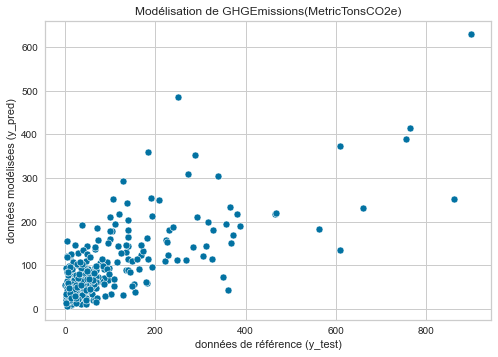

In [251]:
# hyperparamètres à tester
n_alpha = 50
alphas = np.logspace(0, 2, n_alpha)

params = {'ridge__alpha':alphas}

score = 'neg_root_mean_squared_error'

# modelisation
resultat_GHG_noESS = Test_modele_GSCV(nom_run='ridge',
                            model=Ridge(), 
                            grid_params=params, 
                            cv=3, 
                            score=score, 
                            pipe_preprocessing=preprocessor,
                            X_train=X_train,
                            y_train=y_train,
                            X_test=X_test,
                            y_test=y_test, 
                            resultat=resultat_GHG_noESS
                           )

### Visu

In [252]:
# récupération des paramètres de best fit
best_param = []
for param in resultat_GHG_noESS.filter(regex='ridge', axis=0).index:
    print(param)
    best_param.append(resultat_GHG_noESS.loc[param, 'ridge'])
print(best_param)

ridge__alpha
[13.894954943731374]


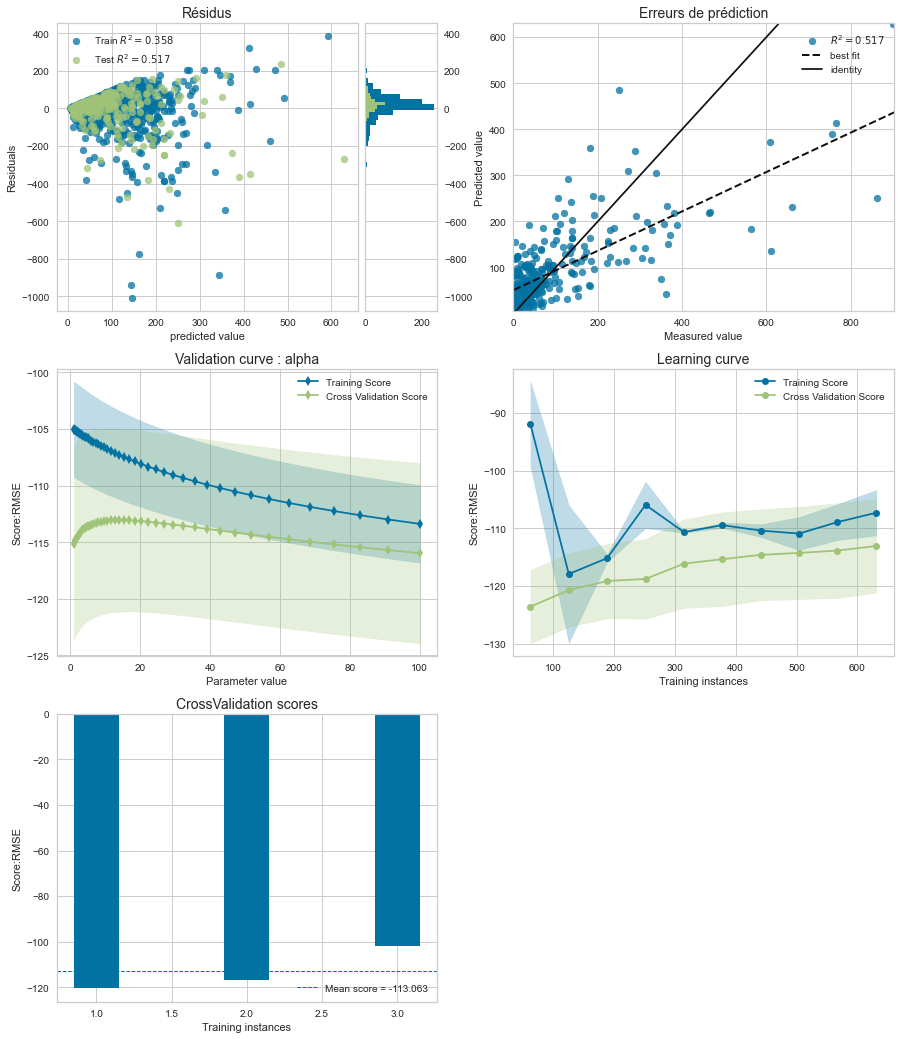

In [253]:
plt.figure(figsize=(15,18))

plt.subplot(3,2, 1)
# visualisation des résidus
model = make_pipeline(preprocessor, ResidualsPlot(Ridge(alpha=best_param[0])))

model.fit(X_train, y_train)
ax = model.score(X_test, y_test)
plt.legend()
plt.title('Résidus', fontsize=14)
plt.xlabel('predicted value')
plt.ylabel('Residuals');

plt.subplot(3,2, 2)
# visu des erreurs de prédiction
model = make_pipeline(preprocessor, PredictionError(Ridge(alpha=best_param[0])))

model.fit(X_train, y_train)
model.score(X_test, y_test)
plt.plot([0,900], [0,900], label='identity', c='k')
plt.legend();
plt.title('Erreurs de prédiction', fontsize=14)
plt.xlabel('Measured value')
plt.ylabel('Predicted value');

plt.subplot(3,2, 3)
# validation curve
viz = make_pipeline(preprocessor, ValidationCurve(Ridge(),
                                                  param_name="alpha",
                                                  param_range=alphas,
                                                  cv=3,
                                                  scoring=score
                                                 )
                   )

viz.fit(X_train, y_train);
plt.legend();
plt.title('Validation curve : alpha', fontsize=14)
plt.xlabel('Parameter value')
plt.ylabel('Score:RMSE');

plt.subplot(3,2, 4)
# Learning curve
sizes = np.linspace(0.1, 1.0, 10)

viz = make_pipeline(preprocessor, LearningCurve(Ridge(alpha=best_param[0]),
                                                cv=3,
                                                train_sizes=sizes,
                                                scoring=score
                                                )
                   )
viz.fit(X_train, y_train);
plt.legend();
plt.title('Learning curve', fontsize=14)
plt.xlabel('Training instances')
plt.ylabel('Score:RMSE');

plt.subplot(3,2, 5)
# visu impact de la crossvalidation
viz = make_pipeline(preprocessor, CVScores(Ridge(alpha=best_param[0]),
                                            cv=3,
                                            scoring=score
                                            )
                   )
viz.fit(X_train, y_train);
plt.legend();
plt.title('CrossValidation scores', fontsize=14)
plt.xlabel('Training instances')
plt.ylabel('Score:RMSE');

## Regression LASSO

Temps d'exécution : 3.85s
Durée du gridSearchCV :  3.8533300999997664
MSE : 9151.72
RMSE : 9151.72
RMSLE : 1.36
RSE : 0.49
R² : 0.51


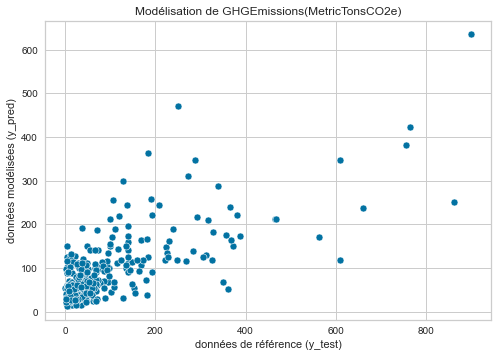

In [254]:
# hyperparamètres à tester
n_alphas = 50
alphas = np.logspace(-1, 1, n_alphas)

params = {'lasso__alpha':alphas}

score = 'neg_root_mean_squared_error'

# modelisation
resultat_GHG_noESS = Test_modele_GSCV(nom_run='lasso',
                            model=Lasso(), 
                            grid_params=params, 
                            cv=3, 
                            score=score, 
                            pipe_preprocessing=preprocessor,
                            X_train=X_train,
                            y_train=y_train,
                            X_test=X_test,
                            y_test=y_test, 
                            resultat=resultat_GHG_noESS
                           )

### Visu

In [255]:
# récupération des paramètres de best fit
best_param = []
for param in resultat_GHG_noESS.filter(regex='lasso', axis=0).index:
    print(param)
    best_param.append(resultat_GHG_noESS.loc[param, 'lasso'])
print(best_param)

lasso__alpha
[0.6551285568595507]


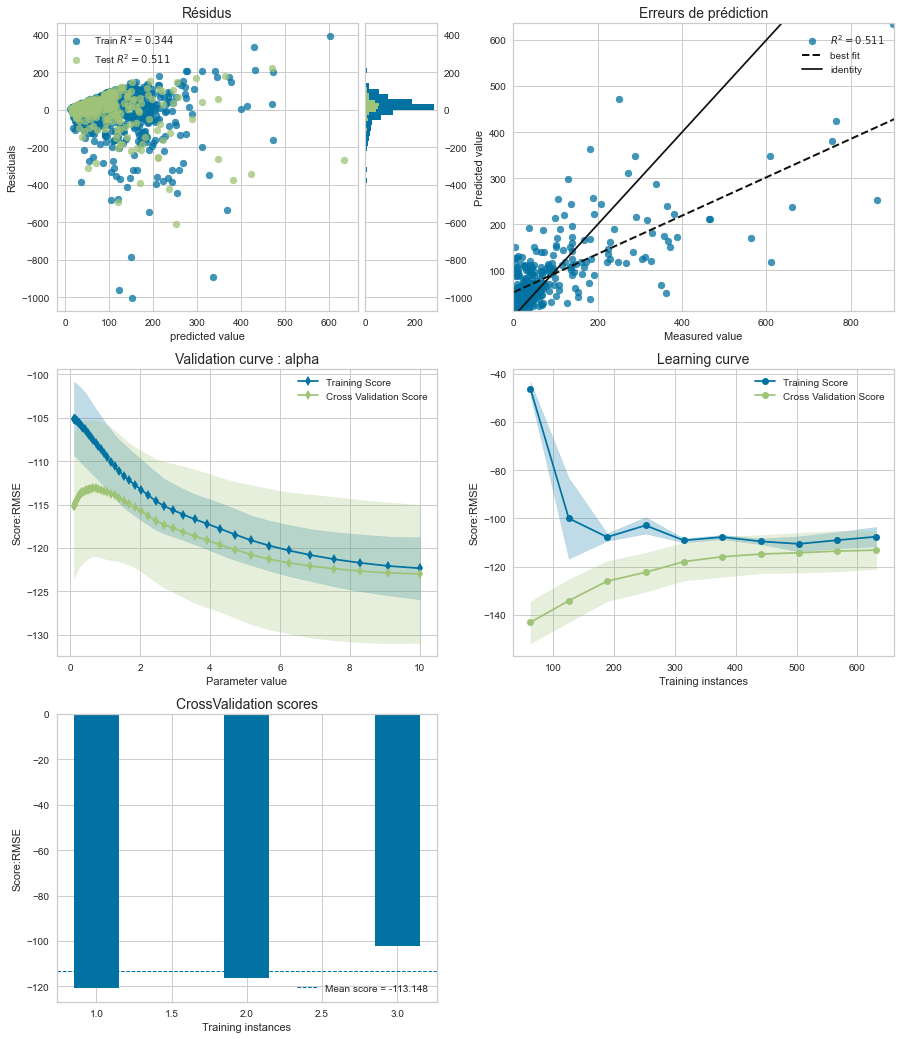

In [256]:
plt.figure(figsize=(15,18))

plt.subplot(3,2, 1)
# visualisation des résidus
model = make_pipeline(preprocessor, ResidualsPlot(Lasso(alpha=best_param[0])))

model.fit(X_train, y_train)
ax = model.score(X_test, y_test)
plt.legend()
plt.title('Résidus', fontsize=14)
plt.xlabel('predicted value')
plt.ylabel('Residuals');

plt.subplot(3,2, 2)
# visu des erreurs de prédiction
model = make_pipeline(preprocessor, PredictionError(Lasso(alpha=best_param[0])))

model.fit(X_train, y_train)
model.score(X_test, y_test)
plt.plot([0,900], [0,900], label='identity', c='k')
plt.legend();
plt.title('Erreurs de prédiction', fontsize=14)
plt.xlabel('Measured value')
plt.ylabel('Predicted value');

plt.subplot(3,2, 3)
# validation curve
viz = make_pipeline(preprocessor, ValidationCurve(Lasso(),
                                                  param_name="alpha",
                                                  param_range=alphas,
                                                  cv=3,
                                                  scoring=score
                                                 )
                   )

viz.fit(X_train, y_train);
plt.legend();
plt.title('Validation curve : alpha', fontsize=14)
plt.xlabel('Parameter value')
plt.ylabel('Score:RMSE');

plt.subplot(3,2, 4)
# Learning curve
sizes = np.linspace(0.1, 1.0, 10)

viz = make_pipeline(preprocessor, LearningCurve(Lasso(alpha=best_param[0]),
                                                cv=3,
                                                train_sizes=sizes,
                                                scoring=score
                                                )
                   )
viz.fit(X_train, y_train);
plt.legend();
plt.title('Learning curve', fontsize=14)
plt.xlabel('Training instances')
plt.ylabel('Score:RMSE');

plt.subplot(3,2, 5)
# visu impact de la crossvalidation
viz = make_pipeline(preprocessor, CVScores(Lasso(alpha=best_param[0]),
                                            cv=3,
                                            scoring=score
                                            )
                   )
viz.fit(X_train, y_train);
plt.legend();
plt.title('CrossValidation scores', fontsize=14)
plt.xlabel('Training instances')
plt.ylabel('Score:RMSE');

## Regression ELASTICNET

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4022031.0215127924, tolerance: 1099.4764391193346
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4072025.0132061685, tolerance: 1086.065622695024
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4621710.747597378, tolerance: 1257.4853333330223
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_desc

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4155455.596549275, tolerance: 1099.4764391193346
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4193417.5444532856, tolerance: 1086.065622695024
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4763898.866418192, tolerance: 1257.4853333330223
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_desce

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4291593.82384433, tolerance: 1099.4764391193346
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4318699.8946249345, tolerance: 1086.065622695024
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4913838.033971682, tolerance: 1257.4853333330223
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descen

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4428291.09503063, tolerance: 1099.4764391193346
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4445456.742959221, tolerance: 1086.065622695024
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5068232.844876803, tolerance: 1257.4853333330223
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4564090.713721649, tolerance: 1099.4764391193346
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4571921.738006969, tolerance: 1086.065622695024
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5224060.72828667, tolerance: 1257.4853333330223
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent

C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4698060.578194637, tolerance: 1099.4764391193346
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4696787.738886496, tolerance: 1086.065622695024
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5378748.975760493, tolerance: 1257.4853333330223
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descen

Temps d'exécution : 1.06min
Durée du gridSearchCV :  63.37281020000046
MSE : 9186.31
RMSE : 9186.31
RMSLE : 1.36
RSE : 0.49
R² : 0.51


y_test  linearregression       ridge       lasso  \
2                     304.62        119.052591  120.751383  125.011669   
9                     755.12        409.723510  388.747124  381.157596   
13                      9.68        118.562142  119.785504  126.307627   
19                      3.71         81.988881   87.845079  103.699180   
31                    191.58        228.407333  213.318722  222.041461   
...                      ...               ...         ...         ...   
R²                       NaN          0.517681    0.516558    0.510837   
elasticnet__alpha        NaN               NaN         NaN         NaN   
elasticnet__l1_ratio     NaN               NaN         NaN         NaN   
lasso__alpha             NaN               NaN         NaN    0.655129   
ridge__alpha             NaN               NaN   13.894955         NaN   

                      elasticnet  
2                     122.199156  
9                     377.127217  
13                    120.760885  
19                     92.850358  
31                    212.601518  
...                          ...  
R²                      0.508988  
elasticnet__alpha       0.175751  
elasticnet__l1_ratio    0.900000  
lasso__alpha                 NaN  
ridge__alpha                 NaN  

[326 rows x 5 columns]

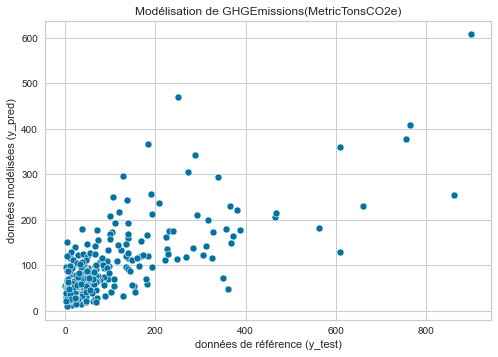

In [257]:
# hyperparamètres à tester
n_alphas = 50
alphas = np.logspace(-1, 0, n_alphas)
l1ratios = np.arange(0,1.1,0.1)

params = {'elasticnet__alpha':alphas,
          'elasticnet__l1_ratio':l1ratios
         }
score = 'neg_root_mean_squared_error'

# modelisation
resultat_GHG_noESS = Test_modele_GSCV(nom_run='elasticnet',
                            model=ElasticNet(), 
                            grid_params=params, 
                            cv=3, 
                            score=score, 
                            pipe_preprocessing=preprocessor,
                            X_train=X_train,
                            y_train=y_train,
                            X_test=X_test,
                            y_test=y_test, 
                            resultat=resultat_GHG_noESS
                           )
resultat_GHG_noESS

### Visu

In [258]:
# récupération des paramètres de best fit
best_param = []
for param in resultat_GHG_noESS.filter(regex='elasticnet', axis=0).index:
    print(param)
    best_param.append(resultat_GHG_noESS.loc[param, 'elasticnet'])
print(best_param)

elasticnet__alpha
elasticnet__l1_ratio
[0.1757510624854792, 0.9]


C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4221036.879629537, tolerance: 1099.4764391193346
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4234736.557346755, tolerance: 1086.065622695024
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Helene\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4794307.056475417, tolerance: 1257.4853333330223
  model = cd_fast.sparse_enet_coordinate_descent(


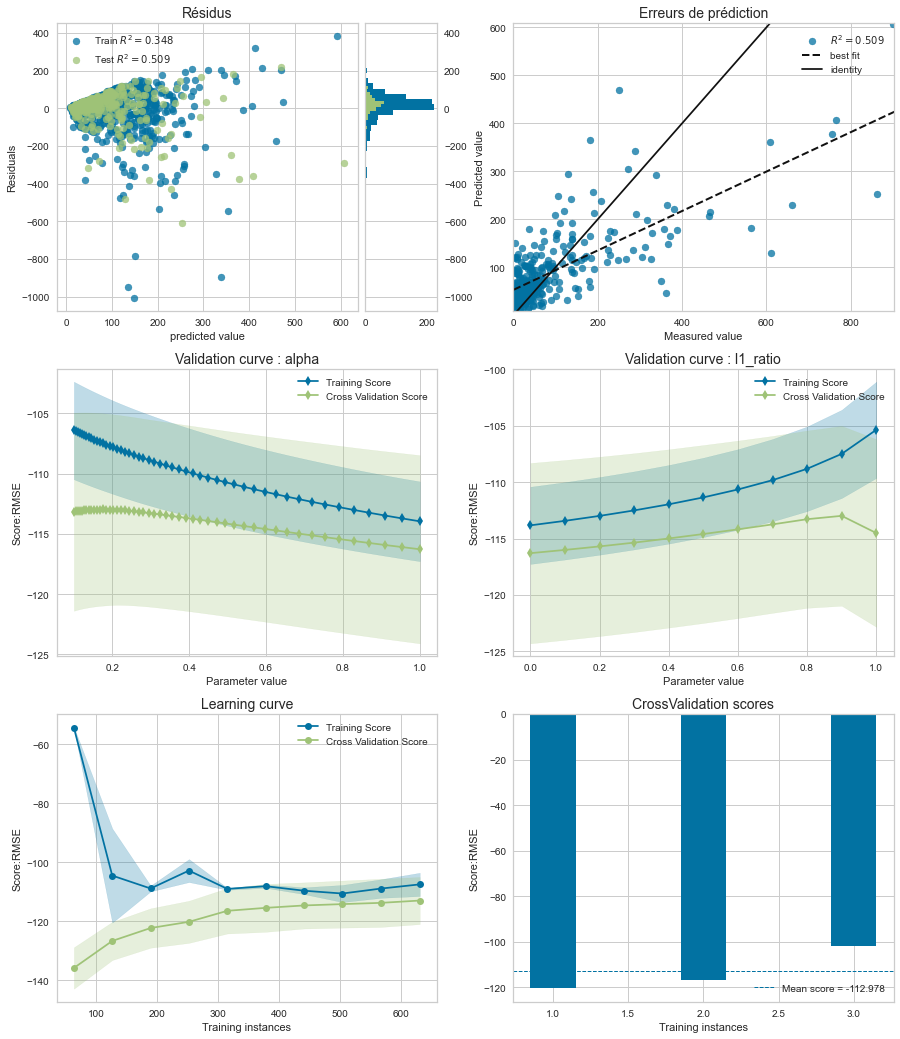

In [259]:
plt.figure(figsize=(15,18))

plt.subplot(3,2, 1)
# visualisation des résidus
model = make_pipeline(preprocessor, ResidualsPlot(ElasticNet(alpha=best_param[0],
                                                             l1_ratio=best_param[1]
                                                            )))

model.fit(X_train, y_train)
ax = model.score(X_test, y_test)
plt.legend()
plt.title('Résidus', fontsize=14)
plt.xlabel('predicted value')
plt.ylabel('Residuals');

plt.subplot(3,2, 2)
# visu des erreurs de prédiction
model = make_pipeline(preprocessor, PredictionError(ElasticNet(alpha=best_param[0],
                                                               l1_ratio=best_param[1])))

model.fit(X_train, y_train)
model.score(X_test, y_test)
plt.plot([0,900], [0,900], label='identity', c='k')
plt.legend();
plt.title('Erreurs de prédiction', fontsize=14)
plt.xlabel('Measured value')
plt.ylabel('Predicted value');

plt.subplot(3,2, 3)
# validation curve
viz = make_pipeline(preprocessor, ValidationCurve(ElasticNet(l1_ratio=best_param[1]),
                                                  param_name="alpha",
                                                  param_range=alphas,
                                                  cv=3,
                                                  scoring=score
                                                 )
                   )

viz.fit(X_train, y_train);
plt.legend();
plt.title('Validation curve : alpha', fontsize=14)
plt.xlabel('Parameter value')
plt.ylabel('Score:RMSE');

plt.subplot(3,2, 4)
# validation curve
viz = make_pipeline(preprocessor, ValidationCurve(ElasticNet(alpha=best_param[0]),
                                                  param_name="l1_ratio",
                                                  param_range=l1ratios,
                                                  cv=3,
                                                  scoring=score
                                                 )
                   )

viz.fit(X_train, y_train);
plt.legend();
plt.title('Validation curve : l1_ratio', fontsize=14)
plt.xlabel('Parameter value')
plt.ylabel('Score:RMSE');

plt.subplot(3,2, 5)
# Learning curve
sizes = np.linspace(0.1, 1.0, 10)

viz = make_pipeline(preprocessor, LearningCurve(ElasticNet(alpha=best_param[0],
                                                           l1_ratio=best_param[1]),
                                                cv=3,
                                                train_sizes=sizes,
                                                scoring=score
                                                )
                   )
viz.fit(X_train, y_train);
plt.legend();
plt.title('Learning curve', fontsize=14)
plt.xlabel('Training instances')
plt.ylabel('Score:RMSE');

plt.subplot(3,2, 6)
# visu impact de la crossvalidation
viz = make_pipeline(preprocessor, CVScores(ElasticNet(alpha=best_param[0],
                                                      l1_ratio=best_param[1]),
                                            cv=3,
                                            scoring=score
                                            )
                   )
viz.fit(X_train, y_train);
plt.legend();
plt.title('CrossValidation scores', fontsize=14)
plt.xlabel('Training instances')
plt.ylabel('Score:RMSE');

## Regression kRR

Temps d'exécution : 1.04min
Durée du gridSearchCV :  62.48412709999957
MSE : 10084.34
RMSE : 10084.34
RMSLE : nan
RSE : 0.54
R² : 0.46


y_test  linearregression       ridge       lasso  \
2                     304.62        119.052591  120.751383  125.011669   
9                     755.12        409.723510  388.747124  381.157596   
13                      9.68        118.562142  119.785504  126.307627   
19                      3.71         81.988881   87.845079  103.699180   
31                    191.58        228.407333  213.318722  222.041461   
...                      ...               ...         ...         ...   
elasticnet__l1_ratio     NaN               NaN         NaN         NaN   
kernelridge__alpha       NaN               NaN         NaN         NaN   
kernelridge__gamma       NaN               NaN         NaN         NaN   
lasso__alpha             NaN               NaN         NaN    0.655129   
ridge__alpha             NaN               NaN   13.894955         NaN   

                      elasticnet     kRR_rbf  
2                     122.199156  204.367625  
9                     377.127217  642.569303  
13                    120.760885  106.265563  
19                     92.850358  117.599638  
31                    212.601518  252.341550  
...                          ...         ...  
elasticnet__l1_ratio    0.900000         NaN  
kernelridge__alpha           NaN    0.233572  
kernelridge__gamma           NaN    0.037927  
lasso__alpha                 NaN         NaN  
ridge__alpha                 NaN         NaN  

[328 rows x 6 columns]

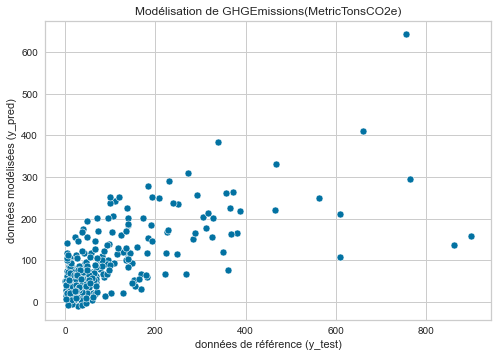

In [260]:
# valeurs du paramètre de régularisation
alpha_range = np.logspace(-2, 0, 20)
# valeurs du paramètre gamma
gamma_range = np.logspace(-3, -1, 20)

# grille de paramètres
params = {'kernelridge__alpha': alpha_range, 
          'kernelridge__gamma': gamma_range}

# score pour sélectionner le modèle optimal
score = 'neg_root_mean_squared_error'

# modelisation
resultat_GHG_noESS = Test_modele_GSCV(nom_run='kRR_rbf',
                            model=KernelRidge(kernel='rbf'), 
                            grid_params=params, 
                            cv=3, 
                            score=score, 
                            pipe_preprocessing=preprocessor,
                            X_train=X_train,
                            y_train=y_train,
                            X_test=X_test,
                            y_test=y_test, 
                            resultat=resultat_GHG_noESS
                           )
resultat_GHG_noESS

### Visu

In [261]:
# récupération des paramètres de best fit
best_param = []
for param in resultat_GHG_noESS.filter(regex='kernelridge', axis=0).index:
    print(param)
    best_param.append(resultat_GHG_noESS.loc[param, 'kRR_rbf'])
print(best_param)

kernelridge__alpha
kernelridge__gamma
[0.23357214690901212, 0.0379269019073225]


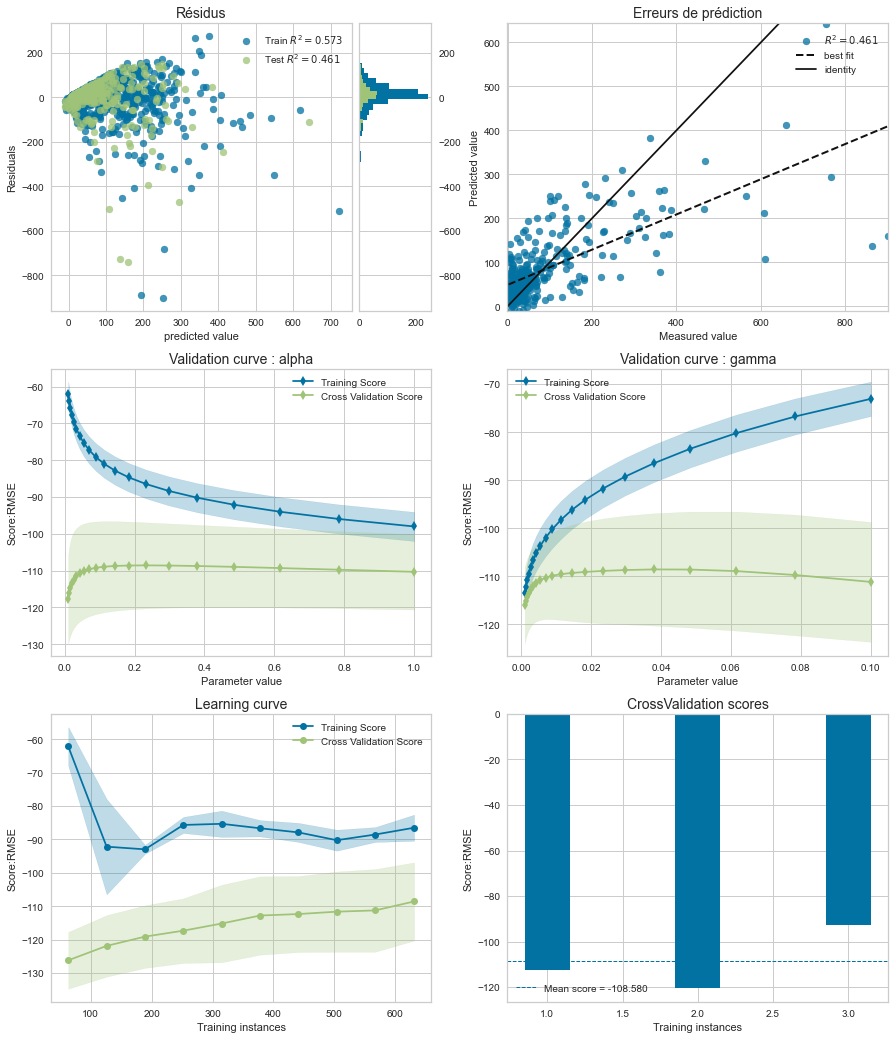

In [262]:
plt.figure(figsize=(15,18))

plt.subplot(3,2, 1)
# visualisation des résidus
model = make_pipeline(preprocessor, ResidualsPlot(KernelRidge(kernel='rbf',
                                                              alpha=best_param[0],
                                                              gamma=best_param[1]
                                                             )))

model.fit(X_train, y_train)
ax = model.score(X_test, y_test)
plt.legend()
plt.title('Résidus', fontsize=14)
plt.xlabel('predicted value')
plt.ylabel('Residuals');

plt.subplot(3,2, 2)
# visu des erreurs de prédiction
model = make_pipeline(preprocessor, PredictionError(KernelRidge(kernel='rbf',
                                                              alpha=best_param[0],
                                                              gamma=best_param[1])))

model.fit(X_train, y_train)
model.score(X_test, y_test)
plt.plot([0,900], [0,900], label='identity', c='k')
plt.legend();
plt.title('Erreurs de prédiction', fontsize=14)
plt.xlabel('Measured value')
plt.ylabel('Predicted value');

plt.subplot(3,2, 3)
# validation curve
viz = make_pipeline(preprocessor, ValidationCurve(KernelRidge(kernel='rbf',
                                                              gamma=best_param[1]),
                                                  param_name="alpha",
                                                  param_range=alpha_range,
                                                  cv=3,
                                                  scoring=score
                                                 )
                   )

viz.fit(X_train, y_train);
plt.legend();
plt.title('Validation curve : alpha', fontsize=14)
plt.xlabel('Parameter value')
plt.ylabel('Score:RMSE');

plt.subplot(3,2, 4)
# validation curve
viz = make_pipeline(preprocessor, ValidationCurve(KernelRidge(kernel='rbf',
                                                              alpha=best_param[0]),
                                                  param_name="gamma",
                                                  param_range=gamma_range,
                                                  cv=3,
                                                  scoring=score
                                                 )
                   )

viz.fit(X_train, y_train);
plt.legend();
plt.title('Validation curve : gamma', fontsize=14)
plt.xlabel('Parameter value')
plt.ylabel('Score:RMSE');

plt.subplot(3,2, 5)
# Learning curve
sizes = np.linspace(0.1, 1.0, 10)

viz = make_pipeline(preprocessor, LearningCurve(KernelRidge(kernel='rbf',
                                                              alpha=best_param[0],
                                                              gamma=best_param[1]),
                                                cv=3,
                                                train_sizes=sizes,
                                                scoring=score
                                                )
                   )
viz.fit(X_train, y_train);
plt.legend();
plt.title('Learning curve', fontsize=14)
plt.xlabel('Training instances')
plt.ylabel('Score:RMSE');

plt.subplot(3,2, 6)
# visu impact de la crossvalidation
viz = make_pipeline(preprocessor, CVScores(KernelRidge(kernel='rbf',
                                                              alpha=best_param[0],
                                                              gamma=best_param[1]),
                                            cv=3,
                                            scoring=score
                                            )
                   )
viz.fit(X_train, y_train);
plt.legend();
plt.title('CrossValidation scores', fontsize=14)
plt.xlabel('Training instances')
plt.ylabel('Score:RMSE');

## Regression bagging : RandomForest

Temps d'exécution : 1.69min
Durée du gridSearchCV :  101.48739990000013
MSE : 10301.66
RMSE : 10301.66
RMSLE : 1.42
RSE : 0.55
R² : 0.45


y_test  linearregression       ridge  \
2                                    304.62        119.052591  120.751383   
9                                    755.12        409.723510  388.747124   
13                                     9.68        118.562142  119.785504   
19                                     3.71         81.988881   87.845079   
31                                   191.58        228.407333  213.318722   
...                                     ...               ...         ...   
lasso__alpha                            NaN               NaN         NaN   
randomforestregressor__max_depth        NaN               NaN         NaN   
randomforestregressor__max_features     NaN               NaN         NaN   
randomforestregressor__n_estimators     NaN               NaN         NaN   
ridge__alpha                            NaN               NaN   13.894955   

                                          lasso  elasticnet     kRR_rbf  \
2                                    125.011669  122.199156  204.367625   
9                                    381.157596  377.127217  642.569303   
13                                   126.307627  120.760885  106.265563   
19                                   103.699180   92.850358  117.599638   
31                                   222.041461  212.601518  252.341550   
...                                         ...         ...         ...   
lasso__alpha                           0.655129         NaN         NaN   
randomforestregressor__max_depth            NaN         NaN         NaN   
randomforestregressor__max_features         NaN         NaN         NaN   
randomforestregressor__n_estimators         NaN         NaN         NaN   
ridge__alpha                                NaN         NaN         NaN   

                                    randomforest  
2                                     264.638756  
9                                     642.116632  
13                                     98.144239  
19                                     87.238331  
31                                    223.059718  
...                                          ...  
lasso__alpha                                 NaN  
randomforestregressor__max_depth            10.0  
randomforestregressor__max_features         sqrt  
randomforestregressor__n_estimators         50.0  
ridge__alpha                                 NaN  

[331 rows x 7 columns]

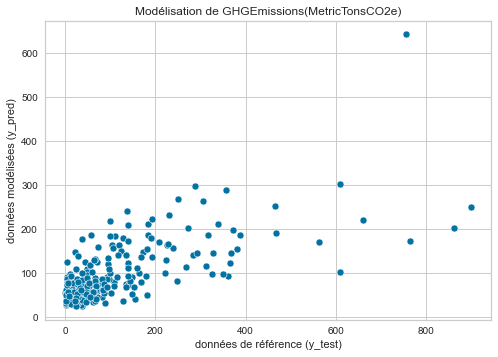

In [263]:
# grille de paramètres
n_estimator_range = [10, 50, 100, 250, 500, 750]
max_depth_range = [1, 2, 3, 4, 5, 10]
max_features_range = ['auto', 'sqrt', 'log2']
params = {"randomforestregressor__n_estimators":n_estimator_range,
          "randomforestregressor__max_depth":max_depth_range, 
          "randomforestregressor__max_features":max_features_range}

# score pour sélectionner le modèle optimal
score = 'neg_root_mean_squared_error'

# modelisation
resultat_GHG_noESS = Test_modele_GSCV(nom_run='randomforest',
                            model=RandomForestRegressor(), 
                            grid_params=params, 
                            cv=3, 
                            score=score, 
                            pipe_preprocessing=preprocessor,
                            X_train=X_train,
                            y_train=y_train,
                            X_test=X_test,
                            y_test=y_test, 
                            resultat=resultat_GHG_noESS
                           )
resultat_GHG_noESS

### Visu

In [264]:
# récupération des paramètres de best fit
best_param = []
for param in resultat_GHG_noESS.filter(regex='randomforestregressor', axis=0).index:
    print(param)
    best_param.append(resultat_GHG_noESS.loc[param, 'randomforest'])
print(best_param)

randomforestregressor__max_depth
randomforestregressor__max_features
randomforestregressor__n_estimators
[10.0, 'sqrt', 50.0]


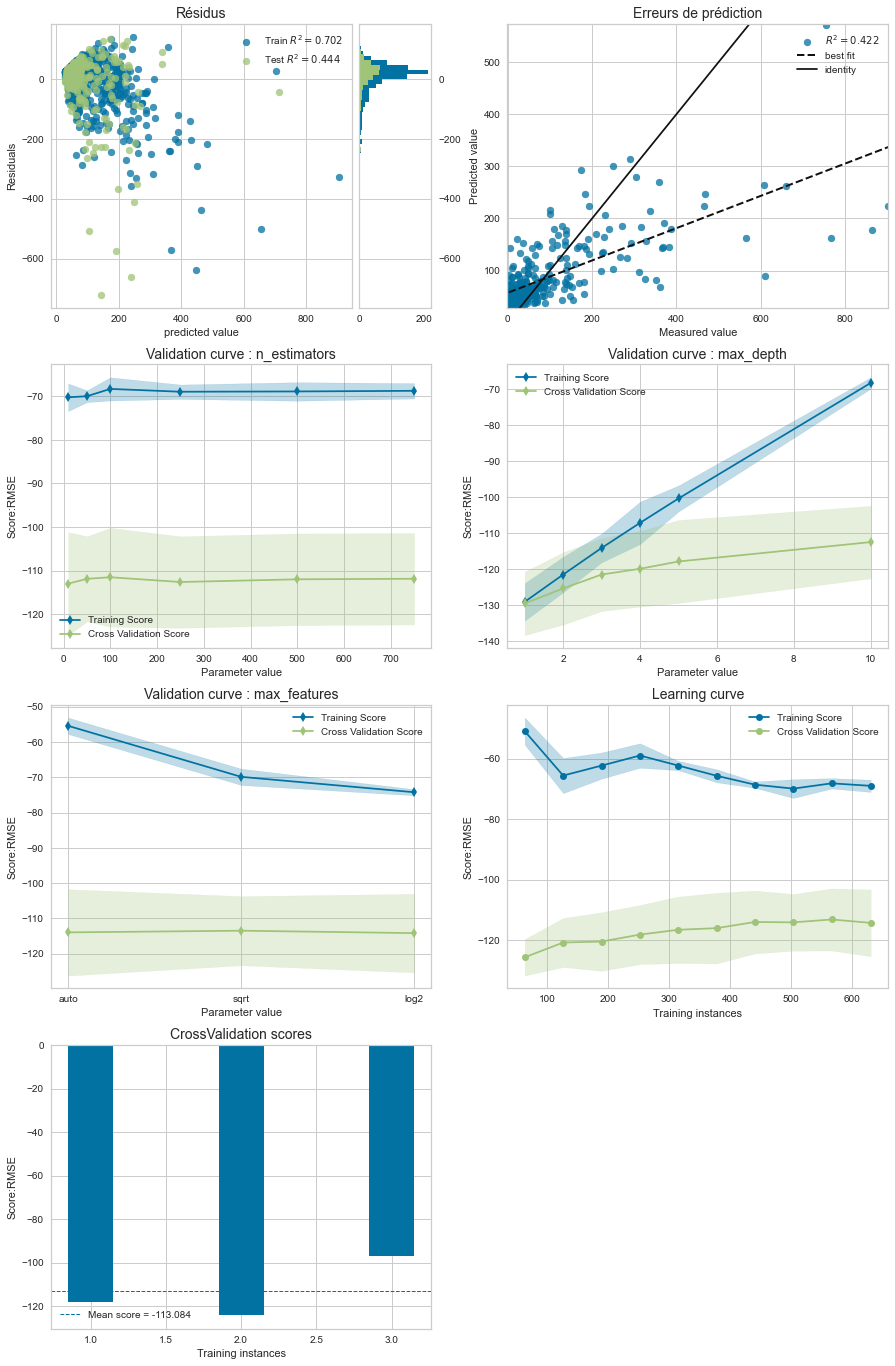

In [265]:
plt.figure(figsize=(15,24))

plt.subplot(4,2, 1)
# visualisation des résidus
model = make_pipeline(preprocessor, ResidualsPlot(RandomForestRegressor(n_estimators=int(best_param[2]), 
                                                                        max_depth=best_param[0], 
                                                                        max_features=best_param[1]
                                                             )))

model.fit(X_train, y_train)
ax = model.score(X_test, y_test)
plt.legend()
plt.title('Résidus', fontsize=14)
plt.xlabel('predicted value')
plt.ylabel('Residuals');

plt.subplot(4,2, 2)
# visu des erreurs de prédiction
model = make_pipeline(preprocessor, PredictionError(RandomForestRegressor(n_estimators=int(best_param[2]), 
                                                                        max_depth=best_param[0], 
                                                                        max_features=best_param[1])))

model.fit(X_train, y_train)
model.score(X_test, y_test)
plt.plot([0,900], [0,900], label='identity', c='k')
plt.legend();
plt.title('Erreurs de prédiction', fontsize=14)
plt.xlabel('Measured value')
plt.ylabel('Predicted value');

plt.subplot(4,2, 3)
# validation curve
viz = make_pipeline(preprocessor, ValidationCurve(RandomForestRegressor(max_depth=best_param[0], 
                                                                        max_features=best_param[1]),
                                                  param_name="n_estimators",
                                                  param_range=n_estimator_range,
                                                  cv=3,
                                                  scoring=score
                                                 )
                   )

viz.fit(X_train, y_train);
plt.legend();
plt.title('Validation curve : n_estimators', fontsize=14)
plt.xlabel('Parameter value')
plt.ylabel('Score:RMSE');

plt.subplot(4,2, 4)
# validation curve
viz = make_pipeline(preprocessor, ValidationCurve(RandomForestRegressor(n_estimators=int(best_param[2]), 
                                                                        max_features=best_param[1]),
                                                  param_name="max_depth",
                                                  param_range=max_depth_range,
                                                  cv=3,
                                                  scoring=score
                                                 )
                   )

viz.fit(X_train, y_train);
plt.legend();
plt.title('Validation curve : max_depth', fontsize=14)
plt.xlabel('Parameter value')
plt.ylabel('Score:RMSE');

plt.subplot(4,2, 5)
# validation curve
viz = make_pipeline(preprocessor, ValidationCurve(RandomForestRegressor(n_estimators=int(best_param[2]), 
                                                                        max_depth=best_param[0]),
                                                  param_name="max_features",
                                                  param_range=max_features_range,
                                                  cv=3,
                                                  scoring=score
                                                 )
                   )

viz.fit(X_train, y_train);
plt.legend();
plt.title('Validation curve : max_features', fontsize=14)
plt.xlabel('Parameter value')
plt.ylabel('Score:RMSE');

plt.subplot(4,2, 6)
# Learning curve
sizes = np.linspace(0.1, 1.0, 10)

viz = make_pipeline(preprocessor, LearningCurve(RandomForestRegressor(n_estimators=int(best_param[2]), 
                                                                        max_depth=best_param[0], 
                                                                        max_features=best_param[1]),
                                                cv=3,
                                                train_sizes=sizes,
                                                scoring=score
                                                )
                   )
viz.fit(X_train, y_train);
plt.legend();
plt.title('Learning curve', fontsize=14)
plt.xlabel('Training instances')
plt.ylabel('Score:RMSE');

plt.subplot(4,2, 7)
# visu impact de la crossvalidation
viz = make_pipeline(preprocessor, CVScores(RandomForestRegressor(n_estimators=int(best_param[2]), 
                                                                        max_depth=best_param[0], 
                                                                        max_features=best_param[1]),
                                            cv=3,
                                            scoring=score
                                            )
                   )
viz.fit(X_train, y_train);
plt.legend();
plt.title('CrossValidation scores', fontsize=14)
plt.xlabel('Training instances')
plt.ylabel('Score:RMSE');

## Regression boosting : GBoost

Temps d'exécution : 5.84min
Durée du gridSearchCV :  350.38692079999964
MSE : 9608.43
RMSE : 9608.43
RMSLE : 1.09
RSE : 0.51
R² : 0.49


y_test  linearregression       ridge  \
2                                    304.62        119.052591  120.751383   
9                                    755.12        409.723510  388.747124   
13                                     9.68        118.562142  119.785504   
19                                     3.71         81.988881   87.845079   
31                                   191.58        228.407333  213.318722   
...                                     ...               ...         ...   
lasso__alpha                            NaN               NaN         NaN   
randomforestregressor__max_depth        NaN               NaN         NaN   
randomforestregressor__max_features     NaN               NaN         NaN   
randomforestregressor__n_estimators     NaN               NaN         NaN   
ridge__alpha                            NaN               NaN   13.894955   

                                          lasso  elasticnet     kRR_rbf  \
2                                    125.011669  122.199156  204.367625   
9                                    381.157596  377.127217  642.569303   
13                                   126.307627  120.760885  106.265563   
19                                   103.699180   92.850358  117.599638   
31                                   222.041461  212.601518  252.341550   
...                                         ...         ...         ...   
lasso__alpha                           0.655129         NaN         NaN   
randomforestregressor__max_depth            NaN         NaN         NaN   
randomforestregressor__max_features         NaN         NaN         NaN   
randomforestregressor__n_estimators         NaN         NaN         NaN   
ridge__alpha                                NaN         NaN         NaN   

                                    randomforest gradientboosting  
2                                     264.638756       227.285636  
9                                     642.116632       597.026106  
13                                     98.144239        83.928389  
19                                     87.238331        57.796528  
31                                    223.059718       275.441519  
...                                          ...              ...  
lasso__alpha                                 NaN              NaN  
randomforestregressor__max_depth            10.0              NaN  
randomforestregressor__max_features         sqrt              NaN  
randomforestregressor__n_estimators         50.0              NaN  
ridge__alpha                                 NaN              NaN  

[336 rows x 8 columns]

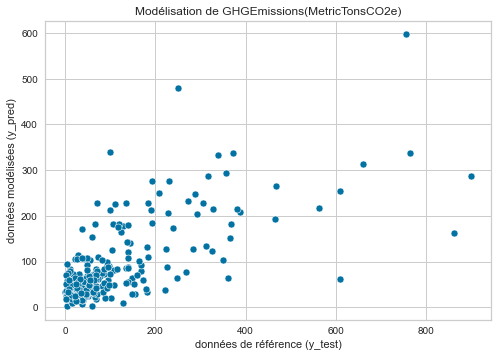

In [266]:
# grille de paramètres
n_estimators_range = [10, 100, 500]
max_depth_range = [1, 3, 5, 10]
max_features_range = ['auto', 'sqrt', 'log2']
learning_rate_range = [0.01, 0.1, 0.5 , 1]
loss_range = ['squared_error', 'absolute_error']
params = {"gradientboostingregressor__n_estimators":n_estimators_range,
          "gradientboostingregressor__max_depth":max_depth_range, 
          "gradientboostingregressor__max_features":max_features_range, 
          'gradientboostingregressor__learning_rate':learning_rate_range,
          'gradientboostingregressor__loss':loss_range
         }

# score pour sélectionner le modèle optimal
score = 'neg_root_mean_squared_error'

# Modélisation
resultat_GHG_noESS = Test_modele_GSCV(nom_run='gradientboosting',
                            model=GradientBoostingRegressor(), 
                            grid_params=params, 
                            cv=3, 
                            score=score, 
                            pipe_preprocessing=preprocessor,
                            X_train=X_train,
                            y_train=y_train,
                            X_test=X_test,
                            y_test=y_test, 
                            resultat=resultat_GHG_noESS
                           )
resultat_GHG_noESS

### Visu

In [267]:
# récupération des paramètres de best fit
best_param = []
for param in resultat_GHG_noESS.filter(regex='gradientboostingregressor', axis=0).index:
    print(param)
    best_param.append(resultat_GHG_noESS.loc[param, 'gradientboosting'])
print(best_param)

gradientboostingregressor__learning_rate
gradientboostingregressor__loss
gradientboostingregressor__max_depth
gradientboostingregressor__max_features
gradientboostingregressor__n_estimators
[0.1, 'absolute_error', 10.0, 'auto', 500.0]


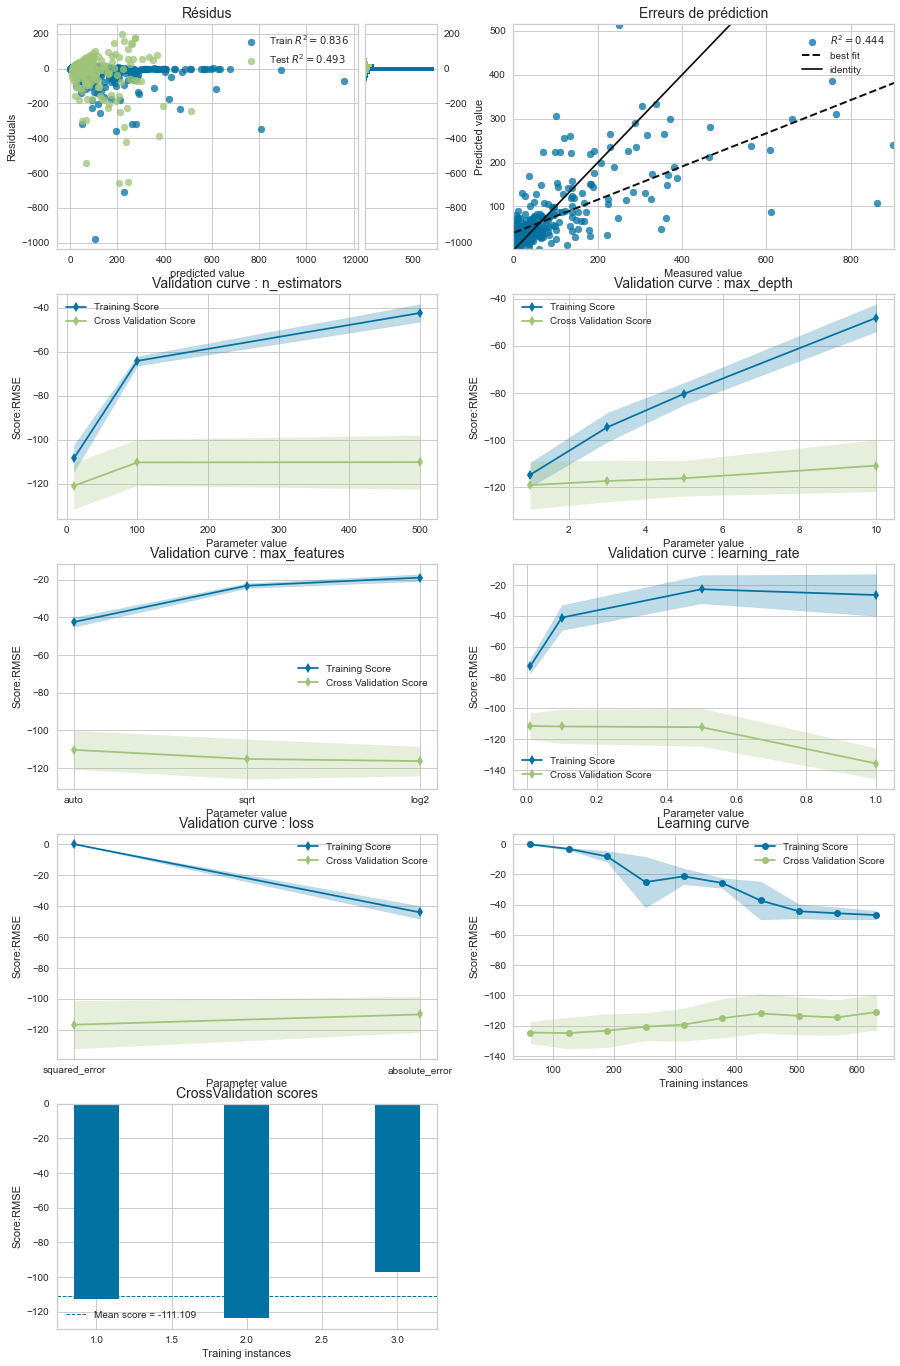

In [268]:
plt.figure(figsize=(15,24))

plt.subplot(5,2, 1)
# visualisation des résidus
model = make_pipeline(preprocessor, ResidualsPlot(GradientBoostingRegressor(n_estimators=int(best_param[4]), 
                                                                            max_depth=best_param[2],
                                                                            max_features=best_param[3],
                                                                            learning_rate=best_param[0],
                                                                            loss=best_param[1]
                                                             )))

model.fit(X_train, y_train)
ax = model.score(X_test, y_test)
plt.legend()
plt.title('Résidus', fontsize=14)
plt.xlabel('predicted value')
plt.ylabel('Residuals');

plt.subplot(5,2, 2)
# visu des erreurs de prédiction
model = make_pipeline(preprocessor, PredictionError(GradientBoostingRegressor(n_estimators=int(best_param[4]), 
                                                                            max_depth=best_param[2],
                                                                            max_features=best_param[3],
                                                                            learning_rate=best_param[0],
                                                                            loss=best_param[1])))

model.fit(X_train, y_train)
model.score(X_test, y_test)
plt.plot([0,900], [0,900], label='identity', c='k')
plt.legend();
plt.title('Erreurs de prédiction', fontsize=14)
plt.xlabel('Measured value')
plt.ylabel('Predicted value');

plt.subplot(5,2, 3)
# validation curve
viz = make_pipeline(preprocessor, ValidationCurve(GradientBoostingRegressor(max_depth=best_param[2],
                                                                            max_features=best_param[3],
                                                                            learning_rate=best_param[0],
                                                                            loss=best_param[1]),
                                                  param_name="n_estimators",
                                                  param_range=n_estimators_range,
                                                  cv=3,
                                                  scoring=score
                                                 )
                   )

viz.fit(X_train, y_train);
plt.legend();
plt.title('Validation curve : n_estimators', fontsize=14)
plt.xlabel('Parameter value')
plt.ylabel('Score:RMSE');

plt.subplot(5,2, 4)
# validation curve
viz = make_pipeline(preprocessor, ValidationCurve(GradientBoostingRegressor(n_estimators=int(best_param[4]), 
                                                                            max_features=best_param[3],
                                                                            learning_rate=best_param[0],
                                                                            loss=best_param[1]),
                                                  param_name="max_depth",
                                                  param_range=max_depth_range,
                                                  cv=3,
                                                  scoring=score
                                                 )
                   )

viz.fit(X_train, y_train);
plt.legend();
plt.title('Validation curve : max_depth', fontsize=14)
plt.xlabel('Parameter value')
plt.ylabel('Score:RMSE');

plt.subplot(5,2, 5)
# validation curve
viz = make_pipeline(preprocessor, ValidationCurve(GradientBoostingRegressor(n_estimators=int(best_param[4]), 
                                                                            max_depth=best_param[2],
                                                                            learning_rate=best_param[0],
                                                                            loss=best_param[1]),
                                                  param_name="max_features",
                                                  param_range=max_features_range,
                                                  cv=3,
                                                  scoring=score
                                                 )
                   )

viz.fit(X_train, y_train);
plt.legend();
plt.title('Validation curve : max_features', fontsize=14)
plt.xlabel('Parameter value')
plt.ylabel('Score:RMSE');

plt.subplot(5,2, 6)
# validation curve
viz = make_pipeline(preprocessor, ValidationCurve(GradientBoostingRegressor(n_estimators=int(best_param[4]), 
                                                                            max_depth=best_param[2],
                                                                            max_features=best_param[3],
                                                                            loss=best_param[1]),
                                                  param_name="learning_rate",
                                                  param_range=learning_rate_range,
                                                  cv=3,
                                                  scoring=score
                                                 )
                   )

viz.fit(X_train, y_train);
plt.legend();
plt.title('Validation curve : learning_rate', fontsize=14)
plt.xlabel('Parameter value')
plt.ylabel('Score:RMSE');

plt.subplot(5,2, 7)
# validation curve
viz = make_pipeline(preprocessor, ValidationCurve(GradientBoostingRegressor(n_estimators=int(best_param[4]), 
                                                                            max_depth=best_param[2],
                                                                            max_features=best_param[3],
                                                                            learning_rate=best_param[0]),
                                                  param_name="loss",
                                                  param_range=loss_range,
                                                  cv=3,
                                                  scoring=score
                                                 )
                   )

viz.fit(X_train, y_train);
plt.legend();
plt.title('Validation curve : loss', fontsize=14)
plt.xlabel('Parameter value')
plt.ylabel('Score:RMSE');

plt.subplot(5,2, 8)
# Learning curve
sizes = np.linspace(0.1, 1.0, 10)

viz = make_pipeline(preprocessor, LearningCurve(GradientBoostingRegressor(n_estimators=int(best_param[4]), 
                                                                            max_depth=best_param[2],
                                                                            max_features=best_param[3],
                                                                            learning_rate=best_param[0],
                                                                            loss=best_param[1]),
                                                cv=3,
                                                train_sizes=sizes,
                                                scoring=score
                                                )
                   )
viz.fit(X_train, y_train);
plt.legend();
plt.title('Learning curve', fontsize=14)
plt.xlabel('Training instances')
plt.ylabel('Score:RMSE');

plt.subplot(5,2, 9)
# visu impact de la crossvalidation
viz = make_pipeline(preprocessor, CVScores(GradientBoostingRegressor(n_estimators=int(best_param[4]), 
                                                                            max_depth=best_param[2],
                                                                            max_features=best_param[3],
                                                                            learning_rate=best_param[0],
                                                                            loss=best_param[1]),
                                            cv=3,
                                            scoring=score
                                            )
                   )
viz.fit(X_train, y_train);
plt.legend();
plt.title('CrossValidation scores', fontsize=14)
plt.xlabel('Training instances')
plt.ylabel('Score:RMSE');

## Comparaison des modélisations

In [269]:
resultat_GHG_noESS = nb_val_negatives(resultat_GHG_noESS, index_max=1254)
resultat_GHG_noESS.loc['nb valeurs negatives']

y_test              0.0
linearregression    3.0
ridge               0.0
lasso               0.0
elasticnet          0.0
kRR_rbf             5.0
randomforest          0
gradientboosting      0
Name: nb valeurs negatives, dtype: object

In [270]:
lignes = ['Duree calcul (s)', 'MSE', 'RMSE', 'RMSLE', 'RSE', 'R²', 'nb valeurs negatives']
comparaison_GHG_noESS = resultat_GHG_noESS.loc[lignes, :].T
comparaison_GHG_noESS = comparaison_GHG_noESS.drop('y_test', axis=0).reset_index()
comparaison_GHG_noESS

index Duree calcul (s)           MSE        RMSE     RMSLE  \
0  linearregression         0.036633   9023.668988   94.992994       NaN   
1             ridge         0.010998    9044.69567   95.103605  1.319869   
2             lasso         0.022002   9151.722674   95.664636  1.355246   
3        elasticnet          0.01785   9186.314745   95.845265  1.358571   
4           kRR_rbf         0.060745  10084.339735  100.420813       NaN   
5      randomforest         0.082251  10301.660038  101.497094  1.418538   
6  gradientboosting         4.666809   9608.425563   98.022577  1.087793   

        RSE        R² nb valeurs negatives  
0  0.482319  0.517681                  3.0  
1  0.483442  0.516558                  0.0  
2  0.489163  0.510837                  0.0  
3  0.491012  0.508988                  0.0  
4  0.539012  0.460988                  5.0  
5  0.550628  0.449372                    0  
6  0.513574  0.486426                    0

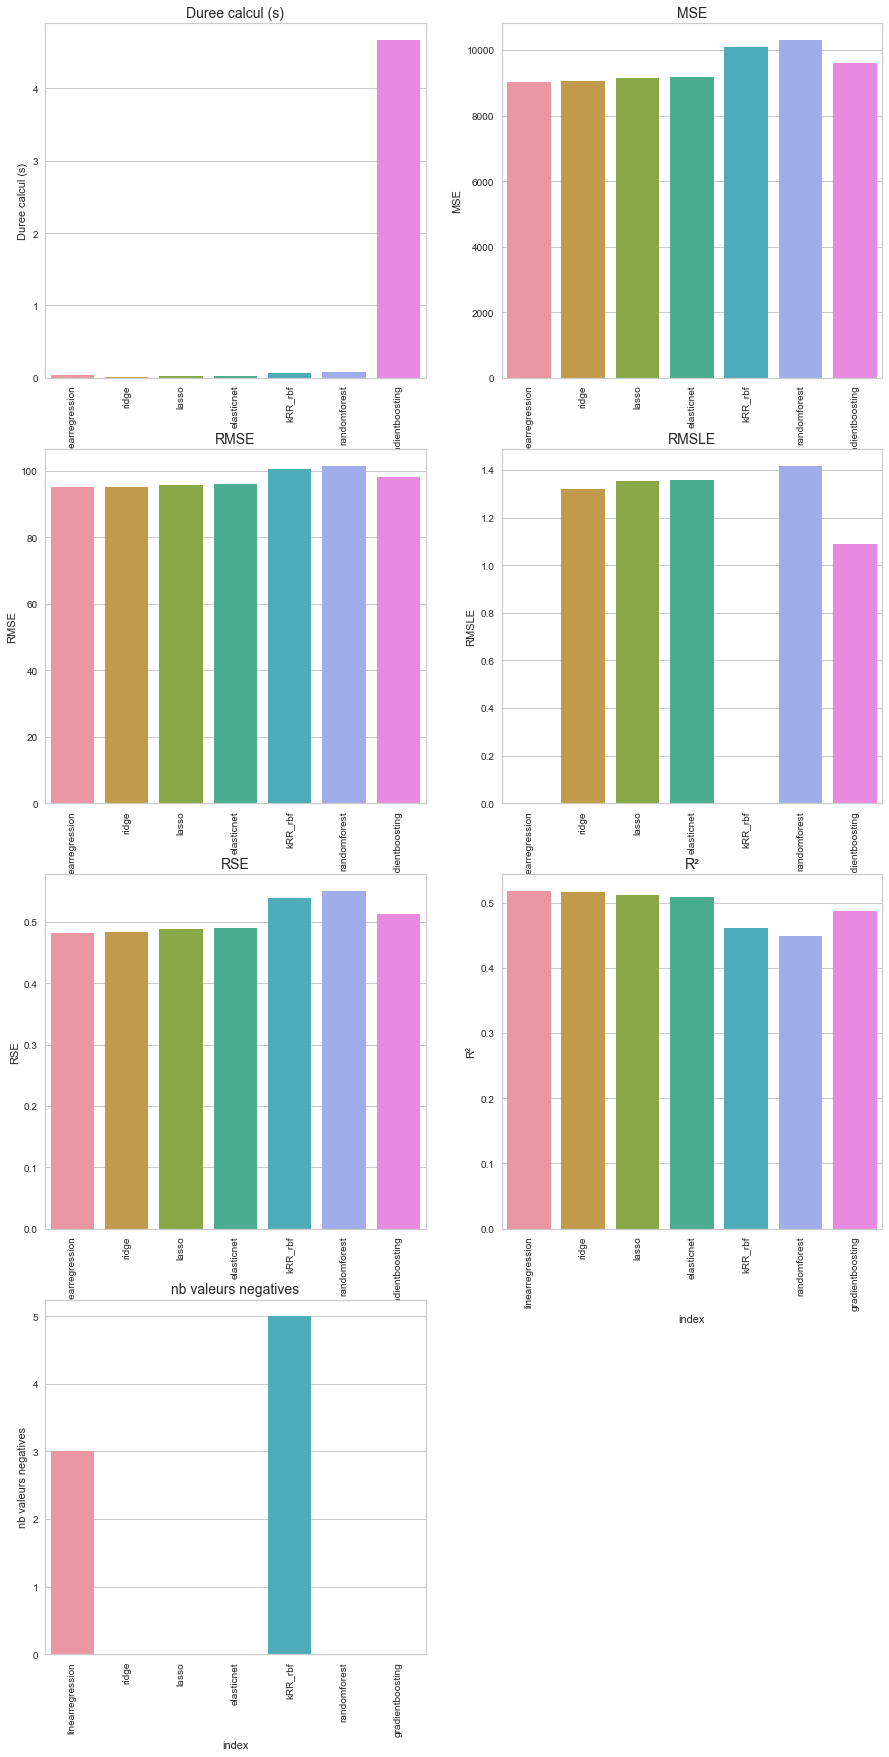

In [271]:
plt.figure(figsize=(15,30))
compteur = 1
for metrique in lignes:
    plt.subplot(4,2, compteur)
    sns.barplot(data=comparaison_GHG_noESS, x='index', y=metrique, label=False)
    plt.title(metrique, fontsize=14)
    plt.xticks(rotation = 90)
    compteur += 1

In [272]:
# visu
lignes = ['RMSE', 'R²', 'nb valeurs negatives', 'Duree calcul (s)']
visu_GHG_noESS = resultat_GHG_noESS.loc[lignes, :].T
visu_GHG_noESS = visu_GHG_noESS.drop('y_test', axis=0).reset_index()
visu_GHG_noESS

index        RMSE        R² nb valeurs negatives  \
0  linearregression   94.992994  0.517681                  3.0   
1             ridge   95.103605  0.516558                  0.0   
2             lasso   95.664636  0.510837                  0.0   
3        elasticnet   95.845265  0.508988                  0.0   
4           kRR_rbf  100.420813  0.460988                  5.0   
5      randomforest  101.497094  0.449372                    0   
6  gradientboosting   98.022577  0.486426                    0   

  Duree calcul (s)  
0         0.036633  
1         0.010998  
2         0.022002  
3          0.01785  
4         0.060745  
5         0.082251  
6         4.666809

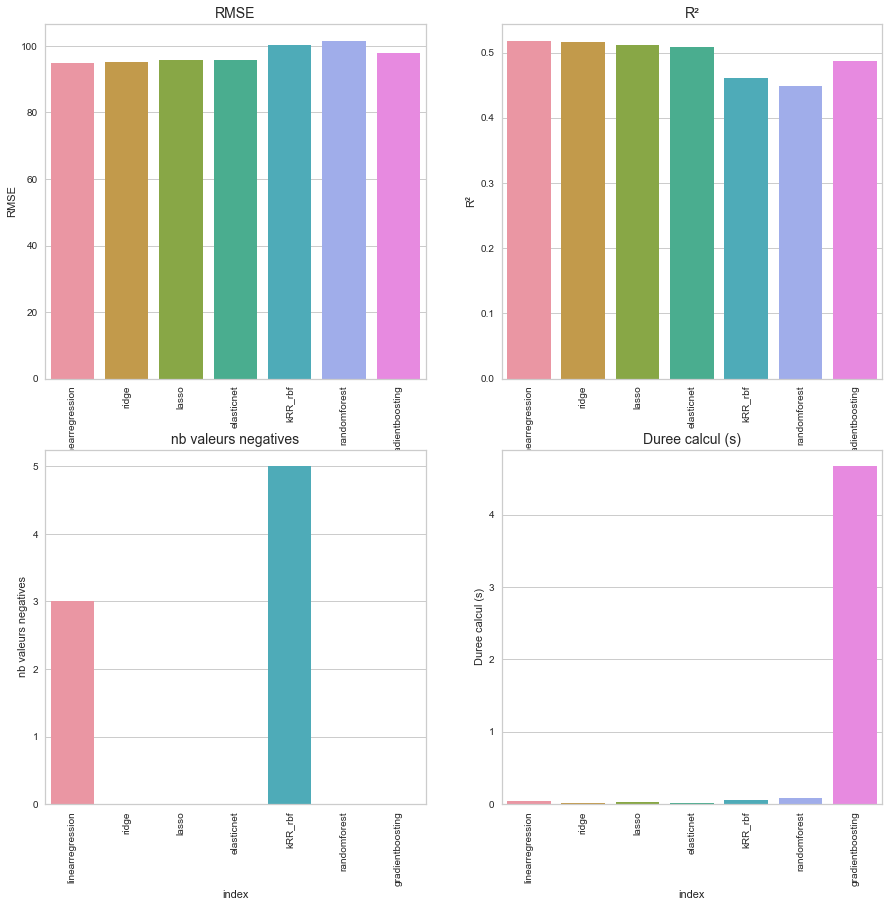

In [273]:
plt.figure(figsize=(15,30))
compteur = 1
for metrique in lignes:
    plt.subplot(4,2, compteur)
    sns.barplot(data=comparaison_GHG_noESS, x='index', y=metrique, label=False)
    plt.title(metrique, fontsize=14)
    plt.xticks(rotation = 90)
    compteur += 1

In [274]:
resultat_GHG_noESS['ridge'].tail(25)

1242                                          84.372871
1249                                          67.460084
1253                                         147.067034
1254                                         179.595754
Duree calcul (s)                               0.010998
MSE                                         9044.695670
RMSE                                          95.103605
RMSLE                                          1.319869
RSE                                            0.483442
R²                                             0.516558
elasticnet__alpha                                   NaN
elasticnet__l1_ratio                                NaN
gradientboostingregressor__learning_rate            NaN
gradientboostingregressor__loss                     NaN
gradientboostingregressor__max_depth                NaN
gradientboostingregressor__max_features             NaN
gradientboostingregressor__n_estimators             NaN
kernelridge__alpha                              

## CONCLUSION

Le fait de ne pas prendre en compte l'EnergyStarScore permet de réduire drastiquement le nombre de valeurs négatives générée (nb max = 5 vs 20 quand on prend en compte l'energyStarScore). Par contre, les métriques sont un peu moins bonnes (R² max = 0.52 vs 0.58 précédemment).
Le meilleur modèle est la regression ridge :
- temps de calcul le plus faible
- pas de valeurs négatives générées
- métriques comparables aux autres modèles (R² = 0.52)

## COMPARAISON DES MODELES SELECTIONNES

In [275]:
resultat_GHG_all = pd.DataFrame()
resultat_GHG_all['y_test'] = resultat_GHG['y_test']
resultat_GHG_all['option 1 - Lasso'] = resultat_GHG['lasso']
resultat_GHG['option 1 - kRR'] = resultat_GHG['kRR_rbf']
resultat_GHG_all['option 2 - Ridge'] = resultat_GHG_noESS['ridge']
resultat_GHG_all

y_test  option 1 - Lasso  \
2                                    304.62        122.217432   
9                                    755.12        413.688466   
13                                     9.68        126.450006   
19                                     3.71        101.302050   
31                                   191.58        205.314125   
...                                     ...               ...   
randomforestregressor__max_depth        NaN               NaN   
randomforestregressor__max_features     NaN               NaN   
randomforestregressor__n_estimators     NaN               NaN   
ridge__alpha                            NaN               NaN   
nb valeurs negatives                   0.00          5.000000   

                                     option 2 - Ridge  
2                                          120.751383  
9                                          388.747124  
13                                         119.785504  
19                                          87.845079  
31                                         213.318722  
...                                               ...  
randomforestregressor__max_depth                  NaN  
randomforestregressor__max_features               NaN  
randomforestregressor__n_estimators               NaN  
ridge__alpha                                13.894955  
nb valeurs negatives                         0.000000  

[337 rows x 3 columns]

In [276]:
lignes = ['RMSE', 'R²', 'nb valeurs negatives', 'Duree calcul (s)']
comparaison_GHG_all = resultat_GHG_all.loc[lignes, :].T
comparaison_GHG_all = comparaison_GHG_all.drop('y_test', axis=0).reset_index()
comparaison_GHG_all

index       RMSE        R²  nb valeurs negatives  \
0  option 1 - Lasso  92.676333  0.540920                   5.0   
1  option 2 - Ridge  95.103605  0.516558                   0.0   

   Duree calcul (s)  
0          0.032875  
1          0.010998

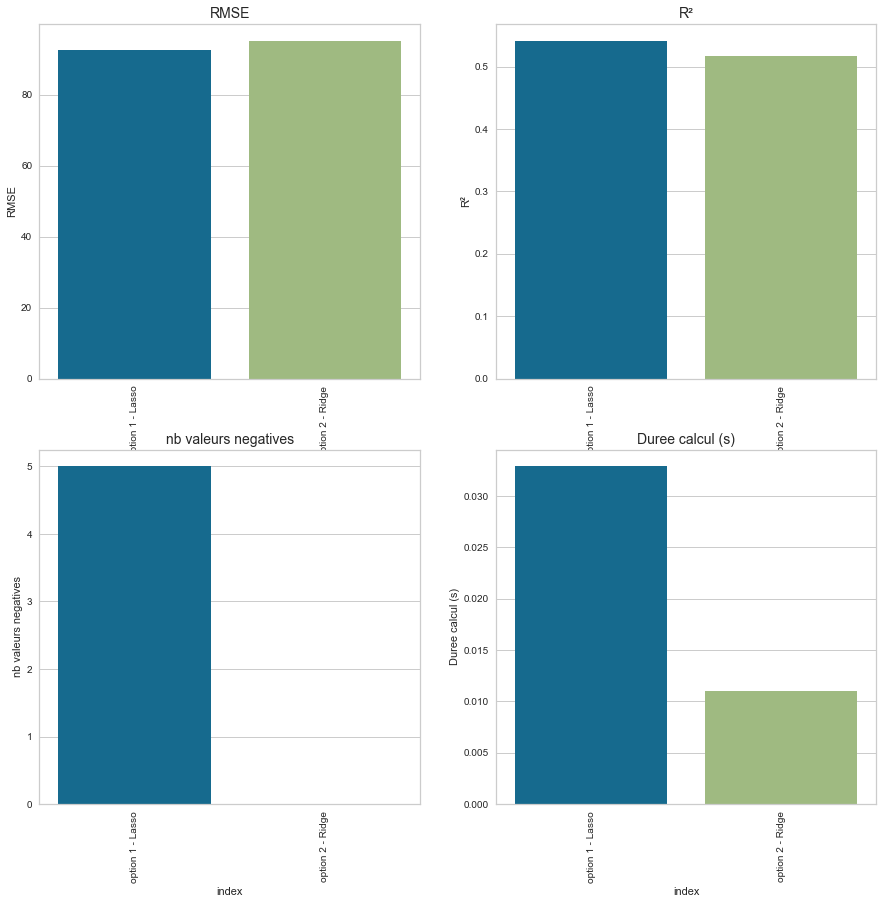

In [277]:
plt.figure(figsize=(15,30))
compteur = 1
for metrique in lignes:
    plt.subplot(4,2, compteur)
    sns.barplot(data=comparaison_GHG_all, x='index', y=metrique, label=False)
    plt.title(metrique, fontsize=14)
    plt.xticks(rotation = 90)
    compteur += 1

In [278]:
resultat_GHG_comp_y = resultat_GHG_all.loc[:1254,:]
# resultat_GHG_comp_y = resultat_GHG_comp_y.astype({'option 1 - GB': float})

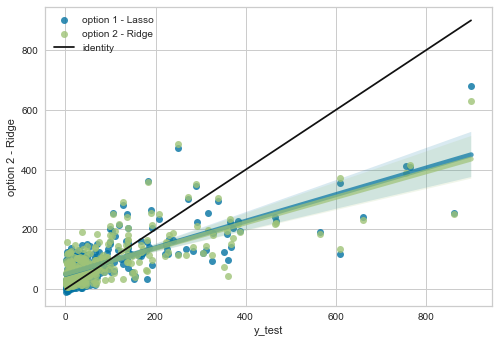

In [279]:
for model in comparaison_GHG_all['index']:
    sns.regplot(y=resultat_GHG_comp_y[model], 
                x=resultat_GHG_comp_y["y_test"], 
                line_kws={"alpha":0.7,"lw":5},
                label=model
               )

plt.plot([0,900], [0,900], label='identity', c='k')
plt.legend();

Choix du modèle Lasso avec alpha = 0.66 car :
- moins de valeurs negatives que le modèle kRR (qui a un meilleur score)
- meilleur score que le modèle ridge sur toutes les features sauf ENERGYSTARScore (qui n'a pas de valeur négative)

In [280]:
Affichage_duree(start_time_ALL)

Temps d'exécution : 1.49h


5366.0054718